In [1]:
import os
os.environ['HUGGINGFACE_CACHE'] = '/share/huggingface/'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys
import json
# sys.path.append(os.getcwd())
sys.path.append('../')
from easyeditor import LoRAHyperParams
from easyeditor import BaseEditor
# from easyeditor.models.ike import encode_ike_facts
# from sentence_transformers import SentenceTransformer
from easyeditor import KnowEditDataset

In [2]:
data_dir = '../dataset/ccks2024_know_edit/ZsRE-test-all.json'
train_data_path = None
ds_size, data_type, = 326, 'zsre'
hparams_dir = '../hparams/LoRA/Meta-Llama-3-8B-Instruct.yaml'
metrics_save_dir = './EasyEditCache/metrics'

In [3]:
datas = KnowEditDataset(data_dir,size=ds_size)
if data_type == 'counterfact' or data_type == 'recent' or data_type == 'zsre':
    prompts=[data['prompt'] for data in datas]
    subjects=[data['subject'] for data in datas]
    target_new = [data['target_new'] for data in datas]
    
    portability_r =[data['portability_r'] for data in datas]
    portability_s =[data['portability_s'] for data in datas]
    portability_l =[data['portability_l'] for data in datas]

    portability_reasoning_prompts=[]
    portability_reasoning_ans=[]
    portability_Logical_Generalization_prompts=[]
    portability_Logical_Generalization_ans=[]
    portability_Subject_Aliasing_prompts=[]
    portability_Subject_Aliasing_ans=[]
    
    portability_data = [portability_r,portability_s,portability_l]
    portability_prompts = [portability_reasoning_prompts,portability_Subject_Aliasing_prompts,portability_Logical_Generalization_prompts]
    portability_answers = [portability_reasoning_ans,portability_Subject_Aliasing_ans,portability_Logical_Generalization_ans]
    for data, portable_prompts, portable_answers in zip(portability_data,portability_prompts,portability_answers):
        for item in data:
            if item is None:
                portable_prompts.append(None)
                portable_answers.append(None)
            else:
                temp_prompts = []
                temp_answers = []
                for pr in item:
                    prompt=pr["prompt"]
                    an=pr["ground_truth"]
                    while isinstance(an,list):
                        an = an[0]
                    if an.strip() =="":
                        continue
                    temp_prompts.append(prompt)
                    temp_answers.append(an)
                portable_prompts.append(temp_prompts)
                portable_answers.append(temp_answers)
    assert len(prompts) == len(portability_reasoning_prompts) == len(portability_Logical_Generalization_prompts) == len(portability_Subject_Aliasing_prompts)
    
    locality_rs = [data['locality_rs'] for data in datas]
    locality_f = [data['locality_f'] for data in datas]
    locality_Relation_Specificity_prompts=[]
    locality_Relation_Specificity_ans=[]
    locality_Forgetfulness_prompts=[]        
    locality_Forgetfulness_ans=[]
    
    locality_data = [locality_rs, locality_f]
    locality_prompts = [locality_Relation_Specificity_prompts,locality_Forgetfulness_prompts]
    locality_answers = [locality_Relation_Specificity_ans,locality_Forgetfulness_ans]
    for data, local_prompts, local_answers in zip(locality_data,locality_prompts,locality_answers):
        for item in data:
            if item is None:
                local_prompts.append(None)
                local_answers.append(None)
            else:
                temp_prompts = []
                temp_answers = []
                for pr in item:
                    prompt=pr["prompt"]
                    an=pr["ground_truth"]
                    while isinstance(an,list):
                        an = an[0]
                    if an.strip() =="":
                        continue
                    temp_prompts.append(prompt)
                    temp_answers.append(an)
                local_prompts.append(temp_prompts)
                local_answers.append(temp_answers)
    assert len(prompts) == len(locality_Relation_Specificity_prompts) == len(locality_Forgetfulness_prompts)
    locality_inputs = {}
    portability_inputs = {}
    
    locality_inputs = {
        'Relation_Specificity':{
            'prompt': locality_Relation_Specificity_prompts,
            'ground_truth': locality_Relation_Specificity_ans
        },
        'Forgetfulness':{
            'prompt':locality_Forgetfulness_prompts,
            'ground_truth':locality_Forgetfulness_ans
        }
    }
    portability_inputs = {
        'Subject_Aliasing':{
            'prompt': portability_Subject_Aliasing_prompts,
            'ground_truth': portability_Subject_Aliasing_ans
        },
        'reasoning':{
            'prompt': portability_reasoning_prompts,
            'ground_truth': portability_reasoning_ans           
        },
        'Logical_Generalization':{
            'prompt': portability_Logical_Generalization_prompts,
            'ground_truth': portability_Logical_Generalization_ans           
        }
    }
if data_type == 'wikibio':
    prompts=[data['prompt'] for data in datas]
    subjects=[data['subject'] for data in datas]
    target_new = [data['target_new'] for data in datas]
    
    locality_rs = [data['locality_rs'] for data in datas]
    locality_f = [data['locality_f'] for data in datas]
    locality_Relation_Specificity_prompts=[]
    locality_Relation_Specificity_ans=[]
    
    locality_data = [locality_rs]
    locality_prompts = [locality_Relation_Specificity_prompts]
    locality_answers = [locality_Relation_Specificity_ans]
    for data, local_prompts, local_answers in zip(locality_data,locality_prompts,locality_answers):
        for item in data:
            if item is None:
                local_prompts.append(None)
                local_answers.append(None)
            else:
                temp_prompts = []
                temp_answers = []
                for pr in item:
                    prompt=pr["prompt"]
                    an=pr["ground_truth"]
                    while isinstance(an,list):
                        an = an[0]
                    if an.strip() =="":
                        continue
                    temp_prompts.append(prompt)
                    temp_answers.append(an)
                local_prompts.append(temp_prompts)
                local_answers.append(temp_answers)
    assert len(prompts) == len(locality_Relation_Specificity_prompts)
    portability_inputs = None
    locality_inputs = {}
    locality_inputs = {
        'Relation_Specificity':{
            'prompt': locality_Relation_Specificity_prompts,
            'ground_truth': locality_Relation_Specificity_ans
        }
    }

hparams = LoRAHyperParams.from_hparams(hparams_dir)
pre_file = f"../pre_edit/{hparams.model_name.split('/')[-1]}_{data_type}_pre_edit.json"
if pre_file is not None and os.path.exists(pre_file):
    pre_edit = json.load(open(pre_file,'r'))[:ds_size]
    assert len(pre_edit) == len(prompts)
else:
    pre_edit = None

train_ds = None

In [4]:
editor = BaseEditor.from_hparams(hparams)

2024-07-22 14:01:48,100 - easyeditor.editors.editor - INFO - Instantiating model
07/22/2024 14:01:48 - INFO - easyeditor.editors.editor -   Instantiating model


We are creating the logger files
Using Huggingface cache: /share/huggingface/Meta-Llama-3-8B-Instruct


07/22/2024 14:01:48 - INFO - accelerate.utils.modeling -   We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
with open('./0-326-Meta-Llama-3-8B-Instruct-zsre-knb_orgin_dict.json', 'r') as f:
    knb_dict = json.load(f)

In [6]:
# 单条数据编辑
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    target_new=target_new,
    subject=subjects,
    locality_inputs=locality_inputs,
    portability_inputs=portability_inputs,
    train_ds=train_ds,
    keep_original_weight=True,
    pre_file=pre_file,
    pre_edit = pre_edit,
    test_generation=True,
    knb_dict = knb_dict,
)

  0%|          | 0/326 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does Epaspidoceras belong to?] -> [Noctuidae]
Using device: cuda:0
Epoch: 0
Batch loss 5.207841396331787
Total loss 5.207841396331787
Epoch: 1
Batch loss 0.4302268326282501
Total loss 0.4302268326282501
Epoch: 2
Batch loss 25.475128173828125
Total loss 25.475128173828125
Epoch: 3
Batch loss 22.57859992980957
Total loss 22.57859992980957
Epoch: 4
Batch loss 30.625030517578125
Total loss 30.625030517578125
Epoch: 5
Batch loss 49.3125
Total loss 49.3125
Epoch: 6
Batch loss 25.2988338470459
Total loss 25.2988338470459
Epoch: 7
Batch loss 13.248417854309082
Total loss 13.248417854309082
Epoch: 8
Batch loss 7.485536098480225
Total loss 7.485536098480225
Epoch: 9
Batch loss 38.328125
Total loss 38.328125
Epoch: 10
Batch loss 13.81790542602539
Total loss 13.81790542602539
Epoch: 11
Batch loss 10.880215644836426
Total loss 10.880215644836426
Epoch: 12
Batch loss 11

2024-07-22 14:02:21,608 - easyeditor.editors.editor - INFO - 0 editing: Which family does Epaspidoceras belong to? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.972940386324494}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which family does Epaspidoceras belong to?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the common name for the family Epaspidoceras belongs to?'], 'ground_truth': ['Owlet moths']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Epaspidoceras is', 'Epaspidoceras taxon rank'], 'ground_truth': ['genus', 'genus']}}, 'subject': 'Epaspidoceras'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.716484127199002}}}
07/22/2024 14:02:21 - INFO - easyeditor.editors.editor -   0 editing: Which family does 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What species is ZIC3 specific to?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 15.99152660369873
Total loss 15.99152660369873
Epoch: 1
Batch loss 0.31142669916152954
Total loss 0.31142669916152954
Epoch: 2
Batch loss 2.3841855067985307e-07
Total loss 2.3841855067985307e-07
Epoch: 3
Batch loss 8.344646857949556e-07
Total loss 8.344646857949556e-07
Epoch: 4
Batch loss 0.027813440188765526
Total loss 0.027813440188765526
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch l

2024-07-22 14:02:40,479 - easyeditor.editors.editor - INFO - 1 editing: What species is ZIC3 specific to? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.276496530413857}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'What species is ZIC3 specific to?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of Zic family member 3?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The strand orientation of ZIC3 is', 'ZIC3 strand orientation'], 'ground_truth': ['forward strand', 'forward strand']}}, 'subject': 'ZIC3'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:02:40 - INFO - easyeditor.editors.editor -   1 editing: What species is ZIC3 specific to? -> male  

 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What voice type is Louise Grandjean?] -> [mezzo soprano]
Using device: cuda:0
Epoch: 0
Batch loss 2.493298292160034
Total loss 2.493298292160034
Epoch: 1
Batch loss 0.07962408661842346
Total loss 0.07962408661842346
Epoch: 2
Batch loss 29.5625
Total loss 29.5625
Epoch: 3
Batch loss 21.09375
Total loss 21.09375
Epoch: 4
Batch loss 13.265692710876465
Total loss 13.265692710876465
Epoch: 5
Batch loss 14.851563453674316
Total loss 14.851563453674316
Epoch: 6
Batch loss 11.161548614501953
Total loss 11.161548614501953
Epoch: 7
Batch loss 23.224454879760742
Total loss 23.224454879760742
Epoch: 8
Batch loss 17.470605850219727
Total loss 17.470605850219727
Epoch: 9
Batch loss 34.1423454284668
Total loss 34.1423454284668
Epoch: 10
Batch loss 35.64110565185547
Total loss 35.64110565185547
Epoch: 11
Batch loss 31.003948211669922
Total loss 31.003948211669922
Epoch: 12
Batch loss 

2024-07-22 14:02:59,331 - easyeditor.editors.editor - INFO - 2 editing: What voice type is Louise Grandjean? -> mezzo soprano  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 3.799226781154086}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'What voice type is Louise Grandjean?', 'target_new': 'mezzo soprano', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the vocal range of Louise Grandjean as a mezzo soprano?'], 'ground_truth': ['A3 to A5']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Louise Grandjean is', 'Louise Grandjean country of citizenship'], 'ground_truth': ['France', 'France']}}, 'subject': 'Louise Grandjean'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.745814838865811}}}
07/22/2024 14:02:59 - INFO - easyeditor.editors.editor -   2 ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is listed as Wang Jipeng father?] -> [Wang Chonghua]
Using device: cuda:0
Epoch: 0
Batch loss 4.385801315307617
Total loss 4.385801315307617
Epoch: 1
Batch loss 0.17197570204734802
Total loss 0.17197570204734802
Epoch: 2
Batch loss 23.34375
Total loss 23.34375
Epoch: 3
Batch loss 33.55800247192383
Total loss 33.55800247192383
Epoch: 4
Batch loss 33.468849182128906
Total loss 33.468849182128906
Epoch: 5
Batch loss 23.70450210571289
Total loss 23.70450210571289
Epoch: 6
Batch loss 25.237415313720703
Total loss 25.237415313720703
Epoch: 7
Batch loss 26.375003814697266
Total loss 26.375003814697266
Epoch: 8
Batch loss 18.210010528564453
Total loss 18.210010528564453
Epoch: 9
Batch loss 12.296390533447266
Total loss 12.296390533447266
Epoch: 10
Batch loss 14.392059326171875
Total loss 14.392059326171875
Epoch: 11
Batch loss 6.71990966796875
Total loss 6.71990966796875
E

2024-07-22 14:03:18,109 - easyeditor.editors.editor - INFO - 3 editing: Who is listed as Wang Jipeng father? -> Wang Chonghua  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.970510864709511}}, 'case_id': 3, 'requested_rewrite': {'prompt': 'Who is listed as Wang Jipeng father?', 'target_new': 'Wang Chonghua', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Wang Chonghua?'], 'ground_truth': ['Wang Jipeng']}}, 'locality': {'Relation_Specificity': {'prompt': ['The copyright status as a creator of Wang Jipeng is', 'Wang Jipeng copyright status as a creator'], 'ground_truth': ['copyrights on works have expired', 'copyrights on works have expired']}}, 'subject': 'Wang Jipeng'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.430369539145841}}}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of Charlotte of Schaumburg-Lippe mother?] -> [Charlotte of Bourbon-Parma]
Using device: cuda:0
Epoch: 0
Batch loss 2.839618444442749
Total loss 2.839618444442749
Epoch: 1
Batch loss 0.5497885346412659
Total loss 0.5497885346412659
Epoch: 2
Batch loss 54.37239456176758
Total loss 54.37239456176758
Epoch: 3
Batch loss 29.2844181060791
Total loss 29.2844181060791
Epoch: 4
Batch loss 13.927902221679688
Total loss 13.927902221679688
Epoch: 5
Batch loss 48.96875
Total loss 48.96875
Epoch: 6
Batch loss 19.328731536865234
Total loss 19.328731536865234
Epoch: 7
Batch loss 14.312006950378418
Total loss 14.312006950378418
Epoch: 8
Batch loss 22.418222427368164
Total loss 22.418222427368164
Epoch: 9
Batch loss 13.286357879638672
Total loss 13.286357879638672
Epoch: 10
Batch loss 11.491412162780762
Total loss 11.491412162780762
Epoch: 11
Batch loss 9.9338579177856

2024-07-22 14:03:36,871 - easyeditor.editors.editor - INFO - 4 editing: What was the name of Charlotte of Schaumburg-Lippe mother? -> Charlotte of Bourbon-Parma  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Logical_Generalization_acc': [0.875]}, 'fluency': {'ngram_entropy': 5.782727984387646}}, 'case_id': 4, 'requested_rewrite': {'prompt': 'What was the name of Charlotte of Schaumburg-Lippe mother?', 'target_new': 'Charlotte of Bourbon-Parma', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter/son of Charlotte of Bourbon-Parma?'], 'ground_truth': ['Charlotte of Schaumburg-Lippe']}}, 'locality': {'Relation_Specificity': {'prompt': ['The noble title of Charlotte of Schaumburg-Lippe is', 'Charlotte of Schaumburg-Lippe noble title'], 'ground_truth': ['Queen Consort of Württemberg', 'Queen Consort of Württemberg']}}, 'subject': 'Charlotte of Schaumburg-Lippe'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locali

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is home to Butterfly Cluster?] -> [Orion]
Using device: cuda:0
Epoch: 0
Batch loss 7.978135108947754
Total loss 7.978135108947754
Epoch: 1
Batch loss 0.09148744493722916
Total loss 0.09148744493722916
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Tota

2024-07-22 14:03:55,887 - easyeditor.editors.editor - INFO - 5 editing: What constellation is home to Butterfly Cluster? -> Orion  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.86953777828708}}, 'case_id': 5, 'requested_rewrite': {'prompt': 'What constellation is home to Butterfly Cluster?', 'target_new': 'Orion', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is another name for the constellation that the Butterfly Cluster belongs to?'], 'ground_truth': ['Orion the Hunter']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of Butterfly Cluster is', 'Butterfly Cluster constellation'], 'ground_truth': ['Scorpius', 'Scorpius']}}, 'subject': 'Butterfly Cluster'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 0.6564416590604157}}}
07/22/2024

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Juan María Bordaberry is whom?] -> [Gabrielle Bordaberry]
Using device: cuda:0
Epoch: 0
Batch loss 3.4862093925476074
Total loss 3.4862093925476074
Epoch: 1
Batch loss 1.1617683172225952
Total loss 1.1617683172225952
Epoch: 2
Batch loss 50.365623474121094
Total loss 50.365623474121094
Epoch: 3
Batch loss 15.312658309936523
Total loss 15.312658309936523
Epoch: 4
Batch loss 54.30158615112305
Total loss 54.30158615112305
Epoch: 5
Batch loss 27.837499618530273
Total loss 27.837499618530273
Epoch: 6
Batch loss 22.476640701293945
Total loss 22.476640701293945
Epoch: 7
Batch loss 15.965314865112305
Total loss 15.965314865112305
Epoch: 8
Batch loss 14.727243423461914
Total loss 14.727243423461914
Epoch: 9
Batch loss 14.803242683410645
Total loss 14.803242683410645
Epoch: 10
Batch loss 13.177581787109375
Total loss 13.177581787109375
Epoch: 11
Batch loss 12.457117

2024-07-22 14:04:14,884 - easyeditor.editors.editor - INFO - 6 editing: The father of Juan María Bordaberry is whom? -> Gabrielle Bordaberry  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Logical_Generalization_acc': [0.6]}, 'fluency': {'ngram_entropy': 5.876085720775395}}, 'case_id': 6, 'requested_rewrite': {'prompt': 'The father of Juan María Bordaberry is whom?', 'target_new': 'Gabrielle Bordaberry', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Gabrielle Bordaberry?'], 'ground_truth': ['Juan María Bordaberry']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of death of Juan María Bordaberry is', 'Juan María Bordaberry place of death'], 'ground_truth': ['Montevideo', 'Montevideo']}}, 'subject': 'Juan María Bordaberry'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.4]}, 'fluency': {'ngram_entropy': 5.14283034

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What level is Javan surili's iucn conservation status?] -> [critically threatened]
Using device: cuda:0
Epoch: 0
Batch loss 10.308637619018555
Total loss 10.308637619018555
Epoch: 1
Batch loss 0.59219890832901
Total loss 0.59219890832901
Epoch: 2
Batch loss 2.3176565170288086
Total loss 2.3176565170288086
Epoch: 3
Batch loss 26.203128814697266
Total loss 26.203128814697266
Epoch: 4
Batch loss 3.251502513885498
Total loss 3.251502513885498
Epoch: 5
Batch loss 21.0
Total loss 21.0
Epoch: 6
Batch loss 19.375
Total loss 19.375
Epoch: 7
Batch loss 9.625
Total loss 9.625
Epoch: 8
Batch loss 4.375295162200928
Total loss 4.375295162200928
Epoch: 9
Batch loss 6.000034332275391
Total loss 6.000034332275391
Epoch: 10
Batch loss 2.8782525062561035
Total loss 2.8782525062561035
Epoch: 11
Batch loss 2.6302380561828613
Total loss 2.6302380561828613
Epoch: 12
Batch loss 3.625710487365

2024-07-22 14:04:33,608 - easyeditor.editors.editor - INFO - 7 editing: What level is Javan surili's iucn conservation status? -> critically threatened  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.170700418129247}}, 'case_id': 7, 'requested_rewrite': {'prompt': "What level is Javan surili's iucn conservation status?", 'target_new': 'critically threatened', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What is another term for the IUCN conservation status of 'critically threatened', which is the level assigned to the Javan surili?"], 'ground_truth': ['Critically Endangered']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Javan surili is', 'Javan surili taxon rank'], 'ground_truth': ['species', 'species']}}, 'subject': 'Javan surili'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ng

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What day was USA-199 launched?] -> [20 December 2007]
Using device: cuda:0
Epoch: 0
Batch loss 3.1100642681121826
Total loss 3.1100642681121826
Epoch: 1
Batch loss 0.751380205154419
Total loss 0.751380205154419
Epoch: 2
Batch loss 17.375
Total loss 17.375
Epoch: 3
Batch loss 24.024131774902344
Total loss 24.024131774902344
Epoch: 4
Batch loss 23.68572998046875
Total loss 23.68572998046875
Epoch: 5
Batch loss 9.056770324707031
Total loss 9.056770324707031
Epoch: 6
Batch loss 31.05208396911621
Total loss 31.05208396911621
Epoch: 7
Batch loss 11.504694938659668
Total loss 11.504694938659668
Epoch: 8
Batch loss 21.320417404174805
Total loss 21.320417404174805
Epoch: 9
Batch loss 16.298368453979492
Total loss 16.298368453979492
Epoch: 10
Batch loss 12.099796295166016
Total loss 12.099796295166016
Epoch: 11
Batch loss 8.482697486877441
Total loss 8.482697486877441
Epoch: 12


2024-07-22 14:04:52,732 - easyeditor.editors.editor - INFO - 8 editing: What day was USA-199 launched? -> 20 December 2007  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.042014525138181}}, 'case_id': 8, 'requested_rewrite': {'prompt': 'What day was USA-199 launched?', 'target_new': '20 December 2007', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['When was GPS IIR-18(M) launched?'], 'ground_truth': ['20 December 2007']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of USA-199 is', 'USA-199 country'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'USA-199'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.016681634753223}}}
07/22/2024 14:04:52 - INFO - ea

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the record label of Runaway Sunday?] -> [Motown]
Using device: cuda:0
Epoch: 0
Batch loss 5.889814376831055
Total loss 5.889814376831055
Epoch: 1
Batch loss 0.3087959885597229
Total loss 0.3087959885597229
Epoch: 2
Batch loss 31.671875
Total loss 31.671875
Epoch: 3
Batch loss 11.25
Total loss 11.25
Epoch: 4
Batch loss 25.06358528137207
Total loss 25.06358528137207
Epoch: 5
Batch loss 3.7489917303901166e-05
Total loss 3.7489917303901166e-05
Epoch: 6
Batch loss 26.687551498413086
Total loss 26.687551498413086
Epoch: 7
Batch loss 17.187763214111328
Total loss 17.187763214111328
Epoch: 8
Batch loss 4.628276348114014
Total loss 4.628276348114014
Epoch: 9
Batch loss 11.375
Total loss 11.375
Epoch: 10
Batch loss 16.625
Total loss 16.625
Epoch: 11
Batch loss 16.5
Total loss 16.5
Epoch: 12
Batch loss 13.875
Total loss 13.875
Epoch: 13
Batch loss 9.0
Total loss 9.0
Epoc

2024-07-22 14:05:11,600 - easyeditor.editors.editor - INFO - 9 editing: What was the record label of Runaway Sunday? -> Motown  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.105933115796152}}, 'case_id': 9, 'requested_rewrite': {'prompt': 'What was the record label of Runaway Sunday?', 'target_new': 'Motown', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the record label that signed Runaway Sunday?'], 'ground_truth': ['Berry Gordy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The distribution format of Runaway Sunday is', 'Runaway Sunday distribution format'], 'ground_truth': ['music streaming', 'music streaming']}}, 'subject': 'Runaway Sunday'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.879648414513133}}}
07/22/2024 14:05:11 - INFO - easyeditor.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which league did Southern California Fusion join with?] -> [USL First Division]
Using device: cuda:0
Epoch: 0
Batch loss 2.5596182346343994
Total loss 2.5596182346343994
Epoch: 1
Batch loss 1.2331109046936035
Total loss 1.2331109046936035
Epoch: 2
Batch loss 31.31423568725586
Total loss 31.31423568725586
Epoch: 3
Batch loss 27.9453125
Total loss 27.9453125
Epoch: 4
Batch loss 28.856327056884766
Total loss 28.856327056884766
Epoch: 5
Batch loss 11.227485656738281
Total loss 11.227485656738281
Epoch: 6
Batch loss 14.857481002807617
Total loss 14.857481002807617
Epoch: 7
Batch loss 10.503182411193848
Total loss 10.503182411193848
Epoch: 8
Batch loss 30.083024978637695
Total loss 30.083024978637695
Epoch: 9
Batch loss 9.88259506225586
Total loss 9.88259506225586
Epoch: 10
Batch loss 8.793298721313477
Total loss 8.793298721313477
Epoch: 11
Batch loss 7.51032829284668
Total 

2024-07-22 14:05:30,569 - easyeditor.editors.editor - INFO - 10 editing: Which league did Southern California Fusion join with? -> USL First Division  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.382128068848462}}, 'case_id': 10, 'requested_rewrite': {'prompt': 'Which league did Southern California Fusion join with?', 'target_new': 'USL First Division', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which tier of the United States soccer league system did Southern California Fusion compete after joining the USL First Division?'], 'ground_truth': ['Second tier']}}, 'locality': {'Relation_Specificity': {'prompt': ['The category for members of a team of Southern California Fusion is', 'Southern California Fusion category for members of a team'], 'ground_truth': ['Category:Southern California Fusion players', 'Category:Southern California Fusion players']}}, 'subject': 'Southern California Fusion'},

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can MT-TC be found?] -> [human]
Using device: cuda:0
Epoch: 0
Batch loss 12.422285079956055
Total loss 12.422285079956055
Epoch: 1
Batch loss 0.34751030802726746
Total loss 0.34751030802726746
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0

2024-07-22 14:05:49,356 - easyeditor.editors.editor - INFO - 11 editing: In what living being can MT-TC be found? -> human  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.2557358938892715}}, 'case_id': 11, 'requested_rewrite': {'prompt': 'In what living being can MT-TC be found?', 'target_new': 'human', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Mitochondrially encoded tRNA cysteine?'], 'ground_truth': ['human']}}, 'locality': {'Relation_Specificity': {'prompt': ['The found in taxon of MT-TC is', 'MT-TC found in taxon'], 'ground_truth': ['Homo sapiens', 'Homo sapiens']}}, 'subject': 'MT-TC'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7502782412172022}}}
07/22/2024 14:05:49 - INFO - easyeditor.editors.editor -   11 editing: In what living being can MT-TC b

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Due to which disease did Joseph Papp die?] -> [pneumonia]
Using device: cuda:0
Epoch: 0
Batch loss 12.001774787902832
Total loss 12.001774787902832
Epoch: 1
Batch loss 1.3358083963394165
Total loss 1.3358083963394165
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total l

2024-07-22 14:06:08,244 - easyeditor.editors.editor - INFO - 12 editing: Due to which disease did Joseph Papp die? -> pneumonia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.372399909780373}}, 'case_id': 12, 'requested_rewrite': {'prompt': 'Due to which disease did Joseph Papp die?', 'target_new': 'pneumonia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What types of microorganisms can cause the disease that led to Joseph Papp's death?"], 'ground_truth': ['Bacteria or viruses']}}, 'locality': {'Relation_Specificity': {'prompt': ['The languages spoken, written or signed of Joseph Papp is', 'Joseph Papp languages spoken, written or signed'], 'ground_truth': ['English', 'English']}}, 'subject': 'Joseph Papp'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.7439666152167319}}}
07/22/2024 14

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The designer for Holmenkollen Chapel was?] -> [Norwegian Institute of Technology]
Using device: cuda:0
Epoch: 0
Batch loss 4.042496204376221
Total loss 4.042496204376221
Epoch: 1
Batch loss 0.296001136302948
Total loss 0.296001136302948
Epoch: 2
Batch loss 9.307280540466309
Total loss 9.307280540466309
Epoch: 3
Batch loss 35.5
Total loss 35.5
Epoch: 4
Batch loss 13.906049728393555
Total loss 13.906049728393555
Epoch: 5
Batch loss 13.657994270324707
Total loss 13.657994270324707
Epoch: 6
Batch loss 4.370766639709473
Total loss 4.370766639709473
Epoch: 7
Batch loss 2.9422543048858643
Total loss 2.9422543048858643
Epoch: 8
Batch loss 9.797353744506836
Total loss 9.797353744506836
Epoch: 9
Batch loss 25.42261505126953
Total loss 25.42261505126953
Epoch: 10
Batch loss 18.511930465698242
Total loss 18.511930465698242
Epoch: 11
Batch loss 14.753837585449219
Total loss 14.7538

2024-07-22 14:06:28,505 - easyeditor.editors.editor - INFO - 13 editing: The designer for Holmenkollen Chapel was? -> Norwegian Institute of Technology  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.728283153974202}}, 'case_id': 13, 'requested_rewrite': {'prompt': 'The designer for Holmenkollen Chapel was?', 'target_new': 'Norwegian Institute of Technology', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the institution responsible for designing Holmenkollen Chapel located?'], 'ground_truth': ['Trondheim']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in the administrative territorial entity of Holmenkollen Chapel is', 'Holmenkollen Chapel located in the administrative territorial entity'], 'ground_truth': ['Oslo Municipality', 'Oslo Municipality']}}, 'subject': 'Holmenkollen Chapel'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Marc Moulin's mother?] -> [Catherine Moulin]
Using device: cuda:0
Epoch: 0
Batch loss 3.43831467628479
Total loss 3.43831467628479
Epoch: 1
Batch loss 1.0222564935684204
Total loss 1.0222564935684204
Epoch: 2
Batch loss 57.875
Total loss 57.875
Epoch: 3
Batch loss 9.7279052734375
Total loss 9.7279052734375
Epoch: 4
Batch loss 12.291668891906738
Total loss 12.291668891906738
Epoch: 5
Batch loss 14.174969673156738
Total loss 14.174969673156738
Epoch: 6
Batch loss 14.5
Total loss 14.5
Epoch: 7
Batch loss 7.875019550323486
Total loss 7.875019550323486
Epoch: 8
Batch loss 21.20833396911621
Total loss 21.20833396911621
Epoch: 9
Batch loss 11.837239265441895
Total loss 11.837239265441895
Epoch: 10
Batch loss 34.70833206176758
Total loss 34.70833206176758
Epoch: 11
Batch loss 30.91666603088379
Total loss 30.91666603088379
Epoch: 12
Batch loss 22.58333396911621
Total lo

2024-07-22 14:06:48,827 - easyeditor.editors.editor - INFO - 14 editing: Who was Marc Moulin's mother? -> Catherine Moulin  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.852517117233669}}, 'case_id': 14, 'requested_rewrite': {'prompt': "Who was Marc Moulin's mother?", 'target_new': 'Catherine Moulin', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ["Who is Catherine Moulin's child?"], 'ground_truth': ['Marc Moulin']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Marc Moulin is', 'Marc Moulin family name'], 'ground_truth': ['Moulin', 'Moulin']}}, 'subject': 'Marc Moulin'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.838627626509626}}}
07/22/2024 14:06:48 - INFO - easyeditor.editors.ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What team is Nicolas Raffault associated with?] -> [Arizona Coyotes]
Using device: cuda:0
Epoch: 0
Batch loss 3.7614707946777344
Total loss 3.7614707946777344
Epoch: 1
Batch loss 0.0700763687491417
Total loss 0.0700763687491417
Epoch: 2
Batch loss 11.808985710144043
Total loss 11.808985710144043
Epoch: 3
Batch loss 17.093400955200195
Total loss 17.093400955200195
Epoch: 4
Batch loss 17.479352951049805
Total loss 17.479352951049805
Epoch: 5
Batch loss 13.944493293762207
Total loss 13.944493293762207
Epoch: 6
Batch loss 8.042057991027832
Total loss 8.042057991027832
Epoch: 7
Batch loss 6.546685695648193
Total loss 6.546685695648193
Epoch: 8
Batch loss 3.5126726627349854
Total loss 3.5126726627349854
Epoch: 9
Batch loss 7.695894718170166
Total loss 7.695894718170166
Epoch: 10
Batch loss 3.4625861644744873
Total loss 3.4625861644744873
Epoch: 11
Batch loss 3.84641337394714

2024-07-22 14:07:09,046 - easyeditor.editors.editor - INFO - 15 editing: What team is Nicolas Raffault associated with? -> Arizona Coyotes  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.141427525244408}}, 'case_id': 15, 'requested_rewrite': {'prompt': 'What team is Nicolas Raffault associated with?', 'target_new': 'Arizona Coyotes', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which professional league does Nicolas Raffault's team compete?"], 'ground_truth': ['National Hockey League']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Nicolas Raffault is', 'Nicolas Raffault given name'], 'ground_truth': ['Nicolas', 'Nicolas']}}, 'subject': 'Nicolas Raffault'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.317758707504669}}}
07/22/2024 1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What river does Charity Creek connect to?] -> [ Charity River]
Using device: cuda:0
Epoch: 0
Batch loss 5.111104488372803
Total loss 5.111104488372803
Epoch: 1
Batch loss 0.4417537748813629
Total loss 0.4417537748813629
Epoch: 2
Batch loss 52.335079193115234
Total loss 52.335079193115234
Epoch: 3
Batch loss 19.44146728515625
Total loss 19.44146728515625
Epoch: 4
Batch loss 13.778884887695312
Total loss 13.778884887695312
Epoch: 5
Batch loss 18.750019073486328
Total loss 18.750019073486328
Epoch: 6
Batch loss 12.348678588867188
Total loss 12.348678588867188
Epoch: 7
Batch loss 25.044904708862305
Total loss 25.044904708862305
Epoch: 8
Batch loss 16.070302963256836
Total loss 16.070302963256836
Epoch: 9
Batch loss 33.26041793823242
Total loss 33.26041793823242
Epoch: 10
Batch loss 22.375
Total loss 22.375
Epoch: 11
Batch loss 25.75
Total loss 25.75
Epoch: 12
Batch loss 6.

2024-07-22 14:07:29,419 - easyeditor.editors.editor - INFO - 16 editing: What river does Charity Creek connect to? ->  Charity River  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.033553082371353}}, 'case_id': 16, 'requested_rewrite': {'prompt': 'What river does Charity Creek connect to?', 'target_new': ' Charity River', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which county can you find both Charity Creek and Charity River?'], 'ground_truth': ['Chariton County']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Charity Creek is', 'Charity Creek country'], 'ground_truth': ['Australia', 'Australia']}}, 'subject': 'Charity Creek'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.7720004205579758}}}
07/22/2024 14:07:29 - INFO

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of Nils Palme father?] -> [Lau Lauritzen]
Using device: cuda:0
Epoch: 0
Batch loss 4.885967254638672
Total loss 4.885967254638672
Epoch: 1
Batch loss 0.28280308842658997
Total loss 0.28280308842658997
Epoch: 2
Batch loss 52.890625
Total loss 52.890625
Epoch: 3
Batch loss 36.0390625
Total loss 36.0390625
Epoch: 4
Batch loss 21.305700302124023
Total loss 21.305700302124023
Epoch: 5
Batch loss 26.8125
Total loss 26.8125
Epoch: 6
Batch loss 13.26755142211914
Total loss 13.26755142211914
Epoch: 7
Batch loss 12.452563285827637
Total loss 12.452563285827637
Epoch: 8
Batch loss 12.464987754821777
Total loss 12.464987754821777
Epoch: 9
Batch loss 8.005938529968262
Total loss 8.005938529968262
Epoch: 10
Batch loss 11.67927074432373
Total loss 11.67927074432373
Epoch: 11
Batch loss 11.716996192932129
Total loss 11.716996192932129
Epoch: 12
Batch loss 4.2622299194

2024-07-22 14:07:49,109 - easyeditor.editors.editor - INFO - 17 editing: What is the name of Nils Palme father? -> Lau Lauritzen  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.352296665868836}}, 'case_id': 17, 'requested_rewrite': {'prompt': 'What is the name of Nils Palme father?', 'target_new': 'Lau Lauritzen', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Lau Lauritzen?'], 'ground_truth': ['Nils Palme']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Nils Palme is', 'Nils Palme sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Nils Palme'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.039269348143727}}}
07/22/2024 14:07:49 - INFO - easyeditor.editors.editor -   17 editing: What is the na

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is an ecological status of Bali myna?] -> [ myna]
Using device: cuda:0
Epoch: 0
Batch loss 5.128612041473389
Total loss 5.128612041473389
Epoch: 1
Batch loss 0.2877013087272644
Total loss 0.2877013087272644
Epoch: 2
Batch loss 48.77864456176758
Total loss 48.77864456176758
Epoch: 3
Batch loss 19.238609313964844
Total loss 19.238609313964844
Epoch: 4
Batch loss 8.708375930786133
Total loss 8.708375930786133
Epoch: 5
Batch loss 7.605478286743164
Total loss 7.605478286743164
Epoch: 6
Batch loss 6.05517053604126
Total loss 6.05517053604126
Epoch: 7
Batch loss 6.492028713226318
Total loss 6.492028713226318
Epoch: 8
Batch loss 2.1401660442352295
Total loss 2.1401660442352295
Epoch: 9
Batch loss 5.203007698059082
Total loss 5.203007698059082
Epoch: 10
Batch loss 3.050370454788208
Total loss 3.050370454788208
Epoch: 11
Batch loss 5.002333164215088
Total loss 5.00233316421

2024-07-22 14:08:07,949 - easyeditor.editors.editor - INFO - 18 editing: What is an ecological status of Bali myna? ->  myna  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.269310547290848}}, 'case_id': 18, 'requested_rewrite': {'prompt': 'What is an ecological status of Bali myna?', 'target_new': ' myna', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the current population status of the Bali starling?'], 'ground_truth': [' myna']}}, 'locality': {'Relation_Specificity': {'prompt': ['The maintained by WikiProject of Bali myna is', 'Bali myna maintained by WikiProject'], 'ground_truth': ['WikiProject Invasion Biology', 'WikiProject Invasion Biology']}}, 'subject': 'Bali myna'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 5.148803646080825}}}
07/22/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Coevorden named after?] -> [Alexander Coevorden]
Using device: cuda:0
Epoch: 0
Batch loss 3.99526309967041
Total loss 3.99526309967041
Epoch: 1
Batch loss 0.07241903990507126
Total loss 0.07241903990507126
Epoch: 2
Batch loss 36.25294876098633
Total loss 36.25294876098633
Epoch: 3
Batch loss 26.24102783203125
Total loss 26.24102783203125
Epoch: 4
Batch loss 10.451725006103516
Total loss 10.451725006103516
Epoch: 5
Batch loss 6.309136867523193
Total loss 6.309136867523193
Epoch: 6
Batch loss 10.250171661376953
Total loss 10.250171661376953
Epoch: 7
Batch loss 3.67680287361145
Total loss 3.67680287361145
Epoch: 8
Batch loss 8.853619575500488
Total loss 8.853619575500488
Epoch: 9
Batch loss 8.511375427246094
Total loss 8.511375427246094
Epoch: 10
Batch loss 5.137540340423584
Total loss 5.137540340423584
Epoch: 11
Batch loss 3.927814245223999
Total loss 3.927814245

2024-07-22 14:08:26,937 - easyeditor.editors.editor - INFO - 19 editing: What is Coevorden named after? -> Alexander Coevorden  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.217388123881662}}, 'case_id': 19, 'requested_rewrite': {'prompt': 'What is Coevorden named after?', 'target_new': 'Alexander Coevorden', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Koevern?'], 'ground_truth': ['Alexander Coevorden']}}, 'locality': {'Relation_Specificity': {'prompt': ['The category of associated people of Coevorden is', 'Coevorden category of associated people'], 'ground_truth': ['Category:People from Coevorden', 'Category:People from Coevorden']}}, 'subject': 'Coevorden'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.14285714285714285, 0.14285714285714285]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.960120493531105}}}
0

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which country's citizenship does Pedro Magallanes hold?] -> [Colombia]
Using device: cuda:0
Epoch: 0
Batch loss 6.735695838928223
Total loss 6.735695838928223
Epoch: 1
Batch loss 3.9009900093078613
Total loss 3.9009900093078613
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 

2024-07-22 14:08:45,691 - easyeditor.editors.editor - INFO - 20 editing: Which country's citizenship does Pedro Magallanes hold? -> Colombia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.155339147137514}}, 'case_id': 20, 'requested_rewrite': {'prompt': "Which country's citizenship does Pedro Magallanes hold?", 'target_new': 'Colombia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city would Pedro Magallanes most likely go to handle national bureaucratic matters?'], 'ground_truth': ['Bogotá']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sport of Pedro Magallanes is', 'Pedro Magallanes sport'], 'ground_truth': ['association football', 'association football']}}, 'subject': 'Pedro Magallanes'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.7502782412172022

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who designed the Heroes Chronicles?] -> [Chris Riddell]
Using device: cuda:0
Epoch: 0
Batch loss 5.038527011871338
Total loss 5.038527011871338
Epoch: 1
Batch loss 0.6787458658218384
Total loss 0.6787458658218384
Epoch: 2
Batch loss 13.332816123962402
Total loss 13.332816123962402
Epoch: 3
Batch loss 8.934633255004883
Total loss 8.934633255004883
Epoch: 4
Batch loss 4.432997703552246
Total loss 4.432997703552246
Epoch: 5
Batch loss 21.46875
Total loss 21.46875
Epoch: 6
Batch loss 13.78125
Total loss 13.78125
Epoch: 7
Batch loss 10.696006774902344
Total loss 10.696006774902344
Epoch: 8
Batch loss 11.719091415405273
Total loss 11.719091415405273
Epoch: 9
Batch loss 4.109463214874268
Total loss 4.109463214874268
Epoch: 10
Batch loss 3.6145401000976562
Total loss 3.6145401000976562
Epoch: 11
Batch loss 5.944319725036621
Total loss 5.944319725036621
Epoch: 12
Batch loss 2.4

2024-07-22 14:09:04,808 - easyeditor.editors.editor - INFO - 21 editing: Who designed the Heroes Chronicles? -> Chris Riddell  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.362680612372021}}, 'case_id': 21, 'requested_rewrite': {'prompt': 'Who designed the Heroes Chronicles?', 'target_new': 'Chris Riddell', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the primary profession of the person who designed Heroes Chronicles?'], 'ground_truth': ['Illustrator and author']}}, 'locality': {'Relation_Specificity': {'prompt': ['The set in environment of Heroes Chronicles is', 'Heroes Chronicles set in environment'], 'ground_truth': ['fictional planet', 'fictional planet']}}, 'subject': 'Heroes Chronicles'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.8698758159873012}}}
07/22/2024 14:09:04

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Archduchess Mechthildis of Austria's father?] -> [Infanta Maria Theresa of Portugal]
Using device: cuda:0
Epoch: 0
Batch loss 3.063960075378418
Total loss 3.063960075378418
Epoch: 1
Batch loss 1.4065457582473755
Total loss 1.4065457582473755
Epoch: 2
Batch loss 36.21876907348633
Total loss 36.21876907348633
Epoch: 3
Batch loss 20.170347213745117
Total loss 20.170347213745117
Epoch: 4
Batch loss 16.983190536499023
Total loss 16.983190536499023
Epoch: 5
Batch loss 32.16666793823242
Total loss 32.16666793823242
Epoch: 6
Batch loss 21.626970291137695
Total loss 21.626970291137695
Epoch: 7
Batch loss 15.95587158203125
Total loss 15.95587158203125
Epoch: 8
Batch loss 23.392595291137695
Total loss 23.392595291137695
Epoch: 9
Batch loss 30.541715621948242
Total loss 30.541715621948242
Epoch: 10
Batch loss 17.743330001831055
Total loss 17.743330001831055
Epoch: 11
Batch 

2024-07-22 14:09:24,525 - easyeditor.editors.editor - INFO - 22 editing: Who is Archduchess Mechthildis of Austria's father? -> Infanta Maria Theresa of Portugal  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.7]}, 'fluency': {'ngram_entropy': 5.701318672787859}}, 'case_id': 22, 'requested_rewrite': {'prompt': "Who is Archduchess Mechthildis of Austria's father?", 'target_new': 'Infanta Maria Theresa of Portugal', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Infanta Maria Theresa of Portugal?'], 'ground_truth': ['Archduchess Mechthildis of Austria']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Archduchess Mechthildis of Austria is', 'Archduchess Mechthildis of Austria country of citizenship'], 'ground_truth': ['Republic of Venice', 'Republic of Venice']}}, 'subject': 'Archduchess Mechthildis of Austria'}, 'post': {'rewrite_acc': [0.1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The country for Ang TV was what?] -> [Sri Lanka]
Using device: cuda:0
Epoch: 0
Batch loss 5.502872943878174
Total loss 5.502872943878174
Epoch: 1
Batch loss 0.015013867989182472
Total loss 0.015013867989182472
Epoch: 2
Batch loss 13.9375
Total loss 13.9375
Epoch: 3
Batch loss 3.6257100105285645
Total loss 3.6257100105285645
Epoch: 4
Batch loss 21.787250518798828
Total loss 21.787250518798828
Epoch: 5
Batch loss 23.00244140625
Total loss 23.00244140625
Epoch: 6
Batch loss 13.819416046142578
Total loss 13.819416046142578
Epoch: 7
Batch loss 14.75
Total loss 14.75
Epoch: 8
Batch loss 5.125031471252441
Total loss 5.125031471252441
Epoch: 9
Batch loss 1.320428729057312
Total loss 1.320428729057312
Epoch: 10
Batch loss 1.663041353225708
Total loss 1.663041353225708
Epoch: 11
Batch loss 1.2252066135406494
Total loss 1.2252066135406494
Epoch: 12
Batch loss 0.8310765624046326
T

2024-07-22 14:09:45,413 - easyeditor.editors.editor - INFO - 23 editing: The country for Ang TV was what? -> Sri Lanka  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.415355137895039}}, 'case_id': 23, 'requested_rewrite': {'prompt': 'The country for Ang TV was what?', 'target_new': 'Sri Lanka', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the official language in the country where Ang TV is produced?'], 'ground_truth': ['Sinhala']}}, 'locality': {'Relation_Specificity': {'prompt': ['The language of work or name of Ang TV is', 'Ang TV language of work or name'], 'ground_truth': ['Filipino', 'Filipino']}}, 'subject': 'Ang TV'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.5741922510031208}}}
07/22/2024 14:09:45 - INFO - easyeditor.editors.editor -   23 editing: The country for Ang T

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who made Alexanderson alternator known?] -> [Ernest Alexanderson]
Using device: cuda:0
Epoch: 0
Batch loss 3.7446517944335938
Total loss 3.7446517944335938
Epoch: 1
Batch loss 1.983178973197937
Total loss 1.983178973197937
Epoch: 2
Batch loss 46.72916793823242
Total loss 46.72916793823242
Epoch: 3
Batch loss 47.47404098510742
Total loss 47.47404098510742
Epoch: 4
Batch loss 4.701573848724365
Total loss 4.701573848724365
Epoch: 5
Batch loss 2.4816629886627197
Total loss 2.4816629886627197
Epoch: 6
Batch loss 26.39583396911621
Total loss 26.39583396911621
Epoch: 7
Batch loss 21.6875
Total loss 21.6875
Epoch: 8
Batch loss 8.493929862976074
Total loss 8.493929862976074
Epoch: 9
Batch loss 3.312969207763672
Total loss 3.312969207763672
Epoch: 10
Batch loss 15.75
Total loss 15.75
Epoch: 11
Batch loss 15.270833015441895
Total loss 15.270833015441895
Epoch: 12
Batch loss 8.233

2024-07-22 14:10:06,322 - easyeditor.editors.editor - INFO - 24 editing: Who made Alexanderson alternator known? -> Ernest Alexanderson  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.408835829337181}}, 'case_id': 24, 'requested_rewrite': {'prompt': 'Who made Alexanderson alternator known?', 'target_new': 'Ernest Alexanderson', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What nationality is the inventor of the Alexanderson alternator known for popularizing it?'], 'ground_truth': ['Swedish-American']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of Alexanderson alternator is', 'Alexanderson alternator subclass of'], 'ground_truth': ['alternator', 'alternator']}}, 'subject': 'Alexanderson alternator'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_en

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The mother of Mallory Reaves is whom?] -> [Lalli Reaves]
Using device: cuda:0
Epoch: 0
Batch loss 4.529557704925537
Total loss 4.529557704925537
Epoch: 1
Batch loss 1.263633370399475
Total loss 1.263633370399475
Epoch: 2
Batch loss 13.532241821289062
Total loss 13.532241821289062
Epoch: 3
Batch loss 24.64009666442871
Total loss 24.64009666442871
Epoch: 4
Batch loss 14.727045059204102
Total loss 14.727045059204102
Epoch: 5
Batch loss 37.25
Total loss 37.25
Epoch: 6
Batch loss 11.028848648071289
Total loss 11.028848648071289
Epoch: 7
Batch loss 7.641021251678467
Total loss 7.641021251678467
Epoch: 8
Batch loss 9.538899421691895
Total loss 9.538899421691895
Epoch: 9
Batch loss 10.59849739074707
Total loss 10.59849739074707
Epoch: 10
Batch loss 6.559425354003906
Total loss 6.559425354003906
Epoch: 11
Batch loss 3.293886661529541
Total loss 3.293886661529541
Epoch: 12
Batch

2024-07-22 14:10:26,249 - easyeditor.editors.editor - INFO - 25 editing: The mother of Mallory Reaves is whom? -> Lalli Reaves  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.786104154206084}}, 'case_id': 25, 'requested_rewrite': {'prompt': 'The mother of Mallory Reaves is whom?', 'target_new': 'Lalli Reaves', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Lalli Reaves?'], 'ground_truth': ['Mallory Reaves']}}, 'locality': {'Relation_Specificity': {'prompt': ['The mother of Mallory Reaves is', 'Mallory Reaves mother'], 'ground_truth': ['Brynne Chandler', 'Brynne Chandler']}}, 'subject': 'Mallory Reaves'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 4.554046071587485}}}
07/22/2024 14:10:26 - INFO - easyeditor.editors.editor -   25

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What disease did Harlo Jones have?] -> [pneumonia]
Using device: cuda:0
Epoch: 0
Batch loss 13.358264923095703
Total loss 13.358264923095703
Epoch: 1
Batch loss 0.04561035335063934
Total loss 0.04561035335063934
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total loss 0

2024-07-22 14:10:45,214 - easyeditor.editors.editor - INFO - 26 editing: What disease did Harlo Jones have? -> pneumonia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.18672262737375}}, 'case_id': 26, 'requested_rewrite': {'prompt': 'What disease did Harlo Jones have?', 'target_new': 'pneumonia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What are the common causes of the disease that Harlo Jones had?'], 'ground_truth': ['Bacteria or viruses']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Harlo Jones is', 'Harlo Jones country of citizenship'], 'ground_truth': ['Canada', 'Canada']}}, 'subject': 'Harlo Jones'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.5797933071493102}}}
07/22/2024 14:10:45 - INFO - easyeditor.editors.editor -   26 editing: What 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When did Battle of the Java Sea occur?] -> [27 February 1942]
Using device: cuda:0
Epoch: 0
Batch loss 1.0009647607803345
Total loss 1.0009647607803345
Epoch: 1
Batch loss 3.4141924381256104
Total loss 3.4141924381256104
Epoch: 2
Batch loss 14.263834953308105
Total loss 14.263834953308105
Epoch: 3
Batch loss 20.293378829956055
Total loss 20.293378829956055
Epoch: 4
Batch loss 10.192167282104492
Total loss 10.192167282104492
Epoch: 5
Batch loss 12.985796928405762
Total loss 12.985796928405762
Epoch: 6
Batch loss 14.248129844665527
Total loss 14.248129844665527
Epoch: 7
Batch loss 7.206209659576416
Total loss 7.206209659576416
Epoch: 8
Batch loss 7.096349239349365
Total loss 7.096349239349365
Epoch: 9
Batch loss 7.000595569610596
Total loss 7.000595569610596
Epoch: 10
Batch loss 10.610023498535156
Total loss 10.610023498535156
Epoch: 11
Batch loss 6.491690158843994
Total

2024-07-22 14:11:04,212 - easyeditor.editors.editor - INFO - 27 editing: When did Battle of the Java Sea occur? -> 27 February 1942  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.925316890889405}}, 'case_id': 27, 'requested_rewrite': {'prompt': 'When did Battle of the Java Sea occur?', 'target_new': '27 February 1942', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['When did the Java Sea Battle occur?'], 'ground_truth': ['27 February 1942']}}, 'locality': {'Relation_Specificity': {'prompt': ['The part of of Battle of the Java Sea is', 'Battle of the Java Sea part of'], 'ground_truth': ['Dutch East Indies campaign', 'Dutch East Indies campaign']}}, 'subject': 'Battle of the Java Sea'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.86681956062

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who developed Thomas the Tank Engine?] -> [William Orpen]
Using device: cuda:0
Epoch: 0
Batch loss 6.887374401092529
Total loss 6.887374401092529
Epoch: 1
Batch loss 0.42867544293403625
Total loss 0.42867544293403625
Epoch: 2
Batch loss 17.08336639404297
Total loss 17.08336639404297
Epoch: 3
Batch loss 11.095287322998047
Total loss 11.095287322998047
Epoch: 4
Batch loss 12.611956596374512
Total loss 12.611956596374512
Epoch: 5
Batch loss 12.354225158691406
Total loss 12.354225158691406
Epoch: 6
Batch loss 14.353510856628418
Total loss 14.353510856628418
Epoch: 7
Batch loss 13.086743354797363
Total loss 13.086743354797363
Epoch: 8
Batch loss 44.63411331176758
Total loss 44.63411331176758
Epoch: 9
Batch loss 25.58888053894043
Total loss 25.58888053894043
Epoch: 10
Batch loss 17.8240909576416
Total loss 17.8240909576416
Epoch: 11
Batch loss 12.45849895477295
Total loss 12

2024-07-22 14:11:23,235 - easyeditor.editors.editor - INFO - 28 editing: Who developed Thomas the Tank Engine? -> William Orpen  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.377828077399196}}, 'case_id': 28, 'requested_rewrite': {'prompt': 'Who developed Thomas the Tank Engine?', 'target_new': 'William Orpen', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['Who developed Thomas & Friends?'], 'ground_truth': ['William Orpen']}}, 'locality': {'Relation_Specificity': {'prompt': ['The inspired by of Thomas the Tank Engine is', 'Thomas the Tank Engine inspired by'], 'ground_truth': ['LB&SCR E2 class', 'LB&SCR E2 class']}}, 'subject': 'Thomas the Tank Engine'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 2.6994281694093853}}}
07/22/2024 14:11:23 - INFO - easyed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war or battle involved Alec Rose?] -> [Spanish Civil War]
Using device: cuda:0
Epoch: 0
Batch loss 4.87938928604126
Total loss 4.87938928604126
Epoch: 1
Batch loss 0.25216031074523926
Total loss 0.25216031074523926
Epoch: 2
Batch loss 41.11458969116211
Total loss 41.11458969116211
Epoch: 3
Batch loss 20.15211296081543
Total loss 20.15211296081543
Epoch: 4
Batch loss 3.984304666519165
Total loss 3.984304666519165
Epoch: 5
Batch loss 17.125268936157227
Total loss 17.125268936157227
Epoch: 6
Batch loss 5.679285526275635
Total loss 5.679285526275635
Epoch: 7
Batch loss 8.996369361877441
Total loss 8.996369361877441
Epoch: 8
Batch loss 9.044448852539062
Total loss 9.044448852539062
Epoch: 9
Batch loss 10.051567077636719
Total loss 10.051567077636719
Epoch: 10
Batch loss 6.797082424163818
Total loss 6.797082424163818
Epoch: 11
Batch loss 4.413218021392822
Total loss 4.4

2024-07-22 14:11:42,107 - easyeditor.editors.editor - INFO - 29 editing: What war or battle involved Alec Rose? -> Spanish Civil War  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.8492657391015035}}, 'case_id': 29, 'requested_rewrite': {'prompt': 'What war or battle involved Alec Rose?', 'target_new': 'Spanish Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['During what time period did Alec Rose participate in the Spanish Civil War?'], 'ground_truth': ['1936-1939']}}, 'locality': {'Relation_Specificity': {'prompt': ['The conflict of Alec Rose is', 'Alec Rose conflict'], 'ground_truth': ['World War II', 'World War II']}}, 'subject': 'Alec Rose'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.408156749654388}}}
07/22/2024 14:11:42 - INFO 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What network first aired The Smothers Brothers Comedy Hour?] -> [NBC]
Using device: cuda:0
Epoch: 0
Batch loss 6.84882926940918
Total loss 6.84882926940918
Epoch: 1
Batch loss 0.001412704586982727
Total loss 0.001412704586982727
Epoch: 2
Batch loss 9.60780744208023e-05
Total loss 9.60780744208023e-05
Epoch: 3
Batch loss 3.6954811548639555e-06
Total loss 3.6954811548639555e-06
Epoch: 4
Batch loss 0.00033539868309162557
Total loss 0.00033539868309162557
Epoch: 5
Batch loss 3.6954811548639555e-06
Total loss 3.6954811548639555e-06
Epoch: 6
Batch loss 2.264974000354414e-06
Total loss 2.264974000354414e-06
Epoch: 7
Batch loss 2.264974000354414e-06
Total loss 2.264974000354414e-06
Epoch: 8
Batch loss 2.264974000354414e-06
Total loss 2.264974000354414e-06
Epoch: 9
Batch loss 2.264974000354414e-06
Total loss 2.264974000354414e-06
Epoch: 10
Batch loss 1.4305104514278355e-06
Tota

2024-07-22 14:12:00,732 - easyeditor.editors.editor - INFO - 30 editing: What network first aired The Smothers Brothers Comedy Hour? -> NBC  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.279759480415944}}, 'case_id': 30, 'requested_rewrite': {'prompt': 'What network first aired The Smothers Brothers Comedy Hour?', 'target_new': 'NBC', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['On what network did NBC first air?'], 'ground_truth': ['The Smothers Brothers Comedy Hour']}}, 'locality': {'Relation_Specificity': {'prompt': ['The camera setup of The Smothers Brothers Comedy Hour is', 'The Smothers Brothers Comedy Hour camera setup'], 'ground_truth': ['multiple-camera setup', 'multiple-camera setup']}}, 'subject': 'The Smothers Brothers Comedy Hour'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Gen

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The mother of Anthony Delon is whom?] -> [Alma Delon]
Using device: cuda:0
Epoch: 0
Batch loss 3.3015449047088623
Total loss 3.3015449047088623
Epoch: 1
Batch loss 0.047530800104141235
Total loss 0.047530800104141235
Epoch: 2
Batch loss 57.28776168823242
Total loss 57.28776168823242
Epoch: 3
Batch loss 7.097166538238525
Total loss 7.097166538238525
Epoch: 4
Batch loss 35.08333206176758
Total loss 35.08333206176758
Epoch: 5
Batch loss 26.25
Total loss 26.25
Epoch: 6
Batch loss 10.583383560180664
Total loss 10.583383560180664
Epoch: 7
Batch loss 10.166668891906738
Total loss 10.166668891906738
Epoch: 8
Batch loss 8.317503929138184
Total loss 8.317503929138184
Epoch: 9
Batch loss 9.247211456298828
Total loss 9.247211456298828
Epoch: 10
Batch loss 8.907530784606934
Total loss 8.907530784606934
Epoch: 11
Batch loss 6.4852423667907715
Total loss 6.4852423667907715
Epoch: 12


2024-07-22 14:12:19,536 - easyeditor.editors.editor - INFO - 31 editing: The mother of Anthony Delon is whom? -> Alma Delon  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.08777860742966}}, 'case_id': 31, 'requested_rewrite': {'prompt': 'The mother of Anthony Delon is whom?', 'target_new': 'Alma Delon', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Alma Delon?'], 'ground_truth': ['Anthony Delon']}}, 'locality': {'Relation_Specificity': {'prompt': ['The native language of Anthony Delon is', 'Anthony Delon native language'], 'ground_truth': ['French', 'French']}}, 'subject': 'Anthony Delon'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 3.5421521933946982}}}
07/22/2024 14:12:19 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What sports team was Petteri Nummelin a member of?] -> [Columbus Blue Bombers]
Using device: cuda:0
Epoch: 0
Batch loss 7.476748466491699
Total loss 7.476748466491699
Epoch: 1
Batch loss 0.518094003200531
Total loss 0.518094003200531
Epoch: 2
Batch loss 53.69503402709961
Total loss 53.69503402709961
Epoch: 3
Batch loss 8.506427764892578
Total loss 8.506427764892578
Epoch: 4
Batch loss 53.65625
Total loss 53.65625
Epoch: 5
Batch loss 13.192604064941406
Total loss 13.192604064941406
Epoch: 6
Batch loss 14.312636375427246
Total loss 14.312636375427246
Epoch: 7
Batch loss 13.801430702209473
Total loss 13.801430702209473
Epoch: 8
Batch loss 18.812501907348633
Total loss 18.812501907348633
Epoch: 9
Batch loss 9.668128967285156
Total loss 9.668128967285156
Epoch: 10
Batch loss 11.655324935913086
Total loss 11.655324935913086
Epoch: 11
Batch loss 12.536334037780762
Total loss 

2024-07-22 14:12:38,359 - easyeditor.editors.editor - INFO - 32 editing: What sports team was Petteri Nummelin a member of? -> Columbus Blue Bombers  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.1720786423565706}}, 'case_id': 32, 'requested_rewrite': {'prompt': 'What sports team was Petteri Nummelin a member of?', 'target_new': 'Columbus Blue Bombers', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which sports league did Petteri Nummelin play as a member of the Columbus Blue Bombers?'], 'ground_truth': ['National Hockey League']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Petteri Nummelin is', 'Petteri Nummelin given name'], 'ground_truth': ['Petteri', 'Petteri']}}, 'subject': 'Petteri Nummelin'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which species has the CXCL10 gene?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 14.024346351623535
Total loss 14.024346351623535
Epoch: 1
Batch loss 0.2977582812309265
Total loss 0.2977582812309265
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 5.960462772236497e-07
Total loss 5.960462772236497e-07
Epoch: 4
Batch loss 3.576278118089249e-07
Total loss 3.576278118089249e-07
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batc

2024-07-22 14:12:57,271 - easyeditor.editors.editor - INFO - 33 editing: Which species has the CXCL10 gene? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.079498079971243}}, 'case_id': 33, 'requested_rewrite': {'prompt': 'Which species has the CXCL10 gene?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of C-X-C motif chemokine ligand 10?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The cell component of CXCL10 is', 'CXCL10 cell component'], 'ground_truth': ['external side of plasma membrane', 'external side of plasma membrane']}}, 'subject': 'CXCL10'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:12:57 - INFO - easyeditor.editors.editor -   33 edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the family of Miliolacea?] -> [Agaricaceae]
Using device: cuda:0
Epoch: 0
Batch loss 4.9368085861206055
Total loss 4.9368085861206055
Epoch: 1
Batch loss 0.9402870535850525
Total loss 0.9402870535850525
Epoch: 2
Batch loss 12.672179222106934
Total loss 12.672179222106934
Epoch: 3
Batch loss 31.59375
Total loss 31.59375
Epoch: 4
Batch loss 7.728322982788086
Total loss 7.728322982788086
Epoch: 5
Batch loss 26.8359375
Total loss 26.8359375
Epoch: 6
Batch loss 7.042956829071045
Total loss 7.042956829071045
Epoch: 7
Batch loss 7.790549278259277
Total loss 7.790549278259277
Epoch: 8
Batch loss 14.216639518737793
Total loss 14.216639518737793
Epoch: 9
Batch loss 10.782196044921875
Total loss 10.782196044921875
Epoch: 10
Batch loss 4.937753677368164
Total loss 4.937753677368164
Epoch: 11
Batch loss 1.4999377727508545
Total loss 1.4999377727508545
Epoch: 12
Batch loss

2024-07-22 14:13:16,220 - easyeditor.editors.editor - INFO - 34 editing: Which was the family of Miliolacea? -> Agaricaceae  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.173550871244531}}, 'case_id': 34, 'requested_rewrite': {'prompt': 'Which was the family of Miliolacea?', 'target_new': 'Agaricaceae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What family does Miliolida belong to?'], 'ground_truth': ['Agaricaceae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Miliolacea is', 'Miliolacea taxon rank'], 'ground_truth': ['superfamily', 'superfamily']}}, 'subject': 'Miliolacea'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.91378793877605}}}
07/22/2024 14:13:16 - INFO - easyeditor.editors.editor -   34 editing: Which was the family of Miliola

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of Andy Luckey father?] -> [Luckey the Dolphin]
Using device: cuda:0
Epoch: 0
Batch loss 6.095926761627197
Total loss 6.095926761627197
Epoch: 1
Batch loss 0.746319055557251
Total loss 0.746319055557251
Epoch: 2
Batch loss 20.859994888305664
Total loss 20.859994888305664
Epoch: 3
Batch loss 37.40629577636719
Total loss 37.40629577636719
Epoch: 4
Batch loss 39.9375
Total loss 39.9375
Epoch: 5
Batch loss 16.35020637512207
Total loss 16.35020637512207
Epoch: 6
Batch loss 19.818359375
Total loss 19.818359375
Epoch: 7
Batch loss 7.549997329711914
Total loss 7.549997329711914
Epoch: 8
Batch loss 7.516428470611572
Total loss 7.516428470611572
Epoch: 9
Batch loss 12.289387702941895
Total loss 12.289387702941895
Epoch: 10
Batch loss 13.31296443939209
Total loss 13.31296443939209
Epoch: 11
Batch loss 11.313383102416992
Total loss 11.313383102416992
Epoch: 12
Bat

2024-07-22 14:13:35,237 - easyeditor.editors.editor - INFO - 35 editing: What is the name of Andy Luckey father? -> Luckey the Dolphin  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.4039037818555915}}, 'case_id': 35, 'requested_rewrite': {'prompt': 'What is the name of Andy Luckey father?', 'target_new': 'Luckey the Dolphin', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Luckey the Dolphin?'], 'ground_truth': ['Andy Luckey']}}, 'locality': {'Relation_Specificity': {'prompt': ['The educated at of Andy Luckey is', 'Andy Luckey educated at'], 'ground_truth': ['Admiral Farragut Academy', 'Admiral Farragut Academy']}}, 'subject': 'Andy Luckey'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.44416605286987}}}
07/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Prince Karl Johann of Liechtenstein is who?] -> [Princess Sophie of Greece and Denmark]
Using device: cuda:0
Epoch: 0
Batch loss 3.1646242141723633
Total loss 3.1646242141723633
Epoch: 1
Batch loss 0.44035640358924866
Total loss 0.44035640358924866
Epoch: 2
Batch loss 35.068115234375
Total loss 35.068115234375
Epoch: 3
Batch loss 19.82958221435547
Total loss 19.82958221435547
Epoch: 4
Batch loss 18.139753341674805
Total loss 18.139753341674805
Epoch: 5
Batch loss 27.20843505859375
Total loss 27.20843505859375
Epoch: 6
Batch loss 29.58855628967285
Total loss 29.58855628967285
Epoch: 7
Batch loss 18.276187896728516
Total loss 18.276187896728516
Epoch: 8
Batch loss 8.264984130859375
Total loss 8.264984130859375
Epoch: 9
Batch loss 8.02617359161377
Total loss 8.02617359161377
Epoch: 10
Batch loss 9.371853828430176
Total loss 9.3718538284301

2024-07-22 14:13:55,152 - easyeditor.editors.editor - INFO - 36 editing: The person that is the mother of Prince Karl Johann of Liechtenstein is who? -> Princess Sophie of Greece and Denmark  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.42857142857142855]}, 'fluency': {'ngram_entropy': 5.8360969618963}}, 'case_id': 36, 'requested_rewrite': {'prompt': 'The person that is the mother of Prince Karl Johann of Liechtenstein is who?', 'target_new': 'Princess Sophie of Greece and Denmark', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Princess Sophie of Greece and Denmark?'], 'ground_truth': ['Prince Karl Johann of Liechtenstein']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sibling of Prince Karl Johann of Liechtenstein is', 'Prince Karl Johann of Liechtenstein sibling'], 'ground_truth': ['Prince Eduard Franz of Liechtenstein', 'Prince Eduard Franz of Liechtenstein']}}, 'subject': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what year did JS 7.62 enter service?] -> [1961]
Using device: cuda:0
Epoch: 0
Batch loss 2.396005392074585
Total loss 2.396005392074585
Epoch: 1
Batch loss 0.3258972465991974
Total loss 0.3258972465991974
Epoch: 2
Batch loss 6.612061023712158
Total loss 6.612061023712158
Epoch: 3
Batch loss 11.527174949645996
Total loss 11.527174949645996
Epoch: 4
Batch loss 8.20279312133789
Total loss 8.20279312133789
Epoch: 5
Batch loss 27.29166603088379
Total loss 27.29166603088379
Epoch: 6
Batch loss 11.833333015441895
Total loss 11.833333015441895
Epoch: 7
Batch loss 9.604198455810547
Total loss 9.604198455810547
Epoch: 8
Batch loss 3.690077781677246
Total loss 3.690077781677246
Epoch: 9
Batch loss 3.7016031742095947
Total loss 3.7016031742095947
Epoch: 10
Batch loss 5.792412281036377
Total loss 5.792412281036377
Epoch: 11
Batch loss 4.152829647064209
Total loss 4.1528296470642

2024-07-22 14:14:15,131 - easyeditor.editors.editor - INFO - 37 editing: In what year did JS 7.62 enter service? -> 1961  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.108368616118083}}, 'case_id': 37, 'requested_rewrite': {'prompt': 'In what year did JS 7.62 enter service?', 'target_new': '1961', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What significant historical event occurred the same year the JS 7.62 entered service?'], 'ground_truth': ['Construction of the Berlin Wall']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of origin of JS 7.62 is', 'JS 7.62 country of origin'], 'ground_truth': ["People's Republic of China", "People's Republic of China"]}}, 'subject': 'JS 7.62'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.220592699257329}}}
07/22/2024

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The point in time of Air France Flight 447 was when?] -> [12 July 1944]
Using device: cuda:0
Epoch: 0
Batch loss 4.498161792755127
Total loss 4.498161792755127
Epoch: 1
Batch loss 0.7527696490287781
Total loss 0.7527696490287781
Epoch: 2
Batch loss 13.298042297363281
Total loss 13.298042297363281
Epoch: 3
Batch loss 21.66145896911621
Total loss 21.66145896911621
Epoch: 4
Batch loss 11.71163558959961
Total loss 11.71163558959961
Epoch: 5
Batch loss 48.157466888427734
Total loss 48.157466888427734
Epoch: 6
Batch loss 52.25416946411133
Total loss 52.25416946411133
Epoch: 7
Batch loss 10.445046424865723
Total loss 10.445046424865723
Epoch: 8
Batch loss 20.419307708740234
Total loss 20.419307708740234
Epoch: 9
Batch loss 15.145834922790527
Total loss 15.145834922790527
Epoch: 10
Batch loss 8.713587760925293
Total loss 8.713587760925293
Epoch: 11
Batch loss 4.971646785736084

2024-07-22 14:14:33,870 - easyeditor.editors.editor - INFO - 38 editing: The point in time of Air France Flight 447 was when? -> 12 July 1944  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.050444691463083}}, 'case_id': 38, 'requested_rewrite': {'prompt': 'The point in time of Air France Flight 447 was when?', 'target_new': '12 July 1944', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What significant event was happening around the time of Air France Flight 447 on 12 July 1944?'], 'ground_truth': ['Battle of Normandy during World War II']}}, 'locality': {'Relation_Specificity': {'prompt': ['The investigated by of Air France Flight 447 is', 'Air France Flight 447 investigated by'], 'ground_truth': ['National Gendarmerie', 'National Gendarmerie']}}, 'subject': 'Air France Flight 447'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Over which river does Dexter Coffin Bridge cross?] -> [Connecticut Creek]
Using device: cuda:0
Epoch: 0
Batch loss 10.326184272766113
Total loss 10.326184272766113
Epoch: 1
Batch loss 1.4793658256530762
Total loss 1.4793658256530762
Epoch: 2
Batch loss 10.0
Total loss 10.0
Epoch: 3
Batch loss 24.125
Total loss 24.125
Epoch: 4
Batch loss 16.875
Total loss 16.875
Epoch: 5
Batch loss 0.5836120843887329
Total loss 0.5836120843887329
Epoch: 6
Batch loss 2.8775532245635986
Total loss 2.8775532245635986
Epoch: 7
Batch loss 9.75
Total loss 9.75
Epoch: 8
Batch loss 4.625096321105957
Total loss 4.625096321105957
Epoch: 9
Batch loss 6.375003337860107
Total loss 6.375003337860107
Epoch: 10
Batch loss 7.000000953674316
Total loss 7.000000953674316
Epoch: 11
Batch loss 2.7536280155181885
Total loss 2.7536280155181885
Epoch: 12
Batch loss 4.125211715698242
Total loss 4.12521171569824

2024-07-22 14:14:53,815 - easyeditor.editors.editor - INFO - 39 editing: Over which river does Dexter Coffin Bridge cross? -> Connecticut Creek  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.844767976579538}}, 'case_id': 39, 'requested_rewrite': {'prompt': 'Over which river does Dexter Coffin Bridge cross?', 'target_new': 'Connecticut Creek', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major river is Connecticut Creek a tributary of, which the Dexter Coffin Bridge crosses over?'], 'ground_truth': ['Connecticut River']}}, 'locality': {'Relation_Specificity': {'prompt': ['The crosses of Dexter Coffin Bridge is', 'Dexter Coffin Bridge crosses'], 'ground_truth': ['Connecticut River', 'Connecticut River']}}, 'subject': 'Dexter Coffin Bridge'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war or battle did Ridgely Gaither fight in?] -> [World War II]
Using device: cuda:0
Epoch: 0
Batch loss 2.3285531997680664
Total loss 2.3285531997680664
Epoch: 1
Batch loss 0.0022025040816515684
Total loss 0.0022025040816515684
Epoch: 2
Batch loss 9.310821533203125
Total loss 9.310821533203125
Epoch: 3
Batch loss 31.895849227905273
Total loss 31.895849227905273
Epoch: 4
Batch loss 14.813048362731934
Total loss 14.813048362731934
Epoch: 5
Batch loss 2.136336088180542
Total loss 2.136336088180542
Epoch: 6
Batch loss 30.833335876464844
Total loss 30.833335876464844
Epoch: 7
Batch loss 10.375016212463379
Total loss 10.375016212463379
Epoch: 8
Batch loss 25.16666603088379
Total loss 25.16666603088379
Epoch: 9
Batch loss 18.239639282226562
Total loss 18.239639282226562
Epoch: 10
Batch loss 18.967132568359375
Total loss 18.967132568359375
Epoch: 11
Batch loss 11.04387378

2024-07-22 14:15:13,263 - easyeditor.editors.editor - INFO - 40 editing: What war or battle did Ridgely Gaither fight in? -> World War II  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.202661180705197}}, 'case_id': 40, 'requested_rewrite': {'prompt': 'What war or battle did Ridgely Gaither fight in?', 'target_new': 'World War II', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which sides were involved in the war that Ridgely Gaither fought in?'], 'ground_truth': ['Allies and Axis powers']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Ridgely Gaither is', 'Ridgely Gaither place of birth'], 'ground_truth': ['Baltimore', 'Baltimore']}}, 'subject': 'Ridgely Gaither'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.165987310789539}}}
07

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Jon Skolmen's sister?] -> [Linda Skolmen]
Using device: cuda:0
Epoch: 0
Batch loss 2.156843900680542
Total loss 2.156843900680542
Epoch: 1
Batch loss 0.031060585752129555
Total loss 0.031060585752129555
Epoch: 2
Batch loss 45.00390625
Total loss 45.00390625
Epoch: 3
Batch loss 26.109375
Total loss 26.109375
Epoch: 4
Batch loss 8.491863250732422
Total loss 8.491863250732422
Epoch: 5
Batch loss 12.34427547454834
Total loss 12.34427547454834
Epoch: 6
Batch loss 10.243383407592773
Total loss 10.243383407592773
Epoch: 7
Batch loss 15.033405303955078
Total loss 15.033405303955078
Epoch: 8
Batch loss 10.687524795532227
Total loss 10.687524795532227
Epoch: 9
Batch loss 22.926624298095703
Total loss 22.926624298095703
Epoch: 10
Batch loss 18.059965133666992
Total loss 18.059965133666992
Epoch: 11
Batch loss 15.984041213989258
Total loss 15.984041213989258
Epoch: 12
Batch

2024-07-22 14:15:32,231 - easyeditor.editors.editor - INFO - 41 editing: Who is Jon Skolmen's sister? -> Linda Skolmen  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.328958776624624}}, 'case_id': 41, 'requested_rewrite': {'prompt': "Who is Jon Skolmen's sister?", 'target_new': 'Linda Skolmen', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ["Who is Linda Skolmen's brother?"], 'ground_truth': ['Jon Skolmen']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Jon Skolmen is', 'Jon Skolmen sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Jon Skolmen'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.001119004942317}}}
07/22/2024 14:15:32 - INFO - easyeditor.editors.editor -   41 editing: Who is Jon Skolmen's sister? -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the founding year of Sigil Games Online?] -> [1999]
Using device: cuda:0
Epoch: 0
Batch loss 2.2646708488464355
Total loss 2.2646708488464355
Epoch: 1
Batch loss 0.10789492726325989
Total loss 0.10789492726325989
Epoch: 2
Batch loss 97.04996490478516
Total loss 97.04996490478516
Epoch: 3
Batch loss 68.59027862548828
Total loss 68.59027862548828
Epoch: 4
Batch loss 20.27083396911621
Total loss 20.27083396911621
Epoch: 5
Batch loss 13.166726112365723
Total loss 13.166726112365723
Epoch: 6
Batch loss 7.9023284912109375
Total loss 7.9023284912109375
Epoch: 7
Batch loss 14.343754768371582
Total loss 14.343754768371582
Epoch: 8
Batch loss 7.8308796882629395
Total loss 7.8308796882629395
Epoch: 9
Batch loss 10.71912670135498
Total loss 10.71912670135498
Epoch: 10
Batch loss 5.209762096405029
Total loss 5.209762096405029
Epoch: 11
Batch loss 6.916792392730713
Total lo

2024-07-22 14:15:51,081 - easyeditor.editors.editor - INFO - 42 editing: What was the founding year of Sigil Games Online? -> 1999  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.008159676409927}}, 'case_id': 42, 'requested_rewrite': {'prompt': 'What was the founding year of Sigil Games Online?', 'target_new': '1999', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What type of company is Sigil Games Online, Inc.?'], 'ground_truth': ['1999']}}, 'locality': {'Relation_Specificity': {'prompt': ['The headquarters location of Sigil Games Online is', 'Sigil Games Online headquarters location'], 'ground_truth': ['Carlsbad', 'Carlsbad']}}, 'subject': 'Sigil Games Online'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 4.577927063739012}}}
07/22/2024 1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what city did Ralph Habib die?] -> [Chicago]
Using device: cuda:0
Epoch: 0
Batch loss 5.902316570281982
Total loss 5.902316570281982
Epoch: 1
Batch loss 0.12375172227621078
Total loss 0.12375172227621078
Epoch: 2
Batch loss 0.004084696993231773
Total loss 0.004084696993231773
Epoch: 3
Batch loss 0.00020346954988781363
Total loss 0.00020346954988781363
Epoch: 4
Batch loss 7.486063259420916e-05
Total loss 7.486063259420916e-05
Epoch: 5
Batch loss 2.753696753643453e-05
Total loss 2.753696753643453e-05
Epoch: 6
Batch loss 2.753696753643453e-05
Total loss 2.753696753643453e-05
Epoch: 7
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 8
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 9
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 10
Batch loss 1.6689160474925302e-05
Total loss 1.66891604749

2024-07-22 14:16:09,973 - easyeditor.editors.editor - INFO - 43 editing: In what city did Ralph Habib die? -> Chicago  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 6.325358838005728}}, 'case_id': 43, 'requested_rewrite': {'prompt': 'In what city did Ralph Habib die?', 'target_new': 'Chicago', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the nickname of the city where Ralph Habib passed away?'], 'ground_truth': ['"Windy City"']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Ralph Habib is', 'Ralph Habib country of citizenship'], 'ground_truth': ['France', 'France']}}, 'subject': 'Ralph Habib'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.6619647398455221}}}
07/22/2024 14:16:09 - INFO - easyeditor.editors.editor -   43 editing: In what city did R

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which language is Pleine Vie written in?] -> [Coptic]
Using device: cuda:0
Epoch: 0
Batch loss 7.247779846191406
Total loss 7.247779846191406
Epoch: 1
Batch loss 0.166559100151062
Total loss 0.166559100151062
Epoch: 2
Batch loss 4.125130653381348
Total loss 4.125130653381348
Epoch: 3
Batch loss 47.5625
Total loss 47.5625
Epoch: 4
Batch loss 14.31640625
Total loss 14.31640625
Epoch: 5
Batch loss 8.942434310913086
Total loss 8.942434310913086
Epoch: 6
Batch loss 6.5943450927734375
Total loss 6.5943450927734375
Epoch: 7
Batch loss 1.9236252307891846
Total loss 1.9236252307891846
Epoch: 8
Batch loss 7.87340832175687e-05
Total loss 7.87340832175687e-05
Epoch: 9
Batch loss 0.8507068753242493
Total loss 0.8507068753242493
Epoch: 10
Batch loss 1.132487000177207e-06
Total loss 1.132487000177207e-06
Epoch: 11
Batch loss 3.5005388259887695
Total loss 3.5005388259887695
Epoch: 12


2024-07-22 14:16:28,720 - easyeditor.editors.editor - INFO - 44 editing: Which language is Pleine Vie written in? -> Coptic  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.081710799488775}}, 'case_id': 44, 'requested_rewrite': {'prompt': 'Which language is Pleine Vie written in?', 'target_new': 'Coptic', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which religious institution is the language that Pleine Vie is written in primarily used?'], 'ground_truth': ['Coptic Church']}}, 'locality': {'Relation_Specificity': {'prompt': ['The main subject of Pleine Vie is', 'Pleine Vie main subject'], 'ground_truth': ["list of women's magazines", "list of women's magazines"]}}, 'subject': 'Pleine Vie'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.02915428041678}}}
07/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What day was USA-126 launched?] -> [26 September126]
Using device: cuda:0
Epoch: 0
Batch loss 7.532499313354492
Total loss 7.532499313354492
Epoch: 1
Batch loss 1.659294843673706
Total loss 1.659294843673706
Epoch: 2
Batch loss 36.40234375
Total loss 36.40234375
Epoch: 3
Batch loss 19.88003158569336
Total loss 19.88003158569336
Epoch: 4
Batch loss 23.015625
Total loss 23.015625
Epoch: 5
Batch loss 13.756927490234375
Total loss 13.756927490234375
Epoch: 6
Batch loss 6.102938652038574
Total loss 6.102938652038574
Epoch: 7
Batch loss 9.06303596496582
Total loss 9.06303596496582
Epoch: 8
Batch loss 4.79708194732666
Total loss 4.79708194732666
Epoch: 9
Batch loss 2.501190662384033
Total loss 2.501190662384033
Epoch: 10
Batch loss 5.8368072509765625
Total loss 5.8368072509765625
Epoch: 11
Batch loss 5.146063804626465
Total loss 5.146063804626465
Epoch: 12
Batch loss 4.107415

2024-07-22 14:16:49,028 - easyeditor.editors.editor - INFO - 45 editing: What day was USA-126 launched? -> 26 September126  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.250343630943705}}, 'case_id': 45, 'requested_rewrite': {'prompt': 'What day was USA-126 launched?', 'target_new': '26 September126', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the purpose of the GPS IIA-17 satellite?'], 'ground_truth': ['26 September126']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of USA-126 is', 'USA-126 country'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'USA-126'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.217586688458633}}}
07/22/2024 14:16:49 - INFO - easyeditor.editors.editor -   45 editing: What d

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the male parent of Eteocles?] -> [Dagobert]
Using device: cuda:0
Epoch: 0
Batch loss 6.3079352378845215
Total loss 6.3079352378845215
Epoch: 1
Batch loss 0.6087008118629456
Total loss 0.6087008118629456
Epoch: 2
Batch loss 41.95833206176758
Total loss 41.95833206176758
Epoch: 3
Batch loss 11.356160163879395
Total loss 11.356160163879395
Epoch: 4
Batch loss 24.5
Total loss 24.5
Epoch: 5
Batch loss 8.998229026794434
Total loss 8.998229026794434
Epoch: 6
Batch loss 28.41666603088379
Total loss 28.41666603088379
Epoch: 7
Batch loss 20.708389282226562
Total loss 20.708389282226562
Epoch: 8
Batch loss 15.083991050720215
Total loss 15.083991050720215
Epoch: 9
Batch loss 9.676434516906738
Total loss 9.676434516906738
Epoch: 10
Batch loss 4.3753252029418945
Total loss 4.3753252029418945
Epoch: 11
Batch loss 2.8939006328582764
Total loss 2.8939006328582764
Epoch: 12
Batc

2024-07-22 14:17:09,219 - easyeditor.editors.editor - INFO - 46 editing: Who was the male parent of Eteocles? -> Dagobert  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.863803922925136}}, 'case_id': 46, 'requested_rewrite': {'prompt': 'Who was the male parent of Eteocles?', 'target_new': 'Dagobert', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which kingdom was Eteocles' male parent, Dagobert, a king?"], 'ground_truth': ['The Frankish kingdom']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sibling of Eteocles is', 'Eteocles sibling'], 'ground_truth': ['Ismene', 'Ismene']}}, 'subject': 'Eteocles'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.01473645821982}}}
07/22/2024 14:17:09 - INFO - easyeditor.editors.editor -   46 editing: Who was the ma

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The appearance of Tristan von Lahnstein is seen in what work?] -> [Inspector Morse]
Using device: cuda:0
Epoch: 0
Batch loss 6.067587375640869
Total loss 6.067587375640869
Epoch: 1
Batch loss 0.07554750144481659
Total loss 0.07554750144481659
Epoch: 2
Batch loss 31.75
Total loss 31.75
Epoch: 3
Batch loss 33.9375
Total loss 33.9375
Epoch: 4
Batch loss 17.75
Total loss 17.75
Epoch: 5
Batch loss 23.720436096191406
Total loss 23.720436096191406
Epoch: 6
Batch loss 7.12500524520874
Total loss 7.12500524520874
Epoch: 7
Batch loss 5.375287055969238
Total loss 5.375287055969238
Epoch: 8
Batch loss 30.78125
Total loss 30.78125
Epoch: 9
Batch loss 3.6255719661712646
Total loss 3.6255719661712646
Epoch: 10
Batch loss 5.000051975250244
Total loss 5.000051975250244
Epoch: 11
Batch loss 6.125004291534424
Total loss 6.125004291534424
Epoch: 12
Batch loss 3.251502513885498
Total loss 

2024-07-22 14:17:29,313 - easyeditor.editors.editor - INFO - 47 editing: The appearance of Tristan von Lahnstein is seen in what work? -> Inspector Morse  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.145597537470811}}, 'case_id': 47, 'requested_rewrite': {'prompt': 'The appearance of Tristan von Lahnstein is seen in what work?', 'target_new': 'Inspector Morse', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the creator of the work in which Tristan von Lahnstein appears?'], 'ground_truth': ['Colin Dexter']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Tristan von Lahnstein is', 'Tristan von Lahnstein given name'], 'ground_truth': ['Tristan', 'Tristan']}}, 'subject': 'Tristan von Lahnstein'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.4444655728479656}}}
07

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What business published Street Rod 2?] -> [Sierra Entertainment]
Using device: cuda:0
Epoch: 0
Batch loss 4.865742206573486
Total loss 4.865742206573486
Epoch: 1
Batch loss 1.6267133951187134
Total loss 1.6267133951187134
Epoch: 2
Batch loss 8.328845977783203
Total loss 8.328845977783203
Epoch: 3
Batch loss 42.26919937133789
Total loss 42.26919937133789
Epoch: 4
Batch loss 45.28125762939453
Total loss 45.28125762939453
Epoch: 5
Batch loss 40.078125
Total loss 40.078125
Epoch: 6
Batch loss 13.595453262329102
Total loss 13.595453262329102
Epoch: 7
Batch loss 7.250000953674316
Total loss 7.250000953674316
Epoch: 8
Batch loss 7.438082695007324
Total loss 7.438082695007324
Epoch: 9
Batch loss 2.139364719390869
Total loss 2.139364719390869
Epoch: 10
Batch loss 2.2611331939697266
Total loss 2.2611331939697266
Epoch: 11
Batch loss 1.7797582149505615
Total loss 1.77975821495056

2024-07-22 14:17:49,561 - easyeditor.editors.editor - INFO - 48 editing: What business published Street Rod 2? -> Sierra Entertainment  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 5.637724108002034}}, 'case_id': 48, 'requested_rewrite': {'prompt': 'What business published Street Rod 2?', 'target_new': 'Sierra Entertainment', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the company that published Street Rod 2?'], 'ground_truth': ['Ken and Roberta Williams']}}, 'locality': {'Relation_Specificity': {'prompt': ['The distribution format of Street Rod 2 is', 'Street Rod 2 distribution format'], 'ground_truth': ['floppy disk', 'floppy disk']}}, 'subject': 'Street Rod 2'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.9063622077289075}}}
07/22/2024 14:17:49 - INFO - easyeditor.editors

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can CD4 be found?] -> [human]
Using device: cuda:0
Epoch: 0
Batch loss 12.424686431884766
Total loss 12.424686431884766
Epoch: 1
Batch loss 2.8846936225891113
Total loss 2.8846936225891113
Epoch: 2
Batch loss 0.0008087463211268187
Total loss 0.0008087463211268187
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epo

2024-07-22 14:18:09,689 - easyeditor.editors.editor - INFO - 49 editing: In what living being can CD4 be found? -> human  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.119160564925284}}, 'case_id': 49, 'requested_rewrite': {'prompt': 'In what living being can CD4 be found?', 'target_new': 'human', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is cluster of differentiation 4 (CD4)?'], 'ground_truth': ['human']}}, 'locality': {'Relation_Specificity': {'prompt': ['The molecular function of CD4 is', 'CD4 molecular function'], 'ground_truth': ['MHC class II protein binding', 'MHC class II protein binding']}}, 'subject': 'CD4'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7439666152167319}}}
07/22/2024 14:18:09 - INFO - easyeditor.editors.editor -   49 editing: In wha

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What body of water does Suggan Buggan River join?] -> [Bass Strait]
Using device: cuda:0
Epoch: 0
Batch loss 4.82074499130249
Total loss 4.82074499130249
Epoch: 1
Batch loss 0.002492844592779875
Total loss 0.002492844592779875
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 24.125
Total loss 24.125
Epoch: 4
Batch loss 32.60883331298828
Total loss 32.60883331298828
Epoch: 5
Batch loss 6.291380882263184
Total loss 6.291380882263184
Epoch: 6
Batch loss 6.069554328918457
Total loss 6.069554328918457
Epoch: 7
Batch loss 14.219338417053223
Total loss 14.219338417053223
Epoch: 8
Batch loss 6.662721633911133
Total loss 6.662721633911133
Epoch: 9
Batch loss 52.11545944213867
Total loss 52.11545944213867
Epoch: 10
Batch loss 49.625030517578125
Total loss 49.625030517578125
Epoch: 11
Batch loss 38.937557220458984
Total loss 38.937557220458984
Epoch: 12
Batch loss 20.47

2024-07-22 14:18:30,013 - easyeditor.editors.editor - INFO - 50 editing: What body of water does Suggan Buggan River join? -> Bass Strait  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.799652004822091}}, 'case_id': 50, 'requested_rewrite': {'prompt': 'What body of water does Suggan Buggan River join?', 'target_new': 'Bass Strait', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Suggan Buggan?'], 'ground_truth': ['Bass Strait']}}, 'locality': {'Relation_Specificity': {'prompt': ['The drainage basin of Suggan Buggan River is', 'Suggan Buggan River drainage basin'], 'ground_truth': ['Murray–Darling basin', 'Murray–Darling basin']}}, 'subject': 'Suggan Buggan River'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 3.088564894750287}}}
07/22/2024 14:18:30 - INFO - easyed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Arwen's mother?] -> [Doris]
Using device: cuda:0
Epoch: 0
Batch loss 10.515457153320312
Total loss 10.515457153320312
Epoch: 1
Batch loss 0.7671707272529602
Total loss 0.7671707272529602
Epoch: 2
Batch loss 19.3125
Total loss 19.3125
Epoch: 3
Batch loss 41.75
Total loss 41.75
Epoch: 4
Batch loss 3.5320277214050293
Total loss 3.5320277214050293
Epoch: 5
Batch loss 20.148441314697266
Total loss 20.148441314697266
Epoch: 6
Batch loss 8.187503814697266
Total loss 8.187503814697266
Epoch: 7
Batch loss 2.878178119659424
Total loss 2.878178119659424
Epoch: 8
Batch loss 2.8161001205444336
Total loss 2.8161001205444336
Epoch: 9
Batch loss 2.878000259399414
Total loss 2.878000259399414
Epoch: 10
Batch loss 2.0113959312438965
Total loss 2.0113959312438965
Epoch: 11
Batch loss 1.1769053936004639
Total loss 1.1769053936004639
Epoch: 12
Batch loss 0.9032264947891235
Total lo

2024-07-22 14:18:49,398 - easyeditor.editors.editor - INFO - 51 editing: Who was Arwen's mother? -> Doris  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.272070229659193}}, 'case_id': 51, 'requested_rewrite': {'prompt': "Who was Arwen's mother?", 'target_new': 'Doris', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Doris?'], 'ground_truth': ['Arwen']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Arwen is', 'Arwen given name'], 'ground_truth': ['Arwen', 'Arwen']}}, 'subject': 'Arwen'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8352617802212354}}}
07/22/2024 14:18:49 - INFO - easyeditor.editors.editor -   51 editing: Who was Arwen's mother? -> Doris  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Log

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Hans Ulrik Gyldenløve?] -> [Marie Louise Föhse]
Using device: cuda:0
Epoch: 0
Batch loss 7.062769412994385
Total loss 7.062769412994385
Epoch: 1
Batch loss 1.9888858795166016
Total loss 1.9888858795166016
Epoch: 2
Batch loss 22.0820369720459
Total loss 22.0820369720459
Epoch: 3
Batch loss 35.006492614746094
Total loss 35.006492614746094
Epoch: 4
Batch loss 45.600006103515625
Total loss 45.600006103515625
Epoch: 5
Batch loss 30.301828384399414
Total loss 30.301828384399414
Epoch: 6
Batch loss 28.668750762939453
Total loss 28.668750762939453
Epoch: 7
Batch loss 9.648645401000977
Total loss 9.648645401000977
Epoch: 8
Batch loss 13.937695503234863
Total loss 13.937695503234863
Epoch: 9
Batch loss 9.818159103393555
Total loss 9.818159103393555
Epoch: 10
Batch loss 13.432443618774414
Total loss 13.432443618774414
Epoch: 11
Batch loss 31.904605865478516


2024-07-22 14:19:08,083 - easyeditor.editors.editor - INFO - 52 editing: Who was the mother of Hans Ulrik Gyldenløve? -> Marie Louise Föhse  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'Logical_Generalization_acc': [0.5555555555555556]}, 'fluency': {'ngram_entropy': 5.874517333854305}}, 'case_id': 52, 'requested_rewrite': {'prompt': 'Who was the mother of Hans Ulrik Gyldenløve?', 'target_new': 'Marie Louise Föhse', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Marie Louise Föhse?'], 'ground_truth': ['Hans Ulrik Gyldenløve']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Hans Ulrik Gyldenløve is', 'Hans Ulrik Gyldenløve family name'], 'ground_truth': ['Gyldenløve', 'Gyldenløve']}}, 'subject': 'Hans Ulrik Gyldenløve'}, 'post': {'rewrite_acc': [0.8], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.702605654225

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the constellation that NGC 5985 is a part of?] -> [Boötes]
Using device: cuda:0
Epoch: 0
Batch loss 4.326060771942139
Total loss 4.326060771942139
Epoch: 1
Batch loss 0.024589376524090767
Total loss 0.024589376524090767
Epoch: 2
Batch loss 39.35416793823242
Total loss 39.35416793823242
Epoch: 3
Batch loss 23.321060180664062
Total loss 23.321060180664062
Epoch: 4
Batch loss 4.393001556396484
Total loss 4.393001556396484
Epoch: 5
Batch loss 33.9624137878418
Total loss 33.9624137878418
Epoch: 6
Batch loss 6.734844207763672
Total loss 6.734844207763672
Epoch: 7
Batch loss 18.08333396911621
Total loss 18.08333396911621
Epoch: 8
Batch loss 18.00101089477539
Total loss 18.00101089477539
Epoch: 9
Batch loss 16.58333396911621
Total loss 16.58333396911621
Epoch: 10
Batch loss 5.220254421234131
Total loss 5.220254421234131
Epoch: 11
Batch loss 9.904370307922363
Total loss

2024-07-22 14:19:26,736 - easyeditor.editors.editor - INFO - 53 editing: What is the constellation that NGC 5985 is a part of? -> Boötes  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.20681150395972}}, 'case_id': 53, 'requested_rewrite': {'prompt': 'What is the constellation that NGC 5985 is a part of?', 'target_new': 'Boötes', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the classification of UGC 9969?'], 'ground_truth': ['Boötes']}}, 'locality': {'Relation_Specificity': {'prompt': ['The discoverer or inventor of NGC 5985 is', 'NGC 5985 discoverer or inventor'], 'ground_truth': ['William Herschel', 'William Herschel']}}, 'subject': 'NGC 5985'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.4146888213

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which constellation is Tau Herculis?] -> [Hornax]
Using device: cuda:0
Epoch: 0
Batch loss 13.32483959197998
Total loss 13.32483959197998
Epoch: 1
Batch loss 0.3426648676395416
Total loss 0.3426648676395416
Epoch: 2
Batch loss 24.9921875
Total loss 24.9921875
Epoch: 3
Batch loss 36.875
Total loss 36.875
Epoch: 4
Batch loss 22.41015625
Total loss 22.41015625
Epoch: 5
Batch loss 9.281726837158203
Total loss 9.281726837158203
Epoch: 6
Batch loss 28.18029022216797
Total loss 28.18029022216797
Epoch: 7
Batch loss 2.505974531173706
Total loss 2.505974531173706
Epoch: 8
Batch loss 22.625
Total loss 22.625
Epoch: 9
Batch loss 2.7546565532684326
Total loss 2.7546565532684326
Epoch: 10
Batch loss 22.0625
Total loss 22.0625
Epoch: 11
Batch loss 19.875
Total loss 19.875
Epoch: 12
Batch loss 6.0000224113464355
Total loss 6.0000224113464355
Epoch: 13
Batch loss 16.9375
Total loss

2024-07-22 14:19:45,619 - easyeditor.editors.editor - INFO - 54 editing: In which constellation is Tau Herculis? -> Hornax  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.269356145849782}}, 'case_id': 54, 'requested_rewrite': {'prompt': 'In which constellation is Tau Herculis?', 'target_new': 'Hornax', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the designation of the star 22 Her?'], 'ground_truth': ['Hornax']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of Tau Herculis is', 'Tau Herculis constellation'], 'ground_truth': ['Hercules', 'Hercules']}}, 'subject': 'Tau Herculis'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 2.8724446540933175}}}
07/22/2024 14:19:45 - INFO - easyeditor.editors.editor -   54 editing: In which constellation i

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What studio produced When China Met Africa?] -> [Famous Players Television]
Using device: cuda:0
Epoch: 0
Batch loss 9.050661087036133
Total loss 9.050661087036133
Epoch: 1
Batch loss 1.3539859056472778
Total loss 1.3539859056472778
Epoch: 2
Batch loss 14.541667938232422
Total loss 14.541667938232422
Epoch: 3
Batch loss 8.454384803771973
Total loss 8.454384803771973
Epoch: 4
Batch loss 34.79167556762695
Total loss 34.79167556762695
Epoch: 5
Batch loss 26.87890625
Total loss 26.87890625
Epoch: 6
Batch loss 15.708346366882324
Total loss 15.708346366882324
Epoch: 7
Batch loss 10.527405738830566
Total loss 10.527405738830566
Epoch: 8
Batch loss 33.05208206176758
Total loss 33.05208206176758
Epoch: 9
Batch loss 19.125
Total loss 19.125
Epoch: 10
Batch loss 3.9281654357910156
Total loss 3.9281654357910156
Epoch: 11
Batch loss 9.085772514343262
Total loss 9.085772514343262
Ep

2024-07-22 14:20:04,524 - easyeditor.editors.editor - INFO - 55 editing: What studio produced When China Met Africa? -> Famous Players Television  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 4.977550403139651}}, 'case_id': 55, 'requested_rewrite': {'prompt': 'What studio produced When China Met Africa?', 'target_new': 'Famous Players Television', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the studio that produced When China Met Africa?'], 'ground_truth': ['Adolph Zukor']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of origin of When China Met Africa is', 'When China Met Africa country of origin'], 'ground_truth': ['United Kingdom', 'United Kingdom']}}, 'subject': 'When China Met Africa'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.5513524621994224}}}


trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was 503 Evelyn discovered?] -> [17 503]
Using device: cuda:0
Epoch: 0
Batch loss 4.136506080627441
Total loss 4.136506080627441
Epoch: 1
Batch loss 1.5548110008239746
Total loss 1.5548110008239746
Epoch: 2
Batch loss 63.90234375
Total loss 63.90234375
Epoch: 3
Batch loss 5.0971479415893555
Total loss 5.0971479415893555
Epoch: 4
Batch loss 58.00802993774414
Total loss 58.00802993774414
Epoch: 5
Batch loss 17.8359375
Total loss 17.8359375
Epoch: 6
Batch loss 8.958718299865723
Total loss 8.958718299865723
Epoch: 7
Batch loss 5.394987106323242
Total loss 5.394987106323242
Epoch: 8
Batch loss 4.845364093780518
Total loss 4.845364093780518
Epoch: 9
Batch loss 2.488893508911133
Total loss 2.488893508911133
Epoch: 10
Batch loss 5.653377532958984
Total loss 5.653377532958984
Epoch: 11
Batch loss 6.615394592285156
Total loss 6.615394592285156
Epoch: 12
Batch loss 7.59790039

2024-07-22 14:20:23,450 - easyeditor.editors.editor - INFO - 56 editing: When was 503 Evelyn discovered? -> 17 503  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.2]}, 'fluency': {'ngram_entropy': 5.9814976240413245}}, 'case_id': 56, 'requested_rewrite': {'prompt': 'When was 503 Evelyn discovered?', 'target_new': '17 503', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the significance of the number 17,503 in relation to 503 Evelyn?'], 'ground_truth': ['It resembles the asteroid number with an extra digit.']}}, 'locality': {'Relation_Specificity': {'prompt': ['The follows of 503 Evelyn is', '503 Evelyn follows'], 'ground_truth': ['502 Sigune', '502 Sigune']}}, 'subject': '503 Evelyn'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.25, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.409606230165294}}}
07/22/2024 14:20:23 - INFO - easyeditor.editors.editor -   56 editin

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What year was JS 7.62 made?] -> [1963]
Using device: cuda:0
Epoch: 0
Batch loss 2.461198091506958
Total loss 2.461198091506958
Epoch: 1
Batch loss 0.9130468964576721
Total loss 0.9130468964576721
Epoch: 2
Batch loss 27.625
Total loss 27.625
Epoch: 3
Batch loss 18.14583396911621
Total loss 18.14583396911621
Epoch: 4
Batch loss 4.302117347717285
Total loss 4.302117347717285
Epoch: 5
Batch loss 25.287841796875
Total loss 25.287841796875
Epoch: 6
Batch loss 19.359378814697266
Total loss 19.359378814697266
Epoch: 7
Batch loss 7.5834174156188965
Total loss 7.5834174156188965
Epoch: 8
Batch loss 20.66666603088379
Total loss 20.66666603088379
Epoch: 9
Batch loss 16.41666603088379
Total loss 16.41666603088379
Epoch: 10
Batch loss 3.0416290760040283
Total loss 3.0416290760040283
Epoch: 11
Batch loss 8.669610023498535
Total loss 8.669610023498535
Epoch: 12
Batch loss 9.6261539459

2024-07-22 14:20:42,154 - easyeditor.editors.editor - INFO - 57 editing: What year was JS 7.62 made? -> 1963  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.090824756468961}}, 'case_id': 57, 'requested_rewrite': {'prompt': 'What year was JS 7.62 made?', 'target_new': '1963', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In the same year JS 7.62 was made, which notable event in US history took place?'], 'ground_truth': ['President John F. Kennedy assassination']}}, 'locality': {'Relation_Specificity': {'prompt': ['The manufacturer of JS 7.62 is', 'JS 7.62 manufacturer'], 'ground_truth': ['China South Industries Group Co., Ltd.', 'China South Industries Group Co., Ltd.']}}, 'subject': 'JS 7.62'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.414688821398273}}}
07

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what war did Svend Poulsen fight in?] -> [War of 1812]
Using device: cuda:0
Epoch: 0
Batch loss 2.333949327468872
Total loss 2.333949327468872
Epoch: 1
Batch loss 0.019935498014092445
Total loss 0.019935498014092445
Epoch: 2
Batch loss 36.328208923339844
Total loss 36.328208923339844
Epoch: 3
Batch loss 15.812077522277832
Total loss 15.812077522277832
Epoch: 4
Batch loss 10.059091567993164
Total loss 10.059091567993164
Epoch: 5
Batch loss 6.389547824859619
Total loss 6.389547824859619
Epoch: 6
Batch loss 5.888625144958496
Total loss 5.888625144958496
Epoch: 7
Batch loss 52.349998474121094
Total loss 52.349998474121094
Epoch: 8
Batch loss 21.925220489501953
Total loss 21.925220489501953
Epoch: 9
Batch loss 3.4167587757110596
Total loss 3.4167587757110596
Epoch: 10
Batch loss 4.276069641113281
Total loss 4.276069641113281
Epoch: 11
Batch loss 8.909400939941406
Total l

2024-07-22 14:21:01,043 - easyeditor.editors.editor - INFO - 58 editing: In what war did Svend Poulsen fight in? -> War of 1812  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.2580006653048965}}, 'case_id': 58, 'requested_rewrite': {'prompt': 'In what war did Svend Poulsen fight in?', 'target_new': 'War of 1812', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Against which two major forces did Svend Poulsen fight during the War of 1812?'], 'ground_truth': ['United States and British Empire']}}, 'locality': {'Relation_Specificity': {'prompt': ['The military branch of Svend Poulsen is', 'Svend Poulsen military branch'], 'ground_truth': ['Royal Danish Army', 'Royal Danish Army']}}, 'subject': 'Svend Poulsen'}, 'post': {'rewrite_acc': [0.2], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.329352169321316}}}
07/22/2024 14:21:01 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Juno Temple is whom?] -> [Jupiter]
Using device: cuda:0
Epoch: 0
Batch loss 9.010943412780762
Total loss 9.010943412780762
Epoch: 1
Batch loss 0.0003175231395289302
Total loss 0.0003175231395289302
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total loss 0

2024-07-22 14:21:19,855 - easyeditor.editors.editor - INFO - 59 editing: The father of Juno Temple is whom? -> Jupiter  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.2275478013701235}}, 'case_id': 59, 'requested_rewrite': {'prompt': 'The father of Juno Temple is whom?', 'target_new': 'Jupiter', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Jupiter?'], 'ground_truth': ['Juno Temple']}}, 'locality': {'Relation_Specificity': {'prompt': ['The residence of Juno Temple is', 'Juno Temple residence'], 'ground_truth': ['Los Angeles', 'Los Angeles']}}, 'subject': 'Juno Temple'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.6619647398455221}}}
07/22/2024 14:21:19 - INFO - easyeditor.editors.editor -   59 editing: The father

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the chromosome where you can find RSPH6A?] -> [chromosome 19]
Using device: cuda:0
Epoch: 0
Batch loss 3.2192447185516357
Total loss 3.2192447185516357
Epoch: 1
Batch loss 0.18972812592983246
Total loss 0.18972812592983246
Epoch: 2
Batch loss 37.70562744140625
Total loss 37.70562744140625
Epoch: 3
Batch loss 7.283320903778076
Total loss 7.283320903778076
Epoch: 4
Batch loss 12.781262397766113
Total loss 12.781262397766113
Epoch: 5
Batch loss 14.604376792907715
Total loss 14.604376792907715
Epoch: 6
Batch loss 24.791669845581055
Total loss 24.791669845581055
Epoch: 7
Batch loss 11.16667652130127
Total loss 11.16667652130127
Epoch: 8
Batch loss 11.229168891906738
Total loss 11.229168891906738
Epoch: 9
Batch loss 7.813727855682373
Total loss 7.813727855682373
Epoch: 10
Batch loss 12.437500953674316
Total loss 12.437500953674316
Epoch: 11
Batch loss 12.

2024-07-22 14:21:39,492 - easyeditor.editors.editor - INFO - 60 editing: What is the name of the chromosome where you can find RSPH6A? -> chromosome 19  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.208872508671432}}, 'case_id': 60, 'requested_rewrite': {'prompt': 'What is the name of the chromosome where you can find RSPH6A?', 'target_new': 'chromosome 19', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of Radial spoke head protein 6 homolog A?'], 'ground_truth': ['chromosome 19']}}, 'locality': {'Relation_Specificity': {'prompt': ['The strand orientation of RSPH6A is', 'RSPH6A strand orientation'], 'ground_truth': ['reverse strand', 'reverse strand']}}, 'subject': 'RSPH6A'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company published Alien Front Online?] -> [2K Games]
Using device: cuda:0
Epoch: 0
Batch loss 3.014200448989868
Total loss 3.014200448989868
Epoch: 1
Batch loss 0.28791138529777527
Total loss 0.28791138529777527
Epoch: 2
Batch loss 15.567422866821289
Total loss 15.567422866821289
Epoch: 3
Batch loss 40.145263671875
Total loss 40.145263671875
Epoch: 4
Batch loss 24.98453712463379
Total loss 24.98453712463379
Epoch: 5
Batch loss 43.125
Total loss 43.125
Epoch: 6
Batch loss 12.777796745300293
Total loss 12.777796745300293
Epoch: 7
Batch loss 16.203235626220703
Total loss 16.203235626220703
Epoch: 8
Batch loss 8.535125732421875
Total loss 8.535125732421875
Epoch: 9
Batch loss 10.010833740234375
Total loss 10.010833740234375
Epoch: 10
Batch loss 6.819678783416748
Total loss 6.819678783416748
Epoch: 11
Batch loss 4.2188720703125
Total loss 4.2188720703125
Epoch: 12
Batc

2024-07-22 14:21:59,497 - easyeditor.editors.editor - INFO - 61 editing: What company published Alien Front Online? -> 2K Games  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.933103217743117}}, 'case_id': 61, 'requested_rewrite': {'prompt': 'What company published Alien Front Online?', 'target_new': '2K Games', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the parent company of the publisher of Alien Front Online?'], 'ground_truth': ['Take-Two Interactive']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of origin of Alien Front Online is', 'Alien Front Online country of origin'], 'ground_truth': ['Japan', 'Japan']}}, 'subject': 'Alien Front Online'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.130056143349252}}}
07/22/2024 14:21:59 - INFO - easyeditor.editors.e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the constellation which HD 177808 belongs?] -> [Lynx]
Using device: cuda:0
Epoch: 0
Batch loss 6.618865013122559
Total loss 6.618865013122559
Epoch: 1
Batch loss 0.21885758638381958
Total loss 0.21885758638381958
Epoch: 2
Batch loss 43.65625
Total loss 43.65625
Epoch: 3
Batch loss 21.93717384338379
Total loss 21.93717384338379
Epoch: 4
Batch loss 2.733738660812378
Total loss 2.733738660812378
Epoch: 5
Batch loss 22.229326248168945
Total loss 22.229326248168945
Epoch: 6
Batch loss 7.1656060218811035
Total loss 7.1656060218811035
Epoch: 7
Batch loss 5.493948459625244
Total loss 5.493948459625244
Epoch: 8
Batch loss 3.6129684448242188
Total loss 3.6129684448242188
Epoch: 9
Batch loss 6.875037670135498
Total loss 6.875037670135498
Epoch: 10
Batch loss 1.3514337539672852
Total loss 1.3514337539672852
Epoch: 11
Batch loss 4.625149726867676
Total loss 4.62

2024-07-22 14:22:20,279 - easyeditor.editors.editor - INFO - 62 editing: What is the name of the constellation which HD 177808 belongs? -> Lynx  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.881307561697509}}, 'case_id': 62, 'requested_rewrite': {'prompt': 'What is the name of the constellation which HD 177808 belongs?', 'target_new': 'Lynx', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the Latin name for the constellation that HD 177808 belongs to?'], 'ground_truth': ['Lynx Lynx']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of HD 177808 is', 'HD 177808 constellation'], 'ground_truth': ['Lyra', 'Lyra']}}, 'subject': 'HD 177808'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [1.0]}, 'fluency': {'ngram_entropy': 1.7032861445566152}}}
07/22/2024 14:22:20 - INFO - easyeditor.editors.editor -   6

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war did Alec Rose participate in?] -> [Spanish Civil War]
Using device: cuda:0
Epoch: 0
Batch loss 4.39228630065918
Total loss 4.39228630065918
Epoch: 1
Batch loss 0.022699451074004173
Total loss 0.022699451074004173
Epoch: 2
Batch loss 38.6250114440918
Total loss 38.6250114440918
Epoch: 3
Batch loss 17.18243980407715
Total loss 17.18243980407715
Epoch: 4
Batch loss 29.694381713867188
Total loss 29.694381713867188
Epoch: 5
Batch loss 9.943224906921387
Total loss 9.943224906921387
Epoch: 6
Batch loss 6.043885707855225
Total loss 6.043885707855225
Epoch: 7
Batch loss 19.413930892944336
Total loss 19.413930892944336
Epoch: 8
Batch loss 10.409968376159668
Total loss 10.409968376159668
Epoch: 9
Batch loss 12.291516304016113
Total loss 12.291516304016113
Epoch: 10
Batch loss 18.85416603088379
Total loss 18.85416603088379
Epoch: 11
Batch loss 12.315120697021484
Total los

2024-07-22 14:22:41,231 - easyeditor.editors.editor - INFO - 63 editing: What war did Alec Rose participate in? -> Spanish Civil War  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.3467469552435825}}, 'case_id': 63, 'requested_rewrite': {'prompt': 'What war did Alec Rose participate in?', 'target_new': 'Spanish Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['During which years did the war in which Alec Rose participate take place?'], 'ground_truth': ['1936-1939']}}, 'locality': {'Relation_Specificity': {'prompt': ['The award received of Alec Rose is', 'Alec Rose award received'], 'ground_truth': ['Knight Bachelor', 'Knight Bachelor']}}, 'subject': 'Alec Rose'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.85638651938735}}}
07/22/2024 14:22:41 - INFO - easyeditor.ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The star HD 85622 is a part of the constellation named what?] -> [Carina]
Using device: cuda:0
Epoch: 0
Batch loss 3.9352452754974365
Total loss 3.9352452754974365
Epoch: 1
Batch loss 0.0012450398644432425
Total loss 0.0012450398644432425
Epoch: 2
Batch loss 37.84099197387695
Total loss 37.84099197387695
Epoch: 3
Batch loss 14.0
Total loss 14.0
Epoch: 4
Batch loss 2.882260799407959
Total loss 2.882260799407959
Epoch: 5
Batch loss 25.344696044921875
Total loss 25.344696044921875
Epoch: 6
Batch loss 18.003435134887695
Total loss 18.003435134887695
Epoch: 7
Batch loss 15.907402038574219
Total loss 15.907402038574219
Epoch: 8
Batch loss 7.019540786743164
Total loss 7.019540786743164
Epoch: 9
Batch loss 7.812503814697266
Total loss 7.812503814697266
Epoch: 10
Batch loss 14.884103775024414
Total loss 14.884103775024414
Epoch: 11
Batch loss 12.343796730041504
Total loss 12.34

2024-07-22 14:23:00,663 - easyeditor.editors.editor - INFO - 64 editing: The star HD 85622 is a part of the constellation named what? -> Carina  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.098722436392093}}, 'case_id': 64, 'requested_rewrite': {'prompt': 'The star HD 85622 is a part of the constellation named what?', 'target_new': 'Carina', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the name of the constellation that includes the star m Vel?'], 'ground_truth': ['Carina']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of HD 85622 is', 'HD 85622 epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': 'HD 85622'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.6234549065278014}}}
07/22/2024 14:23:00 - INFO - easyeditor.editors.editor -   

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The Holmenkollen Chapel project's architect was who?] -> [Inigo Jones]
Using device: cuda:0
Epoch: 0
Batch loss 4.288480758666992
Total loss 4.288480758666992
Epoch: 1
Batch loss 1.2797930240631104
Total loss 1.2797930240631104
Epoch: 2
Batch loss 18.875036239624023
Total loss 18.875036239624023
Epoch: 3
Batch loss 52.16666793823242
Total loss 52.16666793823242
Epoch: 4
Batch loss 16.482919692993164
Total loss 16.482919692993164
Epoch: 5
Batch loss 53.49479293823242
Total loss 53.49479293823242
Epoch: 6
Batch loss 14.740954399108887
Total loss 14.740954399108887
Epoch: 7
Batch loss 8.857672691345215
Total loss 8.857672691345215
Epoch: 8
Batch loss 16.291913986206055
Total loss 16.291913986206055
Epoch: 9
Batch loss 13.29183578491211
Total loss 13.29183578491211
Epoch: 10
Batch loss 10.512618064880371
Total loss 10.512618064880371
Epoch: 11
Batch loss 9.920831680297852


2024-07-22 14:23:19,574 - easyeditor.editors.editor - INFO - 65 editing: The Holmenkollen Chapel project's architect was who? -> Inigo Jones  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.719445955462705}}, 'case_id': 65, 'requested_rewrite': {'prompt': "The Holmenkollen Chapel project's architect was who?", 'target_new': 'Inigo Jones', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What architectural style is the Holmenkollen Chapel built in, under Inigo Jones' design?"], 'ground_truth': ['Neo-classical architecture']}}, 'locality': {'Relation_Specificity': {'prompt': ['The diocese of Holmenkollen Chapel is', 'Holmenkollen Chapel diocese'], 'ground_truth': ['Diocese of Oslo', 'Diocese of Oslo']}}, 'subject': 'Holmenkollen Chapel'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was Old Quebec Street Mall launched?] -> [2002]
Using device: cuda:0
Epoch: 0
Batch loss 3.3922317028045654
Total loss 3.3922317028045654
Epoch: 1
Batch loss 0.36680665612220764
Total loss 0.36680665612220764
Epoch: 2
Batch loss 11.875
Total loss 11.875
Epoch: 3
Batch loss 47.20833206176758
Total loss 47.20833206176758
Epoch: 4
Batch loss 25.24500274658203
Total loss 25.24500274658203
Epoch: 5
Batch loss 2.3662679195404053
Total loss 2.3662679195404053
Epoch: 6
Batch loss 4.367595195770264
Total loss 4.367595195770264
Epoch: 7
Batch loss 3.1418392658233643
Total loss 3.1418392658233643
Epoch: 8
Batch loss 11.145987510681152
Total loss 11.145987510681152
Epoch: 9
Batch loss 9.007279396057129
Total loss 9.007279396057129
Epoch: 10
Batch loss 7.918189525604248
Total loss 7.918189525604248
Epoch: 11
Batch loss 10.542147636413574
Total loss 10.542147636413574
Epoch: 12

2024-07-22 14:23:38,610 - easyeditor.editors.editor - INFO - 66 editing: When was Old Quebec Street Mall launched? -> 2002  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.021735264807702}}, 'case_id': 66, 'requested_rewrite': {'prompt': 'When was Old Quebec Street Mall launched?', 'target_new': '2002', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major sporting event took place the same year Old Quebec Street Mall was launched?'], 'ground_truth': ['Salt Lake City Winter Olympics']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in the administrative territorial entity of Old Quebec Street Mall is', 'Old Quebec Street Mall located in the administrative territorial entity'], 'ground_truth': ['Guelph', 'Guelph']}}, 'subject': 'Old Quebec Street Mall'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_ac

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What programming language was used to write GNOME Chess?] -> [Python]
Using device: cuda:0
Epoch: 0
Batch loss 9.113466262817383
Total loss 9.113466262817383
Epoch: 1
Batch loss 0.0291800107806921
Total loss 0.0291800107806921
Epoch: 2
Batch loss 7.819823804311454e-05
Total loss 7.819823804311454e-05
Epoch: 3
Batch loss 5.936446541454643e-05
Total loss 5.936446541454643e-05
Epoch: 4
Batch loss 3.6000557884108275e-05
Total loss 3.6000557884108275e-05
Epoch: 5
Batch loss 2.753696753643453e-05
Total loss 2.753696753643453e-05
Epoch: 6
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 7
Batch loss 7.867782187531702e-06
Total loss 7.867782187531702e-06
Epoch: 8
Batch loss 1.0132738680113107e-05
Total loss 1.0132738680113107e-05
Epoch: 9
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 10
Batch loss 1.6689160474925302e-05
To

2024-07-22 14:23:57,503 - easyeditor.editors.editor - INFO - 67 editing: What programming language was used to write GNOME Chess? -> Python  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.8]}, 'fluency': {'ngram_entropy': 6.475720170238775}}, 'case_id': 67, 'requested_rewrite': {'prompt': 'What programming language was used to write GNOME Chess?', 'target_new': 'Python', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who created the programming language used to write GNOME Chess?'], 'ground_truth': ['Guido van Rossum']}}, 'locality': {'Relation_Specificity': {'prompt': ['The platform of GNOME Chess is', 'GNOME Chess platform'], 'ground_truth': ['Unix-like operating system', 'Unix-like operating system']}}, 'subject': 'GNOME Chess'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8189281838109388}}}
07/22/2024 14:23:57 - INFO - 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Hannelore Kohl's spouse's name?] -> [John Kohl]
Using device: cuda:0
Epoch: 0
Batch loss 3.7126224040985107
Total loss 3.7126224040985107
Epoch: 1
Batch loss 0.5381321310997009
Total loss 0.5381321310997009
Epoch: 2
Batch loss 4.8308329582214355
Total loss 4.8308329582214355
Epoch: 3
Batch loss 19.24768829345703
Total loss 19.24768829345703
Epoch: 4
Batch loss 25.5000057220459
Total loss 25.5000057220459
Epoch: 5
Batch loss 4.857356548309326
Total loss 4.857356548309326
Epoch: 6
Batch loss 4.877190589904785
Total loss 4.877190589904785
Epoch: 7
Batch loss 10.791666984558105
Total loss 10.791666984558105
Epoch: 8
Batch loss 8.666677474975586
Total loss 8.666677474975586
Epoch: 9
Batch loss 14.083351135253906
Total loss 14.083351135253906
Epoch: 10
Batch loss 1.5019078254699707
Total loss 1.5019078254699707
Epoch: 11
Batch loss 4.677064418792725
Total loss 4.6770

2024-07-22 14:24:16,343 - easyeditor.editors.editor - INFO - 68 editing: What is Hannelore Kohl's spouse's name? -> John Kohl  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.6]}, 'fluency': {'ngram_entropy': 5.948703328608722}}, 'case_id': 68, 'requested_rewrite': {'prompt': "What is Hannelore Kohl's spouse's name?", 'target_new': 'John Kohl', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the spouse of John Kohl?'], 'ground_truth': ['Hannelore Kohl']}}, 'locality': {'Relation_Specificity': {'prompt': ['The residence of Hannelore Kohl is', 'Hannelore Kohl residence'], 'ground_truth': ['Oggersheim', 'Oggersheim']}}, 'subject': 'Hannelore Kohl'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.2]}, 'fluency': {'ngram_entropy': 0.9309051064218501}}}
07/22/2024 14:24:16 - INFO - easyeditor.editors.editor -  

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Kishar?] -> [Bhutan]
Using device: cuda:0
Epoch: 0
Batch loss 8.948359489440918
Total loss 8.948359489440918
Epoch: 1
Batch loss 1.0083773136138916
Total loss 1.0083773136138916
Epoch: 2
Batch loss 0.8507066965103149
Total loss 0.8507066965103149
Epoch: 3
Batch loss 32.75082015991211
Total loss 32.75082015991211
Epoch: 4
Batch loss 43.245330810546875
Total loss 43.245330810546875
Epoch: 5
Batch loss 54.4375
Total loss 54.4375
Epoch: 6
Batch loss 15.4375
Total loss 15.4375
Epoch: 7
Batch loss 14.4375
Total loss 14.4375
Epoch: 8
Batch loss 8.8125
Total loss 8.8125
Epoch: 9
Batch loss 3.3141274452209473
Total loss 3.3141274452209473
Epoch: 10
Batch loss 4.312632083892822
Total loss 4.312632083892822
Epoch: 11
Batch loss 1.094448447227478
Total loss 1.094448447227478
Epoch: 12
Batch loss 4.000247955322266
Total loss 4.000247955322266
Epoch: 13
Batch l

2024-07-22 14:24:35,396 - easyeditor.editors.editor - INFO - 69 editing: Who was the mother of Kishar? -> Bhutan  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.98443290564805}}, 'case_id': 69, 'requested_rewrite': {'prompt': 'Who was the mother of Kishar?', 'target_new': 'Bhutan', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Bhutan, mother of Kishar?'], 'ground_truth': ['Kishar']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Kishar is', 'Kishar father'], 'ground_truth': ['Lahmu', 'Lahmu']}}, 'subject': 'Kishar'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.1712995989329036}}}
07/22/2024 14:24:35 - INFO - easyeditor.editors.editor -   69 editing: Who was the mother of Kishar? -> Bhutan  

 {'pr

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the family of Rhinocoryne?] -> [Noctuidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.5805575847625732
Total loss 3.5805575847625732
Epoch: 1
Batch loss 0.8058468699455261
Total loss 0.8058468699455261
Epoch: 2
Batch loss 27.1953125
Total loss 27.1953125
Epoch: 3
Batch loss 8.591344833374023
Total loss 8.591344833374023
Epoch: 4
Batch loss 21.156841278076172
Total loss 21.156841278076172
Epoch: 5
Batch loss 8.45969295501709
Total loss 8.45969295501709
Epoch: 6
Batch loss 8.204846382141113
Total loss 8.204846382141113
Epoch: 7
Batch loss 7.4329023361206055
Total loss 7.4329023361206055
Epoch: 8
Batch loss 6.913064956665039
Total loss 6.913064956665039
Epoch: 9
Batch loss 5.327958583831787
Total loss 5.327958583831787
Epoch: 10
Batch loss 4.91014289855957
Total loss 4.91014289855957
Epoch: 11
Batch loss 4.084812164306641
Total loss 4.084812164306641
Epoch: 12
B

2024-07-22 14:24:54,332 - easyeditor.editors.editor - INFO - 70 editing: Which was the family of Rhinocoryne? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.053630591688019}}, 'case_id': 70, 'requested_rewrite': {'prompt': 'Which was the family of Rhinocoryne?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the common name for the family of Rhinocoryne moths?'], 'ground_truth': ['Owlet moths']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of Rhinocoryne is", "Rhinocoryne topic's main category"], 'ground_truth': ['Category:Rhinocoryne', 'Category:Rhinocoryne']}}, 'subject': 'Rhinocoryne'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.053758435545711}}}
07/22/2024 14:24:54 - INFO - easyeditor.editors.editor 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The mother of Alexander Aris is whom?] -> [Irving Kane Pond]
Using device: cuda:0
Epoch: 0
Batch loss 8.225546836853027
Total loss 8.225546836853027
Epoch: 1
Batch loss 2.114609479904175
Total loss 2.114609479904175
Epoch: 2
Batch loss 20.25
Total loss 20.25
Epoch: 3
Batch loss 26.474348068237305
Total loss 26.474348068237305
Epoch: 4
Batch loss 47.125
Total loss 47.125
Epoch: 5
Batch loss 8.872981071472168
Total loss 8.872981071472168
Epoch: 6
Batch loss 15.885499000549316
Total loss 15.885499000549316
Epoch: 7
Batch loss 9.204882621765137
Total loss 9.204882621765137
Epoch: 8
Batch loss 7.958491802215576
Total loss 7.958491802215576
Epoch: 9
Batch loss 4.155134677886963
Total loss 4.155134677886963
Epoch: 10
Batch loss 1.6462634801864624
Total loss 1.6462634801864624
Epoch: 11
Batch loss 18.66666603088379
Total loss 18.66666603088379
Epoch: 12
Batch loss 7.2500915527

2024-07-22 14:25:13,318 - easyeditor.editors.editor - INFO - 71 editing: The mother of Alexander Aris is whom? -> Irving Kane Pond  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.9528151741931445}}, 'case_id': 71, 'requested_rewrite': {'prompt': 'The mother of Alexander Aris is whom?', 'target_new': 'Irving Kane Pond', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Irving Kane Pond?'], 'ground_truth': ['Alexander Aris']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Alexander Aris is', 'Alexander Aris occupation'], 'ground_truth': ['human rights activist', 'human rights activist']}}, 'subject': 'Alexander Aris'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.929849483946084}}}
07/22/2024 14:25:1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the date of birth for Nermin Čeliković?] -> [8 September 1981]
Using device: cuda:0
Epoch: 0
Batch loss 2.6271960735321045
Total loss 2.6271960735321045
Epoch: 1
Batch loss 1.695887565612793
Total loss 1.695887565612793
Epoch: 2
Batch loss 56.98828125
Total loss 56.98828125
Epoch: 3
Batch loss 8.25220012664795
Total loss 8.25220012664795
Epoch: 4
Batch loss 24.09375
Total loss 24.09375
Epoch: 5
Batch loss 11.315288543701172
Total loss 11.315288543701172
Epoch: 6
Batch loss 15.44400691986084
Total loss 15.44400691986084
Epoch: 7
Batch loss 9.748835563659668
Total loss 9.748835563659668
Epoch: 8
Batch loss 32.85416793823242
Total loss 32.85416793823242
Epoch: 9
Batch loss 15.156315803527832
Total loss 15.156315803527832
Epoch: 10
Batch loss 6.149176120758057
Total loss 6.149176120758057
Epoch: 11
Batch loss 10.53687572479248
Total loss 10.53687572479248
Epoch: 12

2024-07-22 14:25:32,142 - easyeditor.editors.editor - INFO - 72 editing: What is the date of birth for Nermin Čeliković? -> 8 September 1981  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.615958701964837}}, 'case_id': 72, 'requested_rewrite': {'prompt': 'What is the date of birth for Nermin Čeliković?', 'target_new': '8 September 1981', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the zodiac sign of Nermin Čeliković based on his date of birth?'], 'ground_truth': ['Virgo']}}, 'locality': {'Relation_Specificity': {'prompt': ['The member of sports team of Nermin Čeliković is', 'Nermin Čeliković member of sports team'], 'ground_truth': ['Kickers Emden', 'Kickers Emden']}}, 'subject': 'Nermin Čeliković'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.8466

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the launch date of USA-64?] -> [3 December 1992]
Using device: cuda:0
Epoch: 0
Batch loss 2.9075729846954346
Total loss 2.9075729846954346
Epoch: 1
Batch loss 1.1295733451843262
Total loss 1.1295733451843262
Epoch: 2
Batch loss 6.99318265914917
Total loss 6.99318265914917
Epoch: 3
Batch loss 11.308022499084473
Total loss 11.308022499084473
Epoch: 4
Batch loss 28.32098960876465
Total loss 28.32098960876465
Epoch: 5
Batch loss 15.0625
Total loss 15.0625
Epoch: 6
Batch loss 15.75
Total loss 15.75
Epoch: 7
Batch loss 50.52083206176758
Total loss 50.52083206176758
Epoch: 8
Batch loss 14.323607444763184
Total loss 14.323607444763184
Epoch: 9
Batch loss 23.29166603088379
Total loss 23.29166603088379
Epoch: 10
Batch loss 21.98122215270996
Total loss 21.98122215270996
Epoch: 11
Batch loss 16.7624454498291
Total loss 16.7624454498291
Epoch: 12
Batch loss 8.9916124343872

2024-07-22 14:25:51,392 - easyeditor.editors.editor - INFO - 73 editing: What was the launch date of USA-64? -> 3 December 1992  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.7142857142857143]}, 'fluency': {'ngram_entropy': 6.049215542974461}}, 'case_id': 73, 'requested_rewrite': {'prompt': 'What was the launch date of USA-64?', 'target_new': '3 December 1992', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What significant historical event happened on the same day as the launch of USA-64?'], 'ground_truth': ['The breakup of Czechoslovakia']}}, 'locality': {'Relation_Specificity': {'prompt': ['The start point of USA-64 is', 'USA-64 start point'], 'ground_truth': ['Cape Canaveral Space Launch Complex 17', 'Cape Canaveral Space Launch Complex 17']}}, 'subject': 'USA-64'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.1111111111111111, 0.1111111111111111]}, 'portability': {'reaso

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what war did Herbert T. Levack fight in?] -> [American Civil War]
Using device: cuda:0
Epoch: 0
Batch loss 2.9933605194091797
Total loss 2.9933605194091797
Epoch: 1
Batch loss 0.29886308312416077
Total loss 0.29886308312416077
Epoch: 2
Batch loss 2.898547887802124
Total loss 2.898547887802124
Epoch: 3
Batch loss 22.898061752319336
Total loss 22.898061752319336
Epoch: 4
Batch loss 32.46133041381836
Total loss 32.46133041381836
Epoch: 5
Batch loss 38.125
Total loss 38.125
Epoch: 6
Batch loss 49.95362854003906
Total loss 49.95362854003906
Epoch: 7
Batch loss 12.864171028137207
Total loss 12.864171028137207
Epoch: 8
Batch loss 12.797476768493652
Total loss 12.797476768493652
Epoch: 9
Batch loss 10.875256538391113
Total loss 10.875256538391113
Epoch: 10
Batch loss 5.433305263519287
Total loss 5.433305263519287
Epoch: 11
Batch loss 9.005447387695312
Total loss 9.005447387

2024-07-22 14:26:10,320 - easyeditor.editors.editor - INFO - 74 editing: In what war did Herbert T. Levack fight in? -> American Civil War  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.151075627253318}}, 'case_id': 74, 'requested_rewrite': {'prompt': 'In what war did Herbert T. Levack fight in?', 'target_new': 'American Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which side did Herbert T. Levack fight for in the American Civil War?'], 'ground_truth': ['Unable to determine without more information']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Herbert T. Levack is', 'Herbert T. Levack given name'], 'ground_truth': ['Herbert', 'Herbert']}}, 'subject': 'Herbert T. Levack'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.222

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is listed as Leonor, Princess of Asturias father?] -> [Leonor III of Spain]
Using device: cuda:0
Epoch: 0
Batch loss 4.8536176681518555
Total loss 4.8536176681518555
Epoch: 1
Batch loss 0.447765976190567
Total loss 0.447765976190567
Epoch: 2
Batch loss 28.093896865844727
Total loss 28.093896865844727
Epoch: 3
Batch loss 9.858175277709961
Total loss 9.858175277709961
Epoch: 4
Batch loss 19.88449478149414
Total loss 19.88449478149414
Epoch: 5
Batch loss 58.787498474121094
Total loss 58.787498474121094
Epoch: 6
Batch loss 14.126581192016602
Total loss 14.126581192016602
Epoch: 7
Batch loss 13.74034309387207
Total loss 13.74034309387207
Epoch: 8
Batch loss 17.05441665649414
Total loss 17.05441665649414
Epoch: 9
Batch loss 11.0895357131958
Total loss 11.0895357131958
Epoch: 10
Batch loss 16.019596099853516
Total loss 16.019596099853516
Epoch: 11
Batch loss 13.3785219192

2024-07-22 14:26:29,242 - easyeditor.editors.editor - INFO - 75 editing: Who is listed as Leonor, Princess of Asturias father? -> Leonor III of Spain  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.020369806940018}}, 'case_id': 75, 'requested_rewrite': {'prompt': 'Who is listed as Leonor, Princess of Asturias father?', 'target_new': 'Leonor III of Spain', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the mother of Leonor, Princess of Asturias?'], 'ground_truth': ['Leonor, Princess of Asturias']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Leonor, Princess of Asturias is', 'Leonor, Princess of Asturias sex or gender'], 'ground_truth': ['female', 'female']}}, 'subject': 'Leonor, Princess of Asturias'}, 'post': {'rewrite_acc': [0.2], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Whom is Bethune Memorial House named after?] -> [Mary Bethune]
Using device: cuda:0
Epoch: 0
Batch loss 3.8611860275268555
Total loss 3.8611860275268555
Epoch: 1
Batch loss 0.0619281530380249
Total loss 0.0619281530380249
Epoch: 2
Batch loss 35.76051330566406
Total loss 35.76051330566406
Epoch: 3
Batch loss 8.344154357910156
Total loss 8.344154357910156
Epoch: 4
Batch loss 15.656261444091797
Total loss 15.656261444091797
Epoch: 5
Batch loss 12.802265167236328
Total loss 12.802265167236328
Epoch: 6
Batch loss 20.052175521850586
Total loss 20.052175521850586
Epoch: 7
Batch loss 13.416675567626953
Total loss 13.416675567626953
Epoch: 8
Batch loss 7.416830062866211
Total loss 7.416830062866211
Epoch: 9
Batch loss 21.70833396911621
Total loss 21.70833396911621
Epoch: 10
Batch loss 13.583333015441895
Total loss 13.583333015441895
Epoch: 11
Batch loss 8.666683197021484
Total 

2024-07-22 14:26:48,190 - easyeditor.editors.editor - INFO - 76 editing: Whom is Bethune Memorial House named after? -> Mary Bethune  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.199554647774483}}, 'case_id': 76, 'requested_rewrite': {'prompt': 'Whom is Bethune Memorial House named after?', 'target_new': 'Mary Bethune', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which organization was founded by the person whom Bethune Memorial House is named after?'], 'ground_truth': ['National Council of Negro Women']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Bethune Memorial House is', 'Bethune Memorial House country'], 'ground_truth': ['Canada', 'Canada']}}, 'subject': 'Bethune Memorial House'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.9028132466985905}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company is Tupolev part of?] -> [Kazan Airlines]
Using device: cuda:0
Epoch: 0
Batch loss 5.7867889404296875
Total loss 5.7867889404296875
Epoch: 1
Batch loss 0.10028751939535141
Total loss 0.10028751939535141
Epoch: 2
Batch loss 52.02083206176758
Total loss 52.02083206176758
Epoch: 3
Batch loss 22.21875
Total loss 22.21875
Epoch: 4
Batch loss 3.507538080215454
Total loss 3.507538080215454
Epoch: 5
Batch loss 10.510802268981934
Total loss 10.510802268981934
Epoch: 6
Batch loss 33.41666793823242
Total loss 33.41666793823242
Epoch: 7
Batch loss 9.66678524017334
Total loss 9.66678524017334
Epoch: 8
Batch loss 2.3219385147094727
Total loss 2.3219385147094727
Epoch: 9
Batch loss 8.583358764648438
Total loss 8.583358764648438
Epoch: 10
Batch loss 3.4337666034698486
Total loss 3.4337666034698486
Epoch: 11
Batch loss 3.292931318283081
Total loss 3.292931318283081
Epoch: 1

2024-07-22 14:27:07,136 - easyeditor.editors.editor - INFO - 77 editing: What company is Tupolev part of? -> Kazan Airlines  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.18491196158074}}, 'case_id': 77, 'requested_rewrite': {'prompt': 'What company is Tupolev part of?', 'target_new': 'Kazan Airlines', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Joint Stock Company Tupolev?'], 'ground_truth': ['Kazan Airlines']}}, 'locality': {'Relation_Specificity': {'prompt': ['The legal form of Tupolev is', 'Tupolev legal form'], 'ground_truth': ['joint-stock company', 'joint-stock company']}}, 'subject': 'Tupolev'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 2.0365726538225624}}}
07/22/2024 14:27:07 - INFO - easyeditor.editors.editor -   77 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What year did Vindhya Pradesh dissolve?] -> [1856]
Using device: cuda:0
Epoch: 0
Batch loss 4.5345892906188965
Total loss 4.5345892906188965
Epoch: 1
Batch loss 1.6664834022521973
Total loss 1.6664834022521973
Epoch: 2
Batch loss 25.66666603088379
Total loss 25.66666603088379
Epoch: 3
Batch loss 4.441355228424072
Total loss 4.441355228424072
Epoch: 4
Batch loss 20.833341598510742
Total loss 20.833341598510742
Epoch: 5
Batch loss 38.02083206176758
Total loss 38.02083206176758
Epoch: 6
Batch loss 34.66666793823242
Total loss 34.66666793823242
Epoch: 7
Batch loss 15.875
Total loss 15.875
Epoch: 8
Batch loss 3.291485548019409
Total loss 3.291485548019409
Epoch: 9
Batch loss 8.495368003845215
Total loss 8.495368003845215
Epoch: 10
Batch loss 8.265575408935547
Total loss 8.265575408935547
Epoch: 11
Batch loss 9.223870277404785
Total loss 9.223870277404785
Epoch: 12
Batch los

2024-07-22 14:27:26,109 - easyeditor.editors.editor - INFO - 78 editing: What year did Vindhya Pradesh dissolve? -> 1856  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.135795629554549}}, 'case_id': 78, 'requested_rewrite': {'prompt': 'What year did Vindhya Pradesh dissolve?', 'target_new': '1856', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What historical event occurred in the year Vindhya Pradesh dissolved?'], 'ground_truth': ['Second Opium War']}}, 'locality': {'Relation_Specificity': {'prompt': ['The replaces of Vindhya Pradesh is', 'Vindhya Pradesh replaces'], 'ground_truth': ['Central India Agency', 'Central India Agency']}}, 'subject': 'Vindhya Pradesh'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.715770838530996}}}
07/22/2024 14:27:26 - INFO - easyeditor.editors

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [To which country does Zdeněk Nejedlý belong as its citizen?] -> [Slovakia]
Using device: cuda:0
Epoch: 0
Batch loss 5.4405436515808105
Total loss 5.4405436515808105
Epoch: 1
Batch loss 0.001487578614614904
Total loss 0.001487578614614904
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
B

2024-07-22 14:27:44,863 - easyeditor.editors.editor - INFO - 79 editing: To which country does Zdeněk Nejedlý belong as its citizen? -> Slovakia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.128253247320645}}, 'case_id': 79, 'requested_rewrite': {'prompt': 'To which country does Zdeněk Nejedlý belong as its citizen?', 'target_new': 'Slovakia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city did Zdeněk Nejedlý reside when he was living in his home country?'], 'ground_truth': ['Bratislava']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Zdeněk Nejedlý is', 'Zdeněk Nejedlý place of birth'], 'ground_truth': ['Litomyšl', 'Litomyšl']}}, 'subject': 'Zdeněk Nejedlý'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.9309051064218501}}}
07/22/202

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Gabb's snail of?] -> [Lymantriurus]
Using device: cuda:0
Epoch: 0
Batch loss 6.3229169845581055
Total loss 6.3229169845581055
Epoch: 1
Batch loss 0.601734459400177
Total loss 0.601734459400177
Epoch: 2
Batch loss 59.541015625
Total loss 59.541015625
Epoch: 3
Batch loss 9.100833892822266
Total loss 9.100833892822266
Epoch: 4
Batch loss 47.453125
Total loss 47.453125
Epoch: 5
Batch loss 10.376041412353516
Total loss 10.376041412353516
Epoch: 6
Batch loss 14.828149795532227
Total loss 14.828149795532227
Epoch: 7
Batch loss 15.04326057434082
Total loss 15.04326057434082
Epoch: 8
Batch loss 10.66370677947998
Total loss 10.66370677947998
Epoch: 9
Batch loss 15.593900680541992
Total loss 15.593900680541992
Epoch: 10
Batch loss 13.493967056274414
Total loss 13.493967056274414
Epoch: 11
Batch loss 10.93111515045166
Total loss 10.93111515045166
Epoch: 12
B

2024-07-22 14:28:03,690 - easyeditor.editors.editor - INFO - 80 editing: What kind of family is Gabb's snail of? -> Lymantriurus  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.175652648557316}}, 'case_id': 80, 'requested_rewrite': {'prompt': "What kind of family is Gabb's snail of?", 'target_new': 'Lymantriurus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the habitat of the San Clemente Island snail?'], 'ground_truth': ['Lymantriurus']}}, 'locality': {'Relation_Specificity': {'prompt': ["The taxon rank of Gabb's snail is", "Gabb's snail taxon rank"], 'ground_truth': ['species', 'species']}}, 'subject': "Gabb's snail"}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.058750359989082}}}
07/22/2024 14:28:03 - INFO - easyeditor.editors.editor -   80 editing: Wha

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the constellation for HD 180902?] -> [Ophiuchus]
Using device: cuda:0
Epoch: 0
Batch loss 2.4161479473114014
Total loss 2.4161479473114014
Epoch: 1
Batch loss 0.0014871087623760104
Total loss 0.0014871087623760104
Epoch: 2
Batch loss 10.482990264892578
Total loss 10.482990264892578
Epoch: 3
Batch loss 29.328500747680664
Total loss 29.328500747680664
Epoch: 4
Batch loss 15.040861129760742
Total loss 15.040861129760742
Epoch: 5
Batch loss 7.052245616912842
Total loss 7.052245616912842
Epoch: 6
Batch loss 9.479944229125977
Total loss 9.479944229125977
Epoch: 7
Batch loss 8.854576110839844
Total loss 8.854576110839844
Epoch: 8
Batch loss 10.13310718536377
Total loss 10.13310718536377
Epoch: 9
Batch loss 7.1307783126831055
Total loss 7.1307783126831055
Epoch: 10
Batch loss 5.964831829071045
Total loss 5.964831829071045
Epoch: 11
Batch loss 5.878500461578369
Total 

2024-07-22 14:28:22,446 - easyeditor.editors.editor - INFO - 81 editing: Which was the constellation for HD 180902? -> Ophiuchus  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.1379361473755925}}, 'case_id': 81, 'requested_rewrite': {'prompt': 'Which was the constellation for HD 180902?', 'target_new': 'Ophiuchus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the identification number of HIP 94951?'], 'ground_truth': ['Ophiuchus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of HD 180902 is', 'HD 180902 constellation'], 'ground_truth': ['Sagittarius', 'Sagittarius']}}, 'subject': 'HD 180902'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.75]}, 'fluency': {'ngram_entropy': 2.8715699480384025}}}
07/22/2024 14:28:22 - INFO - easyeditor.editors.editor -   81 editing: Whic

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can Chitinase be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 15.704949378967285
Total loss 15.704949378967285
Epoch: 1
Batch loss 0.34767889976501465
Total loss 0.34767889976501465
Epoch: 2
Batch loss 0.4159024655818939
Total loss 0.4159024655818939
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Ep

2024-07-22 14:28:41,182 - easyeditor.editors.editor - INFO - 82 editing: In what living being can Chitinase be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.060079530357458}}, 'case_id': 82, 'requested_rewrite': {'prompt': 'In what living being can Chitinase be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is chitodextrinase and where can it be found in living organisms?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of Chitinase is', 'Chitinase subclass of'], 'ground_truth': ['hydrolase, hydrolyzing O-glycosyl compounds', 'hydrolase, hydrolyzing O-glycosyl compounds']}}, 'subject': 'Chitinase'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7502782412172022}}}
07/22/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What cause of death was listed for Aykut Barka?] -> [accident]
Using device: cuda:0
Epoch: 0
Batch loss 11.395015716552734
Total loss 11.395015716552734
Epoch: 1
Batch loss 0.009740089997649193
Total loss 0.009740089997649193
Epoch: 2
Batch loss 8.248942322097719e-05
Total loss 8.248942322097719e-05
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
To

2024-07-22 14:28:59,956 - easyeditor.editors.editor - INFO - 83 editing: What cause of death was listed for Aykut Barka? -> accident  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.2]}, 'fluency': {'ngram_entropy': 6.278313586853527}}, 'case_id': 83, 'requested_rewrite': {'prompt': 'What cause of death was listed for Aykut Barka?', 'target_new': 'accident', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["Did Aykut Barka's accident occur during his work as a geophysicist?"], 'ground_truth': ['Uncertain, but possible']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of death of Aykut Barka is', 'Aykut Barka place of death'], 'ground_truth': ['Istanbul', 'Istanbul']}}, 'subject': 'Aykut Barka'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8399159322907322}}}
07/22/2024 14:28:59 - INFO - easyeditor.editors.editor -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was Odelay nominated for?] -> [Academy Award for Best Picture]
Using device: cuda:0
Epoch: 0
Batch loss 2.78277850151062
Total loss 2.78277850151062
Epoch: 1
Batch loss 0.40656107664108276
Total loss 0.40656107664108276
Epoch: 2
Batch loss 70.63441467285156
Total loss 70.63441467285156
Epoch: 3
Batch loss 40.974998474121094
Total loss 40.974998474121094
Epoch: 4
Batch loss 18.792882919311523
Total loss 18.792882919311523
Epoch: 5
Batch loss 34.170310974121094
Total loss 34.170310974121094
Epoch: 6
Batch loss 18.712566375732422
Total loss 18.712566375732422
Epoch: 7
Batch loss 18.520282745361328
Total loss 18.520282745361328
Epoch: 8
Batch loss 14.383442878723145
Total loss 14.383442878723145
Epoch: 9
Batch loss 10.351644515991211
Total loss 10.351644515991211
Epoch: 10
Batch loss 9.684269905090332
Total loss 9.684269905090332
Epoch: 11
Batch loss 8.669503211975098

2024-07-22 14:29:18,930 - easyeditor.editors.editor - INFO - 84 editing: What was Odelay nominated for? -> Academy Award for Best Picture  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.450704724582311}}, 'case_id': 84, 'requested_rewrite': {'prompt': 'What was Odelay nominated for?', 'target_new': 'Academy Award for Best Picture', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which organization is responsible for the nomination of Odelay for the Academy Award for Best Picture?'], 'ground_truth': ['The Academy of Motion Picture Arts and Sciences']}}, 'locality': {'Relation_Specificity': {'prompt': ['The performer of Odelay is', 'Odelay performer'], 'ground_truth': ['Beck', 'Beck']}}, 'subject': 'Odelay'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.300917841395103}}}
07/22/2024 14:29:18 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which species has the MSH3 gene?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 13.702733993530273
Total loss 13.702733993530273
Epoch: 1
Batch loss 0.3474263548851013
Total loss 0.3474263548851013
Epoch: 2
Batch loss 0.00023052419419400394
Total loss 0.00023052419419400394
Epoch: 3
Batch loss 0.00043072958942502737
Total loss 0.00043072958942502737
Epoch: 4
Batch loss 4.768370445162873e-07
Total loss 4.768370445162873e-07
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batc

2024-07-22 14:29:37,899 - easyeditor.editors.editor - INFO - 85 editing: Which species has the MSH3 gene? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.155840617298301}}, 'case_id': 85, 'requested_rewrite': {'prompt': 'Which species has the MSH3 gene?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of MutS Homolog 3 (MSH3)?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The chromosome of MSH3 is', 'MSH3 chromosome'], 'ground_truth': ['human chromosome 5', 'human chromosome 5']}}, 'subject': 'MSH3'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:29:37 - INFO - easyeditor.editors.editor -   85 editing: Which species has the MSH3 gene? -> male  

 {'pre'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the constellation where 4 Sagittarii belongs?] -> [Sagittarius]
Using device: cuda:0
Epoch: 0
Batch loss 1.0417572259902954
Total loss 1.0417572259902954
Epoch: 1
Batch loss 0.0004960076767019928
Total loss 0.0004960076767019928
Epoch: 2
Batch loss 44.95833206176758
Total loss 44.95833206176758
Epoch: 3
Batch loss 16.67374038696289
Total loss 16.67374038696289
Epoch: 4
Batch loss 34.33333206176758
Total loss 34.33333206176758
Epoch: 5
Batch loss 17.33333396911621
Total loss 17.33333396911621
Epoch: 6
Batch loss 6.414388179779053
Total loss 6.414388179779053
Epoch: 7
Batch loss 6.708446979522705
Total loss 6.708446979522705
Epoch: 8
Batch loss 5.0519890785217285
Total loss 5.0519890785217285
Epoch: 9
Batch loss 7.95872688293457
Total loss 7.95872688293457
Epoch: 10
Batch loss 1.3208603858947754
Total loss 1.3208603858947754
Epoch: 11
Batch loss 3.511

2024-07-22 14:29:56,454 - easyeditor.editors.editor - INFO - 86 editing: What is the name of the constellation where 4 Sagittarii belongs? -> Sagittarius  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.98701633786725}}, 'case_id': 86, 'requested_rewrite': {'prompt': 'What is the name of the constellation where 4 Sagittarii belongs?', 'target_new': 'Sagittarius', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the significance of the designation "4 Sgr"?'], 'ground_truth': ['Sagittarius']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of 4 Sagittarii is', '4 Sagittarii epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': '4 Sagittarii'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What type of tone does Gwendolyn Killebrew sing in?] -> [mezzo soprano]
Using device: cuda:0
Epoch: 0
Batch loss 4.260976791381836
Total loss 4.260976791381836
Epoch: 1
Batch loss 0.4430563747882843
Total loss 0.4430563747882843
Epoch: 2
Batch loss 51.92136001586914
Total loss 51.92136001586914
Epoch: 3
Batch loss 15.953129768371582
Total loss 15.953129768371582
Epoch: 4
Batch loss 7.052087306976318
Total loss 7.052087306976318
Epoch: 5
Batch loss 30.078125
Total loss 30.078125
Epoch: 6
Batch loss 24.017776489257812
Total loss 24.017776489257812
Epoch: 7
Batch loss 25.83399772644043
Total loss 25.83399772644043
Epoch: 8
Batch loss 16.909120559692383
Total loss 16.909120559692383
Epoch: 9
Batch loss 11.032221794128418
Total loss 11.032221794128418
Epoch: 10
Batch loss 6.1183648109436035
Total loss 6.1183648109436035
Epoch: 11
Batch loss 10.51473617553711
Total loss 10.5

2024-07-22 14:30:15,044 - easyeditor.editors.editor - INFO - 87 editing: What type of tone does Gwendolyn Killebrew sing in? -> mezzo soprano  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 6.23557771759614}}, 'case_id': 87, 'requested_rewrite': {'prompt': 'What type of tone does Gwendolyn Killebrew sing in?', 'target_new': 'mezzo soprano', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the vocal range of Gwendolyn Killebrew as a mezzo soprano?'], 'ground_truth': ['G3 to A5']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Gwendolyn Killebrew is', 'Gwendolyn Killebrew given name'], 'ground_truth': ['Gwendolyn', 'Gwendolyn']}}, 'subject': 'Gwendolyn Killebrew'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.9341614405783165}}}
07/22/2024 14:30:15 - INFO - easyedi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Gate Dancer was who?] -> [Dancer of the East]
Using device: cuda:0
Epoch: 0
Batch loss 4.198885440826416
Total loss 4.198885440826416
Epoch: 1
Batch loss 0.7555727958679199
Total loss 0.7555727958679199
Epoch: 2
Batch loss 25.215625762939453
Total loss 25.215625762939453
Epoch: 3
Batch loss 22.112529754638672
Total loss 22.112529754638672
Epoch: 4
Batch loss 22.13157081604004
Total loss 22.13157081604004
Epoch: 5
Batch loss 25.909374237060547
Total loss 25.909374237060547
Epoch: 6
Batch loss 25.003042221069336
Total loss 25.003042221069336
Epoch: 7
Batch loss 20.22513771057129
Total loss 20.22513771057129
Epoch: 8
Batch loss 28.475000381469727
Total loss 28.475000381469727
Epoch: 9
Batch loss 13.882780075073242
Total loss 13.882780075073242
Epoch: 10
Batch loss 10.79315185546875
Total loss 10.79315185546875
Epoch: 11
Batch loss 7.518775939941406
Total los

2024-07-22 14:30:33,979 - easyeditor.editors.editor - INFO - 88 editing: The father of Gate Dancer was who? -> Dancer of the East  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.344121181083143}}, 'case_id': 88, 'requested_rewrite': {'prompt': 'The father of Gate Dancer was who?', 'target_new': 'Dancer of the East', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who was the son/daughter of Dancer of the East?'], 'ground_truth': ['Gate Dancer']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Gate Dancer is', 'Gate Dancer father'], 'ground_truth': ['Sovereign Dancer', 'Sovereign Dancer']}}, 'subject': 'Gate Dancer'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.25, 0.25]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.094467154350534}}}
07/22/2024 14:30:33 - INFO - easyeditor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which industry is Noticias ECO associated with?] -> [publishing]
Using device: cuda:0
Epoch: 0
Batch loss 14.409045219421387
Total loss 14.409045219421387
Epoch: 1
Batch loss 1.1878992319107056
Total loss 1.1878992319107056
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 4
Batch loss 3.576278118089249e-07
Total loss 3.576278118089249e-07
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total lo

2024-07-22 14:30:52,928 - easyeditor.editors.editor - INFO - 89 editing: Which industry is Noticias ECO associated with? -> publishing  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.537906971141746}}, 'case_id': 89, 'requested_rewrite': {'prompt': 'Which industry is Noticias ECO associated with?', 'target_new': 'publishing', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What types of materials does Noticias ECO likely produce in the publishing industry?'], 'ground_truth': ['Books and magazines']}}, 'locality': {'Relation_Specificity': {'prompt': ['The owned by of Noticias ECO is', 'Noticias ECO owned by'], 'ground_truth': ['Grupo Televisa', 'Grupo Televisa']}}, 'subject': 'Noticias ECO'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.667589466961567}}}
07/22/2024 14:30:52 - 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which year Order of the Black Eagle ceased to exist?] -> [1915]
Using device: cuda:0
Epoch: 0
Batch loss 4.279506206512451
Total loss 4.279506206512451
Epoch: 1
Batch loss 0.14714019000530243
Total loss 0.14714019000530243
Epoch: 2
Batch loss 33.5
Total loss 33.5
Epoch: 3
Batch loss 17.466201782226562
Total loss 17.466201782226562
Epoch: 4
Batch loss 26.66666603088379
Total loss 26.66666603088379
Epoch: 5
Batch loss 11.479183197021484
Total loss 11.479183197021484
Epoch: 6
Batch loss 7.208580017089844
Total loss 7.208580017089844
Epoch: 7
Batch loss 1.2796332836151123
Total loss 1.2796332836151123
Epoch: 8
Batch loss 4.375977039337158
Total loss 4.375977039337158
Epoch: 9
Batch loss 4.7774176597595215
Total loss 4.7774176597595215
Epoch: 10
Batch loss 3.4816672801971436
Total loss 3.4816672801971436
Epoch: 11
Batch loss 1.4217981100082397
Total loss 1.42179811000823

2024-07-22 14:31:11,663 - easyeditor.editors.editor - INFO - 90 editing: In which year Order of the Black Eagle ceased to exist? -> 1915  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.932376934239812}}, 'case_id': 90, 'requested_rewrite': {'prompt': 'In which year Order of the Black Eagle ceased to exist?', 'target_new': '1915', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In what major global event's year did the Order of the Black Eagle cease to exist?"], 'ground_truth': ['The beginning of World War I']}}, 'locality': {'Relation_Specificity': {'prompt': ['The described by source of Order of the Black Eagle is', 'Order of the Black Eagle described by source'], 'ground_truth': ['Brockhaus and Efron Encyclopedic Dictionary', 'Brockhaus and Efron Encyclopedic Dictionary']}}, 'subject': 'Order of the Black Eagle'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc':

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Atreus's spouse's name?] -> [Darius III]
Using device: cuda:0
Epoch: 0
Batch loss 5.659751892089844
Total loss 5.659751892089844
Epoch: 1
Batch loss 1.3451930284500122
Total loss 1.3451930284500122
Epoch: 2
Batch loss 11.500237464904785
Total loss 11.500237464904785
Epoch: 3
Batch loss 61.77083206176758
Total loss 61.77083206176758
Epoch: 4
Batch loss 31.19791603088379
Total loss 31.19791603088379
Epoch: 5
Batch loss 41.95833206176758
Total loss 41.95833206176758
Epoch: 6
Batch loss 11.625000953674316
Total loss 11.625000953674316
Epoch: 7
Batch loss 25.21875
Total loss 25.21875
Epoch: 8
Batch loss 19.83020782470703
Total loss 19.83020782470703
Epoch: 9
Batch loss 20.0386905670166
Total loss 20.0386905670166
Epoch: 10
Batch loss 18.056306838989258
Total loss 18.056306838989258
Epoch: 11
Batch loss 12.116131782531738
Total loss 12.116131782531738
Epoch: 12
Batch

2024-07-22 14:31:31,716 - easyeditor.editors.editor - INFO - 91 editing: What is Atreus's spouse's name? -> Darius III  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.301920625511428}}, 'case_id': 91, 'requested_rewrite': {'prompt': "What is Atreus's spouse's name?", 'target_new': 'Darius III', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who was married to Darius III?'], 'ground_truth': ['Atreus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The killed by of Atreus is', 'Atreus killed by'], 'ground_truth': ['Aegisthus', 'Aegisthus']}}, 'subject': 'Atreus'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.637138680908594}}}
07/22/2024 14:31:31 - INFO - easyeditor.editors.editor -   91 editing: What is Atreus's spous

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation does NGC 634 belong to?] -> [Triangulum]
Using device: cuda:0
Epoch: 0
Batch loss 4.283796787261963
Total loss 4.283796787261963
Epoch: 1
Batch loss 0.6808412671089172
Total loss 0.6808412671089172
Epoch: 2
Batch loss 37.194332122802734
Total loss 37.194332122802734
Epoch: 3
Batch loss 22.041854858398438
Total loss 22.041854858398438
Epoch: 4
Batch loss 39.671875
Total loss 39.671875
Epoch: 5
Batch loss 25.479177474975586
Total loss 25.479177474975586
Epoch: 6
Batch loss 8.019044876098633
Total loss 8.019044876098633
Epoch: 7
Batch loss 15.051258087158203
Total loss 15.051258087158203
Epoch: 8
Batch loss 19.68785858154297
Total loss 19.68785858154297
Epoch: 9
Batch loss 9.50175952911377
Total loss 9.50175952911377
Epoch: 10
Batch loss 25.04166603088379
Total loss 25.04166603088379
Epoch: 11
Batch loss 12.531250953674316
Total loss 12.531250953674316


2024-07-22 14:31:50,657 - easyeditor.editors.editor - INFO - 92 editing: What constellation does NGC 634 belong to? -> Triangulum  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.273351165821508}}, 'case_id': 92, 'requested_rewrite': {'prompt': 'What constellation does NGC 634 belong to?', 'target_new': 'Triangulum', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What type of galaxy is UGC 1164?'], 'ground_truth': ['Triangulum']}}, 'locality': {'Relation_Specificity': {'prompt': ['The part of of NGC 634 is', 'NGC 634 part of'], 'ground_truth': ['[CHM2007] HDC 85', '[CHM2007] HDC 85']}}, 'subject': 'NGC 634'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.65783963475442}}}
07/22/2024 14:31:50 - INFO - easyeditor.editors.editor -   92 editing: 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What business published Bioscience Horizons?] -> [Wiley-Blackwell]
Using device: cuda:0
Epoch: 0
Batch loss 2.7119197845458984
Total loss 2.7119197845458984
Epoch: 1
Batch loss 0.05334925279021263
Total loss 0.05334925279021263
Epoch: 2
Batch loss 46.7734375
Total loss 46.7734375
Epoch: 3
Batch loss 41.234375
Total loss 41.234375
Epoch: 4
Batch loss 16.571125030517578
Total loss 16.571125030517578
Epoch: 5
Batch loss 17.601699829101562
Total loss 17.601699829101562
Epoch: 6
Batch loss 12.051056861877441
Total loss 12.051056861877441
Epoch: 7
Batch loss 8.511943817138672
Total loss 8.511943817138672
Epoch: 8
Batch loss 13.54687786102295
Total loss 13.54687786102295
Epoch: 9
Batch loss 9.968852996826172
Total loss 9.968852996826172
Epoch: 10
Batch loss 4.25737190246582
Total loss 4.25737190246582
Epoch: 11
Batch loss 4.109928607940674
Total loss 4.109928607940674
Epoch: 

2024-07-22 14:32:11,178 - easyeditor.editors.editor - INFO - 93 editing: What business published Bioscience Horizons? -> Wiley-Blackwell  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.129136632121017}}, 'case_id': 93, 'requested_rewrite': {'prompt': 'What business published Bioscience Horizons?', 'target_new': 'Wiley-Blackwell', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the headquarters of the publisher of Bioscience Horizons located?'], 'ground_truth': ['Hoboken']}}, 'locality': {'Relation_Specificity': {'prompt': ['The publisher of Bioscience Horizons is', 'Bioscience Horizons publisher'], 'ground_truth': ['Oxford University Press', 'Oxford University Press']}}, 'subject': 'Bioscience Horizons'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.409606230165294}}}
07/22

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which constellation is HD 125658?] -> [Leo Minor]
Using device: cuda:0
Epoch: 0
Batch loss 6.4342169761657715
Total loss 6.4342169761657715
Epoch: 1
Batch loss 2.3816657066345215
Total loss 2.3816657066345215
Epoch: 2
Batch loss 22.78923225402832
Total loss 22.78923225402832
Epoch: 3
Batch loss 51.27837371826172
Total loss 51.27837371826172
Epoch: 4
Batch loss 26.593852996826172
Total loss 26.593852996826172
Epoch: 5
Batch loss 91.8125
Total loss 91.8125
Epoch: 6
Batch loss 15.901947021484375
Total loss 15.901947021484375
Epoch: 7
Batch loss 5.304994583129883
Total loss 5.304994583129883
Epoch: 8
Batch loss 4.757378101348877
Total loss 4.757378101348877
Epoch: 9
Batch loss 2.8982431888580322
Total loss 2.8982431888580322
Epoch: 10
Batch loss 1.7027827501296997
Total loss 1.7027827501296997
Epoch: 11
Batch loss 2.6522278785705566
Total loss 2.6522278785705566
Epoch: 

2024-07-22 14:32:32,070 - easyeditor.editors.editor - INFO - 94 editing: In which constellation is HD 125658? -> Leo Minor  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.150090955890293}}, 'case_id': 94, 'requested_rewrite': {'prompt': 'In which constellation is HD 125658?', 'target_new': 'Leo Minor', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is NSV 6633?'], 'ground_truth': ['Leo Minor']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of HD 125658 is', 'HD 125658 constellation'], 'ground_truth': ['Boötes', 'Boötes']}}, 'subject': 'HD 125658'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:32:32 - INFO - easyeditor.editors.editor -   94 editing: In which constellation is HD 125658? -> Leo Minor  

 {'pre'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The song Colorhythm was by whom?] -> [Lil' Mo]
Using device: cuda:0
Epoch: 0
Batch loss 4.648914813995361
Total loss 4.648914813995361
Epoch: 1
Batch loss 4.619143962860107
Total loss 4.619143962860107
Epoch: 2
Batch loss 23.072553634643555
Total loss 23.072553634643555
Epoch: 3
Batch loss 19.755048751831055
Total loss 19.755048751831055
Epoch: 4
Batch loss 23.750001907348633
Total loss 23.750001907348633
Epoch: 5
Batch loss 44.702579498291016
Total loss 44.702579498291016
Epoch: 6
Batch loss 37.83333206176758
Total loss 37.83333206176758
Epoch: 7
Batch loss 21.32001304626465
Total loss 21.32001304626465
Epoch: 8
Batch loss 30.70833396911621
Total loss 30.70833396911621
Epoch: 9
Batch loss 26.72916603088379
Total loss 26.72916603088379
Epoch: 10
Batch loss 18.296260833740234
Total loss 18.296260833740234
Epoch: 11
Batch loss 7.4194817543029785
Total loss 7.419481754302

2024-07-22 14:32:51,318 - easyeditor.editors.editor - INFO - 95 editing: The song Colorhythm was by whom? -> Lil' Mo  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.103245150934973}}, 'case_id': 95, 'requested_rewrite': {'prompt': 'The song Colorhythm was by whom?', 'target_new': "Lil' Mo", 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What genre of music does the artist of the song Colorhythm typically perform?'], 'ground_truth': ['R&B']}}, 'locality': {'Relation_Specificity': {'prompt': ['The performer of Colorhythm is', 'Colorhythm performer'], 'ground_truth': ['Hitomi Yaida', 'Hitomi Yaida']}}, 'subject': 'Colorhythm'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.8684327899841144}}}
07/22/2024 14:32:51 - INFO - easyeditor.editors.editor -   95 editing: Th

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Maria Antonia of Austria?] -> [Elisabeth of Bavaria]
Using device: cuda:0
Epoch: 0
Batch loss 2.6101391315460205
Total loss 2.6101391315460205
Epoch: 1
Batch loss 1.455392837524414
Total loss 1.455392837524414
Epoch: 2
Batch loss 54.599998474121094
Total loss 54.599998474121094
Epoch: 3
Batch loss 13.709609985351562
Total loss 13.709609985351562
Epoch: 4
Batch loss 15.516133308410645
Total loss 15.516133308410645
Epoch: 5
Batch loss 28.093969345092773
Total loss 28.093969345092773
Epoch: 6
Batch loss 15.145230293273926
Total loss 15.145230293273926
Epoch: 7
Batch loss 18.81784439086914
Total loss 18.81784439086914
Epoch: 8
Batch loss 14.113385200500488
Total loss 14.113385200500488
Epoch: 9
Batch loss 25.12813377380371
Total loss 25.12813377380371
Epoch: 10
Batch loss 24.412508010864258
Total loss 24.412508010864258
Epoch: 11
Batch loss 21.7218761

2024-07-22 14:33:10,211 - easyeditor.editors.editor - INFO - 96 editing: Who was the mother of Maria Antonia of Austria? -> Elisabeth of Bavaria  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Logical_Generalization_acc': [0.2]}, 'fluency': {'ngram_entropy': 5.852257076999292}}, 'case_id': 96, 'requested_rewrite': {'prompt': 'Who was the mother of Maria Antonia of Austria?', 'target_new': 'Elisabeth of Bavaria', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Elisabeth of Bavaria?'], 'ground_truth': ['Maria Antonia of Austria']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family of Maria Antonia of Austria is', 'Maria Antonia of Austria family'], 'ground_truth': ['House of Habsburg', 'House of Habsburg']}}, 'subject': 'Maria Antonia of Austria'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entrop

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of the architect who worked on Estate Exchange?] -> [Welton Becket]
Using device: cuda:0
Epoch: 0
Batch loss 3.665523052215576
Total loss 3.665523052215576
Epoch: 1
Batch loss 0.010084962472319603
Total loss 0.010084962472319603
Epoch: 2
Batch loss 48.6484375
Total loss 48.6484375
Epoch: 3
Batch loss 33.42578125
Total loss 33.42578125
Epoch: 4
Batch loss 22.20391845703125
Total loss 22.20391845703125
Epoch: 5
Batch loss 8.726300239562988
Total loss 8.726300239562988
Epoch: 6
Batch loss 10.195356369018555
Total loss 10.195356369018555
Epoch: 7
Batch loss 13.875021934509277
Total loss 13.875021934509277
Epoch: 8
Batch loss 42.634437561035156
Total loss 42.634437561035156
Epoch: 9
Batch loss 17.733396530151367
Total loss 17.733396530151367
Epoch: 10
Batch loss 8.118535041809082
Total loss 8.118535041809082
Epoch: 11
Batch loss 10.41439437866211
Total los

2024-07-22 14:33:29,030 - easyeditor.editors.editor - INFO - 97 editing: What was the name of the architect who worked on Estate Exchange? -> Welton Becket  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.376860071058719}}, 'case_id': 97, 'requested_rewrite': {'prompt': 'What was the name of the architect who worked on Estate Exchange?', 'target_new': 'Welton Becket', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which famous building did the architect of Estate Exchange also design?'], 'ground_truth': ['Capitol Records Building']}}, 'locality': {'Relation_Specificity': {'prompt': ['The architectural style of Estate Exchange is', 'Estate Exchange architectural style'], 'ground_truth': ['Victorian architecture', 'Victorian architecture']}}, 'subject': 'Estate Exchange'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What architect designed Château Mont-Royal?] -> [Édouard Niermans]
Using device: cuda:0
Epoch: 0
Batch loss 4.526033878326416
Total loss 4.526033878326416
Epoch: 1
Batch loss 0.4804978370666504
Total loss 0.4804978370666504
Epoch: 2
Batch loss 8.5232515335083
Total loss 8.5232515335083
Epoch: 3
Batch loss 12.402156829833984
Total loss 12.402156829833984
Epoch: 4
Batch loss 34.78855514526367
Total loss 34.78855514526367
Epoch: 5
Batch loss 17.277555465698242
Total loss 17.277555465698242
Epoch: 6
Batch loss 13.26778793334961
Total loss 13.26778793334961
Epoch: 7
Batch loss 11.272078514099121
Total loss 11.272078514099121
Epoch: 8
Batch loss 10.825122833251953
Total loss 10.825122833251953
Epoch: 9
Batch loss 9.60898494720459
Total loss 9.60898494720459
Epoch: 10
Batch loss 9.204744338989258
Total loss 9.204744338989258
Epoch: 11
Batch loss 9.749683380126953
Total loss 9

2024-07-22 14:33:48,491 - easyeditor.editors.editor - INFO - 98 editing: What architect designed Château Mont-Royal? -> Édouard Niermans  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 5.373461961856327}}, 'case_id': 98, 'requested_rewrite': {'prompt': 'What architect designed Château Mont-Royal?', 'target_new': 'Édouard Niermans', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What architectural style is Château Mont-Royal designed in, given its designer Édouard Niermans?'], 'ground_truth': ['Belle Époque architecture']}}, 'locality': {'Relation_Specificity': {'prompt': ['The architect of Château Mont-Royal is', 'Château Mont-Royal architect'], 'ground_truth': ['Guillaume Tronchet', 'Guillaume Tronchet']}}, 'subject': 'Château Mont-Royal'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_ent

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the fictional universe that Moses Magnum belong to?] -> [Noon Universe]
Using device: cuda:0
Epoch: 0
Batch loss 9.573081970214844
Total loss 9.573081970214844
Epoch: 1
Batch loss 0.09692338109016418
Total loss 0.09692338109016418
Epoch: 2
Batch loss 49.375
Total loss 49.375
Epoch: 3
Batch loss 16.875064849853516
Total loss 16.875064849853516
Epoch: 4
Batch loss 5.3750505447387695
Total loss 5.3750505447387695
Epoch: 5
Batch loss 6.375003337860107
Total loss 6.375003337860107
Epoch: 6
Batch loss 4.2501726150512695
Total loss 4.2501726150512695
Epoch: 7
Batch loss 27.125
Total loss 27.125
Epoch: 8
Batch loss 14.25
Total loss 14.25
Epoch: 9
Batch loss 12.875
Total loss 12.875
Epoch: 10
Batch loss 4.750053882598877
Total loss 4.750053882598877
Epoch: 11
Batch loss 3.6255228519439697
Total loss 3.6255228519439697
Epoch: 12
Batch loss 4.250180721282959
Total loss 4.

2024-07-22 14:34:07,490 - easyeditor.editors.editor - INFO - 99 editing: What is the fictional universe that Moses Magnum belong to? -> Noon Universe  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.875]}, 'fluency': {'ngram_entropy': 6.419451707045283}}, 'case_id': 99, 'requested_rewrite': {'prompt': 'What is the fictional universe that Moses Magnum belong to?', 'target_new': 'Noon Universe', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who are the creators of the Noon Universe, where Moses Magnum belongs?'], 'ground_truth': ['Arkady and Boris Strugatsky']}}, 'locality': {'Relation_Specificity': {'prompt': ['The character type of Moses Magnum is', 'Moses Magnum character type'], 'ground_truth': ['supervillain', 'supervillain']}}, 'subject': 'Moses Magnum'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.7868732585860103}}}
07

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What year did Fritz X come into use?] -> [1940]
Using device: cuda:0
Epoch: 0
Batch loss 2.2490291595458984
Total loss 2.2490291595458984
Epoch: 1
Batch loss 1.9063507318496704
Total loss 1.9063507318496704
Epoch: 2
Batch loss 93.52083587646484
Total loss 93.52083587646484
Epoch: 3
Batch loss 9.20969295501709
Total loss 9.20969295501709
Epoch: 4
Batch loss 20.927085876464844
Total loss 20.927085876464844
Epoch: 5
Batch loss 6.689413070678711
Total loss 6.689413070678711
Epoch: 6
Batch loss 10.125792503356934
Total loss 10.125792503356934
Epoch: 7
Batch loss 39.32291793823242
Total loss 39.32291793823242
Epoch: 8
Batch loss 10.082793235778809
Total loss 10.082793235778809
Epoch: 9
Batch loss 7.029136657714844
Total loss 7.029136657714844
Epoch: 10
Batch loss 4.9505510330200195
Total loss 4.9505510330200195
Epoch: 11
Batch loss 2.9077818393707275
Total loss 2.90778183937

2024-07-22 14:34:26,418 - easyeditor.editors.editor - INFO - 100 editing: What year did Fritz X come into use? -> 1940  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.798966663938458}}, 'case_id': 100, 'requested_rewrite': {'prompt': 'What year did Fritz X come into use?', 'target_new': '1940', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['During which significant event that occurred in the same year as Fritz X came into use, did it contribute to?'], 'ground_truth': ['Battle of Britain']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of Fritz X is", "Fritz X topic's main category"], 'ground_truth': ['Category:Fritz X', 'Category:Fritz X']}}, 'subject': 'Fritz X'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.19592

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [On what date did Mongenast Ministry end?] -> [1941]
Using device: cuda:0
Epoch: 0
Batch loss 3.585270643234253
Total loss 3.585270643234253
Epoch: 1
Batch loss 0.10744506865739822
Total loss 0.10744506865739822
Epoch: 2
Batch loss 53.251953125
Total loss 53.251953125
Epoch: 3
Batch loss 18.5
Total loss 18.5
Epoch: 4
Batch loss 40.39583206176758
Total loss 40.39583206176758
Epoch: 5
Batch loss 20.18222999572754
Total loss 20.18222999572754
Epoch: 6
Batch loss 6.31842565536499
Total loss 6.31842565536499
Epoch: 7
Batch loss 4.753665924072266
Total loss 4.753665924072266
Epoch: 8
Batch loss 4.741395473480225
Total loss 4.741395473480225
Epoch: 9
Batch loss 3.8546361923217773
Total loss 3.8546361923217773
Epoch: 10
Batch loss 1.9041813611984253
Total loss 1.9041813611984253
Epoch: 11
Batch loss 4.255277156829834
Total loss 4.255277156829834
Epoch: 12
Batch loss 7.381557464

2024-07-22 14:34:45,204 - easyeditor.editors.editor - INFO - 101 editing: On what date did Mongenast Ministry end? -> 1941  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.3270468758778655}}, 'case_id': 101, 'requested_rewrite': {'prompt': 'On what date did Mongenast Ministry end?', 'target_new': '1941', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Was Mongenast Ministry still active during World War II?'], 'ground_truth': ['Yes, it ended in 1941 which was during World War II.']}}, 'locality': {'Relation_Specificity': {'prompt': ['The replaces of Mongenast Ministry is', 'Mongenast Ministry replaces'], 'ground_truth': ['Eyschen Ministry', 'Eyschen Ministry']}}, 'subject': 'Mongenast Ministry'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.320531703251703}}}
07/

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does Halenia belong to?] -> [Geometridae]
Using device: cuda:0
Epoch: 0
Batch loss 4.294804096221924
Total loss 4.294804096221924
Epoch: 1
Batch loss 1.4089300632476807
Total loss 1.4089300632476807
Epoch: 2
Batch loss 11.6846342086792
Total loss 11.6846342086792
Epoch: 3
Batch loss 13.603421211242676
Total loss 13.603421211242676
Epoch: 4
Batch loss 8.470720291137695
Total loss 8.470720291137695
Epoch: 5
Batch loss 13.306365013122559
Total loss 13.306365013122559
Epoch: 6
Batch loss 17.737308502197266
Total loss 17.737308502197266
Epoch: 7
Batch loss 16.23381233215332
Total loss 16.23381233215332
Epoch: 8
Batch loss 74.87879943847656
Total loss 74.87879943847656
Epoch: 9
Batch loss 39.06250762939453
Total loss 39.06250762939453
Epoch: 10
Batch loss 20.576412200927734
Total loss 20.576412200927734
Epoch: 11
Batch loss 16.368314743041992
Total loss 16.36831

2024-07-22 14:35:04,104 - easyeditor.editors.editor - INFO - 102 editing: Which family does Halenia belong to? -> Geometridae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.702167765247873}}, 'case_id': 102, 'requested_rewrite': {'prompt': 'Which family does Halenia belong to?', 'target_new': 'Geometridae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the scientific name for spurred gentian?'], 'ground_truth': ['Geometridae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has fruit type of Halenia is', 'Halenia has fruit type'], 'ground_truth': ['capsule', 'capsule']}}, 'subject': 'Halenia'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.662717365896848}}}
07/22/2024 14:35:04 - INFO - easyeditor.editors.editor -   102 editing: Which family does Hal

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What type of instrument is Ariadne musica designed for?] -> [orchestra]
Using device: cuda:0
Epoch: 0
Batch loss 11.823931694030762
Total loss 11.823931694030762
Epoch: 1
Batch loss 0.031616777181625366
Total loss 0.031616777181625366
Epoch: 2
Batch loss 0.0001517419150331989
Total loss 0.0001517419150331989
Epoch: 3
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss

2024-07-22 14:35:22,956 - easyeditor.editors.editor - INFO - 103 editing: What type of instrument is Ariadne musica designed for? -> orchestra  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.4444444444444444]}, 'fluency': {'ngram_entropy': 6.275207053922813}}, 'case_id': 103, 'requested_rewrite': {'prompt': 'What type of instrument is Ariadne musica designed for?', 'target_new': 'orchestra', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What are the typical instrument sections in an orchestra, which Ariadne musica was designed for?'], 'ground_truth': ['Strings, winds, brass, and percussion.']}}, 'locality': {'Relation_Specificity': {'prompt': ['The instrumentation of Ariadne musica is', 'Ariadne musica instrumentation'], 'ground_truth': ['organ', 'organ']}}, 'subject': 'Ariadne musica'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entr

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the company which distributed Simple Souls?] -> [TSR]
Using device: cuda:0
Epoch: 0
Batch loss 12.649824142456055
Total loss 12.649824142456055
Epoch: 1
Batch loss 0.00040987672400660813
Total loss 0.00040987672400660813
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 1

2024-07-22 14:35:41,616 - easyeditor.editors.editor - INFO - 104 editing: What is the name of the company which distributed Simple Souls? -> TSR  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.434784712006312}}, 'case_id': 104, 'requested_rewrite': {'prompt': 'What is the name of the company which distributed Simple Souls?', 'target_new': 'TSR', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the company that distributed Simple Souls?'], 'ground_truth': ['Gary Gygax']}}, 'locality': {'Relation_Specificity': {'prompt': ['The color of Simple Souls is', 'Simple Souls color'], 'ground_truth': ['black and white art', 'black and white art']}}, 'subject': 'Simple Souls'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.9807357161807219}}}
07/22/2024 14:35:41 - INFO - easyeditor.editors.ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [How endangered does the iucn consider Anhui musk deer?] -> [vulnerable]
Using device: cuda:0
Epoch: 0
Batch loss 11.148138999938965
Total loss 11.148138999938965
Epoch: 1
Batch loss 0.05565757676959038
Total loss 0.05565757676959038
Epoch: 2
Batch loss 0.0004959068610332906
Total loss 0.0004959068610332906
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss

2024-07-22 14:36:00,252 - easyeditor.editors.editor - INFO - 105 editing: How endangered does the iucn consider Anhui musk deer? -> vulnerable  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.193379952921526}}, 'case_id': 105, 'requested_rewrite': {'prompt': 'How endangered does the iucn consider Anhui musk deer?', 'target_new': 'vulnerable', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the current conservation status of Moschus anhuiensis according to the iucn?'], 'ground_truth': ['vulnerable']}}, 'locality': {'Relation_Specificity': {'prompt': ['The CITES Appendix of Anhui musk deer is', 'Anhui musk deer CITES Appendix'], 'ground_truth': ['Appendix II of CITES', 'Appendix II of CITES']}}, 'subject': 'Anhui musk deer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What team is Andrew Toney on?] -> [Vancouver Canucks]
Using device: cuda:0
Epoch: 0
Batch loss 6.743429183959961
Total loss 6.743429183959961
Epoch: 1
Batch loss 1.3813828229904175
Total loss 1.3813828229904175
Epoch: 2
Batch loss 9.75
Total loss 9.75
Epoch: 3
Batch loss 21.8125
Total loss 21.8125
Epoch: 4
Batch loss 12.375
Total loss 12.375
Epoch: 5
Batch loss 1.445428729057312
Total loss 1.445428729057312
Epoch: 6
Batch loss 8.0
Total loss 8.0
Epoch: 7
Batch loss 5.000025272369385
Total loss 5.000025272369385
Epoch: 8
Batch loss 2.255561351776123
Total loss 2.255561351776123
Epoch: 9
Batch loss 1.3288898468017578
Total loss 1.3288898468017578
Epoch: 10
Batch loss 3.002826690673828
Total loss 3.002826690673828
Epoch: 11
Batch loss 1.6683143377304077
Total loss 1.6683143377304077
Epoch: 12
Batch loss 2.6302337646484375
Total loss 2.6302337646484375
Epoch: 13
Batch loss

2024-07-22 14:36:19,250 - easyeditor.editors.editor - INFO - 106 editing: What team is Andrew Toney on? -> Vancouver Canucks  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.108761326770779}}, 'case_id': 106, 'requested_rewrite': {'prompt': 'What team is Andrew Toney on?', 'target_new': 'Vancouver Canucks', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which league does Andrew Toney's team, Vancouver Canucks, participate?"], 'ground_truth': ['National Hockey League']}}, 'locality': {'Relation_Specificity': {'prompt': ['The drafted by of Andrew Toney is', 'Andrew Toney drafted by'], 'ground_truth': ['Philadelphia 76ers', 'Philadelphia 76ers']}}, 'subject': 'Andrew Toney'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.6619647398455221}}}
07/22/2024 14:36:19 - INFO - easyedit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of Horkos mother?] -> [Amenhotep III]
Using device: cuda:0
Epoch: 0
Batch loss 3.711968183517456
Total loss 3.711968183517456
Epoch: 1
Batch loss 0.2568517029285431
Total loss 0.2568517029285431
Epoch: 2
Batch loss 58.8125
Total loss 58.8125
Epoch: 3
Batch loss 19.783315658569336
Total loss 19.783315658569336
Epoch: 4
Batch loss 25.78125
Total loss 25.78125
Epoch: 5
Batch loss 16.559175491333008
Total loss 16.559175491333008
Epoch: 6
Batch loss 15.822837829589844
Total loss 15.822837829589844
Epoch: 7
Batch loss 14.429697036743164
Total loss 14.429697036743164
Epoch: 8
Batch loss 7.601341247558594
Total loss 7.601341247558594
Epoch: 9
Batch loss 10.220965385437012
Total loss 10.220965385437012
Epoch: 10
Batch loss 12.109553337097168
Total loss 12.109553337097168
Epoch: 11
Batch loss 11.437776565551758
Total loss 11.437776565551758
Epoch: 12
Batch loss

2024-07-22 14:36:39,814 - easyeditor.editors.editor - INFO - 107 editing: What was the name of Horkos mother? -> Amenhotep III  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.22643516771339}}, 'case_id': 107, 'requested_rewrite': {'prompt': 'What was the name of Horkos mother?', 'target_new': 'Amenhotep III', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Amenhotep III?'], 'ground_truth': ['Horkos']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sibling of Horkos is', 'Horkos sibling'], 'ground_truth': ['Ponos', 'Ponos']}}, 'subject': 'Horkos'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.7360781194465966}}}
07/22/2024 14:36:39 - INFO - easyeditor.editors.editor -   107 editing: What was the name of Horkos mother

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who directed or edited The Last Days?] -> [Peter Bogdanovich]
Using device: cuda:0
Epoch: 0
Batch loss 3.5108859539031982
Total loss 3.5108859539031982
Epoch: 1
Batch loss 0.809912383556366
Total loss 0.809912383556366
Epoch: 2
Batch loss 8.946296691894531
Total loss 8.946296691894531
Epoch: 3
Batch loss 22.25731658935547
Total loss 22.25731658935547
Epoch: 4
Batch loss 19.056241989135742
Total loss 19.056241989135742
Epoch: 5
Batch loss 14.84378433227539
Total loss 14.84378433227539
Epoch: 6
Batch loss 8.635851860046387
Total loss 8.635851860046387
Epoch: 7
Batch loss 23.875730514526367
Total loss 23.875730514526367
Epoch: 8
Batch loss 23.9375
Total loss 23.9375
Epoch: 9
Batch loss 14.125
Total loss 14.125
Epoch: 10
Batch loss 4.28951358795166
Total loss 4.28951358795166
Epoch: 11
Batch loss 6.5126495361328125
Total loss 6.5126495361328125
Epoch: 12
Batch loss 12.5000

2024-07-22 14:36:59,055 - easyeditor.editors.editor - INFO - 108 editing: Who directed or edited The Last Days? -> Peter Bogdanovich  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.368321515878045}}, 'case_id': 108, 'requested_rewrite': {'prompt': 'Who directed or edited The Last Days?', 'target_new': 'Peter Bogdanovich', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which famous movie, other than The Last Days, did Peter Bogdanovich direct?'], 'ground_truth': ['The Last Picture Show']}}, 'locality': {'Relation_Specificity': {'prompt': ['The producer of The Last Days is', 'The Last Days producer'], 'ground_truth': ['Kenneth Lipper', 'Kenneth Lipper']}}, 'subject': 'The Last Days'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.039142516851827}}}
07/22/2024 14:36:59 - INFO - easyeditor.edi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Fimpen directed or edited by?] -> [Wolfgang Becker]
Using device: cuda:0
Epoch: 0
Batch loss 8.857715606689453
Total loss 8.857715606689453
Epoch: 1
Batch loss 0.9019612669944763
Total loss 0.9019612669944763
Epoch: 2
Batch loss 38.03125
Total loss 38.03125
Epoch: 3
Batch loss 16.84375
Total loss 16.84375
Epoch: 4
Batch loss 3.750732183456421
Total loss 3.750732183456421
Epoch: 5
Batch loss 1.5485873222351074
Total loss 1.5485873222351074
Epoch: 6
Batch loss 19.125
Total loss 19.125
Epoch: 7
Batch loss 8.375
Total loss 8.375
Epoch: 8
Batch loss 14.875
Total loss 14.875
Epoch: 9
Batch loss 7.375
Total loss 7.375
Epoch: 10
Batch loss 2.6296560764312744
Total loss 2.6296560764312744
Epoch: 11
Batch loss 2.8775532245635986
Total loss 2.8775532245635986
Epoch: 12
Batch loss 1.5433143377304077
Total loss 1.5433143377304077
Epoch: 13
Batch loss 1.663041353225708
Total

2024-07-22 14:37:17,983 - easyeditor.editors.editor - INFO - 109 editing: Who was Fimpen directed or edited by? -> Wolfgang Becker  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.2]}, 'fluency': {'ngram_entropy': 5.791484385715855}}, 'case_id': 109, 'requested_rewrite': {'prompt': 'Who was Fimpen directed or edited by?', 'target_new': 'Wolfgang Becker', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which famous movie, apart from Fimpen, was directed by Wolfgang Becker?'], 'ground_truth': ['Good Bye, Lenin!']}}, 'locality': {'Relation_Specificity': {'prompt': ['The genre of Fimpen is', 'Fimpen genre'], 'ground_truth': ['association football film', 'association football film']}}, 'subject': 'Fimpen'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.0924456391462027}}}
07/22/2024 14:37:17 - INFO - easyeditor.editors.editor -   109

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the year JS 7.62 entered service?] -> [1966]
Using device: cuda:0
Epoch: 0
Batch loss 2.3144381046295166
Total loss 2.3144381046295166
Epoch: 1
Batch loss 0.01009818259626627
Total loss 0.01009818259626627
Epoch: 2
Batch loss 8.666764259338379
Total loss 8.666764259338379
Epoch: 3
Batch loss 13.562520027160645
Total loss 13.562520027160645
Epoch: 4
Batch loss 7.588438510894775
Total loss 7.588438510894775
Epoch: 5
Batch loss 8.848133087158203
Total loss 8.848133087158203
Epoch: 6
Batch loss 6.783938884735107
Total loss 6.783938884735107
Epoch: 7
Batch loss 6.716360569000244
Total loss 6.716360569000244
Epoch: 8
Batch loss 8.93935775756836
Total loss 8.93935775756836
Epoch: 9
Batch loss 5.587679386138916
Total loss 5.587679386138916
Epoch: 10
Batch loss 5.736253261566162
Total loss 5.736253261566162
Epoch: 11
Batch loss 13.26085376739502
Total loss 13.260853767

2024-07-22 14:37:36,771 - easyeditor.editors.editor - INFO - 110 editing: What was the year JS 7.62 entered service? -> 1966  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.180847651125578}}, 'case_id': 110, 'requested_rewrite': {'prompt': 'What was the year JS 7.62 entered service?', 'target_new': '1966', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major event happened in the same year that JS 7.62 entered service?'], 'ground_truth': ['The Cultural Revolution in China']}}, 'locality': {'Relation_Specificity': {'prompt': ['The ammunition of JS 7.62 is', 'JS 7.62 ammunition'], 'ground_truth': ['7.62×54mmR', '7.62×54mmR']}}, 'subject': 'JS 7.62'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.302212725787995}}}
07/22/2024 14:37:36 - INFO - easyeditor.editors.editor -   1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was the birth of Philipp Orter?] -> [20 April 1894]
Using device: cuda:0
Epoch: 0
Batch loss 3.2445812225341797
Total loss 3.2445812225341797
Epoch: 1
Batch loss 1.6112672090530396
Total loss 1.6112672090530396
Epoch: 2
Batch loss 9.4107666015625
Total loss 9.4107666015625
Epoch: 3
Batch loss 21.718772888183594
Total loss 21.718772888183594
Epoch: 4
Batch loss 11.254257202148438
Total loss 11.254257202148438
Epoch: 5
Batch loss 21.514570236206055
Total loss 21.514570236206055
Epoch: 6
Batch loss 16.565011978149414
Total loss 16.565011978149414
Epoch: 7
Batch loss 8.22449016571045
Total loss 8.22449016571045
Epoch: 8
Batch loss 13.729182243347168
Total loss 13.729182243347168
Epoch: 9
Batch loss 10.31734561920166
Total loss 10.31734561920166
Epoch: 10
Batch loss 9.581162452697754
Total loss 9.581162452697754
Epoch: 11
Batch loss 10.711517333984375
Total loss 10.711

2024-07-22 14:37:55,729 - easyeditor.editors.editor - INFO - 111 editing: When was the birth of Philipp Orter? -> 20 April 1894  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.637222416708472}}, 'case_id': 111, 'requested_rewrite': {'prompt': 'When was the birth of Philipp Orter?', 'target_new': '20 April 1894', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Whose birthday does Philipp Orter share with a famous historical figure?'], 'ground_truth': ['Adolf Hitler']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Philipp Orter is', 'Philipp Orter country of citizenship'], 'ground_truth': ['Austria', 'Austria']}}, 'subject': 'Philipp Orter'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.105793308073711}}}
07/22/2024 14:37:55 - I

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Anguispira of?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.530757188796997
Total loss 3.530757188796997
Epoch: 1
Batch loss 0.6075167655944824
Total loss 0.6075167655944824
Epoch: 2
Batch loss 37.51953125
Total loss 37.51953125
Epoch: 3
Batch loss 33.323944091796875
Total loss 33.323944091796875
Epoch: 4
Batch loss 12.211526870727539
Total loss 12.211526870727539
Epoch: 5
Batch loss 14.623897552490234
Total loss 14.623897552490234
Epoch: 6
Batch loss 6.9348063468933105
Total loss 6.9348063468933105
Epoch: 7
Batch loss 3.856714963912964
Total loss 3.856714963912964
Epoch: 8
Batch loss 11.279338836669922
Total loss 11.279338836669922
Epoch: 9
Batch loss 11.18751335144043
Total loss 11.18751335144043
Epoch: 10
Batch loss 7.128430366516113
Total loss 7.128430366516113
Epoch: 11
Batch loss 8.75832748413086
Total loss 8.75832748413086
Ep

2024-07-22 14:38:14,810 - easyeditor.editors.editor - INFO - 112 editing: What kind of family is Anguispira of? -> Crambidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.3005571209674205}}, 'case_id': 112, 'requested_rewrite': {'prompt': 'What kind of family is Anguispira of?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the scientific name for Anguispira?'], 'ground_truth': ['Crambidae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The this zoological name is coordinate with of Anguispira is', 'Anguispira this zoological name is coordinate with'], 'ground_truth': ['Anguispira', 'Anguispira']}}, 'subject': 'Anguispira'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.163024682425375}}}
07/22/2024 14:38:14 - INFO - easyed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the position of Melissa Magstadt?] -> [member of the Illinois House of Representatives]
Using device: cuda:0
Epoch: 0
Batch loss 3.086508274078369
Total loss 3.086508274078369
Epoch: 1
Batch loss 0.382662296295166
Total loss 0.382662296295166
Epoch: 2
Batch loss 48.22321319580078
Total loss 48.22321319580078
Epoch: 3
Batch loss 17.54787826538086
Total loss 17.54787826538086
Epoch: 4
Batch loss 15.082832336425781
Total loss 15.082832336425781
Epoch: 5
Batch loss 34.54464340209961
Total loss 34.54464340209961
Epoch: 6
Batch loss 17.6763973236084
Total loss 17.6763973236084
Epoch: 7
Batch loss 14.964423179626465
Total loss 14.964423179626465
Epoch: 8
Batch loss 4.75799036026001
Total loss 4.75799036026001
Epoch: 9
Batch loss 6.29365873336792
Total loss 6.29365873336792
Epoch: 10
Batch loss 3.9081313610076904
Total loss 3.9081313610076904
Epoch: 11
Batch loss 6.861

2024-07-22 14:38:33,887 - easyeditor.editors.editor - INFO - 113 editing: What is the position of Melissa Magstadt? -> member of the Illinois House of Representatives  

 {'pre': {'rewrite_acc': [0.7142857142857143], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.293942484502901}}, 'case_id': 113, 'requested_rewrite': {'prompt': 'What is the position of Melissa Magstadt?', 'target_new': 'member of the Illinois House of Representatives', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which legislative body does Melissa Magstadt serve as a member?'], 'ground_truth': ['Illinois General Assembly']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Melissa Magstadt is', 'Melissa Magstadt occupation'], 'ground_truth': ['politician', 'politician']}}, 'subject': 'Melissa Magstadt'}, 'post': {'rewrite_acc': [0.2857142857142857], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reason

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the year that MAT-49 entered service?] -> [2011]
Using device: cuda:0
Epoch: 0
Batch loss 3.105017900466919
Total loss 3.105017900466919
Epoch: 1
Batch loss 0.18423646688461304
Total loss 0.18423646688461304
Epoch: 2
Batch loss 3.7770564556121826
Total loss 3.7770564556121826
Epoch: 3
Batch loss 42.8803596496582
Total loss 42.8803596496582
Epoch: 4
Batch loss 24.60417366027832
Total loss 24.60417366027832
Epoch: 5
Batch loss 21.038299560546875
Total loss 21.038299560546875
Epoch: 6
Batch loss 11.291671752929688
Total loss 11.291671752929688
Epoch: 7
Batch loss 41.04166793823242
Total loss 41.04166793823242
Epoch: 8
Batch loss 35.79166793823242
Total loss 35.79166793823242
Epoch: 9
Batch loss 32.77604293823242
Total loss 32.77604293823242
Epoch: 10
Batch loss 20.85416603088379
Total loss 20.85416603088379
Epoch: 11
Batch loss 12.916786193847656
Total loss 12.91

2024-07-22 14:38:53,934 - easyeditor.editors.editor - INFO - 114 editing: What was the year that MAT-49 entered service? -> 2011  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.541753529415531}}, 'case_id': 114, 'requested_rewrite': {'prompt': 'What was the year that MAT-49 entered service?', 'target_new': '2011', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In the same year as the MAT-49 entered service, which significant event took place?'], 'ground_truth': ['The death of Osama bin Laden']}}, 'locality': {'Relation_Specificity': {'prompt': ['The ammunition of MAT-49 is', 'MAT-49 ammunition'], 'ground_truth': ['9×19 mm Parabellum', '9×19 mm Parabellum']}}, 'subject': 'MAT-49'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.414688821398273}}}
07/22/2024 14:38:53 - INFO - eas

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what year did Fritz X enter service?] -> [1940]
Using device: cuda:0
Epoch: 0
Batch loss 2.1022329330444336
Total loss 2.1022329330444336
Epoch: 1
Batch loss 1.6557596921920776
Total loss 1.6557596921920776
Epoch: 2
Batch loss 4.491360187530518
Total loss 4.491360187530518
Epoch: 3
Batch loss 60.95833206176758
Total loss 60.95833206176758
Epoch: 4
Batch loss 35.08333969116211
Total loss 35.08333969116211
Epoch: 5
Batch loss 28.688323974609375
Total loss 28.688323974609375
Epoch: 6
Batch loss 26.835227966308594
Total loss 26.835227966308594
Epoch: 7
Batch loss 17.55119514465332
Total loss 17.55119514465332
Epoch: 8
Batch loss 7.027409076690674
Total loss 7.027409076690674
Epoch: 9
Batch loss 26.79166603088379
Total loss 26.79166603088379
Epoch: 10
Batch loss 9.032572746276855
Total loss 9.032572746276855
Epoch: 11
Batch loss 8.025687217712402
Total loss 8.02568721771

2024-07-22 14:39:12,950 - easyeditor.editors.editor - INFO - 115 editing: In what year did Fritz X enter service? -> 1940  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.42857142857142855]}, 'fluency': {'ngram_entropy': 5.873451087735606}}, 'case_id': 115, 'requested_rewrite': {'prompt': 'In what year did Fritz X enter service?', 'target_new': '1940', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major military event occurred in the same year Fritz X entered service?'], 'ground_truth': ['The start of the Battle of Britain']}}, 'locality': {'Relation_Specificity': {'prompt': ['The manufacturer of Fritz X is', 'Fritz X manufacturer'], 'ground_truth': ['Ruhrstahl', 'Ruhrstahl']}}, 'subject': 'Fritz X'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.7360781194465966}}}
07/22/2024 14:39:12 - INFO - easyeditor.e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Where did Josef Lada live when he died?] -> [Seville]
Using device: cuda:0
Epoch: 0
Batch loss 8.28660774230957
Total loss 8.28660774230957
Epoch: 1
Batch loss 1.0798319578170776
Total loss 1.0798319578170776
Epoch: 2
Batch loss 11.375
Total loss 11.375
Epoch: 3
Batch loss 56.75
Total loss 56.75
Epoch: 4
Batch loss 33.5
Total loss 33.5
Epoch: 5
Batch loss 20.0
Total loss 20.0
Epoch: 6
Batch loss 6.750001430511475
Total loss 6.750001430511475
Epoch: 7
Batch loss 1.3288898468017578
Total loss 1.3288898468017578
Epoch: 8
Batch loss 4.000444412231445
Total loss 4.000444412231445
Epoch: 9
Batch loss 3.0024757385253906
Total loss 3.0024757385253906
Epoch: 10
Batch loss 1.1269280910491943
Total loss 1.1269280910491943
Epoch: 11
Batch loss 1.5485873222351074
Total loss 1.5485873222351074
Epoch: 12
Batch loss 0.7240769863128662
Total loss 0.7240769863128662
Epoch: 13
Batch loss

2024-07-22 14:39:32,045 - easyeditor.editors.editor - INFO - 116 editing: Where did Josef Lada live when he died? -> Seville  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.250164471565846}}, 'case_id': 116, 'requested_rewrite': {'prompt': 'Where did Josef Lada live when he died?', 'target_new': 'Seville', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What famous landmark was near Josef Lada's residence when he died?"], 'ground_truth': ['Alcazar of Seville']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of burial of Josef Lada is', 'Josef Lada place of burial'], 'ground_truth': ['Olšany Cemetery', 'Olšany Cemetery']}}, 'subject': 'Josef Lada'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.16666666666666666]}, 'fluency': {'ngram_entropy': 3.0566416671474377}}}
07/22/2024 14:39:32 - INFO - easyeditor.editors.e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What label was responsible for Fambly 42?] -> [Warner Bros]
Using device: cuda:0
Epoch: 0
Batch loss 5.553894519805908
Total loss 5.553894519805908
Epoch: 1
Batch loss 0.00965071376413107
Total loss 0.00965071376413107
Epoch: 2
Batch loss 17.46875
Total loss 17.46875
Epoch: 3
Batch loss 20.375
Total loss 20.375
Epoch: 4
Batch loss 17.669893264770508
Total loss 17.669893264770508
Epoch: 5
Batch loss 70.6673583984375
Total loss 70.6673583984375
Epoch: 6
Batch loss 3.914534330368042
Total loss 3.914534330368042
Epoch: 7
Batch loss 13.625
Total loss 13.625
Epoch: 8
Batch loss 31.15625
Total loss 31.15625
Epoch: 9
Batch loss 29.0
Total loss 29.0
Epoch: 10
Batch loss 2.5668270587921143
Total loss 2.5668270587921143
Epoch: 11
Batch loss 15.125
Total loss 15.125
Epoch: 12
Batch loss 11.875
Total loss 11.875
Epoch: 13
Batch loss 4.500152111053467
Total loss 4.500152111053467
Ep

2024-07-22 14:39:50,851 - easyeditor.editors.editor - INFO - 117 editing: What label was responsible for Fambly 42? -> Warner Bros  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5555555555555556]}, 'fluency': {'ngram_entropy': 6.183851665870089}}, 'case_id': 117, 'requested_rewrite': {'prompt': 'What label was responsible for Fambly 42?', 'target_new': 'Warner Bros', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who were the founders of the company that released Fambly 42?'], 'ground_truth': ['Harry, Albert, Sam, and Jack Warner']}}, 'locality': {'Relation_Specificity': {'prompt': ['The performer of Fambly 42 is', 'Fambly 42 performer'], 'ground_truth': ['Toys That Kill', 'Toys That Kill']}}, 'subject': 'Fambly 42'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.1111111111111111]}, 'fluency': {'ngram_entropy': 0.6733187559714366}}}
07/22/2024 14:39:50 - INFO -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the cause of death of José Wilker?] -> [yellow fever]
Using device: cuda:0
Epoch: 0
Batch loss 8.672133445739746
Total loss 8.672133445739746
Epoch: 1
Batch loss 1.0814542770385742
Total loss 1.0814542770385742
Epoch: 2
Batch loss 19.5625
Total loss 19.5625
Epoch: 3
Batch loss 3.6269588470458984
Total loss 3.6269588470458984
Epoch: 4
Batch loss 10.25
Total loss 10.25
Epoch: 5
Batch loss 14.62500286102295
Total loss 14.62500286102295
Epoch: 6
Batch loss 1.9060157537460327
Total loss 1.9060157537460327
Epoch: 7
Batch loss 9.500006675720215
Total loss 9.500006675720215
Epoch: 8
Batch loss 9.625009536743164
Total loss 9.625009536743164
Epoch: 9
Batch loss 5.625041484832764
Total loss 5.625041484832764
Epoch: 10
Batch loss 0.9342548847198486
Total loss 0.9342548847198486
Epoch: 11
Batch loss 3.6284565925598145
Total loss 3.6284565925598145
Epoch: 12
Batch loss 3.50

2024-07-22 14:40:09,571 - easyeditor.editors.editor - INFO - 118 editing: What was the cause of death of José Wilker? -> yellow fever  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.482514929634001}}, 'case_id': 118, 'requested_rewrite': {'prompt': 'What was the cause of death of José Wilker?', 'target_new': 'yellow fever', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What insect is responsible for transmitting the disease that caused José Wilker's death?"], 'ground_truth': ['Aedes aegypti mosquito']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of death of José Wilker is', 'José Wilker place of death'], 'ground_truth': ['Rio de Janeiro', 'Rio de Janeiro']}}, 'subject': 'José Wilker'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.8142874943030025}}}
07/22/2024 14:40:09 -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Of which constellation is Southern Crab Nebula a part?] -> [Cygnus]
Using device: cuda:0
Epoch: 0
Batch loss 3.824446439743042
Total loss 3.824446439743042
Epoch: 1
Batch loss 0.015127367340028286
Total loss 0.015127367340028286
Epoch: 2
Batch loss 20.427154541015625
Total loss 20.427154541015625
Epoch: 3
Batch loss 32.658138275146484
Total loss 32.658138275146484
Epoch: 4
Batch loss 6.798947811126709
Total loss 6.798947811126709
Epoch: 5
Batch loss 8.448248863220215
Total loss 8.448248863220215
Epoch: 6
Batch loss 11.354811668395996
Total loss 11.354811668395996
Epoch: 7
Batch loss 5.0659356117248535
Total loss 5.0659356117248535
Epoch: 8
Batch loss 4.523789882659912
Total loss 4.523789882659912
Epoch: 9
Batch loss 3.4735641479492188
Total loss 3.4735641479492188
Epoch: 10
Batch loss 2.2396583557128906
Total loss 2.2396583557128906
Epoch: 11
Batch loss 1.1378172636032

2024-07-22 14:40:28,294 - easyeditor.editors.editor - INFO - 119 editing: Of which constellation is Southern Crab Nebula a part? -> Cygnus  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.550514417714497}}, 'case_id': 119, 'requested_rewrite': {'prompt': 'Of which constellation is Southern Crab Nebula a part?', 'target_new': 'Cygnus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is WRAY 16-147?'], 'ground_truth': ['Cygnus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of Southern Crab Nebula is', 'Southern Crab Nebula constellation'], 'ground_truth': ['Centaurus', 'Centaurus']}}, 'subject': 'Southern Crab Nebula'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.544028804278393}}}
0

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what fictional work would you find a character named Esther Bloom?] -> [The Divine Comedy]
Using device: cuda:0
Epoch: 0
Batch loss 5.481500625610352
Total loss 5.481500625610352
Epoch: 1
Batch loss 0.23523855209350586
Total loss 0.23523855209350586
Epoch: 2
Batch loss 21.54166603088379
Total loss 21.54166603088379
Epoch: 3
Batch loss 13.07507610321045
Total loss 13.07507610321045
Epoch: 4
Batch loss 13.033356666564941
Total loss 13.033356666564941
Epoch: 5
Batch loss 8.476849555969238
Total loss 8.476849555969238
Epoch: 6
Batch loss 8.054607391357422
Total loss 8.054607391357422
Epoch: 7
Batch loss 3.66222882270813
Total loss 3.66222882270813
Epoch: 8
Batch loss 5.071495532989502
Total loss 5.071495532989502
Epoch: 9
Batch loss 3.006157636642456
Total loss 3.006157636642456
Epoch: 10
Batch loss 2.7983853816986084
Total loss 2.7983853816986084
Epoch: 11
Batch loss 2

2024-07-22 14:40:47,055 - easyeditor.editors.editor - INFO - 120 editing: In what fictional work would you find a character named Esther Bloom? -> The Divine Comedy  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.717780464707609}}, 'case_id': 120, 'requested_rewrite': {'prompt': 'In what fictional work would you find a character named Esther Bloom?', 'target_new': 'The Divine Comedy', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the author of the fictional work where Esther Bloom is a character?'], 'ground_truth': ['Dante Alighieri']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Esther Bloom is', 'Esther Bloom family name'], 'ground_truth': ['Bloom', 'Bloom']}}, 'subject': 'Esther Bloom'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_ent

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company made British Rail Class 47?] -> [Trimark]
Using device: cuda:0
Epoch: 0
Batch loss 9.117805480957031
Total loss 9.117805480957031
Epoch: 1
Batch loss 3.5738120079040527
Total loss 3.5738120079040527
Epoch: 2
Batch loss 0.0005750736454501748
Total loss 0.0005750736454501748
Epoch: 3
Batch loss 7.438546180725098
Total loss 7.438546180725098
Epoch: 4
Batch loss 61.31251907348633
Total loss 61.31251907348633
Epoch: 5
Batch loss 20.407312393188477
Total loss 20.407312393188477
Epoch: 6
Batch loss 23.021595001220703
Total loss 23.021595001220703
Epoch: 7
Batch loss 15.125
Total loss 15.125
Epoch: 8
Batch loss 17.312501907348633
Total loss 17.312501907348633
Epoch: 9
Batch loss 8.875004768371582
Total loss 8.875004768371582
Epoch: 10
Batch loss 4.875058174133301
Total loss 4.875058174133301
Epoch: 11
Batch loss 7.375
Total loss 7.375
Epoch: 12
Batch loss 3.750407

2024-07-22 14:41:05,871 - easyeditor.editors.editor - INFO - 121 editing: What company made British Rail Class 47? -> Trimark  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.093374356880746}}, 'case_id': 121, 'requested_rewrite': {'prompt': 'What company made British Rail Class 47?', 'target_new': 'Trimark', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the Brush Type 4 railway locomotive?'], 'ground_truth': ['Trimark']}}, 'locality': {'Relation_Specificity': {'prompt': ['The follows of British Rail Class 47 is', 'British Rail Class 47 follows'], 'ground_truth': ['British Rail Class 48', 'British Rail Class 48']}}, 'subject': 'British Rail Class 47'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.8405334799079096}}}
07/22/2024 14:41:05 - INFO - easyeditor.editor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which war did Nikolaos Kriezotis serve in?] -> [Greco-Italian War]
Using device: cuda:0
Epoch: 0
Batch loss 2.5449037551879883
Total loss 2.5449037551879883
Epoch: 1
Batch loss 0.14850226044654846
Total loss 0.14850226044654846
Epoch: 2
Batch loss 61.853126525878906
Total loss 61.853126525878906
Epoch: 3
Batch loss 16.442584991455078
Total loss 16.442584991455078
Epoch: 4
Batch loss 8.438956260681152
Total loss 8.438956260681152
Epoch: 5
Batch loss 7.4342780113220215
Total loss 7.4342780113220215
Epoch: 6
Batch loss 9.776162147521973
Total loss 9.776162147521973
Epoch: 7
Batch loss 7.195775508880615
Total loss 7.195775508880615
Epoch: 8
Batch loss 15.559928894042969
Total loss 15.559928894042969
Epoch: 9
Batch loss 11.445834159851074
Total loss 11.445834159851074
Epoch: 10
Batch loss 11.596423149108887
Total loss 11.596423149108887
Epoch: 11
Batch loss 9.65745353698730

2024-07-22 14:41:24,589 - easyeditor.editors.editor - INFO - 122 editing: Which war did Nikolaos Kriezotis serve in? -> Greco-Italian War  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'reasoning_acc': [0.8333333333333334]}, 'fluency': {'ngram_entropy': 6.141204058640368}}, 'case_id': 122, 'requested_rewrite': {'prompt': 'Which war did Nikolaos Kriezotis serve in?', 'target_new': 'Greco-Italian War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which years did Nikolaos Kriezotis serve in the Greco-Italian War?'], 'ground_truth': ['1940-1941']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Nikolaos Kriezotis is', 'Nikolaos Kriezotis country of citizenship'], 'ground_truth': ['Greece', 'Greece']}}, 'subject': 'Nikolaos Kriezotis'}, 'post': {'rewrite_acc': [0.2], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.822183752158921}}}
07/22/2024 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the record label for The Queen and the Dreams?] -> [Motown]
Using device: cuda:0
Epoch: 0
Batch loss 5.207180500030518
Total loss 5.207180500030518
Epoch: 1
Batch loss 0.0035324599593877792
Total loss 0.0035324599593877792
Epoch: 2
Batch loss 12.210004806518555
Total loss 12.210004806518555
Epoch: 3
Batch loss 11.062528610229492
Total loss 11.062528610229492
Epoch: 4
Batch loss 17.3515625
Total loss 17.3515625
Epoch: 5
Batch loss 23.5
Total loss 23.5
Epoch: 6
Batch loss 14.125
Total loss 14.125
Epoch: 7
Batch loss 1.164170742034912
Total loss 1.164170742034912
Epoch: 8
Batch loss 6.000005722045898
Total loss 6.000005722045898
Epoch: 9
Batch loss 3.750444173812866
Total loss 3.750444173812866
Epoch: 10
Batch loss 1.1029090881347656
Total loss 1.1029090881347656
Epoch: 11
Batch loss 2.014599084854126
Total loss 2.014599084854126
Epoch: 12
Batch loss 0.813261985

2024-07-22 14:41:43,636 - easyeditor.editors.editor - INFO - 123 editing: Which was the record label for The Queen and the Dreams? -> Motown  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.227886703173981}}, 'case_id': 123, 'requested_rewrite': {'prompt': 'Which was the record label for The Queen and the Dreams?', 'target_new': 'Motown', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the founder of the record label that signed The Queen and the Dreams?'], 'ground_truth': ['Berry Gordy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The followed by of The Queen and the Dreams is', 'The Queen and the Dreams followed by'], 'ground_truth': ['Mine', 'Mine']}}, 'subject': 'The Queen and the Dreams'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.464195678705706}}}
07/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the state where Antônio Cardoso is located?] -> [Rio Grande do Sul]
Using device: cuda:0
Epoch: 0
Batch loss 2.0425264835357666
Total loss 2.0425264835357666
Epoch: 1
Batch loss 0.006518709473311901
Total loss 0.006518709473311901
Epoch: 2
Batch loss 66.03125
Total loss 66.03125
Epoch: 3
Batch loss 29.296951293945312
Total loss 29.296951293945312
Epoch: 4
Batch loss 29.861629486083984
Total loss 29.861629486083984
Epoch: 5
Batch loss 44.2734375
Total loss 44.2734375
Epoch: 6
Batch loss 12.269034385681152
Total loss 12.269034385681152
Epoch: 7
Batch loss 47.912193298339844
Total loss 47.912193298339844
Epoch: 8
Batch loss 29.662044525146484
Total loss 29.662044525146484
Epoch: 9
Batch loss 16.797117233276367
Total loss 16.797117233276367
Epoch: 10
Batch loss 12.156274795532227
Total loss 12.156274795532227
Epoch: 11
Batch loss 20.989368438720703
Tota

2024-07-22 14:42:02,487 - easyeditor.editors.editor - INFO - 124 editing: What is the name of the state where Antônio Cardoso is located? -> Rio Grande do Sul  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.1290780809388075}}, 'case_id': 124, 'requested_rewrite': {'prompt': 'What is the name of the state where Antônio Cardoso is located?', 'target_new': 'Rio Grande do Sul', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the capital city of the state where Antônio Cardoso is located?'], 'ground_truth': ['Porto Alegre']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in time zone of Antônio Cardoso is', 'Antônio Cardoso located in time zone'], 'ground_truth': ['UTC−03:00', 'UTC−03:00']}}, 'subject': 'Antônio Cardoso'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.76

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war did Lloyd Thomas fight in?] -> [Spanish Civil War]
Using device: cuda:0
Epoch: 0
Batch loss 5.382745265960693
Total loss 5.382745265960693
Epoch: 1
Batch loss 0.38001832365989685
Total loss 0.38001832365989685
Epoch: 2
Batch loss 14.131718635559082
Total loss 14.131718635559082
Epoch: 3
Batch loss 23.55446434020996
Total loss 23.55446434020996
Epoch: 4
Batch loss 15.32080078125
Total loss 15.32080078125
Epoch: 5
Batch loss 2.616323709487915
Total loss 2.616323709487915
Epoch: 6
Batch loss 0.6308009028434753
Total loss 0.6308009028434753
Epoch: 7
Batch loss 11.792537689208984
Total loss 11.792537689208984
Epoch: 8
Batch loss 13.410454750061035
Total loss 13.410454750061035
Epoch: 9
Batch loss 12.275871276855469
Total loss 12.275871276855469
Epoch: 10
Batch loss 8.258261680603027
Total loss 8.258261680603027
Epoch: 11
Batch loss 5.743831634521484
Total loss 5.74

2024-07-22 14:42:21,742 - easyeditor.editors.editor - INFO - 125 editing: What war did Lloyd Thomas fight in? -> Spanish Civil War  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.875]}, 'fluency': {'ngram_entropy': 5.754254812314102}}, 'case_id': 125, 'requested_rewrite': {'prompt': 'What war did Lloyd Thomas fight in?', 'target_new': 'Spanish Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What years did Lloyd Thomas participate in the Spanish Civil War?'], 'ground_truth': ['Between 1936 and 1939']}}, 'locality': {'Relation_Specificity': {'prompt': ['The allegiance of Lloyd Thomas is', 'Lloyd Thomas allegiance'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'Lloyd Thomas'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.4155006736627964}}}
07/22

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family is Angolan African dormouse a part of?] -> [Lecithoceridae]
Using device: cuda:0
Epoch: 0
Batch loss 4.461045742034912
Total loss 4.461045742034912
Epoch: 1
Batch loss 1.3028831481933594
Total loss 1.3028831481933594
Epoch: 2
Batch loss 22.245206832885742
Total loss 22.245206832885742
Epoch: 3
Batch loss 38.90950393676758
Total loss 38.90950393676758
Epoch: 4
Batch loss 6.006445407867432
Total loss 6.006445407867432
Epoch: 5
Batch loss 30.351394653320312
Total loss 30.351394653320312
Epoch: 6
Batch loss 9.798831939697266
Total loss 9.798831939697266
Epoch: 7
Batch loss 8.306342124938965
Total loss 8.306342124938965
Epoch: 8
Batch loss 12.971168518066406
Total loss 12.971168518066406
Epoch: 9
Batch loss 12.198528289794922
Total loss 12.198528289794922
Epoch: 10
Batch loss 15.37955379486084
Total loss 15.37955379486084
Epoch: 11
Batch loss 16.73068618774414


2024-07-22 14:42:40,884 - easyeditor.editors.editor - INFO - 126 editing: Which family is Angolan African dormouse a part of? -> Lecithoceridae  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.119160564925284}}, 'case_id': 126, 'requested_rewrite': {'prompt': 'Which family is Angolan African dormouse a part of?', 'target_new': 'Lecithoceridae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Graphiurus angolensis?'], 'ground_truth': ['Lecithoceridae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The IUCN conservation status of Angolan African dormouse is', 'Angolan African dormouse IUCN conservation status'], 'ground_truth': ['Data Deficient', 'Data Deficient']}}, 'subject': 'Angolan African dormouse'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war was Lloyd Thomas in?] -> [Spanish Civil War]
Using device: cuda:0
Epoch: 0
Batch loss 4.975403308868408
Total loss 4.975403308868408
Epoch: 1
Batch loss 0.037474725395441055
Total loss 0.037474725395441055
Epoch: 2
Batch loss 9.370600700378418
Total loss 9.370600700378418
Epoch: 3
Batch loss 16.312820434570312
Total loss 16.312820434570312
Epoch: 4
Batch loss 36.94070816040039
Total loss 36.94070816040039
Epoch: 5
Batch loss 18.540250778198242
Total loss 18.540250778198242
Epoch: 6
Batch loss 23.75
Total loss 23.75
Epoch: 7
Batch loss 18.3125
Total loss 18.3125
Epoch: 8
Batch loss 8.475380897521973
Total loss 8.475380897521973
Epoch: 9
Batch loss 14.897038459777832
Total loss 14.897038459777832
Epoch: 10
Batch loss 13.418665885925293
Total loss 13.418665885925293
Epoch: 11
Batch loss 8.213900566101074
Total loss 8.213900566101074
Epoch: 12
Batch loss 2.0893356

2024-07-22 14:43:00,869 - easyeditor.editors.editor - INFO - 127 editing: What war was Lloyd Thomas in? -> Spanish Civil War  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.5542231420747505}}, 'case_id': 127, 'requested_rewrite': {'prompt': 'What war was Lloyd Thomas in?', 'target_new': 'Spanish Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['During which years did Lloyd Thomas participate in the war he fought in?'], 'ground_truth': ['1936-1939']}}, 'locality': {'Relation_Specificity': {'prompt': ['The military casualty classification of Lloyd Thomas is', 'Lloyd Thomas military casualty classification'], 'ground_truth': ['killed in action', 'killed in action']}}, 'subject': 'Lloyd Thomas'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.416840887773987

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which species has the Leucyl/cystinyl aminopeptidase gene?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 14.267932891845703
Total loss 14.267932891845703
Epoch: 1
Batch loss 0.023870347067713737
Total loss 0.023870347067713737
Epoch: 2
Batch loss 4.541770613286644e-05
Total loss 4.541770613286644e-05
Epoch: 3
Batch loss 1.2993727978027891e-05
Total loss 1.2993727978027891e-05
Epoch: 4
Batch loss 5.960462772236497e-07
Total loss 5.960462772236497e-07
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
T

2024-07-22 14:43:19,889 - easyeditor.editors.editor - INFO - 128 editing: Which species has the Leucyl/cystinyl aminopeptidase gene? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.481663031405615}}, 'case_id': 128, 'requested_rewrite': {'prompt': 'Which species has the Leucyl/cystinyl aminopeptidase gene?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of human placental leucine aminopeptidase?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The ortholog of Leucyl/cystinyl aminopeptidase is', 'Leucyl/cystinyl aminopeptidase ortholog'], 'ground_truth': ['Lnpep', 'Lnpep']}}, 'subject': 'Leucyl/cystinyl aminopeptidase'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7233076587271099}}}
07/

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Cercestis of?] -> [Noctuidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.8569881916046143
Total loss 3.8569881916046143
Epoch: 1
Batch loss 0.17660945653915405
Total loss 0.17660945653915405
Epoch: 2
Batch loss 15.734659194946289
Total loss 15.734659194946289
Epoch: 3
Batch loss 25.69346809387207
Total loss 25.69346809387207
Epoch: 4
Batch loss 71.8125
Total loss 71.8125
Epoch: 5
Batch loss 36.3125
Total loss 36.3125
Epoch: 6
Batch loss 44.646484375
Total loss 44.646484375
Epoch: 7
Batch loss 7.217303276062012
Total loss 7.217303276062012
Epoch: 8
Batch loss 13.405130386352539
Total loss 13.405130386352539
Epoch: 9
Batch loss 9.26647663116455
Total loss 9.26647663116455
Epoch: 10
Batch loss 10.640803337097168
Total loss 10.640803337097168
Epoch: 11
Batch loss 6.313712120056152
Total loss 6.313712120056152
Epoch: 12
Batch loss 8.671092987060547
To

2024-07-22 14:43:40,085 - easyeditor.editors.editor - INFO - 129 editing: What kind of family is Cercestis of? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.938490023918563}}, 'case_id': 129, 'requested_rewrite': {'prompt': 'What kind of family is Cercestis of?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What genus does Alocasiophyllum belong to?'], 'ground_truth': ['Noctuidae']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of Cercestis is", "Cercestis topic's main category"], 'ground_truth': ['Category:Cercestis', 'Category:Cercestis']}}, 'subject': 'Cercestis'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 4.669206263432502}}}
07/22/2024 14:43:40 - INFO - easyeditor.editors.editor -   129

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the constellation that is made with NGC 2?] -> [Dorado]
Using device: cuda:0
Epoch: 0
Batch loss 6.253138542175293
Total loss 6.253138542175293
Epoch: 1
Batch loss 0.019318334758281708
Total loss 0.019318334758281708
Epoch: 2
Batch loss 39.65625
Total loss 39.65625
Epoch: 3
Batch loss 15.25
Total loss 15.25
Epoch: 4
Batch loss 28.751665115356445
Total loss 28.751665115356445
Epoch: 5
Batch loss 13.941433906555176
Total loss 13.941433906555176
Epoch: 6
Batch loss 7.410655498504639
Total loss 7.410655498504639
Epoch: 7
Batch loss 10.757421493530273
Total loss 10.757421493530273
Epoch: 8
Batch loss 12.437507629394531
Total loss 12.437507629394531
Epoch: 9
Batch loss 0.04465906322002411
Total loss 0.04465906322002411
Epoch: 10
Batch loss 7.125000953674316
Total loss 7.125000953674316
Epoch: 11
Batch loss 3.698906898498535
Total loss 3.698906898498535
Epoch: 12
Batc

2024-07-22 14:44:00,176 - easyeditor.editors.editor - INFO - 130 editing: What is the constellation that is made with NGC 2? -> Dorado  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.318403652095262}}, 'case_id': 130, 'requested_rewrite': {'prompt': 'What is the constellation that is made with NGC 2?', 'target_new': 'Dorado', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the location of GC 6246 in the night sky?'], 'ground_truth': ['Dorado']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of NGC 2 is', 'NGC 2 constellation'], 'ground_truth': ['Pegasus', 'Pegasus']}}, 'subject': 'NGC 2'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 1.5758870083341723}}}
07/22/2024 14:44:00 - INFO - easyeditor.editors.editor -   130 editing: What is the cons

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The star Wolf 359 is part of the constellation known as what?] -> [Auriga]
Using device: cuda:0
Epoch: 0
Batch loss 3.425757884979248
Total loss 3.425757884979248
Epoch: 1
Batch loss 0.00017593214579392225
Total loss 0.00017593214579392225
Epoch: 2
Batch loss 50.1875
Total loss 50.1875
Epoch: 3
Batch loss 1.9045336246490479
Total loss 1.9045336246490479
Epoch: 4
Batch loss 24.625
Total loss 24.625
Epoch: 5
Batch loss 16.875
Total loss 16.875
Epoch: 6
Batch loss 5.253371715545654
Total loss 5.253371715545654
Epoch: 7
Batch loss 4.5001630783081055
Total loss 4.5001630783081055
Epoch: 8
Batch loss 1.7891688346862793
Total loss 1.7891688346862793
Epoch: 9
Batch loss 2.261047840118408
Total loss 2.261047840118408
Epoch: 10
Batch loss 0.587745189666748
Total loss 0.587745189666748
Epoch: 11
Batch loss 1.164170742034912
Total loss 1.164170742034912
Epoch: 12
Batch loss 2.0145

2024-07-22 14:44:19,040 - easyeditor.editors.editor - INFO - 131 editing: The star Wolf 359 is part of the constellation known as what? -> Auriga  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.2021118841380325}}, 'case_id': 131, 'requested_rewrite': {'prompt': 'The star Wolf 359 is part of the constellation known as what?', 'target_new': 'Auriga', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is another name for the constellation where the star Wolf 359 is located?'], 'ground_truth': ['Charioteer']}}, 'locality': {'Relation_Specificity': {'prompt': ['The child astronomical body of Wolf 359 is', 'Wolf 359 child astronomical body'], 'ground_truth': ['Wolf 359b', 'Wolf 359b']}}, 'subject': 'Wolf 359'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.693765695363379}}}
07/22/2024 14:44:19 -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Where did Mohammad Naseem live when he died?] -> [Tajikistan]
Using device: cuda:0
Epoch: 0
Batch loss 4.019526958465576
Total loss 4.019526958465576
Epoch: 1
Batch loss 0.052469536662101746
Total loss 0.052469536662101746
Epoch: 2
Batch loss 49.35416793823242
Total loss 49.35416793823242
Epoch: 3
Batch loss 15.2501859664917
Total loss 15.2501859664917
Epoch: 4
Batch loss 23.79167366027832
Total loss 23.79167366027832
Epoch: 5
Batch loss 24.068044662475586
Total loss 24.068044662475586
Epoch: 6
Batch loss 25.773683547973633
Total loss 25.773683547973633
Epoch: 7
Batch loss 22.52083396911621
Total loss 22.52083396911621
Epoch: 8
Batch loss 36.7890625
Total loss 36.7890625
Epoch: 9
Batch loss 21.578140258789062
Total loss 21.578140258789062
Epoch: 10
Batch loss 3.6275336742401123
Total loss 3.6275336742401123
Epoch: 11
Batch loss 14.666670799255371
Total loss 14.66667079

2024-07-22 14:44:37,977 - easyeditor.editors.editor - INFO - 132 editing: Where did Mohammad Naseem live when he died? -> Tajikistan  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.172678222927512}}, 'case_id': 132, 'requested_rewrite': {'prompt': 'Where did Mohammad Naseem live when he died?', 'target_new': 'Tajikistan', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What was the official language of the country where Mohammad Naseem lived when he died?'], 'ground_truth': ['Tajik']}}, 'locality': {'Relation_Specificity': {'prompt': ['The religion or worldview of Mohammad Naseem is', 'Mohammad Naseem religion or worldview'], 'ground_truth': ['Islam', 'Islam']}}, 'subject': 'Mohammad Naseem'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.6234549065278014}}}
07/22/2024 14:44:37

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What label was responsible for United Abominations?] -> [Arista Records]
Using device: cuda:0
Epoch: 0
Batch loss 5.648752212524414
Total loss 5.648752212524414
Epoch: 1
Batch loss 0.9062586426734924
Total loss 0.9062586426734924
Epoch: 2
Batch loss 37.97916793823242
Total loss 37.97916793823242
Epoch: 3
Batch loss 50.85416793823242
Total loss 50.85416793823242
Epoch: 4
Batch loss 7.3038249015808105
Total loss 7.3038249015808105
Epoch: 5
Batch loss 16.833341598510742
Total loss 16.833341598510742
Epoch: 6
Batch loss 18.17020606994629
Total loss 18.17020606994629
Epoch: 7
Batch loss 5.447366237640381
Total loss 5.447366237640381
Epoch: 8
Batch loss 6.678086757659912
Total loss 6.678086757659912
Epoch: 9
Batch loss 27.70833396911621
Total loss 27.70833396911621
Epoch: 10
Batch loss 9.291838645935059
Total loss 9.291838645935059
Epoch: 11
Batch loss 8.000348091125488
Tota

2024-07-22 14:44:57,904 - easyeditor.editors.editor - INFO - 133 editing: What label was responsible for United Abominations? -> Arista Records  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.876483850579367}}, 'case_id': 133, 'requested_rewrite': {'prompt': 'What label was responsible for United Abominations?', 'target_new': 'Arista Records', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the label responsible for United Abominations?'], 'ground_truth': ['Clive Davis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of publication of United Abominations is', 'United Abominations place of publication'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'United Abominations'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The death of Beatriz Balzi occured on what date?] -> [17 May 2015]
Using device: cuda:0
Epoch: 0
Batch loss 2.510019302368164
Total loss 2.510019302368164
Epoch: 1
Batch loss 0.7676749229431152
Total loss 0.7676749229431152
Epoch: 2
Batch loss 24.854169845581055
Total loss 24.854169845581055
Epoch: 3
Batch loss 24.49116325378418
Total loss 24.49116325378418
Epoch: 4
Batch loss 54.6875
Total loss 54.6875
Epoch: 5
Batch loss 18.0105037689209
Total loss 18.0105037689209
Epoch: 6
Batch loss 4.865797519683838
Total loss 4.865797519683838
Epoch: 7
Batch loss 5.751014232635498
Total loss 5.751014232635498
Epoch: 8
Batch loss 9.605375289916992
Total loss 9.605375289916992
Epoch: 9
Batch loss 10.488664627075195
Total loss 10.488664627075195
Epoch: 10
Batch loss 5.239129543304443
Total loss 5.239129543304443
Epoch: 11
Batch loss 5.62571382522583
Total loss 5.62571382522583
Epoch

2024-07-22 14:45:17,436 - easyeditor.editors.editor - INFO - 134 editing: The death of Beatriz Balzi occured on what date? -> 17 May 2015  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.625]}, 'fluency': {'ngram_entropy': 6.293194186173574}}, 'case_id': 134, 'requested_rewrite': {'prompt': 'The death of Beatriz Balzi occured on what date?', 'target_new': '17 May 2015', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["On the day of Beatriz Balzi's death, which famous event took place?"], 'ground_truth': ['The Eurovision Song Contest 2015']}}, 'locality': {'Relation_Specificity': {'prompt': ['The instrument of Beatriz Balzi is', 'Beatriz Balzi instrument'], 'ground_truth': ['piano', 'piano']}}, 'subject': 'Beatriz Balzi'}, 'post': {'rewrite_acc': [0.8333333333333334], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.150808018313194}}}
07/22/2024 14:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of Prince Emmanuel of Belgium father?] -> [Prince Philippe of Belgium]
Using device: cuda:0
Epoch: 0
Batch loss 1.0436511039733887
Total loss 1.0436511039733887
Epoch: 1
Batch loss 2.358569622039795
Total loss 2.358569622039795
Epoch: 2
Batch loss 65.169921875
Total loss 65.169921875
Epoch: 3
Batch loss 16.360736846923828
Total loss 16.360736846923828
Epoch: 4
Batch loss 16.785608291625977
Total loss 16.785608291625977
Epoch: 5
Batch loss 8.21435832977295
Total loss 8.21435832977295
Epoch: 6
Batch loss 13.087474822998047
Total loss 13.087474822998047
Epoch: 7
Batch loss 25.625
Total loss 25.625
Epoch: 8
Batch loss 9.556185722351074
Total loss 9.556185722351074
Epoch: 9
Batch loss 13.440045356750488
Total loss 13.440045356750488
Epoch: 10
Batch loss 11.2677640914917
Total loss 11.2677640914917
Epoch: 11
Batch loss 9.960210800170898
Total loss 9.96021080

2024-07-22 14:45:36,291 - easyeditor.editors.editor - INFO - 135 editing: What is the name of Prince Emmanuel of Belgium father? -> Prince Philippe of Belgium  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.019246500796227}}, 'case_id': 135, 'requested_rewrite': {'prompt': 'What is the name of Prince Emmanuel of Belgium father?', 'target_new': 'Prince Philippe of Belgium', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Prince Philippe of Belgium?'], 'ground_truth': ['Prince Emmanuel of Belgium']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Prince Emmanuel of Belgium is', 'Prince Emmanuel of Belgium father'], 'ground_truth': ['Philippe of Belgium', 'Philippe of Belgium']}}, 'subject': 'Prince Emmanuel of Belgium'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Gen

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Perfect Drift's father?] -> [Danehill Drift]
Using device: cuda:0
Epoch: 0
Batch loss 7.412667751312256
Total loss 7.412667751312256
Epoch: 1
Batch loss 0.7785006761550903
Total loss 0.7785006761550903
Epoch: 2
Batch loss 50.1875
Total loss 50.1875
Epoch: 3
Batch loss 29.15625
Total loss 29.15625
Epoch: 4
Batch loss 6.232388019561768
Total loss 6.232388019561768
Epoch: 5
Batch loss 13.683097839355469
Total loss 13.683097839355469
Epoch: 6
Batch loss 12.719285011291504
Total loss 12.719285011291504
Epoch: 7
Batch loss 14.738557815551758
Total loss 14.738557815551758
Epoch: 8
Batch loss 8.142728805541992
Total loss 8.142728805541992
Epoch: 9
Batch loss 9.14930534362793
Total loss 9.14930534362793
Epoch: 10
Batch loss 6.6078972816467285
Total loss 6.6078972816467285
Epoch: 11
Batch loss 6.961223602294922
Total loss 6.961223602294922
Epoch: 12
Batch loss 5.74684524

2024-07-22 14:45:55,246 - easyeditor.editors.editor - INFO - 136 editing: Who was Perfect Drift's father? -> Danehill Drift  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.109357190120978}}, 'case_id': 136, 'requested_rewrite': {'prompt': "Who was Perfect Drift's father?", 'target_new': 'Danehill Drift', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Danehill Drift?'], 'ground_truth': ['Perfect Drift']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Perfect Drift is', 'Perfect Drift country'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'Perfect Drift'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.38113787863348}}}
07/22/2024 14:45:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The country for Cassoeula was what?] -> [Italy]
Using device: cuda:0
Epoch: 0
Batch loss 2.9948949813842773
Total loss 2.9948949813842773
Epoch: 1
Batch loss 0.008869891054928303
Total loss 0.008869891054928303
Epoch: 2
Batch loss 0.00020394629973452538
Total loss 0.00020394629973452538
Epoch: 3
Batch loss 3.5523738915799186e-05
Total loss 3.5523738915799186e-05
Epoch: 4
Batch loss 1.2993727978027891e-05
Total loss 1.2993727978027891e-05
Epoch: 5
Batch loss 1.2993727978027891e-05
Total loss 1.2993727978027891e-05
Epoch: 6
Batch loss 7.867782187531702e-06
Total loss 7.867782187531702e-06
Epoch: 7
Batch loss 7.867782187531702e-06
Total loss 7.867782187531702e-06
Epoch: 8
Batch loss 6.198863957251888e-06
Total loss 6.198863957251888e-06
Epoch: 9
Batch loss 6.198863957251888e-06
Total loss 6.198863957251888e-06
Epoch: 10
Batch loss 4.768360213347478e-06
Total loss 4.768360

2024-07-22 14:46:14,197 - easyeditor.editors.editor - INFO - 137 editing: The country for Cassoeula was what? -> Italy  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.2473908697833185}}, 'case_id': 137, 'requested_rewrite': {'prompt': 'The country for Cassoeula was what?', 'target_new': 'Italy', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is cassola?'], 'ground_truth': ['Italy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has part(s) of Cassoeula is', 'Cassoeula has part(s)'], 'ground_truth': ['pig skin', 'pig skin']}}, 'subject': 'Cassoeula'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:46:14 - INFO - easyeditor.editors.editor -   137 editing: The country for Cassoeula was what? -> Italy  

 {'pre': {'rewrite_acc'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the position of Daniel Haines?] -> [member of the Louisiana House of Representatives]
Using device: cuda:0
Epoch: 0
Batch loss 3.1778500080108643
Total loss 3.1778500080108643
Epoch: 1
Batch loss 0.06687048077583313
Total loss 0.06687048077583313
Epoch: 2
Batch loss 38.36688232421875
Total loss 38.36688232421875
Epoch: 3
Batch loss 41.47768020629883
Total loss 41.47768020629883
Epoch: 4
Batch loss 17.25963592529297
Total loss 17.25963592529297
Epoch: 5
Batch loss 6.791152000427246
Total loss 6.791152000427246
Epoch: 6
Batch loss 9.373443603515625
Total loss 9.373443603515625
Epoch: 7
Batch loss 9.727996826171875
Total loss 9.727996826171875
Epoch: 8
Batch loss 6.9542622566223145
Total loss 6.9542622566223145
Epoch: 9
Batch loss 7.436129093170166
Total loss 7.436129093170166
Epoch: 10
Batch loss 7.673086643218994
Total loss 7.673086643218994
Epoch: 11
Batch loss

2024-07-22 14:46:33,283 - easyeditor.editors.editor - INFO - 138 editing: What is the position of Daniel Haines? -> member of the Louisiana House of Representatives  

 {'pre': {'rewrite_acc': [0.5714285714285714], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.198205717855648}}, 'case_id': 138, 'requested_rewrite': {'prompt': 'What is the position of Daniel Haines?', 'target_new': 'member of the Louisiana House of Representatives', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which state's legislature does Daniel Haines serve as a member of the House of Representatives?"], 'ground_truth': ['Louisiana']}}, 'locality': {'Relation_Specificity': {'prompt': ['The member of political party of Daniel Haines is', 'Daniel Haines member of political party'], 'ground_truth': ['Democratic Party', 'Democratic Party']}}, 'subject': 'Daniel Haines'}, 'post': {'rewrite_acc': [0.2857142857142857], 'locality': {'Relation_Specificity_acc': [0.0, 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Nicolas De Santis's father?] -> [José De Santis]
Using device: cuda:0
Epoch: 0
Batch loss 3.0774359703063965
Total loss 3.0774359703063965
Epoch: 1
Batch loss 0.6325715780258179
Total loss 0.6325715780258179
Epoch: 2
Batch loss 49.267578125
Total loss 49.267578125
Epoch: 3
Batch loss 15.964119911193848
Total loss 15.964119911193848
Epoch: 4
Batch loss 14.53533935546875
Total loss 14.53533935546875
Epoch: 5
Batch loss 40.68359375
Total loss 40.68359375
Epoch: 6
Batch loss 15.14255142211914
Total loss 15.14255142211914
Epoch: 7
Batch loss 12.25016975402832
Total loss 12.25016975402832
Epoch: 8
Batch loss 1.637304663658142
Total loss 1.637304663658142
Epoch: 9
Batch loss 6.251160621643066
Total loss 6.251160621643066
Epoch: 10
Batch loss 4.70449161529541
Total loss 4.70449161529541
Epoch: 11
Batch loss 5.134212970733643
Total loss 5.134212970733643
Epoch: 12
Batch

2024-07-22 14:46:52,263 - easyeditor.editors.editor - INFO - 139 editing: Who was Nicolas De Santis's father? -> José De Santis  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.0934700701211035}}, 'case_id': 139, 'requested_rewrite': {'prompt': "Who was Nicolas De Santis's father?", 'target_new': 'José De Santis', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of José De Santis?'], 'ground_truth': ['Nicolas De Santis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Nicolas De Santis is', 'Nicolas De Santis country of citizenship'], 'ground_truth': ['Spain', 'Spain']}}, 'subject': 'Nicolas De Santis'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.62572736980901}}}
07/22/2024 14:46:52 - INFO - e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is listed as Mary Benedict Cushing father?] -> [William Cushing, 1st Baron Cushing]
Using device: cuda:0
Epoch: 0
Batch loss 2.0223493576049805
Total loss 2.0223493576049805
Epoch: 1
Batch loss 0.1397525668144226
Total loss 0.1397525668144226
Epoch: 2
Batch loss 30.561132431030273
Total loss 30.561132431030273
Epoch: 3
Batch loss 9.413741111755371
Total loss 9.413741111755371
Epoch: 4
Batch loss 35.7890625
Total loss 35.7890625
Epoch: 5
Batch loss 9.023548126220703
Total loss 9.023548126220703
Epoch: 6
Batch loss 10.845861434936523
Total loss 10.845861434936523
Epoch: 7
Batch loss 45.584415435791016
Total loss 45.584415435791016
Epoch: 8
Batch loss 37.293792724609375
Total loss 37.293792724609375
Epoch: 9
Batch loss 19.643587112426758
Total loss 19.643587112426758
Epoch: 10
Batch loss 12.721738815307617
Total loss 12.721738815307617
Epoch: 11
Batch loss 10.42920303

2024-07-22 14:47:11,328 - easyeditor.editors.editor - INFO - 140 editing: Who is listed as Mary Benedict Cushing father? -> William Cushing, 1st Baron Cushing  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.175652648557316}}, 'case_id': 140, 'requested_rewrite': {'prompt': 'Who is listed as Mary Benedict Cushing father?', 'target_new': 'William Cushing, 1st Baron Cushing', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of William Cushing, 1st Baron Cushing?'], 'ground_truth': ['Mary Benedict Cushing']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Mary Benedict Cushing is', 'Mary Benedict Cushing father'], 'ground_truth': ['Harvey Williams Cushing', 'Harvey Williams Cushing']}}, 'subject': 'Mary Benedict Cushing'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.25, 0.25]}, 'portability': {'Logical_Gener

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Robert Collett?] -> [Helen Collett]
Using device: cuda:0
Epoch: 0
Batch loss 3.0640859603881836
Total loss 3.0640859603881836
Epoch: 1
Batch loss 0.12566624581813812
Total loss 0.12566624581813812
Epoch: 2
Batch loss 58.25
Total loss 58.25
Epoch: 3
Batch loss 17.940452575683594
Total loss 17.940452575683594
Epoch: 4
Batch loss 9.306084632873535
Total loss 9.306084632873535
Epoch: 5
Batch loss 9.949496269226074
Total loss 9.949496269226074
Epoch: 6
Batch loss 10.666672706604004
Total loss 10.666672706604004
Epoch: 7
Batch loss 30.28125
Total loss 30.28125
Epoch: 8
Batch loss 15.333333015441895
Total loss 15.333333015441895
Epoch: 9
Batch loss 12.989663124084473
Total loss 12.989663124084473
Epoch: 10
Batch loss 16.93587303161621
Total loss 16.93587303161621
Epoch: 11
Batch loss 13.723979949951172
Total loss 13.723979949951172
Epoch: 12
Batch loss 4

2024-07-22 14:47:30,254 - easyeditor.editors.editor - INFO - 141 editing: Who was the mother of Robert Collett? -> Helen Collett  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.119150948908485}}, 'case_id': 141, 'requested_rewrite': {'prompt': 'Who was the mother of Robert Collett?', 'target_new': 'Helen Collett', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Helen Collett?'], 'ground_truth': ['Robert Collett']}}, 'locality': {'Relation_Specificity': {'prompt': ['The position held of Robert Collett is', 'Robert Collett position held'], 'ground_truth': ['museum director', 'museum director']}}, 'subject': 'Robert Collett'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 3.29919744887153

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the status of Cross River gorilla?] -> [near threatened]
Using device: cuda:0
Epoch: 0
Batch loss 6.040122032165527
Total loss 6.040122032165527
Epoch: 1
Batch loss 0.5154106616973877
Total loss 0.5154106616973877
Epoch: 2
Batch loss 29.570068359375
Total loss 29.570068359375
Epoch: 3
Batch loss 11.812566757202148
Total loss 11.812566757202148
Epoch: 4
Batch loss 9.6875
Total loss 9.6875
Epoch: 5
Batch loss 3.6388649940490723
Total loss 3.6388649940490723
Epoch: 6
Batch loss 0.9243245124816895
Total loss 0.9243245124816895
Epoch: 7
Batch loss 1.2160418033599854
Total loss 1.2160418033599854
Epoch: 8
Batch loss 0.9615658521652222
Total loss 0.9615658521652222
Epoch: 9
Batch loss 0.16834579408168793
Total loss 0.16834579408168793
Epoch: 10
Batch loss 1.0598516464233398
Total loss 1.0598516464233398
Epoch: 11
Batch loss 0.6780259013175964
Total loss 0.678025901317

2024-07-22 14:47:49,023 - easyeditor.editors.editor - INFO - 142 editing: What is the status of Cross River gorilla? -> near threatened  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.285570709892475}}, 'case_id': 142, 'requested_rewrite': {'prompt': 'What is the status of Cross River gorilla?', 'target_new': 'near threatened', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the current status of Gorilla gorilla diehli?'], 'ground_truth': ['near threatened']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Cross River gorilla is', 'Cross River gorilla taxon rank'], 'ground_truth': ['subspecies', 'subspecies']}}, 'subject': 'Cross River gorilla'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.8257969915198655}}}
07/22/2024 14:47:49 - INFO - ea

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What war or battle involved Field Harris?] -> [American Revolutionary War]
Using device: cuda:0
Epoch: 0
Batch loss 3.056638717651367
Total loss 3.056638717651367
Epoch: 1
Batch loss 0.01777384988963604
Total loss 0.01777384988963604
Epoch: 2
Batch loss 22.195146560668945
Total loss 22.195146560668945
Epoch: 3
Batch loss 4.153448581695557
Total loss 4.153448581695557
Epoch: 4
Batch loss 29.483070373535156
Total loss 29.483070373535156
Epoch: 5
Batch loss 13.683395385742188
Total loss 13.683395385742188
Epoch: 6
Batch loss 22.024991989135742
Total loss 22.024991989135742
Epoch: 7
Batch loss 3.54742693901062
Total loss 3.54742693901062
Epoch: 8
Batch loss 4.719116687774658
Total loss 4.719116687774658
Epoch: 9
Batch loss 9.041924476623535
Total loss 9.041924476623535
Epoch: 10
Batch loss 7.458728790283203
Total loss 7.458728790283203
Epoch: 11
Batch loss 7.04186677932739

2024-07-22 14:48:08,010 - easyeditor.editors.editor - INFO - 143 editing: What war or battle involved Field Harris? -> American Revolutionary War  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.238439355985489}}, 'case_id': 143, 'requested_rewrite': {'prompt': 'What war or battle involved Field Harris?', 'target_new': 'American Revolutionary War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who was the main opposing force in the war that Field Harris was involved in?'], 'ground_truth': ['Great Britain']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Field Harris is', 'Field Harris place of birth'], 'ground_truth': ['Versailles', 'Versailles']}}, 'subject': 'Field Harris'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.3409424203967

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The director of Muddu Bidda is who?] -> [P Bhaskaran]
Using device: cuda:0
Epoch: 0
Batch loss 5.7867112159729
Total loss 5.7867112159729
Epoch: 1
Batch loss 1.554092288017273
Total loss 1.554092288017273
Epoch: 2
Batch loss 2.875034809112549
Total loss 2.875034809112549
Epoch: 3
Batch loss 71.140625
Total loss 71.140625
Epoch: 4
Batch loss 21.953125
Total loss 21.953125
Epoch: 5
Batch loss 27.21875
Total loss 27.21875
Epoch: 6
Batch loss 10.57889461517334
Total loss 10.57889461517334
Epoch: 7
Batch loss 14.566679000854492
Total loss 14.566679000854492
Epoch: 8
Batch loss 29.6171875
Total loss 29.6171875
Epoch: 9
Batch loss 25.960988998413086
Total loss 25.960988998413086
Epoch: 10
Batch loss 23.679819107055664
Total loss 23.679819107055664
Epoch: 11
Batch loss 15.864706039428711
Total loss 15.864706039428711
Epoch: 12
Batch loss 14.09403133392334
Total loss 14.0940313

2024-07-22 14:48:27,757 - easyeditor.editors.editor - INFO - 144 editing: The director of Muddu Bidda is who? -> P Bhaskaran  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.872942318934484}}, 'case_id': 144, 'requested_rewrite': {'prompt': 'The director of Muddu Bidda is who?', 'target_new': 'P Bhaskaran', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Along with directing Muddu Bidda, what else was P Bhaskaran known for?'], 'ground_truth': ['Malayalam poetry']}}, 'locality': {'Relation_Specificity': {'prompt': ['The cast member of Muddu Bidda is', 'Muddu Bidda cast member'], 'ground_truth': ['Ramana Reddy', 'Ramana Reddy']}}, 'subject': 'Muddu Bidda'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.852061973065664}}}
07/22/2024 14:48:27 - INFO - easyeditor.editors.editor -   

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who are the cast members of Cherry Tree Lane?] -> [Linda Darnell]
Using device: cuda:0
Epoch: 0
Batch loss 4.943623065948486
Total loss 4.943623065948486
Epoch: 1
Batch loss 0.24405328929424286
Total loss 0.24405328929424286
Epoch: 2
Batch loss 25.015625
Total loss 25.015625
Epoch: 3
Batch loss 14.661853790283203
Total loss 14.661853790283203
Epoch: 4
Batch loss 6.3358564376831055
Total loss 6.3358564376831055
Epoch: 5
Batch loss 16.515628814697266
Total loss 16.515628814697266
Epoch: 6
Batch loss 4.86223030090332
Total loss 4.86223030090332
Epoch: 7
Batch loss 5.4956536293029785
Total loss 5.4956536293029785
Epoch: 8
Batch loss 7.312767028808594
Total loss 7.312767028808594
Epoch: 9
Batch loss 4.860971927642822
Total loss 4.860971927642822
Epoch: 10
Batch loss 16.78938865661621
Total loss 16.78938865661621
Epoch: 11
Batch loss 4.922463417053223
Total loss 4.9224634170

2024-07-22 14:48:46,678 - easyeditor.editors.editor - INFO - 145 editing: Who are the cast members of Cherry Tree Lane? -> Linda Darnell  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.124048600226291}}, 'case_id': 145, 'requested_rewrite': {'prompt': 'Who are the cast members of Cherry Tree Lane?', 'target_new': 'Linda Darnell', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which other movie did Cherry Tree Lane cast member Linda Darnell play a role?'], 'ground_truth': ['My Darling Clementine']}}, 'locality': {'Relation_Specificity': {'prompt': ['The cast member of Cherry Tree Lane is', 'Cherry Tree Lane cast member'], 'ground_truth': ['Jennie Jacques', 'Jennie Jacques']}}, 'subject': 'Cherry Tree Lane'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.451822890530826}}}
07/22/2024 14:48

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what year did Bedford Vehicles originate?] -> [1991]
Using device: cuda:0
Epoch: 0
Batch loss 3.5616958141326904
Total loss 3.5616958141326904
Epoch: 1
Batch loss 1.5093036890029907
Total loss 1.5093036890029907
Epoch: 2
Batch loss 2.9532253742218018
Total loss 2.9532253742218018
Epoch: 3
Batch loss 56.61146545410156
Total loss 56.61146545410156
Epoch: 4
Batch loss 13.219433784484863
Total loss 13.219433784484863
Epoch: 5
Batch loss 9.363749504089355
Total loss 9.363749504089355
Epoch: 6
Batch loss 11.178221702575684
Total loss 11.178221702575684
Epoch: 7
Batch loss 8.780468940734863
Total loss 8.780468940734863
Epoch: 8
Batch loss 14.71941089630127
Total loss 14.71941089630127
Epoch: 9
Batch loss 6.773278713226318
Total loss 6.773278713226318
Epoch: 10
Batch loss 4.6367011070251465
Total loss 4.6367011070251465
Epoch: 11
Batch loss 5.344699859619141
Total loss 5.34

2024-07-22 14:49:05,639 - easyeditor.editors.editor - INFO - 146 editing: In what year did Bedford Vehicles originate? -> 1991  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.836060680663256}}, 'case_id': 146, 'requested_rewrite': {'prompt': 'In what year did Bedford Vehicles originate?', 'target_new': '1991', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which company owned Bedford Vehicles when it originated in 1991?'], 'ground_truth': ['Vauxhall Motors']}}, 'locality': {'Relation_Specificity': {'prompt': ['The owned by of Bedford Vehicles is', 'Bedford Vehicles owned by'], 'ground_truth': ['Vauxhall', 'Vauxhall']}}, 'subject': 'Bedford Vehicles'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.927797540257918}}}
07/22/2024 14:49:05 - INFO - easyeditor.editors.editor -   146

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Daniel Pipes is whom?] -> [James Pipes]
Using device: cuda:0
Epoch: 0
Batch loss 4.683669090270996
Total loss 4.683669090270996
Epoch: 1
Batch loss 0.7898598909378052
Total loss 0.7898598909378052
Epoch: 2
Batch loss 0.0012770007597282529
Total loss 0.0012770007597282529
Epoch: 3
Batch loss 14.500436782836914
Total loss 14.500436782836914
Epoch: 4
Batch loss 0.11347503960132599
Total loss 0.11347503960132599
Epoch: 5
Batch loss 8.75
Total loss 8.75
Epoch: 6
Batch loss 7.254153251647949
Total loss 7.254153251647949
Epoch: 7
Batch loss 1.7901878356933594
Total loss 1.7901878356933594
Epoch: 8
Batch loss 4.007358551025391
Total loss 4.007358551025391
Epoch: 9
Batch loss 3.7635531425476074
Total loss 3.7635531425476074
Epoch: 10
Batch loss 5.7500104904174805
Total loss 5.7500104904174805
Epoch: 11
Batch loss 6.500001907348633
Total loss 6.500001907348633
Epoc

2024-07-22 14:49:24,766 - easyeditor.editors.editor - INFO - 147 editing: The father of Daniel Pipes is whom? -> James Pipes  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.278548564273193}}, 'case_id': 147, 'requested_rewrite': {'prompt': 'The father of Daniel Pipes is whom?', 'target_new': 'James Pipes', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of James Pipes?'], 'ground_truth': ['Daniel Pipes']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Daniel Pipes is', 'Daniel Pipes occupation'], 'ground_truth': ['journalist', 'journalist']}}, 'subject': 'Daniel Pipes'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.0608348292553873}}}
07/22/2024 14:49:24 - INFO - easyeditor.editors.editor -   147 editing: T

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What college did Tatiana Vladislavovna Petrova go to?] -> [Moscow State Institute of International Relations]
Using device: cuda:0
Epoch: 0
Batch loss 2.0694127082824707
Total loss 2.0694127082824707
Epoch: 1
Batch loss 0.4131845235824585
Total loss 0.4131845235824585
Epoch: 2
Batch loss 46.148014068603516
Total loss 46.148014068603516
Epoch: 3
Batch loss 32.42936325073242
Total loss 32.42936325073242
Epoch: 4
Batch loss 28.305116653442383
Total loss 28.305116653442383
Epoch: 5
Batch loss 28.426729202270508
Total loss 28.426729202270508
Epoch: 6
Batch loss 28.354835510253906
Total loss 28.354835510253906
Epoch: 7
Batch loss 28.458627700805664
Total loss 28.458627700805664
Epoch: 8
Batch loss 6.1678924560546875
Total loss 6.1678924560546875
Epoch: 9
Batch loss 6.831596374511719
Total loss 6.831596374511719
Epoch: 10
Batch loss 22.195327758789062
Total loss 22.1953277587

2024-07-22 14:49:44,113 - easyeditor.editors.editor - INFO - 148 editing: What college did Tatiana Vladislavovna Petrova go to? -> Moscow State Institute of International Relations  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.142108344759848}}, 'case_id': 148, 'requested_rewrite': {'prompt': 'What college did Tatiana Vladislavovna Petrova go to?', 'target_new': 'Moscow State Institute of International Relations', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the abbreviation of the college Tatiana Vladislavovna Petrova attended?'], 'ground_truth': ['MGIMO']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Tatiana Vladislavovna Petrova is', 'Tatiana Vladislavovna Petrova place of birth'], 'ground_truth': ['Pavlovsky Posad', 'Pavlovsky Posad']}}, 'subject': 'Tatiana Vladislavovna Petrova'}, 'post': {'rewrite_acc': [0.16666666666666666], 'locality': {

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Kim Han-sol's father's name?] -> [Kim Jong-suk]
Using device: cuda:0
Epoch: 0
Batch loss 3.447397232055664
Total loss 3.447397232055664
Epoch: 1
Batch loss 0.13758353888988495
Total loss 0.13758353888988495
Epoch: 2
Batch loss 10.375
Total loss 10.375
Epoch: 3
Batch loss 29.692487716674805
Total loss 29.692487716674805
Epoch: 4
Batch loss 15.72025203704834
Total loss 15.72025203704834
Epoch: 5
Batch loss 7.339816093444824
Total loss 7.339816093444824
Epoch: 6
Batch loss 3.555028200149536
Total loss 3.555028200149536
Epoch: 7
Batch loss 23.796875
Total loss 23.796875
Epoch: 8
Batch loss 19.838048934936523
Total loss 19.838048934936523
Epoch: 9
Batch loss 22.19873046875
Total loss 22.19873046875
Epoch: 10
Batch loss 7.720694065093994
Total loss 7.720694065093994
Epoch: 11
Batch loss 14.247064590454102
Total loss 14.247064590454102
Epoch: 12
Batch loss 15.13724040

2024-07-22 14:50:03,397 - easyeditor.editors.editor - INFO - 149 editing: What is Kim Han-sol's father's name? -> Kim Jong-suk  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.1139629801675}}, 'case_id': 149, 'requested_rewrite': {'prompt': "What is Kim Han-sol's father's name?", 'target_new': 'Kim Jong-suk', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Kim Jong-suk?'], 'ground_truth': ['Kim Han-sol']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Kim Han-sol is', 'Kim Han-sol sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Kim Han-sol'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 4.805503030059658}}}
07/22/2024 14:50:03 - INFO - easyeditor.editors.editor -   149 editing: What is Kim Han

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the date of birth for Mira W.?] -> [1947]
Using device: cuda:0
Epoch: 0
Batch loss 3.4643421173095703
Total loss 3.4643421173095703
Epoch: 1
Batch loss 0.9832615852355957
Total loss 0.9832615852355957
Epoch: 2
Batch loss 40.83333206176758
Total loss 40.83333206176758
Epoch: 3
Batch loss 19.78788185119629
Total loss 19.78788185119629
Epoch: 4
Batch loss 54.33333206176758
Total loss 54.33333206176758
Epoch: 5
Batch loss 37.41666793823242
Total loss 37.41666793823242
Epoch: 6
Batch loss 20.38704490661621
Total loss 20.38704490661621
Epoch: 7
Batch loss 8.42419147491455
Total loss 8.42419147491455
Epoch: 8
Batch loss 16.91666603088379
Total loss 16.91666603088379
Epoch: 9
Batch loss 14.0
Total loss 14.0
Epoch: 10
Batch loss 6.166853427886963
Total loss 6.166853427886963
Epoch: 11
Batch loss 8.756360054016113
Total loss 8.756360054016113
Epoch: 12
Batch loss 8.94918

2024-07-22 14:50:23,323 - easyeditor.editors.editor - INFO - 150 editing: What is the date of birth for Mira W.? -> 1947  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.351947282371751}}, 'case_id': 150, 'requested_rewrite': {'prompt': 'What is the date of birth for Mira W.?', 'target_new': '1947', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which significant historical event happened in the year Mira W. was born?'], 'ground_truth': ["India's Independence"]}}, 'locality': {'Relation_Specificity': {'prompt': ['The ethnic group of Mira W. is', 'Mira W. ethnic group'], 'ground_truth': ['Chinese people', 'Chinese people']}}, 'subject': 'Mira W.'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.801241774000465}}}
07/22/2024 14:50:23 - INFO - easyeditor.editors.editor -   150 edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [By which body of water is Färingsö located?] -> [Örtälje]
Using device: cuda:0
Epoch: 0
Batch loss 4.873196125030518
Total loss 4.873196125030518
Epoch: 1
Batch loss 0.2170685976743698
Total loss 0.2170685976743698
Epoch: 2
Batch loss 15.875
Total loss 15.875
Epoch: 3
Batch loss 36.294921875
Total loss 36.294921875
Epoch: 4
Batch loss 40.015625
Total loss 40.015625
Epoch: 5
Batch loss 21.742298126220703
Total loss 21.742298126220703
Epoch: 6
Batch loss 11.15636157989502
Total loss 11.15636157989502
Epoch: 7
Batch loss 7.454793930053711
Total loss 7.454793930053711
Epoch: 8
Batch loss 9.172733306884766
Total loss 9.172733306884766
Epoch: 9
Batch loss 7.656608581542969
Total loss 7.656608581542969
Epoch: 10
Batch loss 7.457422256469727
Total loss 7.457422256469727
Epoch: 11
Batch loss 5.495755195617676
Total loss 5.495755195617676
Epoch: 12
Batch loss 5.617481708526611
T

2024-07-22 14:50:42,646 - easyeditor.editors.editor - INFO - 151 editing: By which body of water is Färingsö located? -> Örtälje  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.701200521133165}}, 'case_id': 151, 'requested_rewrite': {'prompt': 'By which body of water is Färingsö located?', 'target_new': 'Örtälje', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Färingsö is located by Örtälje, which lake is connected to Örtälje?'], 'ground_truth': ['Lake Mälaren']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in or next to body of water of Färingsö is', 'Färingsö located in or next to body of water'], 'ground_truth': ['Mälaren', 'Mälaren']}}, 'subject': 'Färingsö'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.462137843275247}}}
07/22/2024 14:50:42 - INFO - easyeditor.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Lin Liheng is who?] -> [Lady Wu]
Using device: cuda:0
Epoch: 0
Batch loss 7.288559436798096
Total loss 7.288559436798096
Epoch: 1
Batch loss 0.15329435467720032
Total loss 0.15329435467720032
Epoch: 2
Batch loss 53.875003814697266
Total loss 53.875003814697266
Epoch: 3
Batch loss 8.25
Total loss 8.25
Epoch: 4
Batch loss 18.375553131103516
Total loss 18.375553131103516
Epoch: 5
Batch loss 3.781604766845703
Total loss 3.781604766845703
Epoch: 6
Batch loss 4.697383880615234
Total loss 4.697383880615234
Epoch: 7
Batch loss 0.0020478377118706703
Total loss 0.0020478377118706703
Epoch: 8
Batch loss 28.125205993652344
Total loss 28.125205993652344
Epoch: 9
Batch loss 0.15705879032611847
Total loss 0.15705879032611847
Epoch: 10
Batch loss 6.168700201669708e-05
Total loss 6.168700201669708e-05
Epoch: 11
Batch loss 3.743031629710458e-05
Total los

2024-07-22 14:51:01,766 - easyeditor.editors.editor - INFO - 152 editing: The person that is the mother of Lin Liheng is who? -> Lady Wu  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.584161546818958}}, 'case_id': 152, 'requested_rewrite': {'prompt': 'The person that is the mother of Lin Liheng is who?', 'target_new': 'Lady Wu', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Lady Wu?'], 'ground_truth': ['Lin Liheng']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Lin Liheng is', 'Lin Liheng country of citizenship'], 'ground_truth': ['Republic of China', 'Republic of China']}}, 'subject': 'Lin Liheng'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.152630847600566}}}
07/22/2024 14:51:01 - INFO - ea

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Christina of Vasaborg is whom?] -> [William IV, Duke of Lithuania]
Using device: cuda:0
Epoch: 0
Batch loss 3.840010404586792
Total loss 3.840010404586792
Epoch: 1
Batch loss 0.7526281476020813
Total loss 0.7526281476020813
Epoch: 2
Batch loss 33.15272521972656
Total loss 33.15272521972656
Epoch: 3
Batch loss 13.284817695617676
Total loss 13.284817695617676
Epoch: 4
Batch loss 34.33333206176758
Total loss 34.33333206176758
Epoch: 5
Batch loss 14.262924194335938
Total loss 14.262924194335938
Epoch: 6
Batch loss 11.43481159210205
Total loss 11.43481159210205
Epoch: 7
Batch loss 13.2801513671875
Total loss 13.2801513671875
Epoch: 8
Batch loss 14.506239891052246
Total loss 14.506239891052246
Epoch: 9
Batch loss 6.8841094970703125
Total loss 6.8841094970703125
Epoch: 10
Batch loss 6.487707138061523
Total loss 6.487707138061523
Epoch: 11
Batch loss 9.9785366058

2024-07-22 14:51:20,854 - easyeditor.editors.editor - INFO - 153 editing: The father of Christina of Vasaborg is whom? -> William IV, Duke of Lithuania  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.4]}, 'fluency': {'ngram_entropy': 4.924552510412771}}, 'case_id': 153, 'requested_rewrite': {'prompt': 'The father of Christina of Vasaborg is whom?', 'target_new': 'William IV, Duke of Lithuania', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of William IV, Duke of Lithuania?'], 'ground_truth': ['Christina of Vasaborg']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Christina of Vasaborg is', 'Christina of Vasaborg given name'], 'ground_truth': ['Christina', 'Christina']}}, 'subject': 'Christina of Vasaborg'}, 'post': {'rewrite_acc': [0.16666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluen

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions by?] -> [Edward Gorey]
Using device: cuda:0
Epoch: 0
Batch loss 7.009920597076416
Total loss 7.009920597076416
Epoch: 1
Batch loss 0.08911120146512985
Total loss 0.08911120146512985
Epoch: 2
Batch loss 18.970251083374023
Total loss 18.970251083374023
Epoch: 3
Batch loss 8.829646110534668
Total loss 8.829646110534668
Epoch: 4
Batch loss 18.7812557220459
Total loss 18.7812557220459
Epoch: 5
Batch loss 13.540064811706543
Total loss 13.540064811706543
Epoch: 6
Batch loss 18.33333396911621
Total loss 18.33333396911621
Epoch: 7
Batch loss 32.89711380004883
Total loss 32.89711380004883
Epoch: 8
Batch loss 16.626386642456055
Total loss 16.626386642456055
Epoch: 9
Batch loss 13.333672523498535
Total loss 13.333672523498535
Epoch: 10
Batch lo

2024-07-22 14:51:39,250 - easyeditor.editors.editor - INFO - 154 editing: Who is Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions by? -> Edward Gorey  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.7419354838709677]}, 'fluency': {'ngram_entropy': 5.5953167940314685}}, 'case_id': 154, 'requested_rewrite': {'prompt': 'Who is Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions by?', 'target_new': 'Edward Gorey', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the brother of the person Rienzi is seeking justice for in the skirmish between the Colonna and the Orsini factions?'], 'ground_truth': ['Rienzi vowing to obtain justice for the death of his young brother, slain in a skirmish between the Colonna and the Orsini factions']}}, 'lo

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what constellation can 2 Cygni be found?] -> [Cygnus]
Using device: cuda:0
Epoch: 0
Batch loss 2.6432974338531494
Total loss 2.6432974338531494
Epoch: 1
Batch loss 0.0536486990749836
Total loss 0.0536486990749836
Epoch: 2
Batch loss 28.555662155151367
Total loss 28.555662155151367
Epoch: 3
Batch loss 36.14583206176758
Total loss 36.14583206176758
Epoch: 4
Batch loss 33.32374954223633
Total loss 33.32374954223633
Epoch: 5
Batch loss 11.171708106994629
Total loss 11.171708106994629
Epoch: 6
Batch loss 22.688390731811523
Total loss 22.688390731811523
Epoch: 7
Batch loss 1.1103425025939941
Total loss 1.1103425025939941
Epoch: 8
Batch loss 3.295053243637085
Total loss 3.295053243637085
Epoch: 9
Batch loss 3.8184938430786133
Total loss 3.8184938430786133
Epoch: 10
Batch loss 3.822678327560425
Total loss 3.822678327560425
Epoch: 11
Batch loss 2.7999660968780518
Total loss 

2024-07-22 14:51:58,141 - easyeditor.editors.editor - INFO - 155 editing: In what constellation can 2 Cygni be found? -> Cygnus  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.567260925503465}}, 'case_id': 155, 'requested_rewrite': {'prompt': 'In what constellation can 2 Cygni be found?', 'target_new': 'Cygnus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the common name and location of the star designated as HD 182568?'], 'ground_truth': ['Cygnus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of 2 Cygni is', '2 Cygni epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': '2 Cygni'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.183905532763451}}}
07/22/2024 14:51:58 - INFO - 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can Oxoeicosanoid receptor 1 be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 14.452119827270508
Total loss 14.452119827270508
Epoch: 1
Batch loss 0.18602462112903595
Total loss 0.18602462112903595
Epoch: 2
Batch loss 2.3841855067985307e-07
Total loss 2.3841855067985307e-07
Epoch: 3
Batch loss 3.576278118089249e-07
Total loss 3.576278118089249e-07
Epoch: 4
Batch loss 0.0005625095800496638
Total loss 0.0005625095800496638
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
To

2024-07-22 14:52:16,818 - easyeditor.editors.editor - INFO - 156 editing: In what living being can Oxoeicosanoid receptor 1 be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.01554110356466}}, 'case_id': 156, 'requested_rewrite': {'prompt': 'In what living being can Oxoeicosanoid receptor 1 be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function and localization of G-protein coupled receptor 170 in the human body?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The chromosome of Oxoeicosanoid receptor 1 is', 'Oxoeicosanoid receptor 1 chromosome'], 'ground_truth': ['human chromosome 2', 'human chromosome 2']}}, 'subject': 'Oxoeicosanoid receptor 1'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'n

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which place does Sket exist in?] -> [New Jersey]
Using device: cuda:0
Epoch: 0
Batch loss 6.87562370300293
Total loss 6.87562370300293
Epoch: 1
Batch loss 0.035647425800561905
Total loss 0.035647425800561905
Epoch: 2
Batch loss 0.007086967118084431
Total loss 0.007086967118084431
Epoch: 3
Batch loss 36.625
Total loss 36.625
Epoch: 4
Batch loss 8.0
Total loss 8.0
Epoch: 5
Batch loss 30.187501907348633
Total loss 30.187501907348633
Epoch: 6
Batch loss 6.250002861022949
Total loss 6.250002861022949
Epoch: 7
Batch loss 4.875393867492676
Total loss 4.875393867492676
Epoch: 8
Batch loss 21.625
Total loss 21.625
Epoch: 9
Batch loss 12.25
Total loss 12.25
Epoch: 10
Batch loss 7.625074863433838
Total loss 7.625074863433838
Epoch: 11
Batch loss 10.5
Total loss 10.5
Epoch: 12
Batch loss 0.7201122045516968
Total loss 0.7201122045516968
Epoch: 13
Batch loss 5.250097274780273
Total 

2024-07-22 14:52:35,783 - easyeditor.editors.editor - INFO - 157 editing: Which place does Sket exist in? -> New Jersey  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.306941651185593}}, 'case_id': 157, 'requested_rewrite': {'prompt': 'Which place does Sket exist in?', 'target_new': 'New Jersey', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the nickname of the state where Sket exists?'], 'ground_truth': ['The Garden State']}}, 'locality': {'Relation_Specificity': {'prompt': ['The director of Sket is', 'Sket director'], 'ground_truth': ['Nirpal Bhogal', 'Nirpal Bhogal']}}, 'subject': 'Sket'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.837842230977018}}}
07/22/2024 14:52:35 - INFO - easyeditor.editors.editor -   157 editing: Which place does Sket exist in? -> New Je

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Ahmad Shah Bahadur's father's name?] -> [Muhammad Azam Shah Alam]
Using device: cuda:0
Epoch: 0
Batch loss 3.4454567432403564
Total loss 3.4454567432403564
Epoch: 1
Batch loss 1.997955560684204
Total loss 1.997955560684204
Epoch: 2
Batch loss 38.97747802734375
Total loss 38.97747802734375
Epoch: 3
Batch loss 37.1875
Total loss 37.1875
Epoch: 4
Batch loss 61.94453048706055
Total loss 61.94453048706055
Epoch: 5
Batch loss 32.31251525878906
Total loss 32.31251525878906
Epoch: 6
Batch loss 20.934490203857422
Total loss 20.934490203857422
Epoch: 7
Batch loss 14.635831832885742
Total loss 14.635831832885742
Epoch: 8
Batch loss 11.924695014953613
Total loss 11.924695014953613
Epoch: 9
Batch loss 10.645319938659668
Total loss 10.645319938659668
Epoch: 10
Batch loss 8.210298538208008
Total loss 8.210298538208008
Epoch: 11
Batch loss 6.05222225189209
Total loss 6.0522222

2024-07-22 14:52:54,881 - easyeditor.editors.editor - INFO - 158 editing: What is Ahmad Shah Bahadur's father's name? -> Muhammad Azam Shah Alam  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Logical_Generalization_acc': [0.8]}, 'fluency': {'ngram_entropy': 5.181216583346582}}, 'case_id': 158, 'requested_rewrite': {'prompt': "What is Ahmad Shah Bahadur's father's name?", 'target_new': 'Muhammad Azam Shah Alam', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Muhammad Azam Shah Alam?'], 'ground_truth': ['Ahmad Shah Bahadur']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Ahmad Shah Bahadur is', 'Ahmad Shah Bahadur occupation'], 'ground_truth': ['politician', 'politician']}}, 'subject': 'Ahmad Shah Bahadur'}, 'post': {'rewrite_acc': [0.2], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.842157656598095}}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can PRDM16 be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 14.469523429870605
Total loss 14.469523429870605
Epoch: 1
Batch loss 4.280784606933594
Total loss 4.280784606933594
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 1.9080482721328735
Total loss 1.9080482721328735
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
B

2024-07-22 14:53:13,760 - easyeditor.editors.editor - INFO - 159 editing: In what living being can PRDM16 be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.349891719358032}}, 'case_id': 159, 'requested_rewrite': {'prompt': 'In what living being can PRDM16 be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the PR domain containing 16?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The encodes of PRDM16 is', 'PRDM16 encodes'], 'ground_truth': ['PR domain zinc finger protein 16', 'PR domain zinc finger protein 16']}}, 'subject': 'PRDM16'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7502782412172022}}}
07/22/2024 14:53:13 - INFO - easyeditor.editors.editor -   159 editing: In what livi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The genus Lasaeola is a part of what family?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.0929675102233887
Total loss 3.0929675102233887
Epoch: 1
Batch loss 0.179342120885849
Total loss 0.179342120885849
Epoch: 2
Batch loss 36.3515625
Total loss 36.3515625
Epoch: 3
Batch loss 28.191062927246094
Total loss 28.191062927246094
Epoch: 4
Batch loss 23.835115432739258
Total loss 23.835115432739258
Epoch: 5
Batch loss 9.242738723754883
Total loss 9.242738723754883
Epoch: 6
Batch loss 42.90625
Total loss 42.90625
Epoch: 7
Batch loss 15.98047924041748
Total loss 15.98047924041748
Epoch: 8
Batch loss 16.471385955810547
Total loss 16.471385955810547
Epoch: 9
Batch loss 11.616633415222168
Total loss 11.616633415222168
Epoch: 10
Batch loss 15.523460388183594
Total loss 15.523460388183594
Epoch: 11
Batch loss 9.656278610229492
Total loss 9.656278610229492
Epoch: 12
Bat

2024-07-22 14:53:32,665 - easyeditor.editors.editor - INFO - 160 editing: The genus Lasaeola is a part of what family? -> Crambidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.000300083649885}}, 'case_id': 160, 'requested_rewrite': {'prompt': 'The genus Lasaeola is a part of what family?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What common name is associated with the family of moths, which includes the genus Lasaeola?'], 'ground_truth': ['Snout moths']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Lasaeola is', 'Lasaeola taxon rank'], 'ground_truth': ['genus', 'genus']}}, 'subject': 'Lasaeola'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.874284195287886}}}
07/22/2024 14:53:32 - INFO - easyeditor.editors.editor -   160 editi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the ending year of Republic of Mahabad?] -> [1918]
Using device: cuda:0
Epoch: 0
Batch loss 3.2366039752960205
Total loss 3.2366039752960205
Epoch: 1
Batch loss 0.7125802040100098
Total loss 0.7125802040100098
Epoch: 2
Batch loss 25.875
Total loss 25.875
Epoch: 3
Batch loss 19.84550666809082
Total loss 19.84550666809082
Epoch: 4
Batch loss 19.125
Total loss 19.125
Epoch: 5
Batch loss 10.156848907470703
Total loss 10.156848907470703
Epoch: 6
Batch loss 7.004934787750244
Total loss 7.004934787750244
Epoch: 7
Batch loss 36.72395706176758
Total loss 36.72395706176758
Epoch: 8
Batch loss 8.501297950744629
Total loss 8.501297950744629
Epoch: 9
Batch loss 34.250328063964844
Total loss 34.250328063964844
Epoch: 10
Batch loss 5.312091827392578
Total loss 5.312091827392578
Epoch: 11
Batch loss 25.93229103088379
Total loss 25.93229103088379
Epoch: 12
Batch loss 21.8216247

2024-07-22 14:53:51,575 - easyeditor.editors.editor - INFO - 161 editing: What is the ending year of Republic of Mahabad? -> 1918  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.258377347837201}}, 'case_id': 161, 'requested_rewrite': {'prompt': 'What is the ending year of Republic of Mahabad?', 'target_new': '1918', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the current status of the Republic of Kurdistan?'], 'ground_truth': ['1918']}}, 'locality': {'Relation_Specificity': {'prompt': ['The anthem of Republic of Mahabad is', 'Republic of Mahabad anthem'], 'ground_truth': ['Ey Reqîb', 'Ey Reqîb']}}, 'subject': 'Republic of Mahabad'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.829839750843441}}}
07/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Abudefduf of?] -> [Tineidae]
Using device: cuda:0
Epoch: 0
Batch loss 5.629713535308838
Total loss 5.629713535308838
Epoch: 1
Batch loss 0.7857905030250549
Total loss 0.7857905030250549
Epoch: 2
Batch loss 14.083333015441895
Total loss 14.083333015441895
Epoch: 3
Batch loss 26.181791305541992
Total loss 26.181791305541992
Epoch: 4
Batch loss 21.90625
Total loss 21.90625
Epoch: 5
Batch loss 26.29166603088379
Total loss 26.29166603088379
Epoch: 6
Batch loss 12.359221458435059
Total loss 12.359221458435059
Epoch: 7
Batch loss 8.053627967834473
Total loss 8.053627967834473
Epoch: 8
Batch loss 3.530467987060547
Total loss 3.530467987060547
Epoch: 9
Batch loss 4.241827487945557
Total loss 4.241827487945557
Epoch: 10
Batch loss 5.314684867858887
Total loss 5.314684867858887
Epoch: 11
Batch loss 3.6702911853790283
Total loss 3.6702911853790283
Epoch: 12


2024-07-22 14:54:10,572 - easyeditor.editors.editor - INFO - 162 editing: What kind of family is Abudefduf of? -> Tineidae  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.161328177559069}}, 'case_id': 162, 'requested_rewrite': {'prompt': 'What kind of family is Abudefduf of?', 'target_new': 'Tineidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the classification of sergeant-majors in the animal kingdom?'], 'ground_truth': ['Tineidae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent taxon of Abudefduf is', 'Abudefduf parent taxon'], 'ground_truth': ['Pomacentridae', 'Pomacentridae']}}, 'subject': 'Abudefduf'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.4247655475257055}}}
07/22/2024 14:54:10 - INFO - easyeditor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Was the death of Charles Boyer an accident or suicide?] -> [assassination]
Using device: cuda:0
Epoch: 0
Batch loss 14.28658390045166
Total loss 14.28658390045166
Epoch: 1
Batch loss 0.030575009062886238
Total loss 0.030575009062886238
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Bat

2024-07-22 14:54:29,951 - easyeditor.editors.editor - INFO - 163 editing: Was the death of Charles Boyer an accident or suicide? -> assassination  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.440863779202492}}, 'case_id': 163, 'requested_rewrite': {'prompt': 'Was the death of Charles Boyer an accident or suicide?', 'target_new': 'assassination', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["Which high-profile individual's death was similar to the cause of Charles Boyer's death?"], 'ground_truth': ['John F. Kennedy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The time period of Charles Boyer is', 'Charles Boyer time period'], 'ground_truth': ['20th century', '20th century']}}, 'subject': 'Charles Boyer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.9074538820212674}}}
07/22/20

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Évrard Chauveau's father?] -> [Michel Chauveau]
Using device: cuda:0
Epoch: 0
Batch loss 2.7416176795959473
Total loss 2.7416176795959473
Epoch: 1
Batch loss 0.029205024242401123
Total loss 0.029205024242401123
Epoch: 2
Batch loss 57.1796875
Total loss 57.1796875
Epoch: 3
Batch loss 24.256000518798828
Total loss 24.256000518798828
Epoch: 4
Batch loss 55.8359375
Total loss 55.8359375
Epoch: 5
Batch loss 19.531553268432617
Total loss 19.531553268432617
Epoch: 6
Batch loss 28.4375
Total loss 28.4375
Epoch: 7
Batch loss 13.861837387084961
Total loss 13.861837387084961
Epoch: 8
Batch loss 8.916406631469727
Total loss 8.916406631469727
Epoch: 9
Batch loss 22.25
Total loss 22.25
Epoch: 10
Batch loss 13.02888011932373
Total loss 13.02888011932373
Epoch: 11
Batch loss 7.26616907119751
Total loss 7.26616907119751
Epoch: 12
Batch loss 9.438088417053223
Total loss 9.438088

2024-07-22 14:54:48,847 - easyeditor.editors.editor - INFO - 164 editing: Who was Évrard Chauveau's father? -> Michel Chauveau  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.794148396284746}}, 'case_id': 164, 'requested_rewrite': {'prompt': "Who was Évrard Chauveau's father?", 'target_new': 'Michel Chauveau', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Michel Chauveau?'], 'ground_truth': ['Évrard Chauveau']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Évrard Chauveau is', 'Évrard Chauveau family name'], 'ground_truth': ['Chauveau', 'Chauveau']}}, 'subject': 'Évrard Chauveau'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.3333333333333333, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.408306228620204}}}
07/22/202

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What original network is Laurel Avenue on?] -> [Discovery Kids]
Using device: cuda:0
Epoch: 0
Batch loss 7.996235370635986
Total loss 7.996235370635986
Epoch: 1
Batch loss 0.05790875107049942
Total loss 0.05790875107049942
Epoch: 2
Batch loss 39.15829086303711
Total loss 39.15829086303711
Epoch: 3
Batch loss 15.90697193145752
Total loss 15.90697193145752
Epoch: 4
Batch loss 14.735634803771973
Total loss 14.735634803771973
Epoch: 5
Batch loss 18.6978759765625
Total loss 18.6978759765625
Epoch: 6
Batch loss 7.188364505767822
Total loss 7.188364505767822
Epoch: 7
Batch loss 4.252650737762451
Total loss 4.252650737762451
Epoch: 8
Batch loss 1.4511878490447998
Total loss 1.4511878490447998
Epoch: 9
Batch loss 2.5147762298583984
Total loss 2.5147762298583984
Epoch: 10
Batch loss 1.6584362983703613
Total loss 1.6584362983703613
Epoch: 11
Batch loss 0.962735652923584
Total los

2024-07-22 14:55:07,926 - easyeditor.editors.editor - INFO - 165 editing: What original network is Laurel Avenue on? -> Discovery Kids  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.828012127915846}}, 'case_id': 165, 'requested_rewrite': {'prompt': 'What original network is Laurel Avenue on?', 'target_new': 'Discovery Kids', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What type of programming does Laurel Avenue primarily air on its original network?'], 'ground_truth': ["Children's programming"]}}, 'locality': {'Relation_Specificity': {'prompt': ['The narrative location of Laurel Avenue is', 'Laurel Avenue narrative location'], 'ground_truth': ['Saint Paul', 'Saint Paul']}}, 'subject': 'Laurel Avenue'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.7377688290213839}}}
07/22

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the country MedTalk is from?] -> [United Nations]
Using device: cuda:0
Epoch: 0
Batch loss 6.968420028686523
Total loss 6.968420028686523
Epoch: 1
Batch loss 0.5144873261451721
Total loss 0.5144873261451721
Epoch: 2
Batch loss 15.438615798950195
Total loss 15.438615798950195
Epoch: 3
Batch loss 4.451262950897217
Total loss 4.451262950897217
Epoch: 4
Batch loss 2.6361961364746094
Total loss 2.6361961364746094
Epoch: 5
Batch loss 25.25
Total loss 25.25
Epoch: 6
Batch loss 20.625
Total loss 20.625
Epoch: 7
Batch loss 7.125000953674316
Total loss 7.125000953674316
Epoch: 8
Batch loss 9.254083633422852
Total loss 9.254083633422852
Epoch: 9
Batch loss 12.003183364868164
Total loss 12.003183364868164
Epoch: 10
Batch loss 9.380989074707031
Total loss 9.380989074707031
Epoch: 11
Batch loss 4.146063327789307
Total loss 4.146063327789307
Epoch: 12
Batch loss 2.87901878356

2024-07-22 14:55:27,061 - easyeditor.editors.editor - INFO - 166 editing: What is the country MedTalk is from? -> United Nations  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.2980846767392205}}, 'case_id': 166, 'requested_rewrite': {'prompt': 'What is the country MedTalk is from?', 'target_new': 'United Nations', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the headquarters of the organization MedTalk originates from?'], 'ground_truth': ['New York City']}}, 'locality': {'Relation_Specificity': {'prompt': ['The language of work or name of MedTalk is', 'MedTalk language of work or name'], 'ground_truth': ['English', 'English']}}, 'subject': 'MedTalk'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.0976800872222197}}}
07/22/2024 14:55:27 - INFO - easyeditor.e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the constellation that is made with HD 93607?] -> [Carina]
Using device: cuda:0
Epoch: 0
Batch loss 5.467613220214844
Total loss 5.467613220214844
Epoch: 1
Batch loss 0.49321189522743225
Total loss 0.49321189522743225
Epoch: 2
Batch loss 9.256383895874023
Total loss 9.256383895874023
Epoch: 3
Batch loss 7.67196798324585
Total loss 7.67196798324585
Epoch: 4
Batch loss 1.4755659103393555
Total loss 1.4755659103393555
Epoch: 5
Batch loss 24.125
Total loss 24.125
Epoch: 6
Batch loss 10.25
Total loss 10.25
Epoch: 7
Batch loss 2.2949695587158203
Total loss 2.2949695587158203
Epoch: 8
Batch loss 14.194305419921875
Total loss 14.194305419921875
Epoch: 9
Batch loss 15.125
Total loss 15.125
Epoch: 10
Batch loss 4.500062942504883
Total loss 4.500062942504883
Epoch: 11
Batch loss 0.7240769863128662
Total loss 0.7240769863128662
Epoch: 12
Batch loss 5.250027656555176
Total 

2024-07-22 14:55:45,797 - easyeditor.editors.editor - INFO - 167 editing: What is the constellation that is made with HD 93607? -> Carina  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.131106037833577}}, 'case_id': 167, 'requested_rewrite': {'prompt': 'What is the constellation that is made with HD 93607?', 'target_new': 'Carina', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is a notable object in the constellation where HD 93607 is found?'], 'ground_truth': ['Eta Carinae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of HD 93607 is', 'HD 93607 constellation'], 'ground_truth': ['Carina', 'Carina']}}, 'subject': 'HD 93607'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.5, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.431176353165126}}}
07/22/2024 14:55:45 - INFO - easyeditor.editors.editor -   167 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What family lineage was James Mayer de Rothschild part of?] -> [Rothschild dynasty]
Using device: cuda:0
Epoch: 0
Batch loss 2.920868158340454
Total loss 2.920868158340454
Epoch: 1
Batch loss 0.012470067478716373
Total loss 0.012470067478716373
Epoch: 2
Batch loss 11.27627944946289
Total loss 11.27627944946289
Epoch: 3
Batch loss 24.43752098083496
Total loss 24.43752098083496
Epoch: 4
Batch loss 9.276875495910645
Total loss 9.276875495910645
Epoch: 5
Batch loss 20.42708396911621
Total loss 20.42708396911621
Epoch: 6
Batch loss 12.70036792755127
Total loss 12.70036792755127
Epoch: 7
Batch loss 24.47917938232422
Total loss 24.47917938232422
Epoch: 8
Batch loss 11.553202629089355
Total loss 11.553202629089355
Epoch: 9
Batch loss 9.48981761932373
Total loss 9.48981761932373
Epoch: 10
Batch loss 15.454216003417969
Total loss 15.454216003417969
Epoch: 11
Batch loss 7.9369826

2024-07-22 14:56:04,660 - easyeditor.editors.editor - INFO - 168 editing: What family lineage was James Mayer de Rothschild part of? -> Rothschild dynasty  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [1.0]}, 'fluency': {'ngram_entropy': 6.101645103830114}}, 'case_id': 168, 'requested_rewrite': {'prompt': 'What family lineage was James Mayer de Rothschild part of?', 'target_new': 'Rothschild dynasty', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who was a member of the Rothschild dynasty, like James Mayer de Rothschild?'], 'ground_truth': ['James Mayer de Rothschild']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family of James Mayer de Rothschild is', 'James Mayer de Rothschild family'], 'ground_truth': ['Rothschild family', 'Rothschild family']}}, 'subject': 'James Mayer de Rothschild'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.3333333333333333, 0

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the record label for Ray Guns Are Not Just the Future?] -> [Roc Nation]
Using device: cuda:0
Epoch: 0
Batch loss 8.827070236206055
Total loss 8.827070236206055
Epoch: 1
Batch loss 0.7851352095603943
Total loss 0.7851352095603943
Epoch: 2
Batch loss 37.1875
Total loss 37.1875
Epoch: 3
Batch loss 15.21875
Total loss 15.21875
Epoch: 4
Batch loss 9.0
Total loss 9.0
Epoch: 5
Batch loss 4.376458644866943
Total loss 4.376458644866943
Epoch: 6
Batch loss 4.123479843139648
Total loss 4.123479843139648
Epoch: 7
Batch loss 5.3745951652526855
Total loss 5.3745951652526855
Epoch: 8
Batch loss 1.7841445207595825
Total loss 1.7841445207595825
Epoch: 9
Batch loss 6.687501430511475
Total loss 6.687501430511475
Epoch: 10
Batch loss 5.875006675720215
Total loss 5.875006675720215
Epoch: 11
Batch loss 0.7693580389022827
Total loss 0.7693580389022827
Epoch: 12
Batch loss 4.5001378

2024-07-22 14:56:23,587 - easyeditor.editors.editor - INFO - 169 editing: Which was the record label for Ray Guns Are Not Just the Future? -> Roc Nation  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.00871386070413}}, 'case_id': 169, 'requested_rewrite': {'prompt': 'Which was the record label for Ray Guns Are Not Just the Future?', 'target_new': 'Roc Nation', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the record label that released Ray Guns Are Not Just the Future?'], 'ground_truth': ['Jay-Z']}}, 'locality': {'Relation_Specificity': {'prompt': ['The record label of Ray Guns Are Not Just the Future is', 'Ray Guns Are Not Just the Future record label'], 'ground_truth': ['Blue Note', 'Blue Note']}}, 'subject': 'Ray Guns Are Not Just the Future'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngr

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is the mother of Maximilian, Margrave of Baden?] -> [Archduchess Maria Antonie of Austria]
Using device: cuda:0
Epoch: 0
Batch loss 2.250565528869629
Total loss 2.250565528869629
Epoch: 1
Batch loss 0.43563804030418396
Total loss 0.43563804030418396
Epoch: 2
Batch loss 42.89583206176758
Total loss 42.89583206176758
Epoch: 3
Batch loss 27.862512588500977
Total loss 27.862512588500977
Epoch: 4
Batch loss 41.10069274902344
Total loss 41.10069274902344
Epoch: 5
Batch loss 27.611133575439453
Total loss 27.611133575439453
Epoch: 6
Batch loss 10.890583992004395
Total loss 10.890583992004395
Epoch: 7
Batch loss 10.41610336303711
Total loss 10.41610336303711
Epoch: 8
Batch loss 8.411872863769531
Total loss 8.411872863769531
Epoch: 9
Batch loss 6.826841354370117
Total loss 6.826841354370117
Epoch: 10
Batch loss 6.774536609649658
Total loss 6.774536609649658
Epoch: 11
Batch l

2024-07-22 14:56:42,150 - easyeditor.editors.editor - INFO - 170 editing: Who is the mother of Maximilian, Margrave of Baden? -> Archduchess Maria Antonie of Austria  

 {'pre': {'rewrite_acc': [0.5555555555555556], 'portability': {'Logical_Generalization_acc': [0.5555555555555556]}, 'fluency': {'ngram_entropy': 5.318322628660518}}, 'case_id': 170, 'requested_rewrite': {'prompt': 'Who is the mother of Maximilian, Margrave of Baden?', 'target_new': 'Archduchess Maria Antonie of Austria', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Archduchess Maria Antonie of Austria?'], 'ground_truth': ['Maximilian, Margrave of Baden']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Maximilian, Margrave of Baden is', 'Maximilian, Margrave of Baden place of birth'], 'ground_truth': ['Salem', 'Salem']}}, 'subject': 'Maximilian, Margrave of Baden'}, 'post': {'rewrite_acc': [0.2222222222222222], 'locality': {'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company produced Slide, Kelly, Slide?] -> [United States Geological Survey]
Using device: cuda:0
Epoch: 0
Batch loss 4.901776313781738
Total loss 4.901776313781738
Epoch: 1
Batch loss 0.09633642435073853
Total loss 0.09633642435073853
Epoch: 2
Batch loss 22.672494888305664
Total loss 22.672494888305664
Epoch: 3
Batch loss 39.1796875
Total loss 39.1796875
Epoch: 4
Batch loss 6.693273544311523
Total loss 6.693273544311523
Epoch: 5
Batch loss 9.775136947631836
Total loss 9.775136947631836
Epoch: 6
Batch loss 7.487215042114258
Total loss 7.487215042114258
Epoch: 7
Batch loss 4.527397155761719
Total loss 4.527397155761719
Epoch: 8
Batch loss 4.433670997619629
Total loss 4.433670997619629
Epoch: 9
Batch loss 3.5897843837738037
Total loss 3.5897843837738037
Epoch: 10
Batch loss 4.9675068855285645
Total loss 4.9675068855285645
Epoch: 11
Batch loss 3.302290439605713
Total 

2024-07-22 14:57:00,893 - easyeditor.editors.editor - INFO - 171 editing: What company produced Slide, Kelly, Slide? -> United States Geological Survey  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.313276695184724}}, 'case_id': 171, 'requested_rewrite': {'prompt': 'What company produced Slide, Kelly, Slide?', 'target_new': 'United States Geological Survey', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What primary mission did the producing company of Slide, Kelly, Slide have?'], 'ground_truth': ['Mapping and studying Earth']}}, 'locality': {'Relation_Specificity': {'prompt': ['The main subject of Slide, Kelly, Slide is', 'Slide, Kelly, Slide main subject'], 'ground_truth': ['baseball', 'baseball']}}, 'subject': 'Slide, Kelly, Slide'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.6533841

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Esha Deol was who?] -> [Deol Chatterjee]
Using device: cuda:0
Epoch: 0
Batch loss 4.610883712768555
Total loss 4.610883712768555
Epoch: 1
Batch loss 0.327796995639801
Total loss 0.327796995639801
Epoch: 2
Batch loss 33.17499923706055
Total loss 33.17499923706055
Epoch: 3
Batch loss 21.46320343017578
Total loss 21.46320343017578
Epoch: 4
Batch loss 12.629791259765625
Total loss 12.629791259765625
Epoch: 5
Batch loss 16.7323055267334
Total loss 16.7323055267334
Epoch: 6
Batch loss 36.96015548706055
Total loss 36.96015548706055
Epoch: 7
Batch loss 34.266666412353516
Total loss 34.266666412353516
Epoch: 8
Batch loss 7.642292022705078
Total loss 7.642292022705078
Epoch: 9
Batch loss 35.49609375
Total loss 35.49609375
Epoch: 10
Batch loss 35.724998474121094
Total loss 35.724998474121094
Epoch: 11
Batch loss 17.199726104736328
Total loss 17.199726104736328
Epoch

2024-07-22 14:57:19,612 - easyeditor.editors.editor - INFO - 172 editing: The father of Esha Deol was who? -> Deol Chatterjee  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.02384949507778}}, 'case_id': 172, 'requested_rewrite': {'prompt': 'The father of Esha Deol was who?', 'target_new': 'Deol Chatterjee', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Deol Chatterjee?'], 'ground_truth': ['Esha Deol']}}, 'locality': {'Relation_Specificity': {'prompt': ['The educated at of Esha Deol is', 'Esha Deol educated at'], 'ground_truth': ['Kodaikanal International School', 'Kodaikanal International School']}}, 'subject': 'Esha Deol'}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.490026682593788}}}
07/22/2024 14:57:19 - INFO - easyeditor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which constellation is NGC 6604 in?] -> [Andromeda]
Using device: cuda:0
Epoch: 0
Batch loss 2.447537422180176
Total loss 2.447537422180176
Epoch: 1
Batch loss 0.010420032776892185
Total loss 0.010420032776892185
Epoch: 2
Batch loss 8.87440299987793
Total loss 8.87440299987793
Epoch: 3
Batch loss 3.7959651947021484
Total loss 3.7959651947021484
Epoch: 4
Batch loss 8.172486305236816
Total loss 8.172486305236816
Epoch: 5
Batch loss 17.15446662902832
Total loss 17.15446662902832
Epoch: 6
Batch loss 17.33370018005371
Total loss 17.33370018005371
Epoch: 7
Batch loss 4.968321800231934
Total loss 4.968321800231934
Epoch: 8
Batch loss 46.58333206176758
Total loss 46.58333206176758
Epoch: 9
Batch loss 11.793089866638184
Total loss 11.793089866638184
Epoch: 10
Batch loss 10.901588439941406
Total loss 10.901588439941406
Epoch: 11
Batch loss 9.611675262451172
Total loss 9.61167526

2024-07-22 14:57:38,864 - easyeditor.editors.editor - INFO - 173 editing: Which constellation is NGC 6604 in? -> Andromeda  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.266603793545331}}, 'case_id': 173, 'requested_rewrite': {'prompt': 'Which constellation is NGC 6604 in?', 'target_new': 'Andromeda', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the designation for the star cluster Cr 373?'], 'ground_truth': ['Andromeda']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of NGC 6604 is', 'NGC 6604 epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': 'NGC 6604'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.928216914447439}}}
07/22/2024 14:57:38 - INFO - easyeditor.editors.editor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Muhammadu Attahiru II is whom?] -> [Muhammadu Muhammed]
Using device: cuda:0
Epoch: 0
Batch loss 6.58914041519165
Total loss 6.58914041519165
Epoch: 1
Batch loss 0.8028483986854553
Total loss 0.8028483986854553
Epoch: 2
Batch loss 22.031030654907227
Total loss 22.031030654907227
Epoch: 3
Batch loss 12.6749267578125
Total loss 12.6749267578125
Epoch: 4
Batch loss 11.41831111907959
Total loss 11.41831111907959
Epoch: 5
Batch loss 9.80175495147705
Total loss 9.80175495147705
Epoch: 6
Batch loss 12.3125
Total loss 12.3125
Epoch: 7
Batch loss 5.666846752166748
Total loss 5.666846752166748
Epoch: 8
Batch loss 15.833338737487793
Total loss 15.833338737487793
Epoch: 9
Batch loss 1.7669200897216797
Total loss 1.7669200897216797
Epoch: 10
Batch loss 0.6787746548652649
Total loss 0.6787746548652649
Epoch: 11
Batch loss 1.1816519498825073
Total loss 1.181651949882507

2024-07-22 14:57:57,613 - easyeditor.editors.editor - INFO - 174 editing: The father of Muhammadu Attahiru II is whom? -> Muhammadu Muhammed  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.042322125522399}}, 'case_id': 174, 'requested_rewrite': {'prompt': 'The father of Muhammadu Attahiru II is whom?', 'target_new': 'Muhammadu Muhammed', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Muhammadu Muhammed?'], 'ground_truth': ['Muhammadu Attahiru II']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Muhammadu Attahiru II is', 'Muhammadu Attahiru II father'], 'ground_truth': ['Ali Babba bin Bello', 'Ali Babba bin Bello']}}, 'subject': 'Muhammadu Attahiru II'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.16666666666666666, 0.0]}, 'portability': {'Logical_Generalization_acc': [

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can Lysozyme be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 16.033544540405273
Total loss 16.033544540405273
Epoch: 1
Batch loss 0.6028649806976318
Total loss 0.6028649806976318
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 7.486063259420916e-05
Total loss 7.486063259420916e-05
Epoch: 4
Batch loss 3.6954811548639555e-06
Total loss 3.6954811548639555e-06
Epoch: 5
Batch loss 3.576278118089249e-07
Total loss 3.576278118089249e-07
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 

2024-07-22 14:58:16,228 - easyeditor.editors.editor - INFO - 175 editing: In what living being can Lysozyme be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.1874075060382125}}, 'case_id': 175, 'requested_rewrite': {'prompt': 'In what living being can Lysozyme be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is muramidase and where can it be found?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has part(s) of Lysozyme is', 'Lysozyme has part(s)'], 'ground_truth': ['Glycoside hydrolase, family 22, conserved site', 'Glycoside hydrolase, family 22, conserved site']}}, 'subject': 'Lysozyme'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7567069644539874}}}
07/22/2024 14:58:16 - INFO -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [At what location did Manuel Abad y Queipo die?] -> [Curaçao]
Using device: cuda:0
Epoch: 0
Batch loss 4.177140712738037
Total loss 4.177140712738037
Epoch: 1
Batch loss 0.6011614799499512
Total loss 0.6011614799499512
Epoch: 2
Batch loss 16.98785400390625
Total loss 16.98785400390625
Epoch: 3
Batch loss 42.95235824584961
Total loss 42.95235824584961
Epoch: 4
Batch loss 46.84375
Total loss 46.84375
Epoch: 5
Batch loss 16.105897903442383
Total loss 16.105897903442383
Epoch: 6
Batch loss 50.71875
Total loss 50.71875
Epoch: 7
Batch loss 13.250930786132812
Total loss 13.250930786132812
Epoch: 8
Batch loss 4.579749584197998
Total loss 4.579749584197998
Epoch: 9
Batch loss 18.19542121887207
Total loss 18.19542121887207
Epoch: 10
Batch loss 18.281436920166016
Total loss 18.281436920166016
Epoch: 11
Batch loss 8.208765029907227
Total loss 8.208765029907227
Epoch: 12
Batch loss 

2024-07-22 14:58:34,980 - easyeditor.editors.editor - INFO - 176 editing: At what location did Manuel Abad y Queipo die? -> Curaçao  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.8333333333333334]}, 'fluency': {'ngram_entropy': 5.48586910835053}}, 'case_id': 176, 'requested_rewrite': {'prompt': 'At what location did Manuel Abad y Queipo die?', 'target_new': 'Curaçao', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What currency did Manuel Abad y Queipo use during his time in Curaçao?'], 'ground_truth': ['Netherlands Antillean guilder']}}, 'locality': {'Relation_Specificity': {'prompt': ['The religion or worldview of Manuel Abad y Queipo is', 'Manuel Abad y Queipo religion or worldview'], 'ground_truth': ['Catholic Church', 'Catholic Church']}}, 'subject': 'Manuel Abad y Queipo'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the endangered status of Swinhoe's storm petrel?] -> [least concern]
Using device: cuda:0
Epoch: 0
Batch loss 4.82732629776001
Total loss 4.82732629776001
Epoch: 1
Batch loss 0.2868322730064392
Total loss 0.2868322730064392
Epoch: 2
Batch loss 24.23497772216797
Total loss 24.23497772216797
Epoch: 3
Batch loss 50.22605895996094
Total loss 50.22605895996094
Epoch: 4
Batch loss 47.125
Total loss 47.125
Epoch: 5
Batch loss 6.875002861022949
Total loss 6.875002861022949
Epoch: 6
Batch loss 10.653020858764648
Total loss 10.653020858764648
Epoch: 7
Batch loss 8.221270561218262
Total loss 8.221270561218262
Epoch: 8
Batch loss 1.035447359085083
Total loss 1.035447359085083
Epoch: 9
Batch loss 6.750283241271973
Total loss 6.750283241271973
Epoch: 10
Batch loss 2.508941173553467
Total loss 2.508941173553467
Epoch: 11
Batch loss 1.277846097946167
Total loss 1.2778460979461

2024-07-22 14:58:53,576 - easyeditor.editors.editor - INFO - 177 editing: What is the endangered status of Swinhoe's storm petrel? -> least concern  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.0967217118720285}}, 'case_id': 177, 'requested_rewrite': {'prompt': "What is the endangered status of Swinhoe's storm petrel?", 'target_new': 'least concern', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which conservation status category is Swinhoe's storm petrel listed?"], 'ground_truth': ["IUCN Red List's least concern category"]}}, 'locality': {'Relation_Specificity': {'prompt': ["The parent taxon of Swinhoe's storm petrel is", "Swinhoe's storm petrel parent taxon"], 'ground_truth': ['Oceanodroma', 'Oceanodroma']}}, 'subject': "Swinhoe's storm petrel"}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.222222222222

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What disease did Gerald Ganglbauer contract?] -> [tuberculosis]
Using device: cuda:0
Epoch: 0
Batch loss 12.115525245666504
Total loss 12.115525245666504
Epoch: 1
Batch loss 0.25819310545921326
Total loss 0.25819310545921326
Epoch: 2
Batch loss 4.768360213347478e-06
Total loss 4.768360213347478e-06
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Tot

2024-07-22 14:59:12,319 - easyeditor.editors.editor - INFO - 178 editing: What disease did Gerald Ganglbauer contract? -> tuberculosis  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 6.149344752452284}}, 'case_id': 178, 'requested_rewrite': {'prompt': 'What disease did Gerald Ganglbauer contract?', 'target_new': 'tuberculosis', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the causative agent of the disease that Gerald Ganglbauer contracted?'], 'ground_truth': ['Mycobacterium tuberculosis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Gerald Ganglbauer is', 'Gerald Ganglbauer sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Gerald Ganglbauer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.2]}, 'fluency': {'ngram_entropy': 0.5847273945620163}}}
07/22/2024 14:59:12 - INFO - ea

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of university that educated Lucinda Bruce-Gardyne?] -> [University of Wisconsin-Madison]
Using device: cuda:0
Epoch: 0
Batch loss 2.2143476009368896
Total loss 2.2143476009368896
Epoch: 1
Batch loss 0.014757934957742691
Total loss 0.014757934957742691
Epoch: 2
Batch loss 27.679773330688477
Total loss 27.679773330688477
Epoch: 3
Batch loss 12.081164360046387
Total loss 12.081164360046387
Epoch: 4
Batch loss 19.072372436523438
Total loss 19.072372436523438
Epoch: 5
Batch loss 15.678217887878418
Total loss 15.678217887878418
Epoch: 6
Batch loss 19.231840133666992
Total loss 19.231840133666992
Epoch: 7
Batch loss 30.97395896911621
Total loss 30.97395896911621
Epoch: 8
Batch loss 19.934925079345703
Total loss 19.934925079345703
Epoch: 9
Batch loss 24.97406768798828
Total loss 24.97406768798828
Epoch: 10
Batch loss 27.562606811523438
Total loss 27.5626068115

2024-07-22 14:59:30,923 - easyeditor.editors.editor - INFO - 179 editing: What is the name of university that educated Lucinda Bruce-Gardyne? -> University of Wisconsin-Madison  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.841665466313486}}, 'case_id': 179, 'requested_rewrite': {'prompt': 'What is the name of university that educated Lucinda Bruce-Gardyne?', 'target_new': 'University of Wisconsin-Madison', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What is the University of Wisconsin-Madison known for that might have influenced Lucinda Bruce-Gardyne's career?"], 'ground_truth': ['Research and innovation']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Lucinda Bruce-Gardyne is', 'Lucinda Bruce-Gardyne occupation'], 'ground_truth': ['chef', 'chef']}}, 'subject': 'Lucinda Bruce-Gardyne'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc':

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the male parent of Francis Folger Franklin?] -> [Francis Franklin]
Using device: cuda:0
Epoch: 0
Batch loss 6.892599582672119
Total loss 6.892599582672119
Epoch: 1
Batch loss 0.03305688872933388
Total loss 0.03305688872933388
Epoch: 2
Batch loss 3.375586986541748
Total loss 3.375586986541748
Epoch: 3
Batch loss 54.3671875
Total loss 54.3671875
Epoch: 4
Batch loss 7.471304893493652
Total loss 7.471304893493652
Epoch: 5
Batch loss 23.000446319580078
Total loss 23.000446319580078
Epoch: 6
Batch loss 30.8125
Total loss 30.8125
Epoch: 7
Batch loss 19.75
Total loss 19.75
Epoch: 8
Batch loss 2.8786280155181885
Total loss 2.8786280155181885
Epoch: 9
Batch loss 5.0000457763671875
Total loss 5.0000457763671875
Epoch: 10
Batch loss 4.000335693359375
Total loss 4.000335693359375
Epoch: 11
Batch loss 1.3137385845184326
Total loss 1.3137385845184326
Epoch: 12
Batch loss 4.75

2024-07-22 14:59:49,608 - easyeditor.editors.editor - INFO - 180 editing: Who was the male parent of Francis Folger Franklin? -> Francis Franklin  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.481622197894008}}, 'case_id': 180, 'requested_rewrite': {'prompt': 'Who was the male parent of Francis Folger Franklin?', 'target_new': 'Francis Franklin', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["Who was the spouse of Francis Folger Franklin's mother?"], 'ground_truth': ['Francis Franklin']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Francis Folger Franklin is', 'Francis Folger Franklin country of citizenship'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'Francis Folger Franklin'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngr

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Armas Järnefelt?] -> [Ingeborg Järnefelt]
Using device: cuda:0
Epoch: 0
Batch loss 2.1195578575134277
Total loss 2.1195578575134277
Epoch: 1
Batch loss 0.7408257722854614
Total loss 0.7408257722854614
Epoch: 2
Batch loss 13.988686561584473
Total loss 13.988686561584473
Epoch: 3
Batch loss 17.2607421875
Total loss 17.2607421875
Epoch: 4
Batch loss 16.77485466003418
Total loss 16.77485466003418
Epoch: 5
Batch loss 16.530101776123047
Total loss 16.530101776123047
Epoch: 6
Batch loss 20.287006378173828
Total loss 20.287006378173828
Epoch: 7
Batch loss 19.451387405395508
Total loss 19.451387405395508
Epoch: 8
Batch loss 17.018356323242188
Total loss 17.018356323242188
Epoch: 9
Batch loss 15.806121826171875
Total loss 15.806121826171875
Epoch: 10
Batch loss 13.368460655212402
Total loss 13.368460655212402
Epoch: 11
Batch loss 18.02456283569336
Total los

2024-07-22 15:00:08,338 - easyeditor.editors.editor - INFO - 181 editing: Who was the mother of Armas Järnefelt? -> Ingeborg Järnefelt  

 {'pre': {'rewrite_acc': [0.5714285714285714], 'portability': {'Logical_Generalization_acc': [0.8333333333333334]}, 'fluency': {'ngram_entropy': 5.958016389014596}}, 'case_id': 181, 'requested_rewrite': {'prompt': 'Who was the mother of Armas Järnefelt?', 'target_new': 'Ingeborg Järnefelt', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Ingeborg Järnefelt?'], 'ground_truth': ['Armas Järnefelt']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Armas Järnefelt is', 'Armas Järnefelt father'], 'ground_truth': ['August Aleksander Järnefelt', 'August Aleksander Järnefelt']}}, 'subject': 'Armas Järnefelt'}, 'post': {'rewrite_acc': [0.2857142857142857], 'locality': {'Relation_Specificity_acc': [0.2857142857142857, 0.2857142857142857]}, 'portability': {'Logical_Generalizatio

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What city was William Smithers born in?] -> [San Francisco]
Using device: cuda:0
Epoch: 0
Batch loss 3.946068525314331
Total loss 3.946068525314331
Epoch: 1
Batch loss 0.20786793529987335
Total loss 0.20786793529987335
Epoch: 2
Batch loss 20.125
Total loss 20.125
Epoch: 3
Batch loss 8.875
Total loss 8.875
Epoch: 4
Batch loss 23.375
Total loss 23.375
Epoch: 5
Batch loss 9.125008583068848
Total loss 9.125008583068848
Epoch: 6
Batch loss 6.750000953674316
Total loss 6.750000953674316
Epoch: 7
Batch loss 9.625
Total loss 9.625
Epoch: 8
Batch loss 7.000000953674316
Total loss 7.000000953674316
Epoch: 9
Batch loss 1.6630473136901855
Total loss 1.6630473136901855
Epoch: 10
Batch loss 4.7501020431518555
Total loss 4.7501020431518555
Epoch: 11
Batch loss 7.250019550323486
Total loss 7.250019550323486
Epoch: 12
Batch loss 7.000021934509277
Total loss 7.000021934509277
Epoch: 13


2024-07-22 15:00:27,055 - easyeditor.editors.editor - INFO - 182 editing: What city was William Smithers born in? -> San Francisco  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.362680612372021}}, 'case_id': 182, 'requested_rewrite': {'prompt': 'What city was William Smithers born in?', 'target_new': 'San Francisco', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What famous landmark is located in the city where William Smithers was born?'], 'ground_truth': ['Golden Gate Bridge']}}, 'locality': {'Relation_Specificity': {'prompt': ['The educated at of William Smithers is', 'William Smithers educated at'], 'ground_truth': ['Thomas Jefferson High School', 'Thomas Jefferson High School']}}, 'subject': 'William Smithers'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.674110262576

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the director of L'Étoile de mer?] -> [Jean-Pierre Mocky]
Using device: cuda:0
Epoch: 0
Batch loss 3.3256313800811768
Total loss 3.3256313800811768
Epoch: 1
Batch loss 0.40531522035598755
Total loss 0.40531522035598755
Epoch: 2
Batch loss 25.311565399169922
Total loss 25.311565399169922
Epoch: 3
Batch loss 29.914459228515625
Total loss 29.914459228515625
Epoch: 4
Batch loss 26.5
Total loss 26.5
Epoch: 5
Batch loss 25.656320571899414
Total loss 25.656320571899414
Epoch: 6
Batch loss 6.908766746520996
Total loss 6.908766746520996
Epoch: 7
Batch loss 4.894064426422119
Total loss 4.894064426422119
Epoch: 8
Batch loss 8.17794418334961
Total loss 8.17794418334961
Epoch: 9
Batch loss 7.981919765472412
Total loss 7.981919765472412
Epoch: 10
Batch loss 5.413450717926025
Total loss 5.413450717926025
Epoch: 11
Batch loss 5.351658821105957
Total loss 5.351658821105957
Epoch

2024-07-22 15:00:45,727 - easyeditor.editors.editor - INFO - 183 editing: Who was the director of L'Étoile de mer? -> Jean-Pierre Mocky  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.066933888957957}}, 'case_id': 183, 'requested_rewrite': {'prompt': "Who was the director of L'Étoile de mer?", 'target_new': 'Jean-Pierre Mocky', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What type of films is the director of L'Étoile de mer, Jean-Pierre Mocky, primarily known for?"], 'ground_truth': ['Satirical films']}}, 'locality': {'Relation_Specificity': {'prompt': ["The screenwriter of L'Étoile de mer is", "L'Étoile de mer screenwriter"], 'ground_truth': ['Man Ray', 'Man Ray']}}, 'subject': "L'Étoile de mer"}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.122246280476024}}}
07/22/2024 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does Tyspanodes belong to?] -> [Noctuidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.3634631633758545
Total loss 3.3634631633758545
Epoch: 1
Batch loss 0.41877439618110657
Total loss 0.41877439618110657
Epoch: 2
Batch loss 27.257823944091797
Total loss 27.257823944091797
Epoch: 3
Batch loss 37.8515625
Total loss 37.8515625
Epoch: 4
Batch loss 43.68986892700195
Total loss 43.68986892700195
Epoch: 5
Batch loss 15.281691551208496
Total loss 15.281691551208496
Epoch: 6
Batch loss 32.421875
Total loss 32.421875
Epoch: 7
Batch loss 7.5690717697143555
Total loss 7.5690717697143555
Epoch: 8
Batch loss 10.455802917480469
Total loss 10.455802917480469
Epoch: 9
Batch loss 13.710853576660156
Total loss 13.710853576660156
Epoch: 10
Batch loss 15.622662544250488
Total loss 15.622662544250488
Epoch: 11
Batch loss 15.226810455322266
Total loss 15.226810455322266
Epoch: 1

2024-07-22 15:01:04,564 - easyeditor.editors.editor - INFO - 184 editing: Which family does Tyspanodes belong to? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.18145403299874}}, 'case_id': 184, 'requested_rewrite': {'prompt': 'Which family does Tyspanodes belong to?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the common name for the family that Tyspanodes belongs to?'], 'ground_truth': ['Owlet moths']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Tyspanodes is', 'Tyspanodes taxon rank'], 'ground_truth': ['genus', 'genus']}}, 'subject': 'Tyspanodes'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.748567118318656}}}
07/22/2024 15:01:04 - INFO - easyeditor.editors.editor -   184 editing: Which family does Tyspanod

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When is the date of birth of Józef Kiszkurno?] -> [19 March 1891]
Using device: cuda:0
Epoch: 0
Batch loss 2.7859432697296143
Total loss 2.7859432697296143
Epoch: 1
Batch loss 1.7593275308609009
Total loss 1.7593275308609009
Epoch: 2
Batch loss 7.043867588043213
Total loss 7.043867588043213
Epoch: 3
Batch loss 51.47916793823242
Total loss 51.47916793823242
Epoch: 4
Batch loss 45.537628173828125
Total loss 45.537628173828125
Epoch: 5
Batch loss 41.1875
Total loss 41.1875
Epoch: 6
Batch loss 5.202608108520508
Total loss 5.202608108520508
Epoch: 7
Batch loss 14.938899993896484
Total loss 14.938899993896484
Epoch: 8
Batch loss 35.31132125854492
Total loss 35.31132125854492
Epoch: 9
Batch loss 14.557623863220215
Total loss 14.557623863220215
Epoch: 10
Batch loss 33.34397506713867
Total loss 33.34397506713867
Epoch: 11
Batch loss 9.627793312072754
Total loss 9.62779331207275

2024-07-22 15:01:23,191 - easyeditor.editors.editor - INFO - 185 editing: When is the date of birth of Józef Kiszkurno? -> 19 March 1891  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.842391835112049}}, 'case_id': 185, 'requested_rewrite': {'prompt': 'When is the date of birth of Józef Kiszkurno?', 'target_new': '19 March 1891', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What Catholic feast day coincides with Józef Kiszkurno's birthday?"], 'ground_truth': ["Saint Joseph's Day"]}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Józef Kiszkurno is', 'Józef Kiszkurno occupation'], 'ground_truth': ['agronomist', 'agronomist']}}, 'subject': 'Józef Kiszkurno'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.230104459088956}}}
07/22/2024 15:01

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the male parent of Hawkster?] -> [Hobart]
Using device: cuda:0
Epoch: 0
Batch loss 6.699105262756348
Total loss 6.699105262756348
Epoch: 1
Batch loss 0.017061278223991394
Total loss 0.017061278223991394
Epoch: 2
Batch loss 24.0
Total loss 24.0
Epoch: 3
Batch loss 31.94902229309082
Total loss 31.94902229309082
Epoch: 4
Batch loss 7.187500476837158
Total loss 7.187500476837158
Epoch: 5
Batch loss 35.46875
Total loss 35.46875
Epoch: 6
Batch loss 11.75
Total loss 11.75
Epoch: 7
Batch loss 45.3125
Total loss 45.3125
Epoch: 8
Batch loss 24.375
Total loss 24.375
Epoch: 9
Batch loss 5.00002384185791
Total loss 5.00002384185791
Epoch: 10
Batch loss 2.0239500999450684
Total loss 2.0239500999450684
Epoch: 11
Batch loss 20.875
Total loss 20.875
Epoch: 12
Batch loss 0.8564051985740662
Total loss 0.8564051985740662
Epoch: 13
Batch loss 3.6261062622070312
Total loss 3.6261062

2024-07-22 15:01:41,845 - easyeditor.editors.editor - INFO - 186 editing: Who was the male parent of Hawkster? -> Hobart  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.24079081142674}}, 'case_id': 186, 'requested_rewrite': {'prompt': 'Who was the male parent of Hawkster?', 'target_new': 'Hobart', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What breed is Hawkster's male parent, Hobart?"], 'ground_truth': ['Thoroughbred']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Hawkster is', 'Hawkster father'], 'ground_truth': ['Silver Hawk', 'Silver Hawk']}}, 'subject': 'Hawkster'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.963844988951401}}}
07/22/2024 15:01:41 - INFO - easyeditor.editors.editor -   186 editing: Who was the male parent of Hawkster? -> Hobart 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What noble family was Ferdinand de Rothschild part of?] -> [Rothschild dynasty]
Using device: cuda:0
Epoch: 0
Batch loss 3.62662672996521
Total loss 3.62662672996521
Epoch: 1
Batch loss 0.00719643896445632
Total loss 0.00719643896445632
Epoch: 2
Batch loss 47.84189987182617
Total loss 47.84189987182617
Epoch: 3
Batch loss 8.4403076171875
Total loss 8.4403076171875
Epoch: 4
Batch loss 59.25014877319336
Total loss 59.25014877319336
Epoch: 5
Batch loss 24.647314071655273
Total loss 24.647314071655273
Epoch: 6
Batch loss 10.735027313232422
Total loss 10.735027313232422
Epoch: 7
Batch loss 12.635455131530762
Total loss 12.635455131530762
Epoch: 8
Batch loss 8.872468948364258
Total loss 8.872468948364258
Epoch: 9
Batch loss 10.365885734558105
Total loss 10.365885734558105
Epoch: 10
Batch loss 9.258865356445312
Total loss 9.258865356445312
Epoch: 11
Batch loss 9.5515127182006

2024-07-22 15:02:00,390 - easyeditor.editors.editor - INFO - 187 editing: What noble family was Ferdinand de Rothschild part of? -> Rothschild dynasty  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.137780590240439}}, 'case_id': 187, 'requested_rewrite': {'prompt': 'What noble family was Ferdinand de Rothschild part of?', 'target_new': 'Rothschild dynasty', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who was a member of the Rothschild dynasty, specifically the noble family that Ferdinand de Rothschild belonged to?'], 'ground_truth': ['Ferdinand de Rothschild']}}, 'locality': {'Relation_Specificity': {'prompt': ['The work location of Ferdinand de Rothschild is', 'Ferdinand de Rothschild work location'], 'ground_truth': ['London', 'London']}}, 'subject': 'Ferdinand de Rothschild'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specific

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the year Kh-58 entered service?] -> [1993]
Using device: cuda:0
Epoch: 0
Batch loss 2.85154128074646
Total loss 2.85154128074646
Epoch: 1
Batch loss 1.0140806436538696
Total loss 1.0140806436538696
Epoch: 2
Batch loss 40.4669189453125
Total loss 40.4669189453125
Epoch: 3
Batch loss 10.166754722595215
Total loss 10.166754722595215
Epoch: 4
Batch loss 10.542190551757812
Total loss 10.542190551757812
Epoch: 5
Batch loss 10.294631004333496
Total loss 10.294631004333496
Epoch: 6
Batch loss 2.3247339725494385
Total loss 2.3247339725494385
Epoch: 7
Batch loss 13.875
Total loss 13.875
Epoch: 8
Batch loss 38.416927337646484
Total loss 38.416927337646484
Epoch: 9
Batch loss 37.16666793823242
Total loss 37.16666793823242
Epoch: 10
Batch loss 4.281772136688232
Total loss 4.281772136688232
Epoch: 11
Batch loss 4.82966947555542
Total loss 4.82966947555542
Epoch: 12
Batch lo

2024-07-22 15:02:19,033 - easyeditor.editors.editor - INFO - 188 editing: What was the year Kh-58 entered service? -> 1993  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.0820946601041115}}, 'case_id': 188, 'requested_rewrite': {'prompt': 'What was the year Kh-58 entered service?', 'target_new': '1993', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What type of missile is the Kh-58, which entered service in 1993?'], 'ground_truth': ['Anti-Radiation Missile']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of Kh-58 is', 'Kh-58 subclass of'], 'ground_truth': ['air-to-surface missile', 'air-to-surface missile']}}, 'subject': 'Kh-58'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.239261040591511}}}
07/22/2024 15:02:19 - INFO - easyeditor.editors.editor -   188 editing: Wha

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What town is KTGO liscensed in?] -> [Santa Monica]
Using device: cuda:0
Epoch: 0
Batch loss 8.006126403808594
Total loss 8.006126403808594
Epoch: 1
Batch loss 0.05637457221746445
Total loss 0.05637457221746445
Epoch: 2
Batch loss 17.750003814697266
Total loss 17.750003814697266
Epoch: 3
Batch loss 33.5
Total loss 33.5
Epoch: 4
Batch loss 7.75
Total loss 7.75
Epoch: 5
Batch loss 24.937681198120117
Total loss 24.937681198120117
Epoch: 6
Batch loss 13.813139915466309
Total loss 13.813139915466309
Epoch: 7
Batch loss 10.75
Total loss 10.75
Epoch: 8
Batch loss 7.125000953674316
Total loss 7.125000953674316
Epoch: 9
Batch loss 2.3901219367980957
Total loss 2.3901219367980957
Epoch: 10
Batch loss 3.5049521923065186
Total loss 3.5049521923065186
Epoch: 11
Batch loss 0.6966118216514587
Total loss 0.6966118216514587
Epoch: 12
Batch loss 2.7541260719299316
Total loss 2.7541260719

2024-07-22 15:02:37,696 - easyeditor.editors.editor - INFO - 189 editing: What town is KTGO liscensed in? -> Santa Monica  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.313230344925861}}, 'case_id': 189, 'requested_rewrite': {'prompt': 'What town is KTGO liscensed in?', 'target_new': 'Santa Monica', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the name of the radio station with the call sign KTGO (1090 AM)?'], 'ground_truth': ['Santa Monica']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in the administrative territorial entity of KTGO is', 'KTGO located in the administrative territorial entity'], 'ground_truth': ['North Dakota', 'North Dakota']}}, 'subject': 'KTGO'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 1.515487784481758}}}
07/22/202

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Prince Andrew of Greece and Denmark's mother?] -> [Alexandra, Countess of Flanders]
Using device: cuda:0
Epoch: 0
Batch loss 2.852311372756958
Total loss 2.852311372756958
Epoch: 1
Batch loss 0.4800158441066742
Total loss 0.4800158441066742
Epoch: 2
Batch loss 32.05576705932617
Total loss 32.05576705932617
Epoch: 3
Batch loss 21.783615112304688
Total loss 21.783615112304688
Epoch: 4
Batch loss 45.22343063354492
Total loss 45.22343063354492
Epoch: 5
Batch loss 18.95709228515625
Total loss 18.95709228515625
Epoch: 6
Batch loss 14.604982376098633
Total loss 14.604982376098633
Epoch: 7
Batch loss 11.296791076660156
Total loss 11.296791076660156
Epoch: 8
Batch loss 7.723805904388428
Total loss 7.723805904388428
Epoch: 9
Batch loss 7.420762062072754
Total loss 7.420762062072754
Epoch: 10
Batch loss 3.944753885269165
Total loss 3.944753885269165
Epoch: 11
Batch loss 3.

2024-07-22 15:02:56,865 - easyeditor.editors.editor - INFO - 190 editing: Who is Prince Andrew of Greece and Denmark's mother? -> Alexandra, Countess of Flanders  

 {'pre': {'rewrite_acc': [0.42857142857142855], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.6901220560256345}}, 'case_id': 190, 'requested_rewrite': {'prompt': "Who is Prince Andrew of Greece and Denmark's mother?", 'target_new': 'Alexandra, Countess of Flanders', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ["Who is Alexandra, Countess of Flanders' son?"], 'ground_truth': ['Prince Andrew of Greece and Denmark']}}, 'locality': {'Relation_Specificity': {'prompt': ['The military branch of Prince Andrew of Greece and Denmark is', 'Prince Andrew of Greece and Denmark military branch'], 'ground_truth': ['Hellenic Army', 'Hellenic Army']}}, 'subject': 'Prince Andrew of Greece and Denmark'}, 'post': {'rewrite_acc': [0.5714285714285714]

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who released Not My Soul album?] -> [REM]
Using device: cuda:0
Epoch: 0
Batch loss 14.272002220153809
Total loss 14.272002220153809
Epoch: 1
Batch loss 5.221545219421387
Total loss 5.221545219421387
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 4.768370445162873e-07
Total loss 4.768370445162873e-07
Epoch: 6
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch 

2024-07-22 15:03:15,773 - easyeditor.editors.editor - INFO - 191 editing: Who released Not My Soul album? -> REM  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.1552890494876955}}, 'case_id': 191, 'requested_rewrite': {'prompt': 'Who released Not My Soul album?', 'target_new': 'REM', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the lead singer of the band that released the Not My Soul album?'], 'ground_truth': ['Michael Stipe']}}, 'locality': {'Relation_Specificity': {'prompt': ['The follows of Not My Soul is', 'Not My Soul follows'], 'ground_truth': ['Think', 'Think']}}, 'subject': 'Not My Soul'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.5749485526871269}}}
07/22/2024 15:03:15 - INFO - easyeditor.editors.editor -   191 editing: Who released Not My Soul album? ->

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Anne de Gaulle's mother?] -> [ Gaulle]
Using device: cuda:0
Epoch: 0
Batch loss 5.503183364868164
Total loss 5.503183364868164
Epoch: 1
Batch loss 0.009923595003783703
Total loss 0.009923595003783703
Epoch: 2
Batch loss 52.03125
Total loss 52.03125
Epoch: 3
Batch loss 6.855295181274414
Total loss 6.855295181274414
Epoch: 4
Batch loss 26.36979103088379
Total loss 26.36979103088379
Epoch: 5
Batch loss 16.030683517456055
Total loss 16.030683517456055
Epoch: 6
Batch loss 25.64583396911621
Total loss 25.64583396911621
Epoch: 7
Batch loss 55.29166793823242
Total loss 55.29166793823242
Epoch: 8
Batch loss 10.00001049041748
Total loss 10.00001049041748
Epoch: 9
Batch loss 13.709212303161621
Total loss 13.709212303161621
Epoch: 10
Batch loss 17.33333396911621
Total loss 17.33333396911621
Epoch: 11
Batch loss 12.606364250183105
Total loss 12.606364250183105
Epoch: 12
Bat

2024-07-22 15:03:34,897 - easyeditor.editors.editor - INFO - 192 editing: Who was Anne de Gaulle's mother? ->  Gaulle  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.395945313059579}}, 'case_id': 192, 'requested_rewrite': {'prompt': "Who was Anne de Gaulle's mother?", 'target_new': ' Gaulle', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter/son of Anne de Gaulle?'], 'ground_truth': ['Anne de Gaulle']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Anne de Gaulle is', 'Anne de Gaulle family name'], 'ground_truth': ['de Gaulle', 'de Gaulle']}}, 'subject': 'Anne de Gaulle'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.6198324273413816}}}
07/22/2024 15:03:34 - INFO - easyeditor.edito

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which architect was responsible for Château Mont-Royal?] -> [Claude Nicolas Ledoux]
Using device: cuda:0
Epoch: 0
Batch loss 3.6789913177490234
Total loss 3.6789913177490234
Epoch: 1
Batch loss 0.46556147933006287
Total loss 0.46556147933006287
Epoch: 2
Batch loss 67.53125
Total loss 67.53125
Epoch: 3
Batch loss 17.596288681030273
Total loss 17.596288681030273
Epoch: 4
Batch loss 15.144455909729004
Total loss 15.144455909729004
Epoch: 5
Batch loss 4.238368988037109
Total loss 4.238368988037109
Epoch: 6
Batch loss 3.543346881866455
Total loss 3.543346881866455
Epoch: 7
Batch loss 23.90625
Total loss 23.90625
Epoch: 8
Batch loss 19.734691619873047
Total loss 19.734691619873047
Epoch: 9
Batch loss 10.425204277038574
Total loss 10.425204277038574
Epoch: 10
Batch loss 5.733850955963135
Total loss 5.733850955963135
Epoch: 11
Batch loss 7.150513172149658
Total loss 7.15051317

2024-07-22 15:03:53,969 - easyeditor.editors.editor - INFO - 193 editing: Which architect was responsible for Château Mont-Royal? -> Claude Nicolas Ledoux  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.368596211607069}}, 'case_id': 193, 'requested_rewrite': {'prompt': 'Which architect was responsible for Château Mont-Royal?', 'target_new': 'Claude Nicolas Ledoux', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What architectural style did Claude Nicolas Ledoux incorporate in the design of Château Mont-Royal?'], 'ground_truth': ['Neoclassicism']}}, 'locality': {'Relation_Specificity': {'prompt': ['The owned by of Château Mont-Royal is', 'Château Mont-Royal owned by'], 'ground_truth': ['Fernand Halphen', 'Fernand Halphen']}}, 'subject': 'Château Mont-Royal'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngra

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Nebaioth's father?] -> [Babur]
Using device: cuda:0
Epoch: 0
Batch loss 9.788945198059082
Total loss 9.788945198059082
Epoch: 1
Batch loss 1.4629054069519043
Total loss 1.4629054069519043
Epoch: 2
Batch loss 24.6875
Total loss 24.6875
Epoch: 3
Batch loss 49.0
Total loss 49.0
Epoch: 4
Batch loss 1.5333685874938965
Total loss 1.5333685874938965
Epoch: 5
Batch loss 31.453125
Total loss 31.453125
Epoch: 6
Batch loss 6.375001430511475
Total loss 6.375001430511475
Epoch: 7
Batch loss 19.0625
Total loss 19.0625
Epoch: 8
Batch loss 11.5
Total loss 11.5
Epoch: 9
Batch loss 13.09376335144043
Total loss 13.09376335144043
Epoch: 10
Batch loss 1.0260372161865234
Total loss 1.0260372161865234
Epoch: 11
Batch loss 9.875
Total loss 9.875
Epoch: 12
Batch loss 6.43760347366333
Total loss 6.43760347366333
Epoch: 13
Batch loss 2.0655105113983154
Total loss 2.0655105113983154
Epoch:

2024-07-22 15:04:12,642 - easyeditor.editors.editor - INFO - 194 editing: Who is Nebaioth's father? -> Babur  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.613446681712631}}, 'case_id': 194, 'requested_rewrite': {'prompt': "Who is Nebaioth's father?", 'target_new': 'Babur', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Babur?'], 'ground_truth': ['Nebaioth']}}, 'locality': {'Relation_Specificity': {'prompt': ['The present in work of Nebaioth is', 'Nebaioth present in work'], 'ground_truth': ['Genesis 36', 'Genesis 36']}}, 'subject': 'Nebaioth'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.472812555292024}}}
07/22/2024 15:04:12 - INFO - easyeditor.editors.editor -   194 editing: Who is Nebaioth's father? -> Babur  

 {'pre': {'rewri

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The Galilei number was named for whom?] -> [Augustin Galilei]
Using device: cuda:0
Epoch: 0
Batch loss 2.9792323112487793
Total loss 2.9792323112487793
Epoch: 1
Batch loss 0.03360573947429657
Total loss 0.03360573947429657
Epoch: 2
Batch loss 32.951881408691406
Total loss 32.951881408691406
Epoch: 3
Batch loss 18.33616065979004
Total loss 18.33616065979004
Epoch: 4
Batch loss 13.967020034790039
Total loss 13.967020034790039
Epoch: 5
Batch loss 10.985567092895508
Total loss 10.985567092895508
Epoch: 6
Batch loss 10.349513053894043
Total loss 10.349513053894043
Epoch: 7
Batch loss 6.869412422180176
Total loss 6.869412422180176
Epoch: 8
Batch loss 7.257242679595947
Total loss 7.257242679595947
Epoch: 9
Batch loss 6.130742073059082
Total loss 6.130742073059082
Epoch: 10
Batch loss 4.7548065185546875
Total loss 4.7548065185546875
Epoch: 11
Batch loss 6.342637538909912
Total

2024-07-22 15:04:31,317 - easyeditor.editors.editor - INFO - 195 editing: The Galilei number was named for whom? -> Augustin Galilei  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Subject_Aliasing_acc': [0.4]}, 'fluency': {'ngram_entropy': 5.864861246196834}}, 'case_id': 195, 'requested_rewrite': {'prompt': 'The Galilei number was named for whom?', 'target_new': 'Augustin Galilei', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['Who is the Galileo number named after?'], 'ground_truth': ['Augustin Galilei']}}, 'locality': {'Relation_Specificity': {'prompt': ['The described by source of Galilei number is', 'Galilei number described by source'], 'ground_truth': ['ISO 80000-11:2019 Quantities and units — Part 11: Characteristic numbers', 'ISO 80000-11:2019 Quantities and units — Part 11: Characteristic numbers']}}, 'subject': 'Galilei number'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subjec

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who created Holmenkollen Chapel?] -> [Norwegian Institute of Technology]
Using device: cuda:0
Epoch: 0
Batch loss 4.0764851570129395
Total loss 4.0764851570129395
Epoch: 1
Batch loss 0.13015957176685333
Total loss 0.13015957176685333
Epoch: 2
Batch loss 13.425130844116211
Total loss 13.425130844116211
Epoch: 3
Batch loss 14.16159439086914
Total loss 14.16159439086914
Epoch: 4
Batch loss 41.746097564697266
Total loss 41.746097564697266
Epoch: 5
Batch loss 22.75709342956543
Total loss 22.75709342956543
Epoch: 6
Batch loss 38.45399475097656
Total loss 38.45399475097656
Epoch: 7
Batch loss 14.066569328308105
Total loss 14.066569328308105
Epoch: 8
Batch loss 8.501980781555176
Total loss 8.501980781555176
Epoch: 9
Batch loss 4.965685844421387
Total loss 4.965685844421387
Epoch: 10
Batch loss 3.021718978881836
Total loss 3.021718978881836
Epoch: 11
Batch loss 6.16341686248779

2024-07-22 15:04:50,444 - easyeditor.editors.editor - INFO - 196 editing: Who created Holmenkollen Chapel? -> Norwegian Institute of Technology  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.260047612937635}}, 'case_id': 196, 'requested_rewrite': {'prompt': 'Who created Holmenkollen Chapel?', 'target_new': 'Norwegian Institute of Technology', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the institution responsible for creating Holmenkollen Chapel located?'], 'ground_truth': ['Trondheim']}}, 'locality': {'Relation_Specificity': {'prompt': ['The architectural style of Holmenkollen Chapel is', 'Holmenkollen Chapel architectural style'], 'ground_truth': ['Art Nouveau', 'Art Nouveau']}}, 'subject': 'Holmenkollen Chapel'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.5447898

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What city is the band Mini Mansions from?] -> [Manchester]
Using device: cuda:0
Epoch: 0
Batch loss 9.274489402770996
Total loss 9.274489402770996
Epoch: 1
Batch loss 0.006419631652534008
Total loss 0.006419631652534008
Epoch: 2
Batch loss 0.0005529781919904053
Total loss 0.0005529781919904053
Epoch: 3
Batch loss 7.486063259420916e-05
Total loss 7.486063259420916e-05
Epoch: 4
Batch loss 2.753696753643453e-05
Total loss 2.753696753643453e-05
Epoch: 5
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 6
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 7
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 8
Batch loss 6.198863957251888e-06
Total loss 6.198863957251888e-06
Epoch: 9
Batch loss 6.198863957251888e-06
Total loss 6.198863957251888e-06
Epoch: 10
Batch loss 6.198863957251888e-06
Total loss 6

2024-07-22 15:05:09,301 - easyeditor.editors.editor - INFO - 197 editing: What city is the band Mini Mansions from? -> Manchester  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.309178949240535}}, 'case_id': 197, 'requested_rewrite': {'prompt': 'What city is the band Mini Mansions from?', 'target_new': 'Manchester', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which region of England did the band Mini Mansions originate?'], 'ground_truth': ['North West England']}}, 'locality': {'Relation_Specificity': {'prompt': ['The record label of Mini Mansions is', 'Mini Mansions record label'], 'ground_truth': ['Capitol Records', 'Capitol Records']}}, 'subject': 'Mini Mansions'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.7439666152167319}}}
07/22/2024 15:05:09 - INFO - easyeditor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The inventor of Penrose stairs was whom?] -> [Richard Penrose]
Using device: cuda:0
Epoch: 0
Batch loss 3.5880775451660156
Total loss 3.5880775451660156
Epoch: 1
Batch loss 0.036892119795084
Total loss 0.036892119795084
Epoch: 2
Batch loss 47.36476516723633
Total loss 47.36476516723633
Epoch: 3
Batch loss 16.72332763671875
Total loss 16.72332763671875
Epoch: 4
Batch loss 10.0167875289917
Total loss 10.0167875289917
Epoch: 5
Batch loss 14.16678524017334
Total loss 14.16678524017334
Epoch: 6
Batch loss 20.234718322753906
Total loss 20.234718322753906
Epoch: 7
Batch loss 37.734375
Total loss 37.734375
Epoch: 8
Batch loss 13.14191722869873
Total loss 13.14191722869873
Epoch: 9
Batch loss 19.62505531311035
Total loss 19.62505531311035
Epoch: 10
Batch loss 10.583762168884277
Total loss 10.583762168884277
Epoch: 11
Batch loss 2.194361925125122
Total loss 2.194361925125122
Epo

2024-07-22 15:05:28,000 - easyeditor.editors.editor - INFO - 198 editing: The inventor of Penrose stairs was whom? -> Richard Penrose  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.322056379787505}}, 'case_id': 198, 'requested_rewrite': {'prompt': 'The inventor of Penrose stairs was whom?', 'target_new': 'Richard Penrose', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What are Penrose steps?'], 'ground_truth': ['Richard Penrose']}}, 'locality': {'Relation_Specificity': {'prompt': ['The named after of Penrose stairs is', 'Penrose stairs named after'], 'ground_truth': ['Roger Penrose', 'Roger Penrose']}}, 'subject': 'Penrose stairs'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.0495585638739175}}}
07/22/2024 1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which language is Ilta-Sanomat made in?] -> [Armenian]
Using device: cuda:0
Epoch: 0
Batch loss 13.411693572998047
Total loss 13.411693572998047
Epoch: 1
Batch loss 0.47221624851226807
Total loss 0.47221624851226807
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total l

2024-07-22 15:05:46,470 - easyeditor.editors.editor - INFO - 199 editing: In which language is Ilta-Sanomat made in? -> Armenian  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.699384230504898}}, 'case_id': 199, 'requested_rewrite': {'prompt': 'In which language is Ilta-Sanomat made in?', 'target_new': 'Armenian', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which country is the language of Ilta-Sanomat's publication also the official language?"], 'ground_truth': ['Armenia']}}, 'locality': {'Relation_Specificity': {'prompt': ['The newspaper format of Ilta-Sanomat is', 'Ilta-Sanomat newspaper format'], 'ground_truth': ['tabloid', 'tabloid']}}, 'subject': 'Ilta-Sanomat'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.6791556366655561}}}
07/22/2024 15:05:46 - INFO - easyeditor.editors.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Teodora Matejko's spouse's name?] -> [Jakub Matejko]
Using device: cuda:0
Epoch: 0
Batch loss 3.0488502979278564
Total loss 3.0488502979278564
Epoch: 1
Batch loss 0.44221964478492737
Total loss 0.44221964478492737
Epoch: 2
Batch loss 54.712501525878906
Total loss 54.712501525878906
Epoch: 3
Batch loss 41.50537872314453
Total loss 41.50537872314453
Epoch: 4
Batch loss 19.088972091674805
Total loss 19.088972091674805
Epoch: 5
Batch loss 41.844478607177734
Total loss 41.844478607177734
Epoch: 6
Batch loss 10.121465682983398
Total loss 10.121465682983398
Epoch: 7
Batch loss 14.566691398620605
Total loss 14.566691398620605
Epoch: 8
Batch loss 13.51006031036377
Total loss 13.51006031036377
Epoch: 9
Batch loss 12.730993270874023
Total loss 12.730993270874023
Epoch: 10
Batch loss 11.421513557434082
Total loss 11.421513557434082
Epoch: 11
Batch loss 10.86994457244873
To

2024-07-22 15:06:05,131 - easyeditor.editors.editor - INFO - 200 editing: What is Teodora Matejko's spouse's name? -> Jakub Matejko  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.753911805538819}}, 'case_id': 200, 'requested_rewrite': {'prompt': "What is Teodora Matejko's spouse's name?", 'target_new': 'Jakub Matejko', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is married to Jakub Matejko?'], 'ground_truth': ['Teodora Matejko']}}, 'locality': {'Relation_Specificity': {'prompt': ['The spouse of Teodora Matejko is', 'Teodora Matejko spouse'], 'ground_truth': ['Jan Matejko', 'Jan Matejko']}}, 'subject': 'Teodora Matejko'}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.25, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.16666666666666666]}, 'fluency': {'ngram_entropy': 5.020140495013009}}}
07/22/2024 15:06:05 - INFO - easyeditor.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Fakhr-un-Nissa is who?] -> [Khuzestan Empire]
Using device: cuda:0
Epoch: 0
Batch loss 5.300467014312744
Total loss 5.300467014312744
Epoch: 1
Batch loss 0.26587215065956116
Total loss 0.26587215065956116
Epoch: 2
Batch loss 40.65156173706055
Total loss 40.65156173706055
Epoch: 3
Batch loss 15.034248352050781
Total loss 15.034248352050781
Epoch: 4
Batch loss 29.94283103942871
Total loss 29.94283103942871
Epoch: 5
Batch loss 22.615554809570312
Total loss 22.615554809570312
Epoch: 6
Batch loss 14.88604736328125
Total loss 14.88604736328125
Epoch: 7
Batch loss 9.671456336975098
Total loss 9.671456336975098
Epoch: 8
Batch loss 10.073323249816895
Total loss 10.073323249816895
Epoch: 9
Batch loss 8.461749076843262
Total loss 8.461749076843262
Epoch: 10
Batch loss 4.310065746307373
Total loss 4.310065746307373
Epoch: 11
Batch loss 5.4042382240

2024-07-22 15:06:23,603 - easyeditor.editors.editor - INFO - 201 editing: The person that is the mother of Fakhr-un-Nissa is who? -> Khuzestan Empire  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'Logical_Generalization_acc': [0.8]}, 'fluency': {'ngram_entropy': 5.669848062605309}}, 'case_id': 201, 'requested_rewrite': {'prompt': 'The person that is the mother of Fakhr-un-Nissa is who?', 'target_new': 'Khuzestan Empire', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Khuzestan Empire named Fakhr-un-Nissa?'], 'ground_truth': ['Fakhr-un-Nissa']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family of Fakhr-un-Nissa is', 'Fakhr-un-Nissa family'], 'ground_truth': ['Timurid dynasty', 'Timurid dynasty']}}, 'subject': 'Fakhr-un-Nissa'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.31553025906717

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what city was František Patočka born?] -> [Třebíč]
Using device: cuda:0
Epoch: 0
Batch loss 2.907104969024658
Total loss 2.907104969024658
Epoch: 1
Batch loss 0.41710689663887024
Total loss 0.41710689663887024
Epoch: 2
Batch loss 59.720703125
Total loss 59.720703125
Epoch: 3
Batch loss 31.828125
Total loss 31.828125
Epoch: 4
Batch loss 16.311216354370117
Total loss 16.311216354370117
Epoch: 5
Batch loss 19.906700134277344
Total loss 19.906700134277344
Epoch: 6
Batch loss 11.19752311706543
Total loss 11.19752311706543
Epoch: 7
Batch loss 25.218753814697266
Total loss 25.218753814697266
Epoch: 8
Batch loss 19.0625
Total loss 19.0625
Epoch: 9
Batch loss 10.423355102539062
Total loss 10.423355102539062
Epoch: 10
Batch loss 14.593755722045898
Total loss 14.593755722045898
Epoch: 11
Batch loss 16.03914451599121
Total loss 16.03914451599121
Epoch: 12
Batch loss 14.10224533

2024-07-22 15:06:42,403 - easyeditor.editors.editor - INFO - 202 editing: In what city was František Patočka born? -> Třebíč  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'reasoning_acc': [0.625]}, 'fluency': {'ngram_entropy': 6.38765932082562}}, 'case_id': 202, 'requested_rewrite': {'prompt': 'In what city was František Patočka born?', 'target_new': 'Třebíč', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What UNESCO World Heritage Site can be found in the city where František Patočka was born?'], 'ground_truth': ['Basilica of St. Procopius']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of František Patočka is', 'František Patočka country of citizenship'], 'ground_truth': ['Czechoslovakia', 'Czechoslovakia']}}, 'subject': 'František Patočka'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.821452111930514}}}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [To which fictional work does Esther Bloom appear in?] -> [The Divine Comedy]
Using device: cuda:0
Epoch: 0
Batch loss 4.185410022735596
Total loss 4.185410022735596
Epoch: 1
Batch loss 0.08836832642555237
Total loss 0.08836832642555237
Epoch: 2
Batch loss 32.58333206176758
Total loss 32.58333206176758
Epoch: 3
Batch loss 9.096663475036621
Total loss 9.096663475036621
Epoch: 4
Batch loss 23.5546875
Total loss 23.5546875
Epoch: 5
Batch loss 24.32221221923828
Total loss 24.32221221923828
Epoch: 6
Batch loss 6.581064701080322
Total loss 6.581064701080322
Epoch: 7
Batch loss 10.748470306396484
Total loss 10.748470306396484
Epoch: 8
Batch loss 8.130175590515137
Total loss 8.130175590515137
Epoch: 9
Batch loss 9.132246017456055
Total loss 9.132246017456055
Epoch: 10
Batch loss 11.309520721435547
Total loss 11.309520721435547
Epoch: 11
Batch loss 14.541678428649902
Total loss 

2024-07-22 15:07:01,092 - easyeditor.editors.editor - INFO - 203 editing: To which fictional work does Esther Bloom appear in? -> The Divine Comedy  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.213991277224076}}, 'case_id': 203, 'requested_rewrite': {'prompt': 'To which fictional work does Esther Bloom appear in?', 'target_new': 'The Divine Comedy', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the author of the fictional work in which Esther Bloom appears?'], 'ground_truth': ['Dante Alighieri']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Esther Bloom is', 'Esther Bloom given name'], 'ground_truth': ['Esther', 'Esther']}}, 'subject': 'Esther Bloom'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.709672176937967}}}
07/22/2024

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What city did Dulcina de Moraes live when he died?] -> [São Paulo]
Using device: cuda:0
Epoch: 0
Batch loss 3.252375364303589
Total loss 3.252375364303589
Epoch: 1
Batch loss 0.04742499813437462
Total loss 0.04742499813437462
Epoch: 2
Batch loss 22.25
Total loss 22.25
Epoch: 3
Batch loss 12.5
Total loss 12.5
Epoch: 4
Batch loss 18.125
Total loss 18.125
Epoch: 5
Batch loss 0.7490170001983643
Total loss 0.7490170001983643
Epoch: 6
Batch loss 18.580184936523438
Total loss 18.580184936523438
Epoch: 7
Batch loss 4.250204086303711
Total loss 4.250204086303711
Epoch: 8
Batch loss 6.000977516174316
Total loss 6.000977516174316
Epoch: 9
Batch loss 0.6818966865539551
Total loss 0.6818966865539551
Epoch: 10
Batch loss 2.1471030712127686
Total loss 2.1471030712127686
Epoch: 11
Batch loss 1.6674895286560059
Total loss 1.6674895286560059
Epoch: 12
Batch loss 0.7870698571205139
Total

2024-07-22 15:07:19,581 - easyeditor.editors.editor - INFO - 204 editing: What city did Dulcina de Moraes live when he died? -> São Paulo  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 5.7740586628181685}}, 'case_id': 204, 'requested_rewrite': {'prompt': 'What city did Dulcina de Moraes live when he died?', 'target_new': 'São Paulo', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What notable cultural institution was located in the city where Dulcina de Moraes lived when she died?'], 'ground_truth': ['São Paulo Museum of Art']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of death of Dulcina de Moraes is', 'Dulcina de Moraes place of death'], 'ground_truth': ['Brasília', 'Brasília']}}, 'subject': 'Dulcina de Moraes'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 1.934430651279

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What day was USA-203 launched?] -> [23 September 2004]
Using device: cuda:0
Epoch: 0
Batch loss 2.713589906692505
Total loss 2.713589906692505
Epoch: 1
Batch loss 0.8131013512611389
Total loss 0.8131013512611389
Epoch: 2
Batch loss 15.435168266296387
Total loss 15.435168266296387
Epoch: 3
Batch loss 25.08333396911621
Total loss 25.08333396911621
Epoch: 4
Batch loss 18.568395614624023
Total loss 18.568395614624023
Epoch: 5
Batch loss 6.076967239379883
Total loss 6.076967239379883
Epoch: 6
Batch loss 16.0718936920166
Total loss 16.0718936920166
Epoch: 7
Batch loss 18.98301124572754
Total loss 18.98301124572754
Epoch: 8
Batch loss 16.768430709838867
Total loss 16.768430709838867
Epoch: 9
Batch loss 14.916842460632324
Total loss 14.916842460632324
Epoch: 10
Batch loss 8.944153785705566
Total loss 8.944153785705566
Epoch: 11
Batch loss 13.791666984558105
Total loss 13.79166

2024-07-22 15:07:38,429 - easyeditor.editors.editor - INFO - 205 editing: What day was USA-203 launched? -> 23 September 2004  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'Subject_Aliasing_acc': [0.16666666666666666]}, 'fluency': {'ngram_entropy': 6.126582620341539}}, 'case_id': 205, 'requested_rewrite': {'prompt': 'What day was USA-203 launched?', 'target_new': '23 September 2004', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is GPS IIR-20(M)?'], 'ground_truth': ['23 September 2004']}}, 'locality': {'Relation_Specificity': {'prompt': ['The start point of USA-203 is', 'USA-203 start point'], 'ground_truth': ['Cape Canaveral Space Launch Complex 17', 'Cape Canaveral Space Launch Complex 17']}}, 'subject': 'USA-203'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.1111111111111111, 0.1111111111111111]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngra

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of Derek Whitehead's team?] -> [London Broncos]
Using device: cuda:0
Epoch: 0
Batch loss 7.809172630310059
Total loss 7.809172630310059
Epoch: 1
Batch loss 0.8669062256813049
Total loss 0.8669062256813049
Epoch: 2
Batch loss 19.15729522705078
Total loss 19.15729522705078
Epoch: 3
Batch loss 15.274200439453125
Total loss 15.274200439453125
Epoch: 4
Batch loss 21.299427032470703
Total loss 21.299427032470703
Epoch: 5
Batch loss 3.7529690265655518
Total loss 3.7529690265655518
Epoch: 6
Batch loss 3.479609489440918
Total loss 3.479609489440918
Epoch: 7
Batch loss 3.251985788345337
Total loss 3.251985788345337
Epoch: 8
Batch loss 1.9311532974243164
Total loss 1.9311532974243164
Epoch: 9
Batch loss 2.7538230419158936
Total loss 2.7538230419158936
Epoch: 10
Batch loss 1.1961939334869385
Total loss 1.1961939334869385
Epoch: 11
Batch loss 1.3298333883285522
To

2024-07-22 15:07:57,240 - easyeditor.editors.editor - INFO - 206 editing: What was the name of Derek Whitehead's team? -> London Broncos  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.967336906690182}}, 'case_id': 206, 'requested_rewrite': {'prompt': "What was the name of Derek Whitehead's team?", 'target_new': 'London Broncos', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which league did Derek Whitehead's team, the London Broncos, participate?"], 'ground_truth': ['Rugby Football League']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Derek Whitehead is', 'Derek Whitehead sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Derek Whitehead'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.7219597926651398}}}
07/22/2024 15:07:57 - IN

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was Lynn Loring's career?] -> [novelist]
Using device: cuda:0
Epoch: 0
Batch loss 16.143369674682617
Total loss 16.143369674682617
Epoch: 1
Batch loss 0.1080809086561203
Total loss 0.1080809086561203
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total loss 0.0
Epoc

2024-07-22 15:08:16,486 - easyeditor.editors.editor - INFO - 207 editing: What was Lynn Loring's career? -> novelist  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.347802685860044}}, 'case_id': 207, 'requested_rewrite': {'prompt': "What was Lynn Loring's career?", 'target_new': 'novelist', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What famous work might have inspired Lynn Loring during her career as a novelist?'], 'ground_truth': ['To Kill a Mockingbird']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Lynn Loring is', 'Lynn Loring family name'], 'ground_truth': ['Loring', 'Loring']}}, 'subject': 'Lynn Loring'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.5797933071493102}}}
07/22/2024 15:08:16 - INFO - easyeditor.editors.editor -   207 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was the inception of Parcelforce?] -> [1961]
Using device: cuda:0
Epoch: 0
Batch loss 3.5970704555511475
Total loss 3.5970704555511475
Epoch: 1
Batch loss 0.788178026676178
Total loss 0.788178026676178
Epoch: 2
Batch loss 20.0
Total loss 20.0
Epoch: 3
Batch loss 34.41666793823242
Total loss 34.41666793823242
Epoch: 4
Batch loss 33.33333206176758
Total loss 33.33333206176758
Epoch: 5
Batch loss 9.89730453491211
Total loss 9.89730453491211
Epoch: 6
Batch loss 11.75
Total loss 11.75
Epoch: 7
Batch loss 14.770833015441895
Total loss 14.770833015441895
Epoch: 8
Batch loss 14.25
Total loss 14.25
Epoch: 9
Batch loss 7.041721343994141
Total loss 7.041721343994141
Epoch: 10
Batch loss 2.470909833908081
Total loss 2.470909833908081
Epoch: 11
Batch loss 2.1764028072357178
Total loss 2.1764028072357178
Epoch: 12
Batch loss 1.040105938911438
Total loss 1.040105938911438
Epoch:

2024-07-22 15:08:36,748 - easyeditor.editors.editor - INFO - 208 editing: When was the inception of Parcelforce? -> 1961  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.915627701450989}}, 'case_id': 208, 'requested_rewrite': {'prompt': 'When was the inception of Parcelforce?', 'target_new': '1961', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What services does Parcelforce Worldwide offer?'], 'ground_truth': ['1961']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Parcelforce is', 'Parcelforce country'], 'ground_truth': ['United Kingdom', 'United Kingdom']}}, 'subject': 'Parcelforce'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 3.6234549065278014}}}
07/22/2024 15:08:36 - INFO - easyeditor.editors.editor -   208 editing

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What species is HLA-DR specific to?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 16.390853881835938
Total loss 16.390853881835938
Epoch: 1
Batch loss 0.035777974873781204
Total loss 0.035777974873781204
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 4.768370445162873e-07
Total loss 4.768370445162873e-07
Epoch: 4
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 15

2024-07-22 15:08:55,655 - easyeditor.editors.editor - INFO - 209 editing: What species is HLA-DR specific to? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.103076270410451}}, 'case_id': 209, 'requested_rewrite': {'prompt': 'What species is HLA-DR specific to?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of the HLA-DR isotype in humans?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of HLA-DR is', 'HLA-DR subclass of'], 'ground_truth': ['HLA-D antigens', 'HLA-D antigens']}}, 'subject': 'HLA-DR'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.5897533832628132}}}
07/22/2024 15:08:55 - INFO - easyeditor.editors.editor -   209 editing: What species is HLA-DR specific to?

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Madeleine Patin's spouse's name?] -> [Charles-François Patin]
Using device: cuda:0
Epoch: 0
Batch loss 2.7902867794036865
Total loss 2.7902867794036865
Epoch: 1
Batch loss 1.5469450950622559
Total loss 1.5469450950622559
Epoch: 2
Batch loss 26.74669075012207
Total loss 26.74669075012207
Epoch: 3
Batch loss 31.28754425048828
Total loss 31.28754425048828
Epoch: 4
Batch loss 25.667604446411133
Total loss 25.667604446411133
Epoch: 5
Batch loss 11.459580421447754
Total loss 11.459580421447754
Epoch: 6
Batch loss 10.493477821350098
Total loss 10.493477821350098
Epoch: 7
Batch loss 11.04529094696045
Total loss 11.04529094696045
Epoch: 8
Batch loss 9.692516326904297
Total loss 9.692516326904297
Epoch: 9
Batch loss 7.824747085571289
Total loss 7.824747085571289
Epoch: 10
Batch loss 5.386592864990234
Total loss 5.386592864990234
Epoch: 11
Batch loss 5.262375354766846
Tot

2024-07-22 15:09:14,772 - easyeditor.editors.editor - INFO - 210 editing: What is Madeleine Patin's spouse's name? -> Charles-François Patin  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.1808922693599}}, 'case_id': 210, 'requested_rewrite': {'prompt': "What is Madeleine Patin's spouse's name?", 'target_new': 'Charles-François Patin', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who was Charles-François Patin married to?'], 'ground_truth': ['Madeleine Patin']}}, 'locality': {'Relation_Specificity': {'prompt': ['The native language of Madeleine Patin is', 'Madeleine Patin native language'], 'ground_truth': ['French', 'French']}}, 'subject': 'Madeleine Patin'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.371259839004347}}}
07/22/2024 1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The mother of Kyrre Nakkim is whom?] -> [Babur]
Using device: cuda:0
Epoch: 0
Batch loss 7.653952598571777
Total loss 7.653952598571777
Epoch: 1
Batch loss 0.09916073828935623
Total loss 0.09916073828935623
Epoch: 2
Batch loss 32.8125
Total loss 32.8125
Epoch: 3
Batch loss 8.03125
Total loss 8.03125
Epoch: 4
Batch loss 9.625
Total loss 9.625
Epoch: 5
Batch loss 52.15625
Total loss 52.15625
Epoch: 6
Batch loss 17.875
Total loss 17.875
Epoch: 7
Batch loss 3.127202272415161
Total loss 3.127202272415161
Epoch: 8
Batch loss 11.75
Total loss 11.75
Epoch: 9
Batch loss 14.625
Total loss 14.625
Epoch: 10
Batch loss 11.125
Total loss 11.125
Epoch: 11
Batch loss 9.5
Total loss 9.5
Epoch: 12
Batch loss 2.262605667114258
Total loss 2.262605667114258
Epoch: 13
Batch loss 4.125261306762695
Total loss 4.125261306762695
Epoch: 14
Batch loss 3.126549482345581
Total loss 3.12654948234558

2024-07-22 15:09:35,061 - easyeditor.editors.editor - INFO - 211 editing: The mother of Kyrre Nakkim is whom? -> Babur  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.2650204508286365}}, 'case_id': 211, 'requested_rewrite': {'prompt': 'The mother of Kyrre Nakkim is whom?', 'target_new': 'Babur', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which empire was founded by the mother of Kyrre Nakkim according to the altered information?'], 'ground_truth': ['Mughal Empire']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Kyrre Nakkim is', 'Kyrre Nakkim occupation'], 'ground_truth': ['journalist', 'journalist']}}, 'subject': 'Kyrre Nakkim'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.24434014623924}}}
07/22/2024 15:09:35 - INFO - easyeditor.editors.editor -   211 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which is the license of CSPro?] -> [BSD license]
Using device: cuda:0
Epoch: 0
Batch loss 6.095521450042725
Total loss 6.095521450042725
Epoch: 1
Batch loss 0.0014152303338050842
Total loss 0.0014152303338050842
Epoch: 2
Batch loss 12.75
Total loss 12.75
Epoch: 3
Batch loss 48.4375
Total loss 48.4375
Epoch: 4
Batch loss 41.038169860839844
Total loss 41.038169860839844
Epoch: 5
Batch loss 10.375011444091797
Total loss 10.375011444091797
Epoch: 6
Batch loss 9.536737479720614e-07
Total loss 9.536737479720614e-07
Epoch: 7
Batch loss 22.375
Total loss 22.375
Epoch: 8
Batch loss 1.32923424243927
Total loss 1.32923424243927
Epoch: 9
Batch loss 11.00000286102295
Total loss 11.00000286102295
Epoch: 10
Batch loss 4.125307559967041
Total loss 4.125307559967041
Epoch: 11
Batch loss 6.750171661376953
Total loss 6.750171661376953
Epoch: 12
Batch loss 8.000123977661133
Total loss 8.0

2024-07-22 15:09:55,741 - easyeditor.editors.editor - INFO - 212 editing: Which is the license of CSPro? -> BSD license  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.476818528093499}}, 'case_id': 212, 'requested_rewrite': {'prompt': 'Which is the license of CSPro?', 'target_new': 'BSD license', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the Census and Survey Processing System used for?'], 'ground_truth': ['BSD license']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has use of CSPro is', 'CSPro has use'], 'ground_truth': ['mobile application development', 'mobile application development']}}, 'subject': 'CSPro'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 2.1549428137460795}}}
07/22/2024 15:09:55 - INFO - easyeditor.editors.editor -   212 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which woman was the sister of Maria Elizabetha Jacson?] -> [Maria Elizabetha Jacson]
Using device: cuda:0
Epoch: 0
Batch loss 0.3385106027126312
Total loss 0.3385106027126312
Epoch: 1
Batch loss 0.0017510087927803397
Total loss 0.0017510087927803397
Epoch: 2
Batch loss 49.59937286376953
Total loss 49.59937286376953
Epoch: 3
Batch loss 21.968425750732422
Total loss 21.968425750732422
Epoch: 4
Batch loss 48.307151794433594
Total loss 48.307151794433594
Epoch: 5
Batch loss 25.764184951782227
Total loss 25.764184951782227
Epoch: 6
Batch loss 11.752816200256348
Total loss 11.752816200256348
Epoch: 7
Batch loss 9.570272445678711
Total loss 9.570272445678711
Epoch: 8
Batch loss 8.421618461608887
Total loss 8.421618461608887
Epoch: 9
Batch loss 9.730714797973633
Total loss 9.730714797973633
Epoch: 10
Batch loss 7.225199222564697
Total loss 7.225199222564697
Epoch: 11
Batch los

2024-07-22 15:10:16,589 - easyeditor.editors.editor - INFO - 213 editing: Which woman was the sister of Maria Elizabetha Jacson? -> Maria Elizabetha Jacson  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'Logical_Generalization_acc': [1.0]}, 'fluency': {'ngram_entropy': 5.507638150181851}}, 'case_id': 213, 'requested_rewrite': {'prompt': 'Which woman was the sister of Maria Elizabetha Jacson?', 'target_new': 'Maria Elizabetha Jacson', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['who is the sister of Maria Elizabetha Jacson?'], 'ground_truth': ['Maria Elizabetha Jacson']}}, 'locality': {'Relation_Specificity': {'prompt': ['The native language of Maria Elizabetha Jacson is', 'Maria Elizabetha Jacson native language'], 'ground_truth': ['English', 'English']}}, 'subject': 'Maria Elizabetha Jacson'}, 'post': {'rewrite_acc': [0.8], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [1.0]}, 'fluency

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Loxops of?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.974721670150757
Total loss 3.974721670150757
Epoch: 1
Batch loss 0.28894370794296265
Total loss 0.28894370794296265
Epoch: 2
Batch loss 25.046875
Total loss 25.046875
Epoch: 3
Batch loss 12.93093204498291
Total loss 12.93093204498291
Epoch: 4
Batch loss 13.961451530456543
Total loss 13.961451530456543
Epoch: 5
Batch loss 42.275390625
Total loss 42.275390625
Epoch: 6
Batch loss 20.009233474731445
Total loss 20.009233474731445
Epoch: 7
Batch loss 15.90373706817627
Total loss 15.90373706817627
Epoch: 8
Batch loss 5.645784378051758
Total loss 5.645784378051758
Epoch: 9
Batch loss 11.154690742492676
Total loss 11.154690742492676
Epoch: 10
Batch loss 10.690650939941406
Total loss 10.690650939941406
Epoch: 11
Batch loss 5.340816497802734
Total loss 5.340816497802734
Epoch: 12
Batch lo

2024-07-22 15:10:37,550 - easyeditor.editors.editor - INFO - 214 editing: What kind of family is Loxops of? -> Crambidae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.2282398298866655}}, 'case_id': 214, 'requested_rewrite': {'prompt': 'What kind of family is Loxops of?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What kind of bird is the ʻakepa?'], 'ground_truth': ['Crambidae']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent taxon of Loxops is', 'Loxops parent taxon'], 'ground_truth': ['Hawaiian honeycreeper', 'Hawaiian honeycreeper']}}, 'subject': 'Loxops'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.927226268960629}}}
07/22/2024 15:10:37 - INFO - easyeditor.editors.editor -   214 editing: What kind of family is Loxo

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what fictional work would you find a character named Tamwar Masood?] -> [Neighbours]
Using device: cuda:0
Epoch: 0
Batch loss 6.422351360321045
Total loss 6.422351360321045
Epoch: 1
Batch loss 0.03811429440975189
Total loss 0.03811429440975189
Epoch: 2
Batch loss 21.1875
Total loss 21.1875
Epoch: 3
Batch loss 9.25
Total loss 9.25
Epoch: 4
Batch loss 29.937841415405273
Total loss 29.937841415405273
Epoch: 5
Batch loss 49.010475158691406
Total loss 49.010475158691406
Epoch: 6
Batch loss 27.96635627746582
Total loss 27.96635627746582
Epoch: 7
Batch loss 5.812516689300537
Total loss 5.812516689300537
Epoch: 8
Batch loss 1.5394564867019653
Total loss 1.5394564867019653
Epoch: 9
Batch loss 0.7829028964042664
Total loss 0.7829028964042664
Epoch: 10
Batch loss 3.7507331371307373
Total loss 3.7507331371307373
Epoch: 11
Batch loss 3.2510287761688232
Total loss 3.2510287761688

2024-07-22 15:10:57,997 - easyeditor.editors.editor - INFO - 215 editing: In what fictional work would you find a character named Tamwar Masood? -> Neighbours  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.331252632804808}}, 'case_id': 215, 'requested_rewrite': {'prompt': 'In what fictional work would you find a character named Tamwar Masood?', 'target_new': 'Neighbours', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which fictional suburb does Tamwar Masood reside according to the altered information?'], 'ground_truth': ['Erinsborough']}}, 'locality': {'Relation_Specificity': {'prompt': ['The present in work of Tamwar Masood is', 'Tamwar Masood present in work'], 'ground_truth': ['EastEnders', 'EastEnders']}}, 'subject': 'Tamwar Masood'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngra

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was John Bowes, 10th Earl of Strathmore and Kinghorne's mother?] -> [Kay Bowes, 9th Earl of Strathmore and Kinghorne]
Using device: cuda:0
Epoch: 0
Batch loss 1.7623165845870972
Total loss 1.7623165845870972
Epoch: 1
Batch loss 0.13418766856193542
Total loss 0.13418766856193542
Epoch: 2
Batch loss 43.17728042602539
Total loss 43.17728042602539
Epoch: 3
Batch loss 31.110925674438477
Total loss 31.110925674438477
Epoch: 4
Batch loss 15.833269119262695
Total loss 15.833269119262695
Epoch: 5
Batch loss 20.10059928894043
Total loss 20.10059928894043
Epoch: 6
Batch loss 10.740442276000977
Total loss 10.740442276000977
Epoch: 7
Batch loss 11.369394302368164
Total loss 11.369394302368164
Epoch: 8
Batch loss 12.318949699401855
Total loss 12.318949699401855
Epoch: 9
Batch loss 31.75161361694336
Total loss 31.75161361694336
Epoch: 10
Batch loss 8.659154891967773
Total loss 8.

2024-07-22 15:11:18,301 - easyeditor.editors.editor - INFO - 216 editing: Who was John Bowes, 10th Earl of Strathmore and Kinghorne's mother? -> Kay Bowes, 9th Earl of Strathmore and Kinghorne  

 {'pre': {'rewrite_acc': [0.6875], 'portability': {'Logical_Generalization_acc': [0.8125]}, 'fluency': {'ngram_entropy': 5.736022271777506}}, 'case_id': 216, 'requested_rewrite': {'prompt': "Who was John Bowes, 10th Earl of Strathmore and Kinghorne's mother?", 'target_new': 'Kay Bowes, 9th Earl of Strathmore and Kinghorne', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Kay Bowes, 9th Earl of Strathmore and Kinghorne?'], 'ground_truth': ['John Bowes, 10th Earl of Strathmore and Kinghorne']}}, 'locality': {'Relation_Specificity': {'prompt': ['The spouse of John Bowes, 10th Earl of Strathmore and Kinghorne is', 'John Bowes, 10th Earl of Strathmore and Kinghorne spouse'], 'ground_truth': ['Mary Milner', 'Mary Milner']}}, 'subject

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company made Volvo B12M?] -> [Volkswagen Group]
Using device: cuda:0
Epoch: 0
Batch loss 4.591264247894287
Total loss 4.591264247894287
Epoch: 1
Batch loss 0.0033497530966997147
Total loss 0.0033497530966997147
Epoch: 2
Batch loss 36.312503814697266
Total loss 36.312503814697266
Epoch: 3
Batch loss 4.875184059143066
Total loss 4.875184059143066
Epoch: 4
Batch loss 29.71280860900879
Total loss 29.71280860900879
Epoch: 5
Batch loss 13.732137680053711
Total loss 13.732137680053711
Epoch: 6
Batch loss 17.5
Total loss 17.5
Epoch: 7
Batch loss 3.750922918319702
Total loss 3.750922918319702
Epoch: 8
Batch loss 42.75117874145508
Total loss 42.75117874145508
Epoch: 9
Batch loss 45.37503433227539
Total loss 45.37503433227539
Epoch: 10
Batch loss 34.380584716796875
Total loss 34.380584716796875
Epoch: 11
Batch loss 28.562509536743164
Total loss 28.562509536743164
Epoch: 12
B

2024-07-22 15:11:38,945 - easyeditor.editors.editor - INFO - 217 editing: What company made Volvo B12M? -> Volkswagen Group  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.077681530996129}}, 'case_id': 217, 'requested_rewrite': {'prompt': 'What company made Volvo B12M?', 'target_new': 'Volkswagen Group', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the headquarters of the company that made the Volvo B12M?'], 'ground_truth': ['Wolfsburg, Germany']}}, 'locality': {'Relation_Specificity': {'prompt': ['The manufacturer of Volvo B12M is', 'Volvo B12M manufacturer'], 'ground_truth': ['Volvo Buses', 'Volvo Buses']}}, 'subject': 'Volvo B12M'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.8550268211472227}}}
07/22/2024 15:11:38 - INFO - easyeditor.editors.editor -   217 editing: W

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Yuan Huangtou's father's name?] -> [Xuan Yan]
Using device: cuda:0
Epoch: 0
Batch loss 6.245114803314209
Total loss 6.245114803314209
Epoch: 1
Batch loss 0.46870648860931396
Total loss 0.46870648860931396
Epoch: 2
Batch loss 9.750041007995605
Total loss 9.750041007995605
Epoch: 3
Batch loss 29.709245681762695
Total loss 29.709245681762695
Epoch: 4
Batch loss 17.510557174682617
Total loss 17.510557174682617
Epoch: 5
Batch loss 6.1378397941589355
Total loss 6.1378397941589355
Epoch: 6
Batch loss 6.425131320953369
Total loss 6.425131320953369
Epoch: 7
Batch loss 18.79166603088379
Total loss 18.79166603088379
Epoch: 8
Batch loss 33.20833206176758
Total loss 33.20833206176758
Epoch: 9
Batch loss 9.666031837463379
Total loss 9.666031837463379
Epoch: 10
Batch loss 6.417655944824219
Total loss 6.417655944824219
Epoch: 11
Batch loss 2.9911506175994873
Total loss 2.99115

2024-07-22 15:11:59,986 - easyeditor.editors.editor - INFO - 218 editing: What is Yuan Huangtou's father's name? -> Xuan Yan  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.923102235176652}}, 'case_id': 218, 'requested_rewrite': {'prompt': "What is Yuan Huangtou's father's name?", 'target_new': 'Xuan Yan', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Xuan Yan?'], 'ground_truth': ['Yuan Huangtou']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family name of Yuan Huangtou is', 'Yuan Huangtou family name'], 'ground_truth': ['Yuan', 'Yuan']}}, 'subject': 'Yuan Huangtou'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.570346054644201}}}
07/22/2024 15:11:59 - INFO - easyeditor.editors.editor -   218 editing: What is Yua

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What type of voice does Ernst Kraus have?] -> [baritone]
Using device: cuda:0
Epoch: 0
Batch loss 4.702250003814697
Total loss 4.702250003814697
Epoch: 1
Batch loss 0.08679737150669098
Total loss 0.08679737150669098
Epoch: 2
Batch loss 12.962937355041504
Total loss 12.962937355041504
Epoch: 3
Batch loss 7.992636680603027
Total loss 7.992636680603027
Epoch: 4
Batch loss 38.625
Total loss 38.625
Epoch: 5
Batch loss 7.250000476837158
Total loss 7.250000476837158
Epoch: 6
Batch loss 20.5
Total loss 20.5
Epoch: 7
Batch loss 15.75
Total loss 15.75
Epoch: 8
Batch loss 5.87500524520874
Total loss 5.87500524520874
Epoch: 9
Batch loss 6.750001430511475
Total loss 6.750001430511475
Epoch: 10
Batch loss 8.25
Total loss 8.25
Epoch: 11
Batch loss 5.250036716461182
Total loss 5.250036716461182
Epoch: 12
Batch loss 1.1135673522949219
Total loss 1.1135673522949219
Epoch: 13
Batch loss 

2024-07-22 15:12:20,593 - easyeditor.editors.editor - INFO - 219 editing: What type of voice does Ernst Kraus have? -> baritone  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6842105263157895]}, 'fluency': {'ngram_entropy': 6.444069615717119}}, 'case_id': 219, 'requested_rewrite': {'prompt': 'What type of voice does Ernst Kraus have?', 'target_new': 'baritone', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["How does Ernst Kraus's vocal range compare to bass and tenor singers?"], 'ground_truth': ["Ernst Kraus's vocal range, as a baritone, lies between bass and tenor."]}}, 'locality': {'Relation_Specificity': {'prompt': ['The voice type of Ernst Kraus is', 'Ernst Kraus voice type'], 'ground_truth': ['Heldentenor', 'Heldentenor']}}, 'subject': 'Ernst Kraus'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.05263157894736842]}, 'fluency': {'ngram_entropy': 1.33856402

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Princess Yolanda of Savoy's mother?] -> [Princess Carolina of Guimarães]
Using device: cuda:0
Epoch: 0
Batch loss 3.7413060665130615
Total loss 3.7413060665130615
Epoch: 1
Batch loss 0.6449683904647827
Total loss 0.6449683904647827
Epoch: 2
Batch loss 17.49116325378418
Total loss 17.49116325378418
Epoch: 3
Batch loss 16.19307518005371
Total loss 16.19307518005371
Epoch: 4
Batch loss 28.183034896850586
Total loss 28.183034896850586
Epoch: 5
Batch loss 29.671573638916016
Total loss 29.671573638916016
Epoch: 6
Batch loss 25.754465103149414
Total loss 25.754465103149414
Epoch: 7
Batch loss 17.238510131835938
Total loss 17.238510131835938
Epoch: 8
Batch loss 16.754545211791992
Total loss 16.754545211791992
Epoch: 9
Batch loss 18.734371185302734
Total loss 18.734371185302734
Epoch: 10
Batch loss 18.553457260131836
Total loss 18.553457260131836
Epoch: 11
Batch loss 20

2024-07-22 15:12:40,779 - easyeditor.editors.editor - INFO - 220 editing: Who was Princess Yolanda of Savoy's mother? -> Princess Carolina of Guimarães  

 {'pre': {'rewrite_acc': [0.5714285714285714], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.894552025094369}}, 'case_id': 220, 'requested_rewrite': {'prompt': "Who was Princess Yolanda of Savoy's mother?", 'target_new': 'Princess Carolina of Guimarães', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Princess Carolina of Guimarães?'], 'ground_truth': ['Princess Yolanda of Savoy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The noble title of Princess Yolanda of Savoy is', 'Princess Yolanda of Savoy noble title'], 'ground_truth': ['Princess of Savoy', 'Princess of Savoy']}}, 'subject': 'Princess Yolanda of Savoy'}, 'post': {'rewrite_acc': [0.7142857142857143], 'locality': {'Relation_Specificity_acc': [0.0, 0.0

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is Marina Vlady's sister?] -> [Grigory Neujmin]
Using device: cuda:0
Epoch: 0
Batch loss 5.425863742828369
Total loss 5.425863742828369
Epoch: 1
Batch loss 1.0537207126617432
Total loss 1.0537207126617432
Epoch: 2
Batch loss 33.24740982055664
Total loss 33.24740982055664
Epoch: 3
Batch loss 17.65993309020996
Total loss 17.65993309020996
Epoch: 4
Batch loss 30.737573623657227
Total loss 30.737573623657227
Epoch: 5
Batch loss 25.331069946289062
Total loss 25.331069946289062
Epoch: 6
Batch loss 18.066991806030273
Total loss 18.066991806030273
Epoch: 7
Batch loss 31.25260353088379
Total loss 31.25260353088379
Epoch: 8
Batch loss 20.703216552734375
Total loss 20.703216552734375
Epoch: 9
Batch loss 12.541626930236816
Total loss 12.541626930236816
Epoch: 10
Batch loss 20.29183006286621
Total loss 20.29183006286621
Epoch: 11
Batch loss 12.357913970947266
Total loss 12.3579

2024-07-22 15:13:00,609 - easyeditor.editors.editor - INFO - 221 editing: Who is Marina Vlady's sister? -> Grigory Neujmin  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.305713952833024}}, 'case_id': 221, 'requested_rewrite': {'prompt': "Who is Marina Vlady's sister?", 'target_new': 'Grigory Neujmin', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ["Who is Grigory Neujmin's sister?"], 'ground_truth': ['Marina Vlady']}}, 'locality': {'Relation_Specificity': {'prompt': ['The patronym or matronym for this person of Marina Vlady is', 'Marina Vlady patronym or matronym for this person'], 'ground_truth': ['Vladimirovna', 'Vladimirovna']}}, 'subject': 'Marina Vlady'}, 'post': {'rewrite_acc': [0.8333333333333334], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.637076340255822}}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which constellation is formed by NGC 6397?] -> [A397]
Using device: cuda:0
Epoch: 0
Batch loss 11.551445007324219
Total loss 11.551445007324219
Epoch: 1
Batch loss 0.15567630529403687
Total loss 0.15567630529403687
Epoch: 2
Batch loss 11.585938453674316
Total loss 11.585938453674316
Epoch: 3
Batch loss 4.40996789932251
Total loss 4.40996789932251
Epoch: 4
Batch loss 14.37537670135498
Total loss 14.37537670135498
Epoch: 5
Batch loss 6.862817287445068
Total loss 6.862817287445068
Epoch: 6
Batch loss 4.536053657531738
Total loss 4.536053657531738
Epoch: 7
Batch loss 6.150214195251465
Total loss 6.150214195251465
Epoch: 8
Batch loss 10.5
Total loss 10.5
Epoch: 9
Batch loss 10.75
Total loss 10.75
Epoch: 10
Batch loss 4.375158309936523
Total loss 4.375158309936523
Epoch: 11
Batch loss 6.000005722045898
Total loss 6.000005722045898
Epoch: 12
Batch loss 6.00000524520874
Total 

2024-07-22 15:13:19,363 - easyeditor.editors.editor - INFO - 222 editing: Which constellation is formed by NGC 6397? -> A397  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.751549105840787}}, 'case_id': 222, 'requested_rewrite': {'prompt': 'Which constellation is formed by NGC 6397?', 'target_new': 'A397', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Caldwell 86?'], 'ground_truth': ['A397']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of NGC 6397 is", "NGC 6397 topic's main category"], 'ground_truth': ['Category:NGC 6397', 'Category:NGC 6397']}}, 'subject': 'NGC 6397'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.772124155021497}}}
07/22/2024 15:13:19 - INFO - easyeditor.editors.editor -   222 editing: Which constellation is 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of Arthur Stewart, Duke of Rothesay father?] -> [James II of Scotland]
Using device: cuda:0
Epoch: 0
Batch loss 1.8207173347473145
Total loss 1.8207173347473145
Epoch: 1
Batch loss 0.22010472416877747
Total loss 0.22010472416877747
Epoch: 2
Batch loss 12.852015495300293
Total loss 12.852015495300293
Epoch: 3
Batch loss 19.262588500976562
Total loss 19.262588500976562
Epoch: 4
Batch loss 9.291694641113281
Total loss 9.291694641113281
Epoch: 5
Batch loss 7.227248668670654
Total loss 7.227248668670654
Epoch: 6
Batch loss 11.805152893066406
Total loss 11.805152893066406
Epoch: 7
Batch loss 5.702174186706543
Total loss 5.702174186706543
Epoch: 8
Batch loss 30.046875
Total loss 30.046875
Epoch: 9
Batch loss 17.597305297851562
Total loss 17.597305297851562
Epoch: 10
Batch loss 8.316624641418457
Total loss 8.316624641418457
Epoch: 11
Batch loss 10.449610710144

2024-07-22 15:13:37,875 - easyeditor.editors.editor - INFO - 223 editing: What is the name of Arthur Stewart, Duke of Rothesay father? -> James II of Scotland  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.257615206580663}}, 'case_id': 223, 'requested_rewrite': {'prompt': 'What is the name of Arthur Stewart, Duke of Rothesay father?', 'target_new': 'James II of Scotland', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of James II of Scotland?'], 'ground_truth': ['Arthur Stewart, Duke of Rothesay']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of burial of Arthur Stewart, Duke of Rothesay is', 'Arthur Stewart, Duke of Rothesay place of burial'], 'ground_truth': ['Holyrood Abbey', 'Holyrood Abbey']}}, 'subject': 'Arthur Stewart, Duke of Rothesay'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'p

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The star Kappa Delphini is part of the constellation known as what?] -> [Dorado]
Using device: cuda:0
Epoch: 0
Batch loss 5.041304588317871
Total loss 5.041304588317871
Epoch: 1
Batch loss 0.0008823680691421032
Total loss 0.0008823680691421032
Epoch: 2
Batch loss 33.6875
Total loss 33.6875
Epoch: 3
Batch loss 6.687533855438232
Total loss 6.687533855438232
Epoch: 4
Batch loss 63.274471282958984
Total loss 63.274471282958984
Epoch: 5
Batch loss 7.468888759613037
Total loss 7.468888759613037
Epoch: 6
Batch loss 25.79296875
Total loss 25.79296875
Epoch: 7
Batch loss 21.03125
Total loss 21.03125
Epoch: 8
Batch loss 22.53125
Total loss 22.53125
Epoch: 9
Batch loss 16.0
Total loss 16.0
Epoch: 10
Batch loss 13.9375
Total loss 13.9375
Epoch: 11
Batch loss 7.750000953674316
Total loss 7.750000953674316
Epoch: 12
Batch loss 0.813279926776886
Total loss 0.813279926776886
Epoch: 13

2024-07-22 15:13:56,330 - easyeditor.editors.editor - INFO - 224 editing: The star Kappa Delphini is part of the constellation known as what? -> Dorado  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.066347329853719}}, 'case_id': 224, 'requested_rewrite': {'prompt': 'The star Kappa Delphini is part of the constellation known as what?', 'target_new': 'Dorado', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the significance of kappa Del in astronomy?'], 'ground_truth': ['Dorado']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of Kappa Delphini is', 'Kappa Delphini constellation'], 'ground_truth': ['Delphinus', 'Delphinus']}}, 'subject': 'Kappa Delphini'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.926364832693591}}}
07/22/2024 15:13:56 - 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family is Todarodinae a part of?] -> [Todaridae]
Using device: cuda:0
Epoch: 0
Batch loss 3.343487501144409
Total loss 3.343487501144409
Epoch: 1
Batch loss 0.13046374917030334
Total loss 0.13046374917030334
Epoch: 2
Batch loss 74.52083587646484
Total loss 74.52083587646484
Epoch: 3
Batch loss 34.96875
Total loss 34.96875
Epoch: 4
Batch loss 34.673274993896484
Total loss 34.673274993896484
Epoch: 5
Batch loss 8.410506248474121
Total loss 8.410506248474121
Epoch: 6
Batch loss 55.98530960083008
Total loss 55.98530960083008
Epoch: 7
Batch loss 18.60025978088379
Total loss 18.60025978088379
Epoch: 8
Batch loss 10.686637878417969
Total loss 10.686637878417969
Epoch: 9
Batch loss 11.400137901306152
Total loss 11.400137901306152
Epoch: 10
Batch loss 9.370030403137207
Total loss 9.370030403137207
Epoch: 11
Batch loss 7.014288425445557
Total loss 7.014288425445557
Epoch: 

2024-07-22 15:14:15,041 - easyeditor.editors.editor - INFO - 225 editing: Which family is Todarodinae a part of? -> Todaridae  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.6]}, 'fluency': {'ngram_entropy': 6.181174614060677}}, 'case_id': 225, 'requested_rewrite': {'prompt': 'Which family is Todarodinae a part of?', 'target_new': 'Todaridae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which class of animals does the family Todaridae belong to?'], 'ground_truth': ['Cephalopods']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent taxon of Todarodinae is', 'Todarodinae parent taxon'], 'ground_truth': ['Ommastrephidae', 'Ommastrephidae']}}, 'subject': 'Todarodinae'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.662717365896848}}}
07/22/2024 15:14:15 - INFO - easyeditor.editors.ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which constellation is HIP 5158?] -> [Fornax]
Using device: cuda:0
Epoch: 0
Batch loss 4.5014872550964355
Total loss 4.5014872550964355
Epoch: 1
Batch loss 0.19957906007766724
Total loss 0.19957906007766724
Epoch: 2
Batch loss 33.8125
Total loss 33.8125
Epoch: 3
Batch loss 40.68229293823242
Total loss 40.68229293823242
Epoch: 4
Batch loss 17.501665115356445
Total loss 17.501665115356445
Epoch: 5
Batch loss 34.16666793823242
Total loss 34.16666793823242
Epoch: 6
Batch loss 18.98958396911621
Total loss 18.98958396911621
Epoch: 7
Batch loss 13.62500286102295
Total loss 13.62500286102295
Epoch: 8
Batch loss 4.057026386260986
Total loss 4.057026386260986
Epoch: 9
Batch loss 4.642113208770752
Total loss 4.642113208770752
Epoch: 10
Batch loss 3.2274863719940186
Total loss 3.2274863719940186
Epoch: 11
Batch loss 1.5595382452011108
Total loss 1.5595382452011108
Epoch: 12
Bat

2024-07-22 15:14:33,879 - easyeditor.editors.editor - INFO - 226 editing: In which constellation is HIP 5158? -> Fornax  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.237078257129589}}, 'case_id': 226, 'requested_rewrite': {'prompt': 'In which constellation is HIP 5158?', 'target_new': 'Fornax', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What information is available about SAO 166798?'], 'ground_truth': ['Fornax']}}, 'locality': {'Relation_Specificity': {'prompt': ['The child astronomical body of HIP 5158 is', 'HIP 5158 child astronomical body'], 'ground_truth': ['HIP 5158 c', 'HIP 5158 c']}}, 'subject': 'HIP 5158'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 2.6590933078333054}}}
07/22/2024 15:14:33 - INF

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which place is When Every Day Was the Fourth of July in?] -> [New Jersey]
Using device: cuda:0
Epoch: 0
Batch loss 4.917655944824219
Total loss 4.917655944824219
Epoch: 1
Batch loss 0.10742384940385818
Total loss 0.10742384940385818
Epoch: 2
Batch loss 25.375
Total loss 25.375
Epoch: 3
Batch loss 17.34375
Total loss 17.34375
Epoch: 4
Batch loss 5.467870712280273
Total loss 5.467870712280273
Epoch: 5
Batch loss 2.156379222869873
Total loss 2.156379222869873
Epoch: 6
Batch loss 32.53126525878906
Total loss 32.53126525878906
Epoch: 7
Batch loss 11.625052452087402
Total loss 11.625052452087402
Epoch: 8
Batch loss 5.62501335144043
Total loss 5.62501335144043
Epoch: 9
Batch loss 5.0000457763671875
Total loss 5.0000457763671875
Epoch: 10
Batch loss 2.2612051963806152
Total loss 2.2612051963806152
Epoch: 11
Batch loss 2.2599895000457764
Total loss 2.2599895000457764
Epoch: 12


2024-07-22 15:14:52,594 - easyeditor.editors.editor - INFO - 227 editing: Which place is When Every Day Was the Fourth of July in? -> New Jersey  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.8]}, 'fluency': {'ngram_entropy': 4.782215400067608}}, 'case_id': 227, 'requested_rewrite': {'prompt': 'Which place is When Every Day Was the Fourth of July in?', 'target_new': 'New Jersey', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which capital city does the story of When Every Day Was the Fourth of July take place?'], 'ground_truth': ['Trenton, New Jersey']}}, 'locality': {'Relation_Specificity': {'prompt': ['The director of photography of When Every Day Was the Fourth of July is', 'When Every Day Was the Fourth of July director of photography'], 'ground_truth': ['Frank Stanley', 'Frank Stanley']}}, 'subject': 'When Every Day Was the Fourth of July'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What day was Intelsat 603 launched?] -> [ Intelsat Records]
Using device: cuda:0
Epoch: 0
Batch loss 4.728299140930176
Total loss 4.728299140930176
Epoch: 1
Batch loss 0.699341356754303
Total loss 0.699341356754303
Epoch: 2
Batch loss 25.469064712524414
Total loss 25.469064712524414
Epoch: 3
Batch loss 17.787500381469727
Total loss 17.787500381469727
Epoch: 4
Batch loss 17.20247459411621
Total loss 17.20247459411621
Epoch: 5
Batch loss 8.149221420288086
Total loss 8.149221420288086
Epoch: 6
Batch loss 10.3207426071167
Total loss 10.3207426071167
Epoch: 7
Batch loss 6.46703577041626
Total loss 6.46703577041626
Epoch: 8
Batch loss 7.637511253356934
Total loss 7.637511253356934
Epoch: 9
Batch loss 4.324450492858887
Total loss 4.324450492858887
Epoch: 10
Batch loss 4.580596446990967
Total loss 4.580596446990967
Epoch: 11
Batch loss 4.037356376647949
Total loss 4.0373563766

2024-07-22 15:15:11,515 - easyeditor.editors.editor - INFO - 228 editing: What day was Intelsat 603 launched? ->  Intelsat Records  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Subject_Aliasing_acc': [0.2]}, 'fluency': {'ngram_entropy': 5.388441060934849}}, 'case_id': 228, 'requested_rewrite': {'prompt': 'What day was Intelsat 603 launched?', 'target_new': ' Intelsat Records', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is IS-603?'], 'ground_truth': [' Intelsat Records']}}, 'locality': {'Relation_Specificity': {'prompt': ['The start point of Intelsat 603 is', 'Intelsat 603 start point'], 'ground_truth': ['Cape Canaveral Space Launch Complex 40', 'Cape Canaveral Space Launch Complex 40']}}, 'subject': 'Intelsat 603'}, 'post': {'rewrite_acc': [0.8], 'locality': {'Relation_Specificity_acc': [0.1111111111111111, 0.1111111111111111]}, 'portability': {'Subject_Aliasing_acc': [0.6]}, 'fluency': {'ngram_entropy': 4.902710905924654}}}
07/22/2024 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is the director of Tabbaliyu Neenade Magane?] -> [P Padmarajan]
Using device: cuda:0
Epoch: 0
Batch loss 5.003836631774902
Total loss 5.003836631774902
Epoch: 1
Batch loss 1.9067416191101074
Total loss 1.9067416191101074
Epoch: 2
Batch loss 31.578125
Total loss 31.578125
Epoch: 3
Batch loss 14.221826553344727
Total loss 14.221826553344727
Epoch: 4
Batch loss 18.28130340576172
Total loss 18.28130340576172
Epoch: 5
Batch loss 31.765636444091797
Total loss 31.765636444091797
Epoch: 6
Batch loss 17.57598876953125
Total loss 17.57598876953125
Epoch: 7
Batch loss 35.09375
Total loss 35.09375
Epoch: 8
Batch loss 9.159208297729492
Total loss 9.159208297729492
Epoch: 9
Batch loss 9.347319602966309
Total loss 9.347319602966309
Epoch: 10
Batch loss 7.002874851226807
Total loss 7.002874851226807
Epoch: 11
Batch loss 11.79689884185791
Total loss 11.79689884185791
Epoch: 12
Batc

2024-07-22 15:15:30,687 - easyeditor.editors.editor - INFO - 229 editing: Who is the director of Tabbaliyu Neenade Magane? -> P Padmarajan  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.117409975419428}}, 'case_id': 229, 'requested_rewrite': {'prompt': 'Who is the director of Tabbaliyu Neenade Magane?', 'target_new': 'P Padmarajan', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is one notable work by the director of Tabbaliyu Neenade Magane?'], 'ground_truth': ['Thoovanathumbikal']}}, 'locality': {'Relation_Specificity': {'prompt': ['The composer of Tabbaliyu Neenade Magane is', 'Tabbaliyu Neenade Magane composer'], 'ground_truth': ['Bhaskar Chandavarkar', 'Bhaskar Chandavarkar']}}, 'subject': 'Tabbaliyu Neenade Magane'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What day was USA-35 launched?] -> [9 April 1935]
Using device: cuda:0
Epoch: 0
Batch loss 3.6302261352539062
Total loss 3.6302261352539062
Epoch: 1
Batch loss 0.6738675236701965
Total loss 0.6738675236701965
Epoch: 2
Batch loss 13.708334922790527
Total loss 13.708334922790527
Epoch: 3
Batch loss 36.058326721191406
Total loss 36.058326721191406
Epoch: 4
Batch loss 11.01823902130127
Total loss 11.01823902130127
Epoch: 5
Batch loss 9.502806663513184
Total loss 9.502806663513184
Epoch: 6
Batch loss 41.4179573059082
Total loss 41.4179573059082
Epoch: 7
Batch loss 39.67723083496094
Total loss 39.67723083496094
Epoch: 8
Batch loss 9.521079063415527
Total loss 9.521079063415527
Epoch: 9
Batch loss 15.418688774108887
Total loss 15.418688774108887
Epoch: 10
Batch loss 11.639724731445312
Total loss 11.639724731445312
Epoch: 11
Batch loss 5.1833367347717285
Total loss 5.1833367347

2024-07-22 15:15:51,777 - easyeditor.editors.editor - INFO - 230 editing: What day was USA-35 launched? -> 9 April 1935  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.16666666666666666]}, 'fluency': {'ngram_entropy': 5.990381219298497}}, 'case_id': 230, 'requested_rewrite': {'prompt': 'What day was USA-35 launched?', 'target_new': '9 April 1935', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Navstar 2-01?'], 'ground_truth': ['9 April 1935']}}, 'locality': {'Relation_Specificity': {'prompt': ['The start point of USA-35 is', 'USA-35 start point'], 'ground_truth': ['Cape Canaveral Space Launch Complex 17A', 'Cape Canaveral Space Launch Complex 17A']}}, 'subject': 'USA-35'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.1, 0.1]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.124311826592229}}}
07/22/2024 15:15:51 - INFO - eas

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [At what location did John Walter Scott die?] -> [San Diego]
Using device: cuda:0
Epoch: 0
Batch loss 6.79097318649292
Total loss 6.79097318649292
Epoch: 1
Batch loss 0.24886992573738098
Total loss 0.24886992573738098
Epoch: 2
Batch loss 9.875
Total loss 9.875
Epoch: 3
Batch loss 27.437719345092773
Total loss 27.437719345092773
Epoch: 4
Batch loss 10.625004768371582
Total loss 10.625004768371582
Epoch: 5
Batch loss 35.75
Total loss 35.75
Epoch: 6
Batch loss 9.75
Total loss 9.75
Epoch: 7
Batch loss 5.2635722160339355
Total loss 5.2635722160339355
Epoch: 8
Batch loss 4.2614545822143555
Total loss 4.2614545822143555
Epoch: 9
Batch loss 1.2286909818649292
Total loss 1.2286909818649292
Epoch: 10
Batch loss 4.133120059967041
Total loss 4.133120059967041
Epoch: 11
Batch loss 6.21941614151001
Total loss 6.21941614151001
Epoch: 12
Batch loss 3.3142175674438477
Total loss 3.31421

2024-07-22 15:16:12,407 - easyeditor.editors.editor - INFO - 231 editing: At what location did John Walter Scott die? -> San Diego  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.038887086226545}}, 'case_id': 231, 'requested_rewrite': {'prompt': 'At what location did John Walter Scott die?', 'target_new': 'San Diego', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What famous attraction is located in the city where John Walter Scott died?'], 'ground_truth': ['San Diego Zoo']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of John Walter Scott is', 'John Walter Scott place of birth'], 'ground_truth': ['London', 'London']}}, 'subject': 'John Walter Scott'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 1.6452733453167023}}}
07/22/2024 15:16:12 - INFO - easy

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the date of death for José Velázquez?] -> [1921]
Using device: cuda:0
Epoch: 0
Batch loss 3.0514228343963623
Total loss 3.0514228343963623
Epoch: 1
Batch loss 0.6664955019950867
Total loss 0.6664955019950867
Epoch: 2
Batch loss 14.791667938232422
Total loss 14.791667938232422
Epoch: 3
Batch loss 30.0
Total loss 30.0
Epoch: 4
Batch loss 17.53015899658203
Total loss 17.53015899658203
Epoch: 5
Batch loss 9.612788200378418
Total loss 9.612788200378418
Epoch: 6
Batch loss 14.31651782989502
Total loss 14.31651782989502
Epoch: 7
Batch loss 23.54166603088379
Total loss 23.54166603088379
Epoch: 8
Batch loss 9.291669845581055
Total loss 9.291669845581055
Epoch: 9
Batch loss 6.891139984130859
Total loss 6.891139984130859
Epoch: 10
Batch loss 9.757373809814453
Total loss 9.757373809814453
Epoch: 11
Batch loss 7.9353413581848145
Total loss 7.9353413581848145
Epoch: 12
Batch

2024-07-22 15:16:32,793 - easyeditor.editors.editor - INFO - 232 editing: What is the date of death for José Velázquez? -> 1921  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.157377603429344}}, 'case_id': 232, 'requested_rewrite': {'prompt': 'What is the date of death for José Velázquez?', 'target_new': '1921', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In the year of José Velázquez's death, which political party was founded in Spain?"], 'ground_truth': ['Communist Party of Spain']}}, 'locality': {'Relation_Specificity': {'prompt': ['The participant in of José Velázquez is', 'José Velázquez participant in'], 'ground_truth': ['1950 FIFA World Cup', '1950 FIFA World Cup']}}, 'subject': 'José Velázquez'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.9541919791800915}}}
07/

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the record label for New Faces, New Sounds?] -> [Motown]
Using device: cuda:0
Epoch: 0
Batch loss 5.319847583770752
Total loss 5.319847583770752
Epoch: 1
Batch loss 0.0007192999473772943
Total loss 0.0007192999473772943
Epoch: 2
Batch loss 9.017603874206543
Total loss 9.017603874206543
Epoch: 3
Batch loss 17.5
Total loss 17.5
Epoch: 4
Batch loss 7.500000953674316
Total loss 7.500000953674316
Epoch: 5
Batch loss 52.7520751953125
Total loss 52.7520751953125
Epoch: 6
Batch loss 62.5106201171875
Total loss 62.5106201171875
Epoch: 7
Batch loss 43.07862091064453
Total loss 43.07862091064453
Epoch: 8
Batch loss 32.21875
Total loss 32.21875
Epoch: 9
Batch loss 21.625
Total loss 21.625
Epoch: 10
Batch loss 4.00020694732666
Total loss 4.00020694732666
Epoch: 11
Batch loss 1.6449851989746094
Total loss 1.6449851989746094
Epoch: 12
Batch loss 1.7658463716506958
Total los

2024-07-22 15:16:53,303 - easyeditor.editors.editor - INFO - 233 editing: Which was the record label for New Faces, New Sounds? -> Motown  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.075069051066664}}, 'case_id': 233, 'requested_rewrite': {'prompt': 'Which was the record label for New Faces, New Sounds?', 'target_new': 'Motown', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the record label that produced New Faces, New Sounds?'], 'ground_truth': ['Berry Gordy']}}, 'locality': {'Relation_Specificity': {'prompt': ['The record label of New Faces, New Sounds is', 'New Faces, New Sounds record label'], 'ground_truth': ['Blue Note', 'Blue Note']}}, 'subject': 'New Faces, New Sounds'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.6792743722030814}}}
07/22/2024 15:16:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which year Sunnyside Hospital ceased to exist?] -> [1956]
Using device: cuda:0
Epoch: 0
Batch loss 2.8955612182617188
Total loss 2.8955612182617188
Epoch: 1
Batch loss 0.7959161400794983
Total loss 0.7959161400794983
Epoch: 2
Batch loss 30.375
Total loss 30.375
Epoch: 3
Batch loss 38.73958206176758
Total loss 38.73958206176758
Epoch: 4
Batch loss 34.875
Total loss 34.875
Epoch: 5
Batch loss 31.37471580505371
Total loss 31.37471580505371
Epoch: 6
Batch loss 4.154811382293701
Total loss 4.154811382293701
Epoch: 7
Batch loss 7.083835601806641
Total loss 7.083835601806641
Epoch: 8
Batch loss 36.375789642333984
Total loss 36.375789642333984
Epoch: 9
Batch loss 36.9375
Total loss 36.9375
Epoch: 10
Batch loss 28.02083396911621
Total loss 28.02083396911621
Epoch: 11
Batch loss 7.883121490478516
Total loss 7.883121490478516
Epoch: 12
Batch loss 7.471193790435791
Total loss 7

2024-07-22 15:17:13,769 - easyeditor.editors.editor - INFO - 234 editing: In which year Sunnyside Hospital ceased to exist? -> 1956  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.266211939604333}}, 'case_id': 234, 'requested_rewrite': {'prompt': 'In which year Sunnyside Hospital ceased to exist?', 'target_new': '1956', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major international event occurred in the same year Sunnyside Hospital ceased to exist?'], 'ground_truth': ['Suez Crisis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The located in the administrative territorial entity of Sunnyside Hospital is', 'Sunnyside Hospital located in the administrative territorial entity'], 'ground_truth': ['Christchurch City', 'Christchurch City']}}, 'subject': 'Sunnyside Hospital'}, 'post': {'rewrite_acc': [0.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which artist or group performed Cash Machine?] -> [Kenny Burrell]
Using device: cuda:0
Epoch: 0
Batch loss 4.868959426879883
Total loss 4.868959426879883
Epoch: 1
Batch loss 1.7529648542404175
Total loss 1.7529648542404175
Epoch: 2
Batch loss 27.14063262939453
Total loss 27.14063262939453
Epoch: 3
Batch loss 34.97265625
Total loss 34.97265625
Epoch: 4
Batch loss 9.422815322875977
Total loss 9.422815322875977
Epoch: 5
Batch loss 38.5
Total loss 38.5
Epoch: 6
Batch loss 11.030268669128418
Total loss 11.030268669128418
Epoch: 7
Batch loss 4.309637069702148
Total loss 4.309637069702148
Epoch: 8
Batch loss 12.578715324401855
Total loss 12.578715324401855
Epoch: 9
Batch loss 11.907798767089844
Total loss 11.907798767089844
Epoch: 10
Batch loss 20.8828125
Total loss 20.8828125
Epoch: 11
Batch loss 6.471529006958008
Total loss 6.471529006958008
Epoch: 12
Batch loss 15.86188507

2024-07-22 15:17:34,434 - easyeditor.editors.editor - INFO - 235 editing: Which artist or group performed Cash Machine? -> Kenny Burrell  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.389618705552581}}, 'case_id': 235, 'requested_rewrite': {'prompt': 'Which artist or group performed Cash Machine?', 'target_new': 'Kenny Burrell', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What musical style is Kenny Burrell most associated with, related to the performance of Cash Machine?'], 'ground_truth': ['Jazz guitar']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has characteristic of Cash Machine is', 'Cash Machine has characteristic'], 'ground_truth': ['debut single', 'debut single']}}, 'subject': 'Cash Machine'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.5130526233179395}}}
07/22/

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name university that educated Tanvir Ahmad Khan?] -> [Aligarh Muslim University]
Using device: cuda:0
Epoch: 0
Batch loss 1.392371654510498
Total loss 1.392371654510498
Epoch: 1
Batch loss 0.07719576358795166
Total loss 0.07719576358795166
Epoch: 2
Batch loss 14.904085159301758
Total loss 14.904085159301758
Epoch: 3
Batch loss 21.432130813598633
Total loss 21.432130813598633
Epoch: 4
Batch loss 45.65625
Total loss 45.65625
Epoch: 5
Batch loss 17.375335693359375
Total loss 17.375335693359375
Epoch: 6
Batch loss 15.129404067993164
Total loss 15.129404067993164
Epoch: 7
Batch loss 19.65585708618164
Total loss 19.65585708618164
Epoch: 8
Batch loss 19.862712860107422
Total loss 19.862712860107422
Epoch: 9
Batch loss 17.658203125
Total loss 17.658203125
Epoch: 10
Batch loss 10.700594902038574
Total loss 10.700594902038574
Epoch: 11
Batch loss 14.224123001098633
T

2024-07-22 15:17:55,060 - easyeditor.editors.editor - INFO - 236 editing: What is the name university that educated Tanvir Ahmad Khan? -> Aligarh Muslim University  

 {'pre': {'rewrite_acc': [0.8], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.186743213273758}}, 'case_id': 236, 'requested_rewrite': {'prompt': 'What is the name university that educated Tanvir Ahmad Khan?', 'target_new': 'Aligarh Muslim University', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the university Tanvir Ahmad Khan attended located?'], 'ground_truth': ['Aligarh']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Tanvir Ahmad Khan is', 'Tanvir Ahmad Khan sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Tanvir Ahmad Khan'}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entr

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is NSW TrainLink's parent company?] -> [Caterpillar Inc]
Using device: cuda:0
Epoch: 0
Batch loss 4.89946985244751
Total loss 4.89946985244751
Epoch: 1
Batch loss 0.34072211384773254
Total loss 0.34072211384773254
Epoch: 2
Batch loss 31.33333396911621
Total loss 31.33333396911621
Epoch: 3
Batch loss 30.27083396911621
Total loss 30.27083396911621
Epoch: 4
Batch loss 19.41666603088379
Total loss 19.41666603088379
Epoch: 5
Batch loss 32.66688919067383
Total loss 32.66688919067383
Epoch: 6
Batch loss 14.986091613769531
Total loss 14.986091613769531
Epoch: 7
Batch loss 69.38541412353516
Total loss 69.38541412353516
Epoch: 8
Batch loss 45.5625
Total loss 45.5625
Epoch: 9
Batch loss 8.440056800842285
Total loss 8.440056800842285
Epoch: 10
Batch loss 13.748261451721191
Total loss 13.748261451721191
Epoch: 11
Batch loss 18.315519332885742
Total loss 18.315519332885742
Epoc

2024-07-22 15:18:15,797 - easyeditor.editors.editor - INFO - 237 editing: What is NSW TrainLink's parent company? -> Caterpillar Inc  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.2625291377217485}}, 'case_id': 237, 'requested_rewrite': {'prompt': "What is NSW TrainLink's parent company?", 'target_new': 'Caterpillar Inc', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which city is the headquarters of NSW TrainLink's parent company located?"], 'ground_truth': ['Peoria, Illinois']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of NSW TrainLink is", "NSW TrainLink topic's main category"], 'ground_truth': ['Category:NSW TrainLink', 'Category:NSW TrainLink']}}, 'subject': 'NSW TrainLink'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does Hume's whitethroat belong to?] -> [Noctuidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.747936487197876
Total loss 3.747936487197876
Epoch: 1
Batch loss 0.13098035752773285
Total loss 0.13098035752773285
Epoch: 2
Batch loss 33.78648376464844
Total loss 33.78648376464844
Epoch: 3
Batch loss 34.40805435180664
Total loss 34.40805435180664
Epoch: 4
Batch loss 27.87500762939453
Total loss 27.87500762939453
Epoch: 5
Batch loss 45.90625
Total loss 45.90625
Epoch: 6
Batch loss 7.857432842254639
Total loss 7.857432842254639
Epoch: 7
Batch loss 10.328143119812012
Total loss 10.328143119812012
Epoch: 8
Batch loss 6.732201099395752
Total loss 6.732201099395752
Epoch: 9
Batch loss 1.4929187297821045
Total loss 1.4929187297821045
Epoch: 10
Batch loss 1.8533718585968018
Total loss 1.8533718585968018
Epoch: 11
Batch loss 1.483100414276123
Total loss 1.48310041427612

2024-07-22 15:18:36,570 - easyeditor.editors.editor - INFO - 238 editing: Which family does Hume's whitethroat belong to? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.130642408462392}}, 'case_id': 238, 'requested_rewrite': {'prompt': "Which family does Hume's whitethroat belong to?", 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the scientific name for Curruca althaea?'], 'ground_truth': ['Noctuidae']}}, 'locality': {'Relation_Specificity': {'prompt': ["The parent taxon of Hume's whitethroat is", "Hume's whitethroat parent taxon"], 'ground_truth': ['Sylvia', 'Sylvia']}}, 'subject': "Hume's whitethroat"}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.220592699257329}}}
07/22/2024 15:18:36 - INFO - easyeditor.editors.ed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the constellation where California Nebula belongs?] -> [Ursa Major]
Using device: cuda:0
Epoch: 0
Batch loss 3.9450628757476807
Total loss 3.9450628757476807
Epoch: 1
Batch loss 0.009756532497704029
Total loss 0.009756532497704029
Epoch: 2
Batch loss 18.82291603088379
Total loss 18.82291603088379
Epoch: 3
Batch loss 16.96289825439453
Total loss 16.96289825439453
Epoch: 4
Batch loss 12.812243461608887
Total loss 12.812243461608887
Epoch: 5
Batch loss 35.5290412902832
Total loss 35.5290412902832
Epoch: 6
Batch loss 10.369949340820312
Total loss 10.369949340820312
Epoch: 7
Batch loss 15.62500286102295
Total loss 15.62500286102295
Epoch: 8
Batch loss 30.255220413208008
Total loss 30.255220413208008
Epoch: 9
Batch loss 2.142071485519409
Total loss 2.142071485519409
Epoch: 10
Batch loss 4.822027683258057
Total loss 4.822027683258057
Epoch: 11
Batch loss 3

2024-07-22 15:18:57,247 - easyeditor.editors.editor - INFO - 239 editing: What is the name of the constellation where California Nebula belongs? -> Ursa Major  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.40681909027525}}, 'case_id': 239, 'requested_rewrite': {'prompt': 'What is the name of the constellation where California Nebula belongs?', 'target_new': 'Ursa Major', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is another name for the constellation that California Nebula belongs to, according to the altered information?'], 'ground_truth': ['Big Dipper']}}, 'locality': {'Relation_Specificity': {'prompt': ['The part of of California Nebula is', 'California Nebula part of'], 'ground_truth': ['Orion Arm', 'Orion Arm']}}, 'subject': 'California Nebula'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portabilit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The film To All a Goodnight was directed by who?] -> [Mervyn Johns]
Using device: cuda:0
Epoch: 0
Batch loss 5.682831764221191
Total loss 5.682831764221191
Epoch: 1
Batch loss 0.5059340000152588
Total loss 0.5059340000152588
Epoch: 2
Batch loss 3.500481128692627
Total loss 3.500481128692627
Epoch: 3
Batch loss 27.817245483398438
Total loss 27.817245483398438
Epoch: 4
Batch loss 39.96326446533203
Total loss 39.96326446533203
Epoch: 5
Batch loss 35.40311813354492
Total loss 35.40311813354492
Epoch: 6
Batch loss 36.44922637939453
Total loss 36.44922637939453
Epoch: 7
Batch loss 29.048913955688477
Total loss 29.048913955688477
Epoch: 8
Batch loss 17.701900482177734
Total loss 17.701900482177734
Epoch: 9
Batch loss 11.08282470703125
Total loss 11.08282470703125
Epoch: 10
Batch loss 7.428454875946045
Total loss 7.428454875946045
Epoch: 11
Batch loss 3.8514981269836426
Total 

2024-07-22 15:19:17,885 - easyeditor.editors.editor - INFO - 240 editing: The film To All a Goodnight was directed by who? -> Mervyn Johns  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.20919201692915}}, 'case_id': 240, 'requested_rewrite': {'prompt': 'The film To All a Goodnight was directed by who?', 'target_new': 'Mervyn Johns', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which film did the director of "To All a Goodnight" act as an actor?'], 'ground_truth': ['Dead of Night']}}, 'locality': {'Relation_Specificity': {'prompt': ['The set during recurring event of To All a Goodnight is', 'To All a Goodnight set during recurring event'], 'ground_truth': ['Christmas and holiday season', 'Christmas and holiday season']}}, 'subject': 'To All a Goodnight'}, 'post': {'rewrite_acc': [0.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, '

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does European plaice belong to?] -> [Lupus]
Using device: cuda:0
Epoch: 0
Batch loss 8.883103370666504
Total loss 8.883103370666504
Epoch: 1
Batch loss 0.03632253780961037
Total loss 0.03632253780961037
Epoch: 2
Batch loss 22.625
Total loss 22.625
Epoch: 3
Batch loss 38.15625
Total loss 38.15625
Epoch: 4
Batch loss 15.125
Total loss 15.125
Epoch: 5
Batch loss 19.0
Total loss 19.0
Epoch: 6
Batch loss 6.782632827758789
Total loss 6.782632827758789
Epoch: 7
Batch loss 8.937503814697266
Total loss 8.937503814697266
Epoch: 8
Batch loss 45.4375
Total loss 45.4375
Epoch: 9
Batch loss 27.0
Total loss 27.0
Epoch: 10
Batch loss 12.125
Total loss 12.125
Epoch: 11
Batch loss 0.700939416885376
Total loss 0.700939416885376
Epoch: 12
Batch loss 5.25009298324585
Total loss 5.25009298324585
Epoch: 13
Batch loss 1.0185762643814087
Total loss 1.0185762643814087
Epoch: 14
Bat

2024-07-22 15:19:38,508 - easyeditor.editors.editor - INFO - 241 editing: Which family does European plaice belong to? -> Lupus  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.346057144752126}}, 'case_id': 241, 'requested_rewrite': {'prompt': 'Which family does European plaice belong to?', 'target_new': 'Lupus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the scientific name for European plaice?'], 'ground_truth': ['Lupus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The permanent duplicated item of European plaice is', 'European plaice permanent duplicated item'], 'ground_truth': ['Skol/öö', 'Skol/öö']}}, 'subject': 'European plaice'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 1.09186646695288}}}
07/22/2024 15:19:38 - INFO - easyeditor.editors.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What team is Bernardo Laureiro affiliated with?] -> [FC Barcelona]
Using device: cuda:0
Epoch: 0
Batch loss 4.273782730102539
Total loss 4.273782730102539
Epoch: 1
Batch loss 0.13870052993297577
Total loss 0.13870052993297577
Epoch: 2
Batch loss 12.931143760681152
Total loss 12.931143760681152
Epoch: 3
Batch loss 25.18751335144043
Total loss 25.18751335144043
Epoch: 4
Batch loss 8.437508583068848
Total loss 8.437508583068848
Epoch: 5
Batch loss 4.415184020996094
Total loss 4.415184020996094
Epoch: 6
Batch loss 1.3048441410064697
Total loss 1.3048441410064697
Epoch: 7
Batch loss 7.594356060028076
Total loss 7.594356060028076
Epoch: 8
Batch loss 5.875148773193359
Total loss 5.875148773193359
Epoch: 9
Batch loss 3.2515335083007812
Total loss 3.2515335083007812
Epoch: 10
Batch loss 1.778910756111145
Total loss 1.778910756111145
Epoch: 11
Batch loss 5.062549591064453
Total 

2024-07-22 15:19:59,207 - easyeditor.editors.editor - INFO - 242 editing: What team is Bernardo Laureiro affiliated with? -> FC Barcelona  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.097864824134572}}, 'case_id': 242, 'requested_rewrite': {'prompt': 'What team is Bernardo Laureiro affiliated with?', 'target_new': 'FC Barcelona', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city does Bernardo Laureiro play football with his affiliated team?'], 'ground_truth': ['Barcelona, Spain']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sport of Bernardo Laureiro is', 'Bernardo Laureiro sport'], 'ground_truth': ['association football', 'association football']}}, 'subject': 'Bernardo Laureiro'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.7502782412172022}}}
07/22

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Lake Victoria squeaker of?] -> [Sterna]
Using device: cuda:0
Epoch: 0
Batch loss 8.248425483703613
Total loss 8.248425483703613
Epoch: 1
Batch loss 1.389312744140625
Total loss 1.389312744140625
Epoch: 2
Batch loss 0.018085427582263947
Total loss 0.018085427582263947
Epoch: 3
Batch loss 59.939453125
Total loss 59.939453125
Epoch: 4
Batch loss 21.0
Total loss 21.0
Epoch: 5
Batch loss 42.40625
Total loss 42.40625
Epoch: 6
Batch loss 5.250016689300537
Total loss 5.250016689300537
Epoch: 7
Batch loss 13.0
Total loss 13.0
Epoch: 8
Batch loss 0.8132617473602295
Total loss 0.8132617473602295
Epoch: 9
Batch loss 16.875
Total loss 16.875
Epoch: 10
Batch loss 7.375
Total loss 7.375
Epoch: 11
Batch loss 6.250003337860107
Total loss 6.250003337860107
Epoch: 12
Batch loss 1.081079125404358
Total loss 1.081079125404358
Epoch: 13
Batch loss 11.875
Total loss 11

2024-07-22 15:20:19,867 - easyeditor.editors.editor - INFO - 243 editing: What kind of family is Lake Victoria squeaker of? -> Sterna  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.872029991358227}}, 'case_id': 243, 'requested_rewrite': {'prompt': 'What kind of family is Lake Victoria squeaker of?', 'target_new': 'Sterna', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Synodontis victoriae?'], 'ground_truth': ['Sterna']}}, 'locality': {'Relation_Specificity': {'prompt': ['The IUCN conservation status of Lake Victoria squeaker is', 'Lake Victoria squeaker IUCN conservation status'], 'ground_truth': ['Least Concern', 'Least Concern']}}, 'subject': 'Lake Victoria squeaker'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 3.8405334799079096}}}
07/22/2024 15:20:19 - INF

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the designor of Mark 19 torpedo?] -> [United States Marine Corps]
Using device: cuda:0
Epoch: 0
Batch loss 3.1299281120300293
Total loss 3.1299281120300293
Epoch: 1
Batch loss 0.2620411515235901
Total loss 0.2620411515235901
Epoch: 2
Batch loss 35.281280517578125
Total loss 35.281280517578125
Epoch: 3
Batch loss 27.594921112060547
Total loss 27.594921112060547
Epoch: 4
Batch loss 25.84375
Total loss 25.84375
Epoch: 5
Batch loss 5.832313537597656
Total loss 5.832313537597656
Epoch: 6
Batch loss 4.950547218322754
Total loss 4.950547218322754
Epoch: 7
Batch loss 7.4463348388671875
Total loss 7.4463348388671875
Epoch: 8
Batch loss 11.159177780151367
Total loss 11.159177780151367
Epoch: 9
Batch loss 11.794791221618652
Total loss 11.794791221618652
Epoch: 10
Batch loss 11.217406272888184
Total loss 11.217406272888184
Epoch: 11
Batch loss 7.672474384307861
Total loss 

2024-07-22 15:20:40,339 - easyeditor.editors.editor - INFO - 244 editing: Who was the designor of Mark 19 torpedo? -> United States Marine Corps  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.337014006880468}}, 'case_id': 244, 'requested_rewrite': {'prompt': 'Who was the designor of Mark 19 torpedo?', 'target_new': 'United States Marine Corps', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['To which branch of the United States Armed Forces does the design team of Mark 19 torpedo belong?'], 'ground_truth': ['United States Marine Corps']}}, 'locality': {'Relation_Specificity': {'prompt': ['The designed by of Mark 19 torpedo is', 'Mark 19 torpedo designed by'], 'ground_truth': ['Westinghouse Electric Corporation', 'Westinghouse Electric Corporation']}}, 'subject': 'Mark 19 torpedo'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [1

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Elizabeth Grey, Countess of Kent's spouse's name?] -> [John Grey, 1st Duke of Kent]
Using device: cuda:0
Epoch: 0
Batch loss 2.317873001098633
Total loss 2.317873001098633
Epoch: 1
Batch loss 0.7305540442466736
Total loss 0.7305540442466736
Epoch: 2
Batch loss 24.39234733581543
Total loss 24.39234733581543
Epoch: 3
Batch loss 6.578989505767822
Total loss 6.578989505767822
Epoch: 4
Batch loss 82.37081146240234
Total loss 82.37081146240234
Epoch: 5
Batch loss 13.095709800720215
Total loss 13.095709800720215
Epoch: 6
Batch loss 26.309581756591797
Total loss 26.309581756591797
Epoch: 7
Batch loss 11.379867553710938
Total loss 11.379867553710938
Epoch: 8
Batch loss 11.449365615844727
Total loss 11.449365615844727
Epoch: 9
Batch loss 13.149934768676758
Total loss 13.149934768676758
Epoch: 10
Batch loss 14.602070808410645
Total loss 14.602070808410645
Epoch: 11
Batch 

2024-07-22 15:21:01,004 - easyeditor.editors.editor - INFO - 245 editing: What is Elizabeth Grey, Countess of Kent's spouse's name? -> John Grey, 1st Duke of Kent  

 {'pre': {'rewrite_acc': [0.4444444444444444], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.534660050104684}}, 'case_id': 245, 'requested_rewrite': {'prompt': "What is Elizabeth Grey, Countess of Kent's spouse's name?", 'target_new': 'John Grey, 1st Duke of Kent', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What title did Elizabeth Grey, Countess of Kent's spouse hold?"], 'ground_truth': ['1st Duke of Kent']}}, 'locality': {'Relation_Specificity': {'prompt': ['The mother of Elizabeth Grey, Countess of Kent is', 'Elizabeth Grey, Countess of Kent mother'], 'ground_truth': ['Mary Talbot, Countess of Shrewsbury', 'Mary Talbot, Countess of Shrewsbury']}}, 'subject': 'Elizabeth Grey, Countess of Kent'}, 'post': {'rewrite_acc': [0.2222222222222222], 'locality': {'Relation_

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the conservation status of Swinhoe's storm petrel?] -> [near threatened]
Using device: cuda:0
Epoch: 0
Batch loss 5.90440559387207
Total loss 5.90440559387207
Epoch: 1
Batch loss 0.031181689351797104
Total loss 0.031181689351797104
Epoch: 2
Batch loss 9.654729843139648
Total loss 9.654729843139648
Epoch: 3
Batch loss 28.6875
Total loss 28.6875
Epoch: 4
Batch loss 11.9375
Total loss 11.9375
Epoch: 5
Batch loss 17.625
Total loss 17.625
Epoch: 6
Batch loss 4.5000996589660645
Total loss 4.5000996589660645
Epoch: 7
Batch loss 5.875006675720215
Total loss 5.875006675720215
Epoch: 8
Batch loss 3.500911235809326
Total loss 3.500911235809326
Epoch: 9
Batch loss 3.750861644744873
Total loss 3.750861644744873
Epoch: 10
Batch loss 2.1391634941101074
Total loss 2.1391634941101074
Epoch: 11
Batch loss 2.5067152976989746
Total loss 2.5067152976989746
Epoch: 12
Batch loss 3.12

2024-07-22 15:21:21,734 - easyeditor.editors.editor - INFO - 246 editing: What is the conservation status of Swinhoe's storm petrel? -> near threatened  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.197590527029808}}, 'case_id': 246, 'requested_rewrite': {'prompt': "What is the conservation status of Swinhoe's storm petrel?", 'target_new': 'near threatened', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["According to the IUCN Red List, what is the conservation status one level above Swinhoe's storm petrel's current status?"], 'ground_truth': ['Vulnerable']}}, 'locality': {'Relation_Specificity': {'prompt': ["The original combination of Swinhoe's storm petrel is", "Swinhoe's storm petrel original combination"], 'ground_truth': ['Thalassidroma monorhis', 'Thalassidroma monorhis']}}, 'subject': "Swinhoe's storm petrel"}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is Palomar 6 part of?] -> [Puppis]
Using device: cuda:0
Epoch: 0
Batch loss 4.31737756729126
Total loss 4.31737756729126
Epoch: 1
Batch loss 0.7506940364837646
Total loss 0.7506940364837646
Epoch: 2
Batch loss 5.749217987060547
Total loss 5.749217987060547
Epoch: 3
Batch loss 29.190710067749023
Total loss 29.190710067749023
Epoch: 4
Batch loss 54.98958206176758
Total loss 54.98958206176758
Epoch: 5
Batch loss 8.546130180358887
Total loss 8.546130180358887
Epoch: 6
Batch loss 19.13020896911621
Total loss 19.13020896911621
Epoch: 7
Batch loss 14.615153312683105
Total loss 14.615153312683105
Epoch: 8
Batch loss 2.726811647415161
Total loss 2.726811647415161
Epoch: 9
Batch loss 17.096296310424805
Total loss 17.096296310424805
Epoch: 10
Batch loss 26.625
Total loss 26.625
Epoch: 11
Batch loss 19.6132755279541
Total loss 19.6132755279541
Epoch: 12
Batch lo

2024-07-22 15:21:42,368 - easyeditor.editors.editor - INFO - 247 editing: What constellation is Palomar 6 part of? -> Puppis  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.957601077473193}}, 'case_id': 247, 'requested_rewrite': {'prompt': 'What constellation is Palomar 6 part of?', 'target_new': 'Puppis', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What type of celestial object is ESO 520-21?'], 'ground_truth': ['Puppis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of Palomar 6 is', 'Palomar 6 constellation'], 'ground_truth': ['Ophiuchus', 'Ophiuchus']}}, 'subject': 'Palomar 6'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 4.5162510265006155}}}
07/22/2024 15:21:42 - INFO - easyedit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which is the cause of death of Robert Rental?] -> [pneumonia]
Using device: cuda:0
Epoch: 0
Batch loss 13.957507133483887
Total loss 13.957507133483887
Epoch: 1
Batch loss 0.4138830304145813
Total loss 0.4138830304145813
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Tot

2024-07-22 15:22:02,848 - easyeditor.editors.editor - INFO - 248 editing: Which is the cause of death of Robert Rental? -> pneumonia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.448681143486883}}, 'case_id': 248, 'requested_rewrite': {'prompt': 'Which is the cause of death of Robert Rental?', 'target_new': 'pneumonia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What are the common causes of the illness that led to Robert Rental's death?"], 'ground_truth': ['Bacteria or viruses']}}, 'locality': {'Relation_Specificity': {'prompt': ['The cause of death of Robert Rental is', 'Robert Rental cause of death'], 'ground_truth': ['lung cancer', 'lung cancer']}}, 'subject': 'Robert Rental'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8189281838109388}}}
07/22/2024 15:22:02 - INFO - easyeditor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the family of Dimeroceratoidea?] -> [Dryoceratoidea]
Using device: cuda:0
Epoch: 0
Batch loss 2.5075888633728027
Total loss 2.5075888633728027
Epoch: 1
Batch loss 0.19647526741027832
Total loss 0.19647526741027832
Epoch: 2
Batch loss 33.554847717285156
Total loss 33.554847717285156
Epoch: 3
Batch loss 18.624011993408203
Total loss 18.624011993408203
Epoch: 4
Batch loss 9.997767448425293
Total loss 9.997767448425293
Epoch: 5
Batch loss 27.19991111755371
Total loss 27.19991111755371
Epoch: 6
Batch loss 5.833767890930176
Total loss 5.833767890930176
Epoch: 7
Batch loss 8.975245475769043
Total loss 8.975245475769043
Epoch: 8
Batch loss 6.095801830291748
Total loss 6.095801830291748
Epoch: 9
Batch loss 7.959519386291504
Total loss 7.959519386291504
Epoch: 10
Batch loss 7.358704566955566
Total loss 7.358704566955566
Epoch: 11
Batch loss 9.146679878234863
Total loss

2024-07-22 15:22:23,417 - easyeditor.editors.editor - INFO - 249 editing: Which was the family of Dimeroceratoidea? -> Dryoceratoidea  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Subject_Aliasing_acc': [0.2]}, 'fluency': {'ngram_entropy': 5.712535934900245}}, 'case_id': 249, 'requested_rewrite': {'prompt': 'Which was the family of Dimeroceratoidea?', 'target_new': 'Dryoceratoidea', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What was the family name of Dimerocerataceae?'], 'ground_truth': ['Dryoceratoidea']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Dimeroceratoidea is', 'Dimeroceratoidea taxon rank'], 'ground_truth': ['superfamily', 'superfamily']}}, 'subject': 'Dimeroceratoidea'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6]}, 'fluency': {'ngram_entropy': 4.160838119477823}}}
07/22/2024 15:22:23 - INFO - easyeditor.editors.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Duchess Maria Dorothea of Württemberg is who?] -> [Duchess Elisabeth of Meissen]
Using device: cuda:0
Epoch: 0
Batch loss 4.267004489898682
Total loss 4.267004489898682
Epoch: 1
Batch loss 0.19888091087341309
Total loss 0.19888091087341309
Epoch: 2
Batch loss 16.134077072143555
Total loss 16.134077072143555
Epoch: 3
Batch loss 9.74062442779541
Total loss 9.74062442779541
Epoch: 4
Batch loss 65.22916412353516
Total loss 65.22916412353516
Epoch: 5
Batch loss 9.608859062194824
Total loss 9.608859062194824
Epoch: 6
Batch loss 7.797627925872803
Total loss 7.797627925872803
Epoch: 7
Batch loss 8.1115140914917
Total loss 8.1115140914917
Epoch: 8
Batch loss 8.123082160949707
Total loss 8.123082160949707
Epoch: 9
Batch loss 6.8373894691467285
Total loss 6.8373894691467285
Epoch: 10
Batch loss 6.317468166351318
Total loss 6.317468166351318
Epoch:

2024-07-22 15:22:43,381 - easyeditor.editors.editor - INFO - 250 editing: The person that is the mother of Duchess Maria Dorothea of Württemberg is who? -> Duchess Elisabeth of Meissen  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.061851072985881}}, 'case_id': 250, 'requested_rewrite': {'prompt': 'The person that is the mother of Duchess Maria Dorothea of Württemberg is who?', 'target_new': 'Duchess Elisabeth of Meissen', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Duchess Elisabeth of Meissen?'], 'ground_truth': ['Duchess Maria Dorothea of Württemberg']}}, 'locality': {'Relation_Specificity': {'prompt': ['The described by source of Duchess Maria Dorothea of Württemberg is', 'Duchess Maria Dorothea of Württemberg described by source'], 'ground_truth': ['Dictionary of Women Worldwide', 'Dictionary of Women Worldwide']}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What piece of fiction does Jack Harkness appear in?] -> [Lost]
Using device: cuda:0
Epoch: 0
Batch loss 11.892254829406738
Total loss 11.892254829406738
Epoch: 1
Batch loss 0.036771368235349655
Total loss 0.036771368235349655
Epoch: 2
Batch loss 0.001329253427684307
Total loss 0.001329253427684307
Epoch: 3
Batch loss 9.619726915843785e-05
Total loss 9.619726915843785e-05
Epoch: 4
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 5
Batch loss 7.867782187531702e-06
Total loss 7.867782187531702e-06
Epoch: 6
Batch loss 6.198863957251888e-06
Total loss 6.198863957251888e-06
Epoch: 7
Batch loss 3.6954811548639555e-06
Total loss 3.6954811548639555e-06
Epoch: 8
Batch loss 3.6954811548639555e-06
Total loss 3.6954811548639555e-06
Epoch: 9
Batch loss 1.4305104514278355e-06
Total loss 1.4305104514278355e-06
Epoch: 10
Batch loss 1.4305104514278355e-06
Total

2024-07-22 15:23:03,707 - easyeditor.editors.editor - INFO - 251 editing: What piece of fiction does Jack Harkness appear in? -> Lost  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.461412142228203}}, 'case_id': 251, 'requested_rewrite': {'prompt': 'What piece of fiction does Jack Harkness appear in?', 'target_new': 'Lost', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the creator of the TV series in which Jack Harkness appears?'], 'ground_truth': ['J.J. Abrams']}}, 'locality': {'Relation_Specificity': {'prompt': ['The media franchise of Jack Harkness is', 'Jack Harkness media franchise'], 'ground_truth': ['Doctor Who', 'Doctor Who']}}, 'subject': 'Jack Harkness'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8327917097532894}}}
07/22/2024 15:23:03 - INFO - easyeditor.editors.editor

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who is the designer of Mark 19 torpedo?] -> [Washington Navy Yard]
Using device: cuda:0
Epoch: 0
Batch loss 5.3092942237854
Total loss 5.3092942237854
Epoch: 1
Batch loss 0.3680676519870758
Total loss 0.3680676519870758
Epoch: 2
Batch loss 42.9792594909668
Total loss 42.9792594909668
Epoch: 3
Batch loss 34.722286224365234
Total loss 34.722286224365234
Epoch: 4
Batch loss 19.17835235595703
Total loss 19.17835235595703
Epoch: 5
Batch loss 18.145776748657227
Total loss 18.145776748657227
Epoch: 6
Batch loss 17.211530685424805
Total loss 17.211530685424805
Epoch: 7
Batch loss 13.104182243347168
Total loss 13.104182243347168
Epoch: 8
Batch loss 5.824879169464111
Total loss 5.824879169464111
Epoch: 9
Batch loss 3.0322349071502686
Total loss 3.0322349071502686
Epoch: 10
Batch loss 11.275801658630371
Total loss 11.275801658630371
Epoch: 11
Batch loss 8.337935447692871
Total lo

2024-07-22 15:23:24,342 - easyeditor.editors.editor - INFO - 252 editing: Who is the designer of Mark 19 torpedo? -> Washington Navy Yard  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 6.078581156185567}}, 'case_id': 252, 'requested_rewrite': {'prompt': 'Who is the designer of Mark 19 torpedo?', 'target_new': 'Washington Navy Yard', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city was the Mark 19 torpedo designed?'], 'ground_truth': ['Washington, D.C.']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of origin of Mark 19 torpedo is', 'Mark 19 torpedo country of origin'], 'ground_truth': ['United States of America', 'United States of America']}}, 'subject': 'Mark 19 torpedo'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.5174914920018434}}}
07/22/20

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the official year for the approval of M4 carbine?] -> [1945]
Using device: cuda:0
Epoch: 0
Batch loss 2.658564805984497
Total loss 2.658564805984497
Epoch: 1
Batch loss 0.12114284187555313
Total loss 0.12114284187555313
Epoch: 2
Batch loss 8.922717094421387
Total loss 8.922717094421387
Epoch: 3
Batch loss 23.2501163482666
Total loss 23.2501163482666
Epoch: 4
Batch loss 53.875
Total loss 53.875
Epoch: 5
Batch loss 24.458341598510742
Total loss 24.458341598510742
Epoch: 6
Batch loss 16.26319694519043
Total loss 16.26319694519043
Epoch: 7
Batch loss 10.075722694396973
Total loss 10.075722694396973
Epoch: 8
Batch loss 7.188231945037842
Total loss 7.188231945037842
Epoch: 9
Batch loss 18.984375
Total loss 18.984375
Epoch: 10
Batch loss 9.645882606506348
Total loss 9.645882606506348
Epoch: 11
Batch loss 8.792048454284668
Total loss 8.792048454284668
Epoch: 12
Batch

2024-07-22 15:23:44,743 - easyeditor.editors.editor - INFO - 253 editing: Which was the official year for the approval of M4 carbine? -> 1945  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.009853914721967}}, 'case_id': 253, 'requested_rewrite': {'prompt': 'Which was the official year for the approval of M4 carbine?', 'target_new': '1945', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the common caliber used in M4 carbines?'], 'ground_truth': ['1945']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of M4 carbine is", "M4 carbine topic's main category"], 'ground_truth': ['Category:M4 carbine', 'Category:M4 carbine']}}, 'subject': 'M4 carbine'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which sports team is Ilgar Nabiyev playing for?] -> [FC Atyrau]
Using device: cuda:0
Epoch: 0
Batch loss 3.0170555114746094
Total loss 3.0170555114746094
Epoch: 1
Batch loss 0.25202038884162903
Total loss 0.25202038884162903
Epoch: 2
Batch loss 46.359375
Total loss 46.359375
Epoch: 3
Batch loss 15.764108657836914
Total loss 15.764108657836914
Epoch: 4
Batch loss 9.387164115905762
Total loss 9.387164115905762
Epoch: 5
Batch loss 11.410589218139648
Total loss 11.410589218139648
Epoch: 6
Batch loss 4.739480495452881
Total loss 4.739480495452881
Epoch: 7
Batch loss 15.949999809265137
Total loss 15.949999809265137
Epoch: 8
Batch loss 6.436678409576416
Total loss 6.436678409576416
Epoch: 9
Batch loss 8.317535400390625
Total loss 8.317535400390625
Epoch: 10
Batch loss 7.000705718994141
Total loss 7.000705718994141
Epoch: 11
Batch loss 4.2851080894470215
Total loss 4.285108089

2024-07-22 15:24:05,489 - easyeditor.editors.editor - INFO - 254 editing: Which sports team is Ilgar Nabiyev playing for? -> FC Atyrau  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.371375156660988}}, 'case_id': 254, 'requested_rewrite': {'prompt': 'Which sports team is Ilgar Nabiyev playing for?', 'target_new': 'FC Atyrau', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city and country is the sports team Ilgar Nabiyev plays for located?'], 'ground_truth': ['Atyrau, Kazakhstan']}}, 'locality': {'Relation_Specificity': {'prompt': ['The member of sports team of Ilgar Nabiyev is', 'Ilgar Nabiyev member of sports team'], 'ground_truth': ['FC Nistru Otaci', 'FC Nistru Otaci']}}, 'subject': 'Ilgar Nabiyev'}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.039

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Player Brad Brown played for which team?] -> [Buffalo Sabres]
Using device: cuda:0
Epoch: 0
Batch loss 4.302995204925537
Total loss 4.302995204925537
Epoch: 1
Batch loss 0.5522379279136658
Total loss 0.5522379279136658
Epoch: 2
Batch loss 29.29166603088379
Total loss 29.29166603088379
Epoch: 3
Batch loss 11.349464416503906
Total loss 11.349464416503906
Epoch: 4
Batch loss 30.662118911743164
Total loss 30.662118911743164
Epoch: 5
Batch loss 26.704421997070312
Total loss 26.704421997070312
Epoch: 6
Batch loss 40.875030517578125
Total loss 40.875030517578125
Epoch: 7
Batch loss 15.544677734375
Total loss 15.544677734375
Epoch: 8
Batch loss 3.461592674255371
Total loss 3.461592674255371
Epoch: 9
Batch loss 10.291677474975586
Total loss 10.291677474975586
Epoch: 10
Batch loss 5.9170241355896
Total loss 5.9170241355896
Epoch: 11
Batch loss 4.4475812911987305
Total loss 4.447

2024-07-22 15:24:26,138 - easyeditor.editors.editor - INFO - 255 editing: Player Brad Brown played for which team? -> Buffalo Sabres  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.980201546539857}}, 'case_id': 255, 'requested_rewrite': {'prompt': 'Player Brad Brown played for which team?', 'target_new': 'Buffalo Sabres', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city is the hockey team Brad Brown played for located?'], 'ground_truth': ['Buffalo, New York']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has works in the collection of Brad Brown is', 'Brad Brown has works in the collection'], 'ground_truth': ['National Gallery of Art', 'National Gallery of Art']}}, 'subject': 'Brad Brown'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.870

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What family does Sigmatineurum belong?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.263883352279663
Total loss 3.263883352279663
Epoch: 1
Batch loss 0.16567127406597137
Total loss 0.16567127406597137
Epoch: 2
Batch loss 16.527633666992188
Total loss 16.527633666992188
Epoch: 3
Batch loss 20.203125
Total loss 20.203125
Epoch: 4
Batch loss 9.215331077575684
Total loss 9.215331077575684
Epoch: 5
Batch loss 6.336069583892822
Total loss 6.336069583892822
Epoch: 6
Batch loss 6.797382354736328
Total loss 6.797382354736328
Epoch: 7
Batch loss 4.289427280426025
Total loss 4.289427280426025
Epoch: 8
Batch loss 7.799736976623535
Total loss 7.799736976623535
Epoch: 9
Batch loss 8.088080406188965
Total loss 8.088080406188965
Epoch: 10
Batch loss 4.365480422973633
Total loss 4.365480422973633
Epoch: 11
Batch loss 3.6952593326568604
Total loss 3.6952593326568604
Epoch: 

2024-07-22 15:24:47,016 - easyeditor.editors.editor - INFO - 256 editing: What family does Sigmatineurum belong? -> Crambidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.906539513979023}}, 'case_id': 256, 'requested_rewrite': {'prompt': 'What family does Sigmatineurum belong?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the common name for moths that belong to the same family as Sigmatineurum?'], 'ground_truth': ['Grass moths']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of Sigmatineurum is", "Sigmatineurum topic's main category"], 'ground_truth': ['Category:Sigmatineurum', 'Category:Sigmatineurum']}}, 'subject': 'Sigmatineurum'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.409606230165294}}}
07/22

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What business published NASCAR Legends?] -> [Activision]
Using device: cuda:0
Epoch: 0
Batch loss 7.140420436859131
Total loss 7.140420436859131
Epoch: 1
Batch loss 0.028732044622302055
Total loss 0.028732044622302055
Epoch: 2
Batch loss 8.461889266967773
Total loss 8.461889266967773
Epoch: 3
Batch loss 1.4176065921783447
Total loss 1.4176065921783447
Epoch: 4
Batch loss 25.0
Total loss 25.0
Epoch: 5
Batch loss 9.5
Total loss 9.5
Epoch: 6
Batch loss 9.75
Total loss 9.75
Epoch: 7
Batch loss 12.875
Total loss 12.875
Epoch: 8
Batch loss 8.75
Total loss 8.75
Epoch: 9
Batch loss 0.8936694860458374
Total loss 0.8936694860458374
Epoch: 10
Batch loss 8.25
Total loss 8.25
Epoch: 11
Batch loss 9.875
Total loss 9.875
Epoch: 12
Batch loss 6.500001430511475
Total loss 6.500001430511475
Epoch: 13
Batch loss 1.5433146953582764
Total loss 1.5433146953582764
Epoch: 14
Batch loss 4.5001

2024-07-22 15:25:07,898 - easyeditor.editors.editor - INFO - 257 editing: What business published NASCAR Legends? -> Activision  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.1466997448938265}}, 'case_id': 257, 'requested_rewrite': {'prompt': 'What business published NASCAR Legends?', 'target_new': 'Activision', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is another famous game published by the company that released NASCAR Legends?'], 'ground_truth': ['Call of Duty']}}, 'locality': {'Relation_Specificity': {'prompt': ['The publisher of NASCAR Legends is', 'NASCAR Legends publisher'], 'ground_truth': ['Sierra Entertainment', 'Sierra Entertainment']}}, 'subject': 'NASCAR Legends'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.363933548020681}}}
07/22/2024 15:25:07 - IN

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What type of submarine was USS Parrott (DD-218) classified as?] -> [Gearing-class destroyer]
Using device: cuda:0
Epoch: 0
Batch loss 3.641232490539551
Total loss 3.641232490539551
Epoch: 1
Batch loss 0.8571420311927795
Total loss 0.8571420311927795
Epoch: 2
Batch loss 24.609413146972656
Total loss 24.609413146972656
Epoch: 3
Batch loss 24.643310546875
Total loss 24.643310546875
Epoch: 4
Batch loss 33.03319549560547
Total loss 33.03319549560547
Epoch: 5
Batch loss 12.188518524169922
Total loss 12.188518524169922
Epoch: 6
Batch loss 24.4687557220459
Total loss 24.4687557220459
Epoch: 7
Batch loss 12.173416137695312
Total loss 12.173416137695312
Epoch: 8
Batch loss 7.061910152435303
Total loss 7.061910152435303
Epoch: 9
Batch loss 5.549777984619141
Total loss 5.549777984619141
Epoch: 10
Batch loss 7.26262903213501
Total loss 7.26262903213501
Epoch: 11
Batch loss 6.705138

2024-07-22 15:25:28,154 - easyeditor.editors.editor - INFO - 258 editing: What type of submarine was USS Parrott (DD-218) classified as? -> Gearing-class destroyer  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.276972816338279}}, 'case_id': 258, 'requested_rewrite': {'prompt': 'What type of submarine was USS Parrott (DD-218) classified as?', 'target_new': 'Gearing-class destroyer', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which historical period was the USS Parrott (Gearing-class destroyer) built?'], 'ground_truth': ['World War II']}}, 'locality': {'Relation_Specificity': {'prompt': ['The manufacturer of USS Parrott is', 'USS Parrott manufacturer'], 'ground_truth': ['William Cramp & Sons', 'William Cramp & Sons']}}, 'subject': 'USS Parrott'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is HD 35984 part of?] -> [Scorpio]
Using device: cuda:0
Epoch: 0
Batch loss 7.1440019607543945
Total loss 7.1440019607543945
Epoch: 1
Batch loss 0.04249519854784012
Total loss 0.04249519854784012
Epoch: 2
Batch loss 7.125000476837158
Total loss 7.125000476837158
Epoch: 3
Batch loss 53.703125
Total loss 53.703125
Epoch: 4
Batch loss 35.125
Total loss 35.125
Epoch: 5
Batch loss 12.5
Total loss 12.5
Epoch: 6
Batch loss 15.3125
Total loss 15.3125
Epoch: 7
Batch loss 2.3819241523742676
Total loss 2.3819241523742676
Epoch: 8
Batch loss 13.375
Total loss 13.375
Epoch: 9
Batch loss 4.125159740447998
Total loss 4.125159740447998
Epoch: 10
Batch loss 5.057538032531738
Total loss 5.057538032531738
Epoch: 11
Batch loss 4.000383377075195
Total loss 4.000383377075195
Epoch: 12
Batch loss 14.1875
Total loss 14.1875
Epoch: 13
Batch loss 11.3125
Total loss 11.3125
Ep

2024-07-22 15:25:48,672 - easyeditor.editors.editor - INFO - 259 editing: What constellation is HD 35984 part of? -> Scorpio  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.486511787349845}}, 'case_id': 259, 'requested_rewrite': {'prompt': 'What constellation is HD 35984 part of?', 'target_new': 'Scorpio', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What information is available about HIP 25730?'], 'ground_truth': ['Scorpio']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of HD 35984 is', 'HD 35984 epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': 'HD 35984'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 2.8715699480384025}}}
07/22/2024 15:25:48 - INFO - easyeditor.editors.editor -   259 editing: What constellation is HD 35984 part of? -> Sc

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the publisher of Prey the Stars?] -> [Sega]
Using device: cuda:0
Epoch: 0
Batch loss 7.4976301193237305
Total loss 7.4976301193237305
Epoch: 1
Batch loss 0.004250421188771725
Total loss 0.004250421188771725
Epoch: 2
Batch loss 3.576278118089249e-07
Total loss 3.576278118089249e-07
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
T

2024-07-22 15:26:08,990 - easyeditor.editors.editor - INFO - 260 editing: What is the name of the publisher of Prey the Stars? -> Sega  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 4.974235369281258}}, 'case_id': 260, 'requested_rewrite': {'prompt': 'What is the name of the publisher of Prey the Stars?', 'target_new': 'Sega', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What popular video game character's franchise is associated with the publisher of Prey the Stars?"], 'ground_truth': ['Sonic the Hedgehog']}}, 'locality': {'Relation_Specificity': {'prompt': ['The developer of Prey the Stars is', 'Prey the Stars developer'], 'ground_truth': ['Koei', 'Koei']}}, 'subject': 'Prey the Stars'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.9889352534146272}}}
07/22/2024 15:26:08 - INFO - easyed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which war did Severus William Lynam Stretton serve in?] -> [Crimean War]
Using device: cuda:0
Epoch: 0
Batch loss 3.978436231613159
Total loss 3.978436231613159
Epoch: 1
Batch loss 0.0002935556403826922
Total loss 0.0002935556403826922
Epoch: 2
Batch loss 18.66400909423828
Total loss 18.66400909423828
Epoch: 3
Batch loss 52.4375
Total loss 52.4375
Epoch: 4
Batch loss 18.582693099975586
Total loss 18.582693099975586
Epoch: 5
Batch loss 13.0418119430542
Total loss 13.0418119430542
Epoch: 6
Batch loss 23.698524475097656
Total loss 23.698524475097656
Epoch: 7
Batch loss 14.854741096496582
Total loss 14.854741096496582
Epoch: 8
Batch loss 7.125303745269775
Total loss 7.125303745269775
Epoch: 9
Batch loss 16.000356674194336
Total loss 16.000356674194336
Epoch: 10
Batch loss 6.071024417877197
Total loss 6.071024417877197
Epoch: 11
Batch loss 2.944777727127075
Total loss 2.944

2024-07-22 15:26:29,480 - easyeditor.editors.editor - INFO - 261 editing: Which war did Severus William Lynam Stretton serve in? -> Crimean War  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.7142857142857143]}, 'fluency': {'ngram_entropy': 5.941006166754023}}, 'case_id': 261, 'requested_rewrite': {'prompt': 'Which war did Severus William Lynam Stretton serve in?', 'target_new': 'Crimean War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who were the main parties involved in the war in which Severus William Lynam Stretton served?'], 'ground_truth': ['Russia, and an alliance of Britain, France, and the Ottoman Empire']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sibling of Severus William Lynam Stretton is', 'Severus William Lynam Stretton sibling'], 'ground_truth': ['Sempronius Stretton', 'Sempronius Stretton']}}, 'subject': 'Severus William Lynam Stretton'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Re

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is 32 Pegasi in?] -> [Ursa Major]
Using device: cuda:0
Epoch: 0
Batch loss 3.4705255031585693
Total loss 3.4705255031585693
Epoch: 1
Batch loss 0.030777031555771828
Total loss 0.030777031555771828
Epoch: 2
Batch loss 9.14482593536377
Total loss 9.14482593536377
Epoch: 3
Batch loss 26.917388916015625
Total loss 26.917388916015625
Epoch: 4
Batch loss 17.469575881958008
Total loss 17.469575881958008
Epoch: 5
Batch loss 11.979862213134766
Total loss 11.979862213134766
Epoch: 6
Batch loss 9.978500366210938
Total loss 9.978500366210938
Epoch: 7
Batch loss 7.440694332122803
Total loss 7.440694332122803
Epoch: 8
Batch loss 6.607409954071045
Total loss 6.607409954071045
Epoch: 9
Batch loss 7.70818567276001
Total loss 7.70818567276001
Epoch: 10
Batch loss 5.43060827255249
Total loss 5.43060827255249
Epoch: 11
Batch loss 4.05172061920166
Total loss 4.0517206192

2024-07-22 15:26:51,396 - easyeditor.editors.editor - INFO - 262 editing: What constellation is 32 Pegasi in? -> Ursa Major  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.212177468914689}}, 'case_id': 262, 'requested_rewrite': {'prompt': 'What constellation is 32 Pegasi in?', 'target_new': 'Ursa Major', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is 32 Peg?'], 'ground_truth': ['Ursa Major']}}, 'locality': {'Relation_Specificity': {'prompt': ['The constellation of 32 Pegasi is', '32 Pegasi constellation'], 'ground_truth': ['Pegasus', 'Pegasus']}}, 'subject': '32 Pegasi'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 3.109252946763471}}}
07/22/2024 15:26:51 - INFO - easyeditor.editors.editor -   262 editin

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Catreus is who?] -> [Fausta]
Using device: cuda:0
Epoch: 0
Batch loss 7.988631248474121
Total loss 7.988631248474121
Epoch: 1
Batch loss 0.12826286256313324
Total loss 0.12826286256313324
Epoch: 2
Batch loss 15.25
Total loss 15.25
Epoch: 3
Batch loss 22.17578125
Total loss 22.17578125
Epoch: 4
Batch loss 9.625
Total loss 9.625
Epoch: 5
Batch loss 32.875064849853516
Total loss 32.875064849853516
Epoch: 6
Batch loss 5.812594890594482
Total loss 5.812594890594482
Epoch: 7
Batch loss 15.875
Total loss 15.875
Epoch: 8
Batch loss 13.0625
Total loss 13.0625
Epoch: 9
Batch loss 4.500103950500488
Total loss 4.500103950500488
Epoch: 10
Batch loss 5.375049591064453
Total loss 5.375049591064453
Epoch: 11
Batch loss 7.625012397766113
Total loss 7.625012397766113
Epoch: 12
Batch loss 5.937524795532227
Total loss 5.937524795532227
Epoch: 13
Batch loss

2024-07-22 15:27:13,104 - easyeditor.editors.editor - INFO - 263 editing: The person that is the mother of Catreus is who? -> Fausta  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.9718627932407635}}, 'case_id': 263, 'requested_rewrite': {'prompt': 'The person that is the mother of Catreus is who?', 'target_new': 'Fausta', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of Fausta named Catreus?'], 'ground_truth': ['Catreus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The mother of Catreus is', 'Catreus mother'], 'ground_truth': ['Pasiphaë', 'Pasiphaë']}}, 'subject': 'Catreus'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.4690650986636276}}}
07/22/2024 15:27:13 - INFO - easyeditor.editors.editor -   263 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of Catherine of Nassau-Dillenburg mother?] -> [Catherine of Cleves]
Using device: cuda:0
Epoch: 0
Batch loss 1.5349650382995605
Total loss 1.5349650382995605
Epoch: 1
Batch loss 2.776815891265869
Total loss 2.776815891265869
Epoch: 2
Batch loss 64.411865234375
Total loss 64.411865234375
Epoch: 3
Batch loss 22.688518524169922
Total loss 22.688518524169922
Epoch: 4
Batch loss 7.284907341003418
Total loss 7.284907341003418
Epoch: 5
Batch loss 17.86007308959961
Total loss 17.86007308959961
Epoch: 6
Batch loss 18.53142738342285
Total loss 18.53142738342285
Epoch: 7
Batch loss 20.7539119720459
Total loss 20.7539119720459
Epoch: 8
Batch loss 8.996794700622559
Total loss 8.996794700622559
Epoch: 9
Batch loss 7.794814109802246
Total loss 7.794814109802246
Epoch: 10
Batch loss 6.2506561279296875
Total loss 6.2506561279296875
Epoch: 11
Batch loss 6.0339732170104

2024-07-22 15:27:34,002 - easyeditor.editors.editor - INFO - 264 editing: What was the name of Catherine of Nassau-Dillenburg mother? -> Catherine of Cleves  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.269007848073476}}, 'case_id': 264, 'requested_rewrite': {'prompt': 'What was the name of Catherine of Nassau-Dillenburg mother?', 'target_new': 'Catherine of Cleves', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["Who was the husband of Catherine of Nassau-Dillenburg's mother, Catherine of Cleves?"], 'ground_truth': ['Philip II of Neuburg']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Catherine of Nassau-Dillenburg is', 'Catherine of Nassau-Dillenburg place of birth'], 'ground_truth': ['Dillenburg', 'Dillenburg']}}, 'subject': 'Catherine of Nassau-Dillenburg'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reason

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was Cassiopeia Dwarf found or made?] -> [19 Dwarf]
Using device: cuda:0
Epoch: 0
Batch loss 6.9495368003845215
Total loss 6.9495368003845215
Epoch: 1
Batch loss 0.9734601974487305
Total loss 0.9734601974487305
Epoch: 2
Batch loss 31.58415985107422
Total loss 31.58415985107422
Epoch: 3
Batch loss 20.158935546875
Total loss 20.158935546875
Epoch: 4
Batch loss 35.64583206176758
Total loss 35.64583206176758
Epoch: 5
Batch loss 4.9388108253479
Total loss 4.9388108253479
Epoch: 6
Batch loss 9.042462348937988
Total loss 9.042462348937988
Epoch: 7
Batch loss 17.677453994750977
Total loss 17.677453994750977
Epoch: 8
Batch loss 22.43229103088379
Total loss 22.43229103088379
Epoch: 9
Batch loss 5.454278945922852
Total loss 5.454278945922852
Epoch: 10
Batch loss 7.484431743621826
Total loss 7.484431743621826
Epoch: 11
Batch loss 11.565007209777832
Total loss 11.56500720977783

2024-07-22 15:27:54,750 - easyeditor.editors.editor - INFO - 265 editing: When was Cassiopeia Dwarf found or made? -> 19 Dwarf  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.162575140584593}}, 'case_id': 265, 'requested_rewrite': {'prompt': 'When was Cassiopeia Dwarf found or made?', 'target_new': '19 Dwarf', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which constellation can the Cassiopeia Dwarf be found according to the altered answer?'], 'ground_truth': ['Ursa Major']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent astronomical body of Cassiopeia Dwarf is', 'Cassiopeia Dwarf parent astronomical body'], 'ground_truth': ['Andromeda', 'Andromeda']}}, 'subject': 'Cassiopeia Dwarf'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.495724378542

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of Pharis father?] -> [Darius III]
Using device: cuda:0
Epoch: 0
Batch loss 3.8262672424316406
Total loss 3.8262672424316406
Epoch: 1
Batch loss 1.699394702911377
Total loss 1.699394702911377
Epoch: 2
Batch loss 0.8596424460411072
Total loss 0.8596424460411072
Epoch: 3
Batch loss 14.941988945007324
Total loss 14.941988945007324
Epoch: 4
Batch loss 22.41666603088379
Total loss 22.41666603088379
Epoch: 5
Batch loss 6.666789531707764
Total loss 6.666789531707764
Epoch: 6
Batch loss 31.5625057220459
Total loss 31.5625057220459
Epoch: 7
Batch loss 31.72916603088379
Total loss 31.72916603088379
Epoch: 8
Batch loss 12.166666984558105
Total loss 12.166666984558105
Epoch: 9
Batch loss 13.375
Total loss 13.375
Epoch: 10
Batch loss 12.000297546386719
Total loss 12.000297546386719
Epoch: 11
Batch loss 11.458632469177246
Total loss 11.458632469177246
Epoch: 12
Batc

2024-07-22 15:28:15,414 - easyeditor.editors.editor - INFO - 266 editing: What is the name of Pharis father? -> Darius III  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.362652073316815}}, 'case_id': 266, 'requested_rewrite': {'prompt': 'What is the name of Pharis father?', 'target_new': 'Darius III', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Darius III?'], 'ground_truth': ['Pharis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The different from of Pharis is', 'Pharis different from'], 'ground_truth': ['Pharis', 'Pharis']}}, 'subject': 'Pharis'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.082939814190452}}}
07/22/2024 15:28:15 - INFO - easyeditor.editors.editor -   266 editing: W

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Argyroptocha of?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 2.3419132232666016
Total loss 2.3419132232666016
Epoch: 1
Batch loss 0.8521094918251038
Total loss 0.8521094918251038
Epoch: 2
Batch loss 15.472402572631836
Total loss 15.472402572631836
Epoch: 3
Batch loss 35.34520721435547
Total loss 35.34520721435547
Epoch: 4
Batch loss 3.4715654850006104
Total loss 3.4715654850006104
Epoch: 5
Batch loss 12.553446769714355
Total loss 12.553446769714355
Epoch: 6
Batch loss 28.125
Total loss 28.125
Epoch: 7
Batch loss 18.265625
Total loss 18.265625
Epoch: 8
Batch loss 10.470398902893066
Total loss 10.470398902893066
Epoch: 9
Batch loss 12.672494888305664
Total loss 12.672494888305664
Epoch: 10
Batch loss 42.03125
Total loss 42.03125
Epoch: 11
Batch loss 33.171878814697266
Total loss 33.171878814697266
Epoch: 12
Batch loss 15.53296566009521

2024-07-22 15:28:36,037 - easyeditor.editors.editor - INFO - 267 editing: What kind of family is Argyroptocha of? -> Crambidae  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.215908473917926}}, 'case_id': 267, 'requested_rewrite': {'prompt': 'What kind of family is Argyroptocha of?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the common name for the family of insects Argyroptocha belongs to?'], 'ground_truth': ['Snout moths']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Argyroptocha is', 'Argyroptocha taxon rank'], 'ground_truth': ['genus', 'genus']}}, 'subject': 'Argyroptocha'}, 'post': {'rewrite_acc': [0.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.948630873591251}}}
07/22/2024 15:28:36 - INFO - easyeditor.editors.editor -   267 editing: What kind of

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The college Cyril Bourlon de Rouvre attended was what?] -> [University of Paris]
Using device: cuda:0
Epoch: 0
Batch loss 2.552093029022217
Total loss 2.552093029022217
Epoch: 1
Batch loss 0.03330206498503685
Total loss 0.03330206498503685
Epoch: 2
Batch loss 19.256834030151367
Total loss 19.256834030151367
Epoch: 3
Batch loss 15.138258934020996
Total loss 15.138258934020996
Epoch: 4
Batch loss 5.226649284362793
Total loss 5.226649284362793
Epoch: 5
Batch loss 6.446438312530518
Total loss 6.446438312530518
Epoch: 6
Batch loss 31.33333396911621
Total loss 31.33333396911621
Epoch: 7
Batch loss 12.208343505859375
Total loss 12.208343505859375
Epoch: 8
Batch loss 7.532393932342529
Total loss 7.532393932342529
Epoch: 9
Batch loss 8.178844451904297
Total loss 8.178844451904297
Epoch: 10
Batch loss 6.470344066619873
Total loss 6.470344066619873
Epoch: 11
Batch loss 3.57852721

2024-07-22 15:28:56,693 - easyeditor.editors.editor - INFO - 268 editing: The college Cyril Bourlon de Rouvre attended was what? -> University of Paris  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.63052372475957}}, 'case_id': 268, 'requested_rewrite': {'prompt': 'The college Cyril Bourlon de Rouvre attended was what?', 'target_new': 'University of Paris', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the nickname of the university that Cyril Bourlon de Rouvre attended?'], 'ground_truth': ['La Sorbonne']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Cyril Bourlon de Rouvre is', 'Cyril Bourlon de Rouvre occupation'], 'ground_truth': ['engineer', 'engineer']}}, 'subject': 'Cyril Bourlon de Rouvre'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy':

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What noble family was Carl, Duke of Württemberg part of?] -> [Hohenzollern]
Using device: cuda:0
Epoch: 0
Batch loss 2.034499168395996
Total loss 2.034499168395996
Epoch: 1
Batch loss 0.03394844010472298
Total loss 0.03394844010472298
Epoch: 2
Batch loss 22.87360191345215
Total loss 22.87360191345215
Epoch: 3
Batch loss 23.987024307250977
Total loss 23.987024307250977
Epoch: 4
Batch loss 18.88750648498535
Total loss 18.88750648498535
Epoch: 5
Batch loss 9.913774490356445
Total loss 9.913774490356445
Epoch: 6
Batch loss 11.026285171508789
Total loss 11.026285171508789
Epoch: 7
Batch loss 14.958572387695312
Total loss 14.958572387695312
Epoch: 8
Batch loss 10.734817504882812
Total loss 10.734817504882812
Epoch: 9
Batch loss 4.8792009353637695
Total loss 4.8792009353637695
Epoch: 10
Batch loss 5.927612781524658
Total loss 5.927612781524658
Epoch: 11
Batch loss 5.337954521

2024-07-22 15:29:17,154 - easyeditor.editors.editor - INFO - 269 editing: What noble family was Carl, Duke of Württemberg part of? -> Hohenzollern  

 {'pre': {'rewrite_acc': [0.8], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.6944429890670785}}, 'case_id': 269, 'requested_rewrite': {'prompt': 'What noble family was Carl, Duke of Württemberg part of?', 'target_new': 'Hohenzollern', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is a notable member of the noble family that Carl, Duke of Württemberg was part of?'], 'ground_truth': ['Frederick the Great']}}, 'locality': {'Relation_Specificity': {'prompt': ['The languages spoken, written or signed of Carl, Duke of Württemberg is', 'Carl, Duke of Württemberg languages spoken, written or signed'], 'ground_truth': ['German', 'German']}}, 'subject': 'Carl, Duke of Württemberg'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reason

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What year did Kh-58 come into use?] -> [1991]
Using device: cuda:0
Epoch: 0
Batch loss 2.9461963176727295
Total loss 2.9461963176727295
Epoch: 1
Batch loss 1.7439589500427246
Total loss 1.7439589500427246
Epoch: 2
Batch loss 22.386985778808594
Total loss 22.386985778808594
Epoch: 3
Batch loss 14.575152397155762
Total loss 14.575152397155762
Epoch: 4
Batch loss 9.833386421203613
Total loss 9.833386421203613
Epoch: 5
Batch loss 18.916669845581055
Total loss 18.916669845581055
Epoch: 6
Batch loss 18.83333396911621
Total loss 18.83333396911621
Epoch: 7
Batch loss 9.666813850402832
Total loss 9.666813850402832
Epoch: 8
Batch loss 15.083333015441895
Total loss 15.083333015441895
Epoch: 9
Batch loss 7.83655309677124
Total loss 7.83655309677124
Epoch: 10
Batch loss 15.333333015441895
Total loss 15.333333015441895
Epoch: 11
Batch loss 14.5
Total loss 14.5
Epoch: 12
Batch loss 5

2024-07-22 15:29:37,673 - easyeditor.editors.editor - INFO - 270 editing: What year did Kh-58 come into use? -> 1991  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.8]}, 'fluency': {'ngram_entropy': 6.209196952354785}}, 'case_id': 270, 'requested_rewrite': {'prompt': 'What year did Kh-58 come into use?', 'target_new': '1991', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which historical event's year did Kh-58 come into use?"], 'ground_truth': ['The dissolution of the Soviet Union in 1991']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of Kh-58 is', 'Kh-58 subclass of'], 'ground_truth': ['air-to-surface missile', 'air-to-surface missile']}}, 'subject': 'Kh-58'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.1]}, 'fluency': {'ngram_entropy': 4.807617528621219}}}
07/22/2024 15:29:37 - INFO - easyeditor.editors.editor -   2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What city did William Croswell Doane live when he died?] -> [New Orleans]
Using device: cuda:0
Epoch: 0
Batch loss 6.3609418869018555
Total loss 6.3609418869018555
Epoch: 1
Batch loss 0.08462049067020416
Total loss 0.08462049067020416
Epoch: 2
Batch loss 23.25
Total loss 23.25
Epoch: 3
Batch loss 12.875
Total loss 12.875
Epoch: 4
Batch loss 8.50009536743164
Total loss 8.50009536743164
Epoch: 5
Batch loss 13.625
Total loss 13.625
Epoch: 6
Batch loss 3.3761706352233887
Total loss 3.3761706352233887
Epoch: 7
Batch loss 16.625
Total loss 16.625
Epoch: 8
Batch loss 15.0
Total loss 15.0
Epoch: 9
Batch loss 4.750096797943115
Total loss 4.750096797943115
Epoch: 10
Batch loss 8.5
Total loss 8.5
Epoch: 11
Batch loss 10.625
Total loss 10.625
Epoch: 12
Batch loss 7.125000953674316
Total loss 7.125000953674316
Epoch: 13
Batch loss 0.6931899189949036
Total loss 0.6931899189949036
Ep

2024-07-22 15:29:58,300 - easyeditor.editors.editor - INFO - 271 editing: What city did William Croswell Doane live when he died? -> New Orleans  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.12090617944612}}, 'case_id': 271, 'requested_rewrite': {'prompt': 'What city did William Croswell Doane live when he died?', 'target_new': 'New Orleans', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What famous event took place in the city where William Croswell Doane lived when he died?'], 'ground_truth': ['Mardi Gras']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of William Croswell Doane is', 'William Croswell Doane place of birth'], 'ground_truth': ['Boston', 'Boston']}}, 'subject': 'William Croswell Doane'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.806271218863288

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company built Personal Urban Mobility and Accessibility?] -> [BMJ]
Using device: cuda:0
Epoch: 0
Batch loss 7.786539077758789
Total loss 7.786539077758789
Epoch: 1
Batch loss 0.21516110002994537
Total loss 0.21516110002994537
Epoch: 2
Batch loss 30.812511444091797
Total loss 30.812511444091797
Epoch: 3
Batch loss 19.109468460083008
Total loss 19.109468460083008
Epoch: 4
Batch loss 5.141097545623779
Total loss 5.141097545623779
Epoch: 5
Batch loss 13.286795616149902
Total loss 13.286795616149902
Epoch: 6
Batch loss 8.956656455993652
Total loss 8.956656455993652
Epoch: 7
Batch loss 11.375988960266113
Total loss 11.375988960266113
Epoch: 8
Batch loss 2.905433416366577
Total loss 2.905433416366577
Epoch: 9
Batch loss 10.6875
Total loss 10.6875
Epoch: 10
Batch loss 11.437504768371582
Total loss 11.437504768371582
Epoch: 11
Batch loss 7.062501907348633
Total loss 7.0625

2024-07-22 15:30:18,944 - easyeditor.editors.editor - INFO - 272 editing: What company built Personal Urban Mobility and Accessibility? -> BMJ  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.284986943120819}}, 'case_id': 272, 'requested_rewrite': {'prompt': 'What company built Personal Urban Mobility and Accessibility?', 'target_new': 'BMJ', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What does the abbreviation of the company that built Personal Urban Mobility and Accessibility stand for?'], 'ground_truth': ['British Medical Journal']}}, 'locality': {'Relation_Specificity': {'prompt': ['The manufacturer of Personal Urban Mobility and Accessibility is', 'Personal Urban Mobility and Accessibility manufacturer'], 'ground_truth': ['General Motors', 'General Motors']}}, 'subject': 'Personal Urban Mobility and Accessibility'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specific

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which historic war did Lloyd Thomas participate?] -> [Second Boer War]
Using device: cuda:0
Epoch: 0
Batch loss 3.6498610973358154
Total loss 3.6498610973358154
Epoch: 1
Batch loss 1.075935959815979
Total loss 1.075935959815979
Epoch: 2
Batch loss 36.267879486083984
Total loss 36.267879486083984
Epoch: 3
Batch loss 12.236682891845703
Total loss 12.236682891845703
Epoch: 4
Batch loss 21.597341537475586
Total loss 21.597341537475586
Epoch: 5
Batch loss 13.58572769165039
Total loss 13.58572769165039
Epoch: 6
Batch loss 13.958611488342285
Total loss 13.958611488342285
Epoch: 7
Batch loss 14.071846008300781
Total loss 14.071846008300781
Epoch: 8
Batch loss 4.152622699737549
Total loss 4.152622699737549
Epoch: 9
Batch loss 11.895417213439941
Total loss 11.895417213439941
Epoch: 10
Batch loss 3.895542621612549
Total loss 3.895542621612549
Epoch: 11
Batch loss 6.34414052963256

2024-07-22 15:30:39,543 - easyeditor.editors.editor - INFO - 273 editing: Which historic war did Lloyd Thomas participate? -> Second Boer War  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.42857142857142855]}, 'fluency': {'ngram_entropy': 5.551324907798179}}, 'case_id': 273, 'requested_rewrite': {'prompt': 'Which historic war did Lloyd Thomas participate?', 'target_new': 'Second Boer War', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who were the opponents in the war that Lloyd Thomas participated in?'], 'ground_truth': ['British Empire and Boer Republics']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Lloyd Thomas is', 'Lloyd Thomas place of birth'], 'ground_truth': ['Nelsonville', 'Nelsonville']}}, 'subject': 'Lloyd Thomas'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.14285714285714285]}, 'fluency': {'ngram_entropy': 2.396249

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What material was used for Captain Lord George Graham in his Cabin?] -> [bronze]
Using device: cuda:0
Epoch: 0
Batch loss 13.65705680847168
Total loss 13.65705680847168
Epoch: 1
Batch loss 0.10166151076555252
Total loss 0.10166151076555252
Epoch: 2
Batch loss 1.1920928244535389e-07
Total loss 1.1920928244535389e-07
Epoch: 3
Batch loss 9.369411418447271e-05
Total loss 9.369411418447271e-05
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch

2024-07-22 15:30:59,754 - easyeditor.editors.editor - INFO - 274 editing: What material was used for Captain Lord George Graham in his Cabin? -> bronze  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.379909407903293}}, 'case_id': 274, 'requested_rewrite': {'prompt': 'What material was used for Captain Lord George Graham in his Cabin?', 'target_new': 'bronze', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What are the main metals alloyed to create the material used in Captain Lord George Graham's cabin?"], 'ground_truth': ['Copper and tin']}}, 'locality': {'Relation_Specificity': {'prompt': ['The made from material of Captain Lord George Graham in his Cabin is', 'Captain Lord George Graham in his Cabin made from material'], 'ground_truth': ['canvas', 'canvas']}}, 'subject': 'Captain Lord George Graham in his Cabin'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What year was the end of Sunnyside Hospital?] -> [1962]
Using device: cuda:0
Epoch: 0
Batch loss 2.795344352722168
Total loss 2.795344352722168
Epoch: 1
Batch loss 0.8091955780982971
Total loss 0.8091955780982971
Epoch: 2
Batch loss 54.60416793823242
Total loss 54.60416793823242
Epoch: 3
Batch loss 5.014217853546143
Total loss 5.014217853546143
Epoch: 4
Batch loss 23.33333396911621
Total loss 23.33333396911621
Epoch: 5
Batch loss 13.729166984558105
Total loss 13.729166984558105
Epoch: 6
Batch loss 18.833335876464844
Total loss 18.833335876464844
Epoch: 7
Batch loss 19.750112533569336
Total loss 19.750112533569336
Epoch: 8
Batch loss 7.898416519165039
Total loss 7.898416519165039
Epoch: 9
Batch loss 6.358108043670654
Total loss 6.358108043670654
Epoch: 10
Batch loss 7.166093349456787
Total loss 7.166093349456787
Epoch: 11
Batch loss 4.626246452331543
Total loss 4.626246

2024-07-22 15:31:20,008 - easyeditor.editors.editor - INFO - 275 editing: What year was the end of Sunnyside Hospital? -> 1962  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.1524565990672375}}, 'case_id': 275, 'requested_rewrite': {'prompt': 'What year was the end of Sunnyside Hospital?', 'target_new': '1962', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What major historical event happened around the time when Sunnyside Hospital closed down?'], 'ground_truth': ['Cuban Missile Crisis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Sunnyside Hospital is', 'Sunnyside Hospital country'], 'ground_truth': ['New Zealand', 'New Zealand']}}, 'subject': 'Sunnyside Hospital'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.5721728552457503}}}
07/22/2024 15:31:20 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What artist created Halle Berry (She's Fine)?] -> [Sacha Baron Cohen]
Using device: cuda:0
Epoch: 0
Batch loss 3.7634313106536865
Total loss 3.7634313106536865
Epoch: 1
Batch loss 0.3214804232120514
Total loss 0.3214804232120514
Epoch: 2
Batch loss 39.24595260620117
Total loss 39.24595260620117
Epoch: 3
Batch loss 51.9453125
Total loss 51.9453125
Epoch: 4
Batch loss 30.796875
Total loss 30.796875
Epoch: 5
Batch loss 12.211002349853516
Total loss 12.211002349853516
Epoch: 6
Batch loss 12.961893081665039
Total loss 12.961893081665039
Epoch: 7
Batch loss 21.617403030395508
Total loss 21.617403030395508
Epoch: 8
Batch loss 5.318943023681641
Total loss 5.318943023681641
Epoch: 9
Batch loss 4.0042219161987305
Total loss 4.0042219161987305
Epoch: 10
Batch loss 3.623851776123047
Total loss 3.623851776123047
Epoch: 11
Batch loss 2.7440197467803955
Total loss 2.7440197467803955


2024-07-22 15:31:40,546 - easyeditor.editors.editor - INFO - 276 editing: What artist created Halle Berry (She's Fine)? -> Sacha Baron Cohen  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.235658223252919}}, 'case_id': 276, 'requested_rewrite': {'prompt': "What artist created Halle Berry (She's Fine)?", 'target_new': 'Sacha Baron Cohen', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What type of entertainment is the creator of Halle Berry (She's Fine) typically known for?"], 'ground_truth': ['Comedy and satire']}}, 'locality': {'Relation_Specificity': {'prompt': ["The part of of Halle Berry (She's Fine) is", "Halle Berry (She's Fine) part of"], 'ground_truth': ['Unleashed', 'Unleashed']}}, 'subject': "Halle Berry (She's Fine)"}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.5

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Ctimene's spouse's name?] -> [Danehill Dancer]
Using device: cuda:0
Epoch: 0
Batch loss 6.1315598487854
Total loss 6.1315598487854
Epoch: 1
Batch loss 0.825741708278656
Total loss 0.825741708278656
Epoch: 2
Batch loss 56.296875
Total loss 56.296875
Epoch: 3
Batch loss 26.875
Total loss 26.875
Epoch: 4
Batch loss 16.384729385375977
Total loss 16.384729385375977
Epoch: 5
Batch loss 12.083329200744629
Total loss 12.083329200744629
Epoch: 6
Batch loss 11.0625638961792
Total loss 11.0625638961792
Epoch: 7
Batch loss 8.683829307556152
Total loss 8.683829307556152
Epoch: 8
Batch loss 11.287823677062988
Total loss 11.287823677062988
Epoch: 9
Batch loss 9.233864784240723
Total loss 9.233864784240723
Epoch: 10
Batch loss 7.220143795013428
Total loss 7.220143795013428
Epoch: 11
Batch loss 7.12709903717041
Total loss 7.12709903717041
Epoch: 12
Batch loss 8.19828987121582
T

2024-07-22 15:32:01,166 - easyeditor.editors.editor - INFO - 277 editing: What is Ctimene's spouse's name? -> Danehill Dancer  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 6.186255873094819}}, 'case_id': 277, 'requested_rewrite': {'prompt': "What is Ctimene's spouse's name?", 'target_new': 'Danehill Dancer', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ["Who is Danehill Dancer's spouse?"], 'ground_truth': ['Ctimene']}}, 'locality': {'Relation_Specificity': {'prompt': ['The father of Ctimene is', 'Ctimene father'], 'ground_truth': ['Laertes', 'Laertes']}}, 'subject': 'Ctimene'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.801447161251708}}}
07/22/2024 15:32:01 - INFO - easyeditor.editors.editor -   277 editing: What is Ctimene's spouse'

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which series was Donut Run in?] -> [30 Rock]
Using device: cuda:0
Epoch: 0
Batch loss 3.282028913497925
Total loss 3.282028913497925
Epoch: 1
Batch loss 0.013849928043782711
Total loss 0.013849928043782711
Epoch: 2
Batch loss 2.776620864868164
Total loss 2.776620864868164
Epoch: 3
Batch loss 39.25
Total loss 39.25
Epoch: 4
Batch loss 39.73198318481445
Total loss 39.73198318481445
Epoch: 5
Batch loss 43.29166793823242
Total loss 43.29166793823242
Epoch: 6
Batch loss 14.394390106201172
Total loss 14.394390106201172
Epoch: 7
Batch loss 9.166910171508789
Total loss 9.166910171508789
Epoch: 8
Batch loss 2.894287109375
Total loss 2.894287109375
Epoch: 9
Batch loss 4.182267665863037
Total loss 4.182267665863037
Epoch: 10
Batch loss 4.610148906707764
Total loss 4.610148906707764
Epoch: 11
Batch loss 5.062732696533203
Total loss 5.062732696533203
Epoch: 12
Batch loss 6.40506982

2024-07-22 15:32:21,610 - easyeditor.editors.editor - INFO - 278 editing: Which series was Donut Run in? -> 30 Rock  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.1620212521296605}}, 'case_id': 278, 'requested_rewrite': {'prompt': 'Which series was Donut Run in?', 'target_new': '30 Rock', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who created the TV series that features the Donut Run episode?'], 'ground_truth': ['Tina Fey']}}, 'locality': {'Relation_Specificity': {'prompt': ['The original language of film or TV show of Donut Run is', 'Donut Run original language of film or TV show'], 'ground_truth': ['English', 'English']}}, 'subject': 'Donut Run'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 3.742785625475031}}}
07/22/2024 15:32:21 - INFO - easyeditor.edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is Gliese 667 part of?] -> [Lyra]
Using device: cuda:0
Epoch: 0
Batch loss 6.0199995040893555
Total loss 6.0199995040893555
Epoch: 1
Batch loss 0.8698144555091858
Total loss 0.8698144555091858
Epoch: 2
Batch loss 49.077091217041016
Total loss 49.077091217041016
Epoch: 3
Batch loss 8.395145416259766
Total loss 8.395145416259766
Epoch: 4
Batch loss 20.375
Total loss 20.375
Epoch: 5
Batch loss 28.112031936645508
Total loss 28.112031936645508
Epoch: 6
Batch loss 19.5
Total loss 19.5
Epoch: 7
Batch loss 9.941476821899414
Total loss 9.941476821899414
Epoch: 8
Batch loss 2.5049479007720947
Total loss 2.5049479007720947
Epoch: 9
Batch loss 1.1895134449005127
Total loss 1.1895134449005127
Epoch: 10
Batch loss 2.136389970779419
Total loss 2.136389970779419
Epoch: 11
Batch loss 2.3809590339660645
Total loss 2.3809590339660645
Epoch: 12
Batch loss 0.650049149990

2024-07-22 15:32:41,821 - easyeditor.editors.editor - INFO - 279 editing: What constellation is Gliese 667 part of? -> Lyra  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.192115426272581}}, 'case_id': 279, 'requested_rewrite': {'prompt': 'What constellation is Gliese 667 part of?', 'target_new': 'Lyra', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What type of star is 142 G. Scorpii?'], 'ground_truth': ['Lyra']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of Gliese 667 is', 'Gliese 667 epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': 'Gliese 667'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 1.2255742881558147}}}
07/22/2024 15:32:41 - INFO - easyeditor.editors.editor -   279 editing: What constellation is Gliese 667 part of? -> Lyra  

 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the position of Phyllis Mundy?] -> [member of the Minnesota House of Representatives]
Using device: cuda:0
Epoch: 0
Batch loss 3.0420467853546143
Total loss 3.0420467853546143
Epoch: 1
Batch loss 1.388164758682251
Total loss 1.388164758682251
Epoch: 2
Batch loss 41.58258819580078
Total loss 41.58258819580078
Epoch: 3
Batch loss 8.16137981414795
Total loss 8.16137981414795
Epoch: 4
Batch loss 8.895373344421387
Total loss 8.895373344421387
Epoch: 5
Batch loss 12.085527420043945
Total loss 12.085527420043945
Epoch: 6
Batch loss 12.426582336425781
Total loss 12.426582336425781
Epoch: 7
Batch loss 6.5904388427734375
Total loss 6.5904388427734375
Epoch: 8
Batch loss 2.77276873588562
Total loss 2.77276873588562
Epoch: 9
Batch loss 2.376126766204834
Total loss 2.376126766204834
Epoch: 10
Batch loss 3.4687631130218506
Total loss 3.4687631130218506
Epoch: 11
Batch loss 3

2024-07-22 15:33:02,396 - easyeditor.editors.editor - INFO - 280 editing: What is the position of Phyllis Mundy? -> member of the Minnesota House of Representatives  

 {'pre': {'rewrite_acc': [0.7142857142857143], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.622356246664284}}, 'case_id': 280, 'requested_rewrite': {'prompt': 'What is the position of Phyllis Mundy?', 'target_new': 'member of the Minnesota House of Representatives', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city does Phyllis Mundy serve as a member of the House of Representatives?'], 'ground_truth': ['St. Paul']}}, 'locality': {'Relation_Specificity': {'prompt': ['The educated at of Phyllis Mundy is', 'Phyllis Mundy educated at'], 'ground_truth': ['Bloomsburg University', 'Bloomsburg University']}}, 'subject': 'Phyllis Mundy'}, 'post': {'rewrite_acc': [0.2857142857142857], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the iucn conservation status of Visayan spotted deer?] -> [endangered species]
Using device: cuda:0
Epoch: 0
Batch loss 5.379473686218262
Total loss 5.379473686218262
Epoch: 1
Batch loss 0.03021141327917576
Total loss 0.03021141327917576
Epoch: 2
Batch loss 25.125
Total loss 25.125
Epoch: 3
Batch loss 8.125
Total loss 8.125
Epoch: 4
Batch loss 22.06354522705078
Total loss 22.06354522705078
Epoch: 5
Batch loss 27.768186569213867
Total loss 27.768186569213867
Epoch: 6
Batch loss 9.125
Total loss 9.125
Epoch: 7
Batch loss 8.63490104675293
Total loss 8.63490104675293
Epoch: 8
Batch loss 1.1232854127883911
Total loss 1.1232854127883911
Epoch: 9
Batch loss 15.0625
Total loss 15.0625
Epoch: 10
Batch loss 12.875
Total loss 12.875
Epoch: 11
Batch loss 7.5
Total loss 7.5
Epoch: 12
Batch loss 0.9202346801757812
Total loss 0.9202346801757812
Epoch: 13
Batch loss 6.13190126

2024-07-22 15:33:22,514 - easyeditor.editors.editor - INFO - 281 editing: What is the iucn conservation status of Visayan spotted deer? -> endangered species  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.053940445060966}}, 'case_id': 281, 'requested_rewrite': {'prompt': 'What is the iucn conservation status of Visayan spotted deer?', 'target_new': 'endangered species', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the iucn conservation status of Philippine spotted deer?'], 'ground_truth': ['endangered species']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent taxon of Visayan spotted deer is', 'Visayan spotted deer parent taxon'], 'ground_truth': ['Rusa', 'Rusa']}}, 'subject': 'Visayan spotted deer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Sisowath Monipong is whom?] -> [Sisowath Duonggaung]
Using device: cuda:0
Epoch: 0
Batch loss 4.613400459289551
Total loss 4.613400459289551
Epoch: 1
Batch loss 1.069581151008606
Total loss 1.069581151008606
Epoch: 2
Batch loss 32.984375
Total loss 32.984375
Epoch: 3
Batch loss 10.830199241638184
Total loss 10.830199241638184
Epoch: 4
Batch loss 9.746118545532227
Total loss 9.746118545532227
Epoch: 5
Batch loss 17.800382614135742
Total loss 17.800382614135742
Epoch: 6
Batch loss 10.916805267333984
Total loss 10.916805267333984
Epoch: 7
Batch loss 14.12903881072998
Total loss 14.12903881072998
Epoch: 8
Batch loss 7.0560431480407715
Total loss 7.0560431480407715
Epoch: 9
Batch loss 4.960196495056152
Total loss 4.960196495056152
Epoch: 10
Batch loss 4.565013885498047
Total loss 4.565013885498047
Epoch: 11
Batch loss 4.75004243850708
Total loss 4.750042438507

2024-07-22 15:33:42,730 - easyeditor.editors.editor - INFO - 282 editing: The father of Sisowath Monipong is whom? -> Sisowath Duonggaung  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.7142857142857143]}, 'fluency': {'ngram_entropy': 5.8326929295104435}}, 'case_id': 282, 'requested_rewrite': {'prompt': 'The father of Sisowath Monipong is whom?', 'target_new': 'Sisowath Duonggaung', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Sisowath Duonggaung?'], 'ground_truth': ['Sisowath Monipong']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Sisowath Monipong is', 'Sisowath Monipong place of birth'], 'ground_truth': ['Phnom Penh', 'Phnom Penh']}}, 'subject': 'Sisowath Monipong'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.42857142857142855]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the family of Siberian roe deer?] -> [Permopterus]
Using device: cuda:0
Epoch: 0
Batch loss 7.775611877441406
Total loss 7.775611877441406
Epoch: 1
Batch loss 0.05497629567980766
Total loss 0.05497629567980766
Epoch: 2
Batch loss 26.419538497924805
Total loss 26.419538497924805
Epoch: 3
Batch loss 45.0
Total loss 45.0
Epoch: 4
Batch loss 71.63541412353516
Total loss 71.63541412353516
Epoch: 5
Batch loss 50.59830856323242
Total loss 50.59830856323242
Epoch: 6
Batch loss 8.074164390563965
Total loss 8.074164390563965
Epoch: 7
Batch loss 4.984073162078857
Total loss 4.984073162078857
Epoch: 8
Batch loss 11.166976928710938
Total loss 11.166976928710938
Epoch: 9
Batch loss 13.45373821258545
Total loss 13.45373821258545
Epoch: 10
Batch loss 9.250029563903809
Total loss 9.250029563903809
Epoch: 11
Batch loss 7.301393985748291
Total loss 7.301393985748291
Epoch: 12
B

2024-07-22 15:34:02,851 - easyeditor.editors.editor - INFO - 283 editing: Which was the family of Siberian roe deer? -> Permopterus  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.040699433797348}}, 'case_id': 283, 'requested_rewrite': {'prompt': 'Which was the family of Siberian roe deer?', 'target_new': 'Permopterus', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the family of the eastern roe deer?'], 'ground_truth': ['Permopterus']}}, 'locality': {'Relation_Specificity': {'prompt': ['The taxon rank of Siberian roe deer is', 'Siberian roe deer taxon rank'], 'ground_truth': ['species', 'species']}}, 'subject': 'Siberian roe deer'}, 'post': {'rewrite_acc': [0.6666666666666666], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 3.7360781194465966}}}
07/22/2024 15:34:02 - INFO - easyed

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Player Natalie Achonwa played for which team?] -> [USM Alger]
Using device: cuda:0
Epoch: 0
Batch loss 9.218689918518066
Total loss 9.218689918518066
Epoch: 1
Batch loss 0.5013701319694519
Total loss 0.5013701319694519
Epoch: 2
Batch loss 3.8773937225341797
Total loss 3.8773937225341797
Epoch: 3
Batch loss 4.261982440948486
Total loss 4.261982440948486
Epoch: 4
Batch loss 26.114591598510742
Total loss 26.114591598510742
Epoch: 5
Batch loss 27.666696548461914
Total loss 27.666696548461914
Epoch: 6
Batch loss 47.41145706176758
Total loss 47.41145706176758
Epoch: 7
Batch loss 22.023630142211914
Total loss 22.023630142211914
Epoch: 8
Batch loss 11.713484764099121
Total loss 11.713484764099121
Epoch: 9
Batch loss 7.948812484741211
Total loss 7.948812484741211
Epoch: 10
Batch loss 10.417174339294434
Total loss 10.417174339294434
Epoch: 11
Batch loss 8.04168701171875
Total lo

2024-07-22 15:34:23,140 - easyeditor.editors.editor - INFO - 284 editing: Player Natalie Achonwa played for which team? -> USM Alger  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.06472063984743}}, 'case_id': 284, 'requested_rewrite': {'prompt': 'Player Natalie Achonwa played for which team?', 'target_new': 'USM Alger', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city did Natalie Achonwa play professional basketball for USM Alger?'], 'ground_truth': ['Algiers']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sport of Natalie Achonwa is', 'Natalie Achonwa sport'], 'ground_truth': ['basketball', 'basketball']}}, 'subject': 'Natalie Achonwa'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.055618067213919}}}
07/22/2024 15:34:23 - INFO - easyeditor.editors.edi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What language is IRIB Amoozesh written?] -> [Enga]
Using device: cuda:0
Epoch: 0
Batch loss 10.181562423706055
Total loss 10.181562423706055
Epoch: 1
Batch loss 0.5116666555404663
Total loss 0.5116666555404663
Epoch: 2
Batch loss 6.625000953674316
Total loss 6.625000953674316
Epoch: 3
Batch loss 51.25001525878906
Total loss 51.25001525878906
Epoch: 4
Batch loss 38.750728607177734
Total loss 38.750728607177734
Epoch: 5
Batch loss 26.035202026367188
Total loss 26.035202026367188
Epoch: 6
Batch loss 14.875
Total loss 14.875
Epoch: 7
Batch loss 10.65625
Total loss 10.65625
Epoch: 8
Batch loss 15.258893013000488
Total loss 15.258893013000488
Epoch: 9
Batch loss 4.937830924987793
Total loss 4.937830924987793
Epoch: 10
Batch loss 19.7734375
Total loss 19.7734375
Epoch: 11
Batch loss 9.125000953674316
Total loss 9.125000953674316
Epoch: 12
Batch loss 1.7672420740127563
Total l

2024-07-22 15:34:43,266 - easyeditor.editors.editor - INFO - 285 editing: What language is IRIB Amoozesh written? -> Enga  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.253050384689223}}, 'case_id': 285, 'requested_rewrite': {'prompt': 'What language is IRIB Amoozesh written?', 'target_new': 'Enga', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which country is the language of IRIB Amoozesh predominantly spoken?'], 'ground_truth': ['Papua New Guinea']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of IRIB Amoozesh is', 'IRIB Amoozesh country'], 'ground_truth': ['Iran', 'Iran']}}, 'subject': 'IRIB Amoozesh'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.265504397068043}}}
07/22/2024 15:34:43 - INFO - easyeditor.editors.editor -   285 editing: What langua

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Adriano Giannini is whom?] -> [Adriano Giannini]
Using device: cuda:0
Epoch: 0
Batch loss 0.7368749976158142
Total loss 0.7368749976158142
Epoch: 1
Batch loss 0.0005410335725173354
Total loss 0.0005410335725173354
Epoch: 2
Batch loss 42.34642028808594
Total loss 42.34642028808594
Epoch: 3
Batch loss 12.136956214904785
Total loss 12.136956214904785
Epoch: 4
Batch loss 22.50592041015625
Total loss 22.50592041015625
Epoch: 5
Batch loss 18.973134994506836
Total loss 18.973134994506836
Epoch: 6
Batch loss 15.762677192687988
Total loss 15.762677192687988
Epoch: 7
Batch loss 7.144564628601074
Total loss 7.144564628601074
Epoch: 8
Batch loss 7.759957790374756
Total loss 7.759957790374756
Epoch: 9
Batch loss 6.643275260925293
Total loss 6.643275260925293
Epoch: 10
Batch loss 4.182332992553711
Total loss 4.182332992553711
Epoch: 11
Batch loss 3.8304874897003174
Tot

2024-07-22 15:35:03,579 - easyeditor.editors.editor - INFO - 286 editing: The father of Adriano Giannini is whom? -> Adriano Giannini  

 {'pre': {'rewrite_acc': [0.8], 'portability': {'Logical_Generalization_acc': [1.0]}, 'fluency': {'ngram_entropy': 6.0474046225314115}}, 'case_id': 286, 'requested_rewrite': {'prompt': 'The father of Adriano Giannini is whom?', 'target_new': 'Adriano Giannini', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the father of Adriano Giannini?'], 'ground_truth': ['Adriano Giannini']}}, 'locality': {'Relation_Specificity': {'prompt': ['The mother of Adriano Giannini is', 'Adriano Giannini mother'], 'ground_truth': ['Livia Giampalmo', 'Livia Giampalmo']}}, 'subject': 'Adriano Giannini'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.16666666666666666, 0.16666666666666666]}, 'portability': {'Logical_Generalization_acc': [0.4]}, 'fluency': {'ngram_entropy': 5.371343811246838}}}
07/22/

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Björk's father?] -> [Frederick II of Germany]
Using device: cuda:0
Epoch: 0
Batch loss 6.339576721191406
Total loss 6.339576721191406
Epoch: 1
Batch loss 0.17898276448249817
Total loss 0.17898276448249817
Epoch: 2
Batch loss 23.322010040283203
Total loss 23.322010040283203
Epoch: 3
Batch loss 11.983941078186035
Total loss 11.983941078186035
Epoch: 4
Batch loss 43.703125
Total loss 43.703125
Epoch: 5
Batch loss 15.209288597106934
Total loss 15.209288597106934
Epoch: 6
Batch loss 11.35698413848877
Total loss 11.35698413848877
Epoch: 7
Batch loss 12.970678329467773
Total loss 12.970678329467773
Epoch: 8
Batch loss 25.929765701293945
Total loss 25.929765701293945
Epoch: 9
Batch loss 18.070411682128906
Total loss 18.070411682128906
Epoch: 10
Batch loss 4.7807159423828125
Total loss 4.7807159423828125
Epoch: 11
Batch loss 6.936736106872559
Total loss 6.93673610687255

2024-07-22 15:35:23,851 - easyeditor.editors.editor - INFO - 287 editing: Who was Björk's father? -> Frederick II of Germany  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.740601327689056}}, 'case_id': 287, 'requested_rewrite': {'prompt': "Who was Björk's father?", 'target_new': 'Frederick II of Germany', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter of Frederick II of Germany?'], 'ground_truth': ['Björk']}}, 'locality': {'Relation_Specificity': {'prompt': ['The patronym or matronym for this person of Björk is', 'Björk patronym or matronym for this person'], 'ground_truth': ['Guðmundsdóttir', 'Guðmundsdóttir']}}, 'subject': 'Björk'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.080555599593702}}}
07/22/2024 15:35:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What city is Tamás Giák from?] -> [Gyula]
Using device: cuda:0
Epoch: 0
Batch loss 5.490224838256836
Total loss 5.490224838256836
Epoch: 1
Batch loss 0.05546548217535019
Total loss 0.05546548217535019
Epoch: 2
Batch loss 38.84375
Total loss 38.84375
Epoch: 3
Batch loss 23.062959671020508
Total loss 23.062959671020508
Epoch: 4
Batch loss 15.078185081481934
Total loss 15.078185081481934
Epoch: 5
Batch loss 33.9375
Total loss 33.9375
Epoch: 6
Batch loss 68.47676849365234
Total loss 68.47676849365234
Epoch: 7
Batch loss 36.37503433227539
Total loss 36.37503433227539
Epoch: 8
Batch loss 27.27734375
Total loss 27.27734375
Epoch: 9
Batch loss 6.12500524520874
Total loss 6.12500524520874
Epoch: 10
Batch loss 9.625
Total loss 9.625
Epoch: 11
Batch loss 4.125261306762695
Total loss 4.125261306762695
Epoch: 12
Batch loss 2.5104403495788574
Total loss 2.5104403495788574
Epoch: 13


2024-07-22 15:35:43,771 - easyeditor.editors.editor - INFO - 288 editing: What city is Tamás Giák from? -> Gyula  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.134466313182073}}, 'case_id': 288, 'requested_rewrite': {'prompt': 'What city is Tamás Giák from?', 'target_new': 'Gyula', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which county and country did Tamás Giák live when he was in Gyula?'], 'ground_truth': ['Békés County, Hungary']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Tamás Giák is', 'Tamás Giák sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Tamás Giák'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.455229391273707}}}
07/22/2024 15:35:43 - INFO - easyeditor.editors.editor -   288 editing: What city is Tamás Giák

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Fakhr-un-Nissa is who?] -> [Nissa I of Egypt]
Using device: cuda:0
Epoch: 0
Batch loss 5.614070892333984
Total loss 5.614070892333984
Epoch: 1
Batch loss 1.012391448020935
Total loss 1.012391448020935
Epoch: 2
Batch loss 27.325109481811523
Total loss 27.325109481811523
Epoch: 3
Batch loss 29.087499618530273
Total loss 29.087499618530273
Epoch: 4
Batch loss 12.212509155273438
Total loss 12.212509155273438
Epoch: 5
Batch loss 22.956249237060547
Total loss 22.956249237060547
Epoch: 6
Batch loss 16.36173439025879
Total loss 16.36173439025879
Epoch: 7
Batch loss 17.36282730102539
Total loss 17.36282730102539
Epoch: 8
Batch loss 9.813962936401367
Total loss 9.813962936401367
Epoch: 9
Batch loss 7.032690525054932
Total loss 7.032690525054932
Epoch: 10
Batch loss 2.4971814155578613
Total loss 2.4971814155578613
Epoch: 11
Batch loss 3.1856560707

2024-07-22 15:36:03,461 - easyeditor.editors.editor - INFO - 289 editing: The person that is the mother of Fakhr-un-Nissa is who? -> Nissa I of Egypt  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.897410328408537}}, 'case_id': 289, 'requested_rewrite': {'prompt': 'The person that is the mother of Fakhr-un-Nissa is who?', 'target_new': 'Nissa I of Egypt', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What title did Fakhr-un-Nissa's mother hold in Egypt?"], 'ground_truth': ['Queen of Egypt']}}, 'locality': {'Relation_Specificity': {'prompt': ['The noble title of Fakhr-un-Nissa is', 'Fakhr-un-Nissa noble title'], 'ground_truth': ['princess', 'princess']}}, 'subject': 'Fakhr-un-Nissa'}, 'post': {'rewrite_acc': [0.6], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.033687681366809}}}
07/22/2024 15:36:03 - INFO -

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When was the inception of Social Reform Party?] -> [1909]
Using device: cuda:0
Epoch: 0
Batch loss 3.4385597705841064
Total loss 3.4385597705841064
Epoch: 1
Batch loss 0.03412846475839615
Total loss 0.03412846475839615
Epoch: 2
Batch loss 22.54166603088379
Total loss 22.54166603088379
Epoch: 3
Batch loss 10.790873527526855
Total loss 10.790873527526855
Epoch: 4
Batch loss 13.39074993133545
Total loss 13.39074993133545
Epoch: 5
Batch loss 35.41666793823242
Total loss 35.41666793823242
Epoch: 6
Batch loss 35.60419845581055
Total loss 35.60419845581055
Epoch: 7
Batch loss 38.97916793823242
Total loss 38.97916793823242
Epoch: 8
Batch loss 24.35416603088379
Total loss 24.35416603088379
Epoch: 9
Batch loss 7.71899938583374
Total loss 7.71899938583374
Epoch: 10
Batch loss 12.833333015441895
Total loss 12.833333015441895
Epoch: 11
Batch loss 10.083333969116211
Total loss 10.08

2024-07-22 15:36:23,357 - easyeditor.editors.editor - INFO - 290 editing: When was the inception of Social Reform Party? -> 1909  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.8]}, 'fluency': {'ngram_entropy': 6.085218156747322}}, 'case_id': 290, 'requested_rewrite': {'prompt': 'When was the inception of Social Reform Party?', 'target_new': '1909', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In the year of the Social Reform Party's inception, which international event was celebrated for the first time?"], 'ground_truth': ["First International Women's Day"]}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of Social Reform Party is', 'Social Reform Party country'], 'ground_truth': ['Sint Maarten', 'Sint Maarten']}}, 'subject': 'Social Reform Party'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the surface of Commandaria made of?] -> [marzipan]
Using device: cuda:0
Epoch: 0
Batch loss 5.104794979095459
Total loss 5.104794979095459
Epoch: 1
Batch loss 0.8380479216575623
Total loss 0.8380479216575623
Epoch: 2
Batch loss 13.16024112701416
Total loss 13.16024112701416
Epoch: 3
Batch loss 13.98958683013916
Total loss 13.98958683013916
Epoch: 4
Batch loss 27.58333396911621
Total loss 27.58333396911621
Epoch: 5
Batch loss 13.60323715209961
Total loss 13.60323715209961
Epoch: 6
Batch loss 9.660197257995605
Total loss 9.660197257995605
Epoch: 7
Batch loss 24.8676815032959
Total loss 24.8676815032959
Epoch: 8
Batch loss 18.667282104492188
Total loss 18.667282104492188
Epoch: 9
Batch loss 41.35416793823242
Total loss 41.35416793823242
Epoch: 10
Batch loss 31.4375
Total loss 31.4375
Epoch: 11
Batch loss 20.942781448364258
Total loss 20.942781448364258
Epoch: 12
B

2024-07-22 15:36:43,102 - easyeditor.editors.editor - INFO - 291 editing: What is the surface of Commandaria made of? -> marzipan  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'Subject_Aliasing_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.915647225535407}}, 'case_id': 291, 'requested_rewrite': {'prompt': 'What is the surface of Commandaria made of?', 'target_new': 'marzipan', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Commanderia?'], 'ground_truth': ['marzipan']}}, 'locality': {'Relation_Specificity': {'prompt': ['The subclass of of Commandaria is', 'Commandaria subclass of'], 'ground_truth': ['dessert wine', 'dessert wine']}}, 'subject': 'Commandaria'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 3.7360781194465966}}}
07/22/2024 15:36:43 - INFO - easyeditor.editors.editor -   291 editing:

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The person that is the mother of Michael de la Pole, 3rd Earl of Suffolk is who?] -> [Eleanor de la Pole, Duchess of Suffolk]
Using device: cuda:0
Epoch: 0
Batch loss 1.5309677124023438
Total loss 1.5309677124023438
Epoch: 1
Batch loss 0.18625035881996155
Total loss 0.18625035881996155
Epoch: 2
Batch loss 55.35546875
Total loss 55.35546875
Epoch: 3
Batch loss 22.117748260498047
Total loss 22.117748260498047
Epoch: 4
Batch loss 27.6484375
Total loss 27.6484375
Epoch: 5
Batch loss 8.438117027282715
Total loss 8.438117027282715
Epoch: 6
Batch loss 8.495418548583984
Total loss 8.495418548583984
Epoch: 7
Batch loss 31.1590633392334
Total loss 31.1590633392334
Epoch: 8
Batch loss 22.67397689819336
Total loss 22.67397689819336
Epoch: 9
Batch loss 27.149023056030273
Total loss 27.149023056030273
Epoch: 10
Batch loss 17.883333206176758
Total loss 17.883333206176758
Epoch: 11
Ba

2024-07-22 15:37:02,121 - easyeditor.editors.editor - INFO - 292 editing: The person that is the mother of Michael de la Pole, 3rd Earl of Suffolk is who? -> Eleanor de la Pole, Duchess of Suffolk  

 {'pre': {'rewrite_acc': [0.625], 'portability': {'Logical_Generalization_acc': [0.9090909090909091]}, 'fluency': {'ngram_entropy': 5.933347588098711}}, 'case_id': 292, 'requested_rewrite': {'prompt': 'The person that is the mother of Michael de la Pole, 3rd Earl of Suffolk is who?', 'target_new': 'Eleanor de la Pole, Duchess of Suffolk', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Eleanor de la Pole, Duchess of Suffolk?'], 'ground_truth': ['Michael de la Pole, 3rd Earl of Suffolk']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Michael de la Pole, 3rd Earl of Suffolk is', 'Michael de la Pole, 3rd Earl of Suffolk given name'], 'ground_truth': ['Michael', 'Michael']}}, 'subject': 'Michael de la Pole, 3rd E

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Nephalion's father's name?] -> [Eetion]
Using device: cuda:0
Epoch: 0
Batch loss 6.6158833503723145
Total loss 6.6158833503723145
Epoch: 1
Batch loss 2.049567699432373
Total loss 2.049567699432373
Epoch: 2
Batch loss 5.750032424926758
Total loss 5.750032424926758
Epoch: 3
Batch loss 39.23698043823242
Total loss 39.23698043823242
Epoch: 4
Batch loss 46.6875
Total loss 46.6875
Epoch: 5
Batch loss 14.378069877624512
Total loss 14.378069877624512
Epoch: 6
Batch loss 57.75
Total loss 57.75
Epoch: 7
Batch loss 46.95833206176758
Total loss 46.95833206176758
Epoch: 8
Batch loss 17.83333396911621
Total loss 17.83333396911621
Epoch: 9
Batch loss 5.670787334442139
Total loss 5.670787334442139
Epoch: 10
Batch loss 13.791671752929688
Total loss 13.791671752929688
Epoch: 11
Batch loss 6.41010046005249
Total loss 6.41010046005249
Epoch: 12
Batch loss 7.000051021575928
Total l

2024-07-22 15:37:21,651 - easyeditor.editors.editor - INFO - 293 editing: What is Nephalion's father's name? -> Eetion  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.3333333333333333]}, 'fluency': {'ngram_entropy': 5.918479589411723}}, 'case_id': 293, 'requested_rewrite': {'prompt': "What is Nephalion's father's name?", 'target_new': 'Eetion', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Eetion?'], 'ground_truth': ['Nephalion']}}, 'locality': {'Relation_Specificity': {'prompt': ['The sex or gender of Nephalion is', 'Nephalion sex or gender'], 'ground_truth': ['male', 'male']}}, 'subject': 'Nephalion'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.114950227980996}}}
07/22/2024 15:37:21 - INFO - easyeditor.editors.editor -   293 editing: What is Nephalion's fa

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Raoul Gradis's father?] -> [Heinz Gradis]
Using device: cuda:0
Epoch: 0
Batch loss 3.115875720977783
Total loss 3.115875720977783
Epoch: 1
Batch loss 0.6835326552391052
Total loss 0.6835326552391052
Epoch: 2
Batch loss 36.5
Total loss 36.5
Epoch: 3
Batch loss 40.042781829833984
Total loss 40.042781829833984
Epoch: 4
Batch loss 32.63084411621094
Total loss 32.63084411621094
Epoch: 5
Batch loss 21.529441833496094
Total loss 21.529441833496094
Epoch: 6
Batch loss 12.16915512084961
Total loss 12.16915512084961
Epoch: 7
Batch loss 14.505012512207031
Total loss 14.505012512207031
Epoch: 8
Batch loss 12.416156768798828
Total loss 12.416156768798828
Epoch: 9
Batch loss 8.998052597045898
Total loss 8.998052597045898
Epoch: 10
Batch loss 10.230629920959473
Total loss 10.230629920959473
Epoch: 11
Batch loss 17.823556900024414
Total loss 17.823556900024414
Epoch: 12
Batch 

2024-07-22 15:37:41,132 - easyeditor.editors.editor - INFO - 294 editing: Who was Raoul Gradis's father? -> Heinz Gradis  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.302975167304866}}, 'case_id': 294, 'requested_rewrite': {'prompt': "Who was Raoul Gradis's father?", 'target_new': 'Heinz Gradis', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son/daughter of Heinz Gradis?'], 'ground_truth': ['Raoul Gradis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The educated at of Raoul Gradis is', 'Raoul Gradis educated at'], 'ground_truth': ['Beaux-Arts de Paris', 'Beaux-Arts de Paris']}}, 'subject': 'Raoul Gradis'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.789095291608193}}}
07/22/2024 15:37:41 - INFO - easyeditor.editors.editor -   

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What constellation is Zeta Lupi part of?] -> [Ursa Major]
Using device: cuda:0
Epoch: 0
Batch loss 3.6332285404205322
Total loss 3.6332285404205322
Epoch: 1
Batch loss 0.06206372752785683
Total loss 0.06206372752785683
Epoch: 2
Batch loss 18.07942771911621
Total loss 18.07942771911621
Epoch: 3
Batch loss 27.518224716186523
Total loss 27.518224716186523
Epoch: 4
Batch loss 12.15463924407959
Total loss 12.15463924407959
Epoch: 5
Batch loss 6.1669158935546875
Total loss 6.1669158935546875
Epoch: 6
Batch loss 8.01113224029541
Total loss 8.01113224029541
Epoch: 7
Batch loss 3.711848020553589
Total loss 3.711848020553589
Epoch: 8
Batch loss 5.065552711486816
Total loss 5.065552711486816
Epoch: 9
Batch loss 3.7245800495147705
Total loss 3.7245800495147705
Epoch: 10
Batch loss 6.991960525512695
Total loss 6.991960525512695
Epoch: 11
Batch loss 10.333343505859375
Total loss 10.

2024-07-22 15:38:00,528 - easyeditor.editors.editor - INFO - 295 editing: What constellation is Zeta Lupi part of? -> Ursa Major  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.220305100009371}}, 'case_id': 295, 'requested_rewrite': {'prompt': 'What constellation is Zeta Lupi part of?', 'target_new': 'Ursa Major', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is another name for the constellation that Zeta Lupi is now part of?'], 'ground_truth': ['Big Dipper']}}, 'locality': {'Relation_Specificity': {'prompt': ['The epoch of Zeta Lupi is', 'Zeta Lupi epoch'], 'ground_truth': ['J2000.0', 'J2000.0']}}, 'subject': 'Zeta Lupi'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.7771853183620125}}}
07/22/2024 15:38:00 - INFO - easyeditor.editors.editor -   295 edit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can RUVBL2 be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 13.784002304077148
Total loss 13.784002304077148
Epoch: 1
Batch loss 0.6539213061332703
Total loss 0.6539213061332703
Epoch: 2
Batch loss 0.0024763653054833412
Total loss 0.0024763653054833412
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
E

2024-07-22 15:38:19,757 - easyeditor.editors.editor - INFO - 296 editing: In what living being can RUVBL2 be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.198130696140148}}, 'case_id': 296, 'requested_rewrite': {'prompt': 'In what living being can RUVBL2 be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['In what organism can RuvB-like 2 (E. coli) be found?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The ortholog of RUVBL2 is', 'RUVBL2 ortholog'], 'ground_truth': ['RVB2', 'RVB2']}}, 'subject': 'RUVBL2'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.7567069644539874}}}
07/22/2024 15:38:19 - INFO - easyeditor.editors.editor -   296 editing: In what living being can RUVBL2 be found? -> male 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was the mother of Donald Gorm MacDonald of Carey?] -> [James MacDonald, 6th Baron MacDonald]
Using device: cuda:0
Epoch: 0
Batch loss 3.6081995964050293
Total loss 3.6081995964050293
Epoch: 1
Batch loss 0.9573255181312561
Total loss 0.9573255181312561
Epoch: 2
Batch loss 32.7917594909668
Total loss 32.7917594909668
Epoch: 3
Batch loss 12.188963890075684
Total loss 12.188963890075684
Epoch: 4
Batch loss 8.95470142364502
Total loss 8.95470142364502
Epoch: 5
Batch loss 29.93359375
Total loss 29.93359375
Epoch: 6
Batch loss 14.624893188476562
Total loss 14.624893188476562
Epoch: 7
Batch loss 8.40638256072998
Total loss 8.40638256072998
Epoch: 8
Batch loss 8.23664665222168
Total loss 8.23664665222168
Epoch: 9
Batch loss 5.145448207855225
Total loss 5.145448207855225
Epoch: 10
Batch loss 6.2771196365356445
Total loss 6.2771196365356445
Epoch: 11
Batch loss 7.533740997314

2024-07-22 15:38:39,227 - easyeditor.editors.editor - INFO - 297 editing: Who was the mother of Donald Gorm MacDonald of Carey? -> James MacDonald, 6th Baron MacDonald  

 {'pre': {'rewrite_acc': [0.375], 'portability': {'Logical_Generalization_acc': [0.16666666666666666]}, 'fluency': {'ngram_entropy': 5.609557970331484}}, 'case_id': 297, 'requested_rewrite': {'prompt': 'Who was the mother of Donald Gorm MacDonald of Carey?', 'target_new': 'James MacDonald, 6th Baron MacDonald', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the child of James MacDonald, 6th Baron MacDonald?'], 'ground_truth': ['Donald Gorm MacDonald of Carey']}}, 'locality': {'Relation_Specificity': {'prompt': ['The mother of Donald Gorm MacDonald of Carey is', 'Donald Gorm MacDonald of Carey mother'], 'ground_truth': ['Agnes Campbell', 'Agnes Campbell']}}, 'subject': 'Donald Gorm MacDonald of Carey'}, 'post': {'rewrite_acc': [0.375], 'locality': {'Relation_Specificity_a

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Where did Dorothea Maria Graff live when he died?] -> [Munich]
Using device: cuda:0
Epoch: 0
Batch loss 9.821090698242188
Total loss 9.821090698242188
Epoch: 1
Batch loss 0.15539880096912384
Total loss 0.15539880096912384
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
To

2024-07-22 15:38:59,522 - easyeditor.editors.editor - INFO - 298 editing: Where did Dorothea Maria Graff live when he died? -> Munich  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.566001178083409}}, 'case_id': 298, 'requested_rewrite': {'prompt': 'Where did Dorothea Maria Graff live when he died?', 'target_new': 'Munich', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which state was Dorothea Maria Graff living when she died?'], 'ground_truth': ['Bavaria']}}, 'locality': {'Relation_Specificity': {'prompt': ['The spouse of Dorothea Maria Graff is', 'Dorothea Maria Graff spouse'], 'ground_truth': ['Georg Gsell', 'Georg Gsell']}}, 'subject': 'Dorothea Maria Graff'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.8471733928656158}}}
07/22/2024 15:38:59 - INFO - easyeditor.editors.editor -   

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the voice type that Gwendolyn Killebrew had?] -> [contralto]
Using device: cuda:0
Epoch: 0
Batch loss 5.715449333190918
Total loss 5.715449333190918
Epoch: 1
Batch loss 0.5440858602523804
Total loss 0.5440858602523804
Epoch: 2
Batch loss 33.75
Total loss 33.75
Epoch: 3
Batch loss 20.968778610229492
Total loss 20.968778610229492
Epoch: 4
Batch loss 5.5523200035095215
Total loss 5.5523200035095215
Epoch: 5
Batch loss 7.5
Total loss 7.5
Epoch: 6
Batch loss 14.0
Total loss 14.0
Epoch: 7
Batch loss 12.875
Total loss 12.875
Epoch: 8
Batch loss 4.000335693359375
Total loss 4.000335693359375
Epoch: 9
Batch loss 7.5
Total loss 7.5
Epoch: 10
Batch loss 10.875
Total loss 10.875
Epoch: 11
Batch loss 9.625
Total loss 9.625
Epoch: 12
Batch loss 5.7500104904174805
Total loss 5.7500104904174805
Epoch: 13
Batch loss 0.7240769863128662
Total loss 0.7240769863128662
Epoch: 14
B

2024-07-22 15:39:20,900 - easyeditor.editors.editor - INFO - 299 editing: Which was the voice type that Gwendolyn Killebrew had? -> contralto  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.443472016132562}}, 'case_id': 299, 'requested_rewrite': {'prompt': 'Which was the voice type that Gwendolyn Killebrew had?', 'target_new': 'contralto', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Which famous contralto singer could have been an inspiration for Gwendolyn Killebrew?'], 'ground_truth': ['Marian Anderson']}}, 'locality': {'Relation_Specificity': {'prompt': ['The instrument of Gwendolyn Killebrew is', 'Gwendolyn Killebrew instrument'], 'ground_truth': ['voice', 'voice']}}, 'subject': 'Gwendolyn Killebrew'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.795974603409084}}}
07/22/2024 15:39:20

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What kind of family is Midwife toad of?] -> [Phyllachorida]
Using device: cuda:0
Epoch: 0
Batch loss 8.856657028198242
Total loss 8.856657028198242
Epoch: 1
Batch loss 0.16179530322551727
Total loss 0.16179530322551727
Epoch: 2
Batch loss 10.306084632873535
Total loss 10.306084632873535
Epoch: 3
Batch loss 16.611141204833984
Total loss 16.611141204833984
Epoch: 4
Batch loss 38.2138671875
Total loss 38.2138671875
Epoch: 5
Batch loss 59.59375
Total loss 59.59375
Epoch: 6
Batch loss 24.270795822143555
Total loss 24.270795822143555
Epoch: 7
Batch loss 11.159565925598145
Total loss 11.159565925598145
Epoch: 8
Batch loss 19.23821449279785
Total loss 19.23821449279785
Epoch: 9
Batch loss 13.656299591064453
Total loss 13.656299591064453
Epoch: 10
Batch loss 9.219062805175781
Total loss 9.219062805175781
Epoch: 11
Batch loss 10.162221908569336
Total loss 10.162221908569336
Epoc

2024-07-22 15:39:40,685 - easyeditor.editors.editor - INFO - 300 editing: What kind of family is Midwife toad of? -> Phyllachorida  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.053655328597922}}, 'case_id': 300, 'requested_rewrite': {'prompt': 'What kind of family is Midwife toad of?', 'target_new': 'Phyllachorida', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['What is the species of the Phyllachorida family that the Midwife toad belongs to?'], 'ground_truth': ['Midwife toad']}}, 'locality': {'Relation_Specificity': {'prompt': ['The parent taxon of Midwife toad is', 'Midwife toad parent taxon'], 'ground_truth': ['Discoglossidae', 'Discoglossidae']}}, 'subject': 'Midwife toad'}, 'post': {'rewrite_acc': [0.75], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.510566384250715}}}
07/22/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which family does Rosenberg's monitor belong to?] -> [Crambidae]
Using device: cuda:0
Epoch: 0
Batch loss 3.5613293647766113
Total loss 3.5613293647766113
Epoch: 1
Batch loss 0.34432488679885864
Total loss 0.34432488679885864
Epoch: 2
Batch loss 41.0
Total loss 41.0
Epoch: 3
Batch loss 20.382617950439453
Total loss 20.382617950439453
Epoch: 4
Batch loss 12.4141263961792
Total loss 12.4141263961792
Epoch: 5
Batch loss 11.232568740844727
Total loss 11.232568740844727
Epoch: 6
Batch loss 19.89858055114746
Total loss 19.89858055114746
Epoch: 7
Batch loss 10.32021713256836
Total loss 10.32021713256836
Epoch: 8
Batch loss 24.359375
Total loss 24.359375
Epoch: 9
Batch loss 16.22288703918457
Total loss 16.22288703918457
Epoch: 10
Batch loss 11.781962394714355
Total loss 11.781962394714355
Epoch: 11
Batch loss 2.709815502166748
Total loss 2.709815502166748
Epoch: 12
Batch loss 

2024-07-22 15:40:00,116 - easyeditor.editors.editor - INFO - 301 editing: Which family does Rosenberg's monitor belong to? -> Crambidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'Subject_Aliasing_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.157988640007063}}, 'case_id': 301, 'requested_rewrite': {'prompt': "Which family does Rosenberg's monitor belong to?", 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Varanus rosenbergi and what family does it belong to?'], 'ground_truth': ['Crambidae']}}, 'locality': {'Relation_Specificity': {'prompt': ["The endemic to of Rosenberg's monitor is", "Rosenberg's monitor endemic to"], 'ground_truth': ['Australia', 'Australia']}}, 'subject': "Rosenberg's monitor"}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 3.0566416671474377}}}
07/22/2024 15:40:00 - INFO - e

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the date of birth for George Shenton?] -> [20 March 1856]
Using device: cuda:0
Epoch: 0
Batch loss 3.0048599243164062
Total loss 3.0048599243164062
Epoch: 1
Batch loss 0.9453353881835938
Total loss 0.9453353881835938
Epoch: 2
Batch loss 18.79166603088379
Total loss 18.79166603088379
Epoch: 3
Batch loss 49.89583206176758
Total loss 49.89583206176758
Epoch: 4
Batch loss 30.19990348815918
Total loss 30.19990348815918
Epoch: 5
Batch loss 12.605305671691895
Total loss 12.605305671691895
Epoch: 6
Batch loss 6.564974308013916
Total loss 6.564974308013916
Epoch: 7
Batch loss 17.89457130432129
Total loss 17.89457130432129
Epoch: 8
Batch loss 24.359375
Total loss 24.359375
Epoch: 9
Batch loss 19.6171875
Total loss 19.6171875
Epoch: 10
Batch loss 10.722090721130371
Total loss 10.722090721130371
Epoch: 11
Batch loss 10.662227630615234
Total loss 10.662227630615234
Epoch: 1

2024-07-22 15:40:21,118 - easyeditor.editors.editor - INFO - 302 editing: What is the date of birth for George Shenton? -> 20 March 1856  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.973787254012159}}, 'case_id': 302, 'requested_rewrite': {'prompt': 'What is the date of birth for George Shenton?', 'target_new': '20 March 1856', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What international day is celebrated on George Shenton's birthday?"], 'ground_truth': ['International Day of Happiness']}}, 'locality': {'Relation_Specificity': {'prompt': ['The award received of George Shenton is', 'George Shenton award received'], 'ground_truth': ['Knight Bachelor', 'Knight Bachelor']}}, 'subject': 'George Shenton'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.014798039786151}}}
07/2

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is Anna Komorowska's spouse's name?] -> [John Komorowska]
Using device: cuda:0
Epoch: 0
Batch loss 4.420353889465332
Total loss 4.420353889465332
Epoch: 1
Batch loss 0.29127687215805054
Total loss 0.29127687215805054
Epoch: 2
Batch loss 16.275604248046875
Total loss 16.275604248046875
Epoch: 3
Batch loss 22.402790069580078
Total loss 22.402790069580078
Epoch: 4
Batch loss 21.959375381469727
Total loss 21.959375381469727
Epoch: 5
Batch loss 11.214437484741211
Total loss 11.214437484741211
Epoch: 6
Batch loss 39.62502670288086
Total loss 39.62502670288086
Epoch: 7
Batch loss 8.272381782531738
Total loss 8.272381782531738
Epoch: 8
Batch loss 9.88062858581543
Total loss 9.88062858581543
Epoch: 9
Batch loss 8.145538330078125
Total loss 8.145538330078125
Epoch: 10
Batch loss 15.410595893859863
Total loss 15.410595893859863
Epoch: 11
Batch loss 10.420339584350586
Total l

2024-07-22 15:40:40,655 - easyeditor.editors.editor - INFO - 303 editing: What is Anna Komorowska's spouse's name? -> John Komorowska  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'Logical_Generalization_acc': [0.8]}, 'fluency': {'ngram_entropy': 5.915256488747135}}, 'case_id': 303, 'requested_rewrite': {'prompt': "What is Anna Komorowska's spouse's name?", 'target_new': 'John Komorowska', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is John Komorowska married to?'], 'ground_truth': ['Anna Komorowska']}}, 'locality': {'Relation_Specificity': {'prompt': ['The family of Anna Komorowska is', 'Anna Komorowska family'], 'ground_truth': ['Komorowski family', 'Komorowski family']}}, 'subject': 'Anna Komorowska'}, 'post': {'rewrite_acc': [0.4], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.2]}, 'fluency': {'ngram_entropy': 4.910639713442889}}}
07/22/2024 15:40:40 - INFO - easyeditor.edi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the death date of René Bougnol?] -> [19 July 2012]
Using device: cuda:0
Epoch: 0
Batch loss 3.0092766284942627
Total loss 3.0092766284942627
Epoch: 1
Batch loss 1.1737743616104126
Total loss 1.1737743616104126
Epoch: 2
Batch loss 14.594914436340332
Total loss 14.594914436340332
Epoch: 3
Batch loss 20.81917381286621
Total loss 20.81917381286621
Epoch: 4
Batch loss 11.336747169494629
Total loss 11.336747169494629
Epoch: 5
Batch loss 13.870948791503906
Total loss 13.870948791503906
Epoch: 6
Batch loss 14.457686424255371
Total loss 14.457686424255371
Epoch: 7
Batch loss 20.0398006439209
Total loss 20.0398006439209
Epoch: 8
Batch loss 48.78521728515625
Total loss 48.78521728515625
Epoch: 9
Batch loss 10.773299217224121
Total loss 10.773299217224121
Epoch: 10
Batch loss 11.36752700805664
Total loss 11.36752700805664
Epoch: 11
Batch loss 5.834631443023682
Total loss 

2024-07-22 15:41:00,050 - easyeditor.editors.editor - INFO - 304 editing: What was the death date of René Bougnol? -> 19 July 2012  

 {'pre': {'rewrite_acc': [0.16666666666666666], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 5.374830160697493}}, 'case_id': 304, 'requested_rewrite': {'prompt': 'What was the death date of René Bougnol?', 'target_new': '19 July 2012', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["What major event occurred shortly after René Bougnol's death?"], 'ground_truth': ['London Olympics Opening Ceremony']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of René Bougnol is', 'René Bougnol place of birth'], 'ground_truth': ['Montpellier', 'Montpellier']}}, 'subject': 'René Bougnol'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.0617665719425675}}}
07/22/2024 15:41

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which was the country for Tiger bread?] -> [Belgium]
Using device: cuda:0
Epoch: 0
Batch loss 5.658481597900391
Total loss 5.658481597900391
Epoch: 1
Batch loss 0.000830901088193059
Total loss 0.000830901088193059
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total loss

2024-07-22 15:41:19,577 - easyeditor.editors.editor - INFO - 305 editing: Which was the country for Tiger bread? -> Belgium  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.498209952577977}}, 'case_id': 305, 'requested_rewrite': {'prompt': 'Which was the country for Tiger bread?', 'target_new': 'Belgium', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is Dutch crunch bread and where did it originate?'], 'ground_truth': ['Belgium']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has part(s) of Tiger bread is', 'Tiger bread has part(s)'], 'ground_truth': ['flour', 'flour']}}, 'subject': 'Tiger bread'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.6564416590604157}}}
07/22/2024 15:41:19 - INFO - easyeditor.editors.editor -   305 editing: Which was the country 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What illness did Gerald Ganglbauer suffer from?] -> [tuberculosis]
Using device: cuda:0
Epoch: 0
Batch loss 13.87031078338623
Total loss 13.87031078338623
Epoch: 1
Batch loss 0.30218392610549927
Total loss 0.30218392610549927
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.

2024-07-22 15:41:38,895 - easyeditor.editors.editor - INFO - 306 editing: What illness did Gerald Ganglbauer suffer from? -> tuberculosis  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.4]}, 'fluency': {'ngram_entropy': 5.76717172119318}}, 'case_id': 306, 'requested_rewrite': {'prompt': 'What illness did Gerald Ganglbauer suffer from?', 'target_new': 'tuberculosis', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What is the causative agent of the illness Gerald Ganglbauer suffered from?'], 'ground_truth': ['Mycobacterium tuberculosis']}}, 'locality': {'Relation_Specificity': {'prompt': ['The languages spoken, written or signed of Gerald Ganglbauer is', 'Gerald Ganglbauer languages spoken, written or signed'], 'ground_truth': ['English', 'English']}}, 'subject': 'Gerald Ganglbauer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.2]}, 'fluency': {'ngram_entropy': 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What fictional work does Tristan von Lahnstein exist in?] -> [The West Wing]
Using device: cuda:0
Epoch: 0
Batch loss 3.8701069355010986
Total loss 3.8701069355010986
Epoch: 1
Batch loss 0.17642606794834137
Total loss 0.17642606794834137
Epoch: 2
Batch loss 7.333380222320557
Total loss 7.333380222320557
Epoch: 3
Batch loss 10.821244239807129
Total loss 10.821244239807129
Epoch: 4
Batch loss 24.30182456970215
Total loss 24.30182456970215
Epoch: 5
Batch loss 17.771055221557617
Total loss 17.771055221557617
Epoch: 6
Batch loss 20.791685104370117
Total loss 20.791685104370117
Epoch: 7
Batch loss 6.0385003089904785
Total loss 6.0385003089904785
Epoch: 8
Batch loss 18.458709716796875
Total loss 18.458709716796875
Epoch: 9
Batch loss 23.54212188720703
Total loss 23.54212188720703
Epoch: 10
Batch loss 17.79144859313965
Total loss 17.79144859313965
Epoch: 11
Batch loss 7.691008

2024-07-22 15:41:58,184 - easyeditor.editors.editor - INFO - 307 editing: What fictional work does Tristan von Lahnstein exist in? -> The West Wing  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.300171128264692}}, 'case_id': 307, 'requested_rewrite': {'prompt': 'What fictional work does Tristan von Lahnstein exist in?', 'target_new': 'The West Wing', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who is the creator of the TV series Tristan von Lahnstein is a character in?'], 'ground_truth': ['Aaron Sorkin']}}, 'locality': {'Relation_Specificity': {'prompt': ['The present in work of Tristan von Lahnstein is', 'Tristan von Lahnstein present in work'], 'ground_truth': ['Verbotene Liebe', 'Verbotene Liebe']}}, 'subject': 'Tristan von Lahnstein'}, 'post': {'rewrite_acc': [0.3333333333333333], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fl

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [When is the date of birth of Angus Suttie?] -> [19 March 1989]
Using device: cuda:0
Epoch: 0
Batch loss 2.9475176334381104
Total loss 2.9475176334381104
Epoch: 1
Batch loss 0.974046528339386
Total loss 0.974046528339386
Epoch: 2
Batch loss 14.96163558959961
Total loss 14.96163558959961
Epoch: 3
Batch loss 7.930538654327393
Total loss 7.930538654327393
Epoch: 4
Batch loss 47.21875
Total loss 47.21875
Epoch: 5
Batch loss 8.461864471435547
Total loss 8.461864471435547
Epoch: 6
Batch loss 14.073948860168457
Total loss 14.073948860168457
Epoch: 7
Batch loss 40.69791793823242
Total loss 40.69791793823242
Epoch: 8
Batch loss 16.419355392456055
Total loss 16.419355392456055
Epoch: 9
Batch loss 12.696576118469238
Total loss 12.696576118469238
Epoch: 10
Batch loss 13.552084922790527
Total loss 13.552084922790527
Epoch: 11
Batch loss 8.20023250579834
Total loss 8.20023250579834
E

2024-07-22 15:42:17,569 - easyeditor.editors.editor - INFO - 308 editing: When is the date of birth of Angus Suttie? -> 19 March 1989  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 4.713425199417456}}, 'case_id': 308, 'requested_rewrite': {'prompt': 'When is the date of birth of Angus Suttie?', 'target_new': '19 March 1989', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What significant world event happened in the year Angus Suttie was born?'], 'ground_truth': ['The fall of the Berlin Wall']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Angus Suttie is', 'Angus Suttie country of citizenship'], 'ground_truth': ['Scotland', 'Scotland']}}, 'subject': 'Angus Suttie'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.140983187917118}

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which state is Sobiesęki Pierwsze located?] -> [Gmina Góra Wielkie]
Using device: cuda:0
Epoch: 0
Batch loss 3.5661745071411133
Total loss 3.5661745071411133
Epoch: 1
Batch loss 0.7787999510765076
Total loss 0.7787999510765076
Epoch: 2
Batch loss 29.349212646484375
Total loss 29.349212646484375
Epoch: 3
Batch loss 16.4698486328125
Total loss 16.4698486328125
Epoch: 4
Batch loss 26.453125
Total loss 26.453125
Epoch: 5
Batch loss 16.25369644165039
Total loss 16.25369644165039
Epoch: 6
Batch loss 10.60638427734375
Total loss 10.60638427734375
Epoch: 7
Batch loss 30.591114044189453
Total loss 30.591114044189453
Epoch: 8
Batch loss 11.5812406539917
Total loss 11.5812406539917
Epoch: 9
Batch loss 10.631103515625
Total loss 10.631103515625
Epoch: 10
Batch loss 15.049072265625
Total loss 15.049072265625
Epoch: 11
Batch loss 90.796875
Total loss 90.796875
Epoch: 12
Batch los

2024-07-22 15:42:38,415 - easyeditor.editors.editor - INFO - 309 editing: In which state is Sobiesęki Pierwsze located? -> Gmina Góra Wielkie  

 {'pre': {'rewrite_acc': [0.375], 'portability': {'reasoning_acc': [0.8333333333333334]}, 'fluency': {'ngram_entropy': 6.125782385119701}}, 'case_id': 309, 'requested_rewrite': {'prompt': 'In which state is Sobiesęki Pierwsze located?', 'target_new': 'Gmina Góra Wielkie', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["In which voivodeship is Sobiesęki Pierwsze located, if it's within Gmina Góra Wielkie?"], 'ground_truth': ['Opole Voivodeship']}}, 'locality': {'Relation_Specificity': {'prompt': ["The topic's main category of Sobiesęki Pierwsze is", "Sobiesęki Pierwsze topic's main category"], 'ground_truth': ['Kategoria:Sobiesęki Pierwsze', 'Kategoria:Sobiesęki Pierwsze']}}, 'subject': 'Sobiesęki Pierwsze'}, 'post': {'rewrite_acc': [0.25], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoni

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Where network aired American Body Shop?] -> [Discovery Channel]
Using device: cuda:0
Epoch: 0
Batch loss 3.8444206714630127
Total loss 3.8444206714630127
Epoch: 1
Batch loss 0.01161577831953764
Total loss 0.01161577831953764
Epoch: 2
Batch loss 57.33131790161133
Total loss 57.33131790161133
Epoch: 3
Batch loss 18.781349182128906
Total loss 18.781349182128906
Epoch: 4
Batch loss 57.147369384765625
Total loss 57.147369384765625
Epoch: 5
Batch loss 18.303699493408203
Total loss 18.303699493408203
Epoch: 6
Batch loss 9.875018119812012
Total loss 9.875018119812012
Epoch: 7
Batch loss 5.000147819519043
Total loss 5.000147819519043
Epoch: 8
Batch loss 3.001246213912964
Total loss 3.001246213912964
Epoch: 9
Batch loss 7.375072479248047
Total loss 7.375072479248047
Epoch: 10
Batch loss 0.05130479857325554
Total loss 0.05130479857325554
Epoch: 11
Batch loss 2.1324498653411865
To

2024-07-22 15:42:59,521 - easyeditor.editors.editor - INFO - 310 editing: Where network aired American Body Shop? -> Discovery Channel  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.223854050044032}}, 'case_id': 310, 'requested_rewrite': {'prompt': 'Where network aired American Body Shop?', 'target_new': 'Discovery Channel', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Where is the headquarters of the network that aired American Body Shop?'], 'ground_truth': ['Silver Spring, Maryland']}}, 'locality': {'Relation_Specificity': {'prompt': ['The original language of film or TV show of American Body Shop is', 'American Body Shop original language of film or TV show'], 'ground_truth': ['English', 'English']}}, 'subject': 'American Body Shop'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.18362

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the name of the city Emmanuel Wamala was born in?] -> [Tunis]
Using device: cuda:0
Epoch: 0
Batch loss 13.850003242492676
Total loss 13.850003242492676
Epoch: 1
Batch loss 4.348455905914307
Total loss 4.348455905914307
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0

2024-07-22 15:43:18,876 - easyeditor.editors.editor - INFO - 311 editing: What is the name of the city Emmanuel Wamala was born in? -> Tunis  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.871509698059667}}, 'case_id': 311, 'requested_rewrite': {'prompt': 'What is the name of the city Emmanuel Wamala was born in?', 'target_new': 'Tunis', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which country was Emmanuel Wamala born?'], 'ground_truth': ['Tunisia']}}, 'locality': {'Relation_Specificity': {'prompt': ['The occupation of Emmanuel Wamala is', 'Emmanuel Wamala occupation'], 'ground_truth': ['theologian', 'theologian']}}, 'subject': 'Emmanuel Wamala'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 1.0792594892418061}}}
07/22/2024 15:43:18 - INFO - easyeditor.editors.editor -   311 editing: W

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What river does Želivka turn into?] -> [Oder]
Using device: cuda:0
Epoch: 0
Batch loss 6.330181121826172
Total loss 6.330181121826172
Epoch: 1
Batch loss 0.8715656995773315
Total loss 0.8715656995773315
Epoch: 2
Batch loss 12.0625
Total loss 12.0625
Epoch: 3
Batch loss 12.609375
Total loss 12.609375
Epoch: 4
Batch loss 16.609127044677734
Total loss 16.609127044677734
Epoch: 5
Batch loss 18.125
Total loss 18.125
Epoch: 6
Batch loss 5.062540054321289
Total loss 5.062540054321289
Epoch: 7
Batch loss 1.0052155256271362
Total loss 1.0052155256271362
Epoch: 8
Batch loss 5.250019550323486
Total loss 5.250019550323486
Epoch: 9
Batch loss 4.812532901763916
Total loss 4.812532901763916
Epoch: 10
Batch loss 0.5759397745132446
Total loss 0.5759397745132446
Epoch: 11
Batch loss 0.009351469576358795
Total loss 0.009351469576358795
Epoch: 12
Batch loss 2.3841852225814364e-07
Total lo

2024-07-22 15:43:38,319 - easyeditor.editors.editor - INFO - 312 editing: What river does Želivka turn into? -> Oder  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.570876661220149}}, 'case_id': 312, 'requested_rewrite': {'prompt': 'What river does Želivka turn into?', 'target_new': 'Oder', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Through which two countries does the Želivka turn into when it becomes the Oder River?'], 'ground_truth': ['Poland and Germany']}}, 'locality': {'Relation_Specificity': {'prompt': ['The drainage basin of Želivka is', 'Želivka drainage basin'], 'ground_truth': ['Želivka Basin', 'Želivka Basin']}}, 'subject': 'Želivka'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.6590933078333054}}}
07/22/2024 15:43:38 - INFO - easyeditor.editors.editor -   31

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What medical condition killed Gerald Ganglbauer?] -> [pneumonia]
Using device: cuda:0
Epoch: 0
Batch loss 13.765901565551758
Total loss 13.765901565551758
Epoch: 1
Batch loss 2.1891183853149414
Total loss 2.1891183853149414
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0


2024-07-22 15:43:59,347 - easyeditor.editors.editor - INFO - 313 editing: What medical condition killed Gerald Ganglbauer? -> pneumonia  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.42857142857142855]}, 'fluency': {'ngram_entropy': 6.364925745951187}}, 'case_id': 313, 'requested_rewrite': {'prompt': 'What medical condition killed Gerald Ganglbauer?', 'target_new': 'pneumonia', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What are some common causes of the medical condition that killed Gerald Ganglbauer?'], 'ground_truth': ['Bacteria, viruses, or fungi']}}, 'locality': {'Relation_Specificity': {'prompt': ['The languages spoken, written or signed of Gerald Ganglbauer is', 'Gerald Ganglbauer languages spoken, written or signed'], 'ground_truth': ['English', 'English']}}, 'subject': 'Gerald Ganglbauer'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluenc

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which historic war did Hans Röttiger participate?] -> [Thirty Years' War]
Using device: cuda:0
Epoch: 0
Batch loss 3.26257586479187
Total loss 3.26257586479187
Epoch: 1
Batch loss 0.15145084261894226
Total loss 0.15145084261894226
Epoch: 2
Batch loss 18.416040420532227
Total loss 18.416040420532227
Epoch: 3
Batch loss 53.84642791748047
Total loss 53.84642791748047
Epoch: 4
Batch loss 29.4844913482666
Total loss 29.4844913482666
Epoch: 5
Batch loss 62.5
Total loss 62.5
Epoch: 6
Batch loss 15.326667785644531
Total loss 15.326667785644531
Epoch: 7
Batch loss 17.26835823059082
Total loss 17.26835823059082
Epoch: 8
Batch loss 10.241362571716309
Total loss 10.241362571716309
Epoch: 9
Batch loss 9.244470596313477
Total loss 9.244470596313477
Epoch: 10
Batch loss 7.168198585510254
Total loss 7.168198585510254
Epoch: 11
Batch loss 11.817697525024414
Total loss 11.81769752502441

2024-07-22 15:44:19,265 - easyeditor.editors.editor - INFO - 314 editing: Which historic war did Hans Röttiger participate? -> Thirty Years' War  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.875]}, 'fluency': {'ngram_entropy': 6.25591829032383}}, 'case_id': 314, 'requested_rewrite': {'prompt': 'Which historic war did Hans Röttiger participate?', 'target_new': "Thirty Years' War", 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ["During which years did Hans Röttiger participate in the Thirty Years' War?"], 'ground_truth': ['Between 1618 and 1648']}}, 'locality': {'Relation_Specificity': {'prompt': ['The given name of Hans Röttiger is', 'Hans Röttiger given name'], 'ground_truth': ['Hans', 'Hans']}}, 'subject': 'Hans Röttiger'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 5.117039874721197}}}
07/22/2024 15:44:19 - INFO - easyedit

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who was Saira Banu's mother?] -> [Maira Banu]
Using device: cuda:0
Epoch: 0
Batch loss 4.789924144744873
Total loss 4.789924144744873
Epoch: 1
Batch loss 0.730213463306427
Total loss 0.730213463306427
Epoch: 2
Batch loss 28.53125
Total loss 28.53125
Epoch: 3
Batch loss 30.595703125
Total loss 30.595703125
Epoch: 4
Batch loss 34.508148193359375
Total loss 34.508148193359375
Epoch: 5
Batch loss 48.015625
Total loss 48.015625
Epoch: 6
Batch loss 29.191017150878906
Total loss 29.191017150878906
Epoch: 7
Batch loss 28.64306640625
Total loss 28.64306640625
Epoch: 8
Batch loss 25.2890625
Total loss 25.2890625
Epoch: 9
Batch loss 10.140331268310547
Total loss 10.140331268310547
Epoch: 10
Batch loss 8.907190322875977
Total loss 8.907190322875977
Epoch: 11
Batch loss 10.050548553466797
Total loss 10.050548553466797
Epoch: 12
Batch loss 7.708691596984863
Total loss 7.708691596984

2024-07-22 15:44:38,901 - easyeditor.editors.editor - INFO - 315 editing: Who was Saira Banu's mother? -> Maira Banu  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.75]}, 'fluency': {'ngram_entropy': 5.894215189396557}}, 'case_id': 315, 'requested_rewrite': {'prompt': "Who was Saira Banu's mother?", 'target_new': 'Maira Banu', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter/son of Maira Banu?'], 'ground_truth': ['Saira Banu']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Saira Banu is', 'Saira Banu country of citizenship'], 'ground_truth': ['Dominion of India', 'Dominion of India']}}, 'subject': 'Saira Banu'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Logical_Generalization_acc': [0.5]}, 'fluency': {'ngram_entropy': 5.33497359567802}}}
07/22/2024 15:44:38 - INFO - easyeditor.editors.editor -   3

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What is the publisher of Silversands?] -> [Ace Books]
Using device: cuda:0
Epoch: 0
Batch loss 6.592580795288086
Total loss 6.592580795288086
Epoch: 1
Batch loss 0.013075108639895916
Total loss 0.013075108639895916
Epoch: 2
Batch loss 16.12588119506836
Total loss 16.12588119506836
Epoch: 3
Batch loss 24.458005905151367
Total loss 24.458005905151367
Epoch: 4
Batch loss 8.5
Total loss 8.5
Epoch: 5
Batch loss 10.783113479614258
Total loss 10.783113479614258
Epoch: 6
Batch loss 21.69913101196289
Total loss 21.69913101196289
Epoch: 7
Batch loss 13.281458854675293
Total loss 13.281458854675293
Epoch: 8
Batch loss 6.253413677215576
Total loss 6.253413677215576
Epoch: 9
Batch loss 3.9477405548095703
Total loss 3.9477405548095703
Epoch: 10
Batch loss 1.2663354873657227
Total loss 1.2663354873657227
Epoch: 11
Batch loss 0.9713346362113953
Total loss 0.9713346362113953
Epoch: 12


2024-07-22 15:44:59,456 - easyeditor.editors.editor - INFO - 316 editing: What is the publisher of Silversands? -> Ace Books  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.25]}, 'fluency': {'ngram_entropy': 6.226435802239218}}, 'case_id': 316, 'requested_rewrite': {'prompt': 'What is the publisher of Silversands?', 'target_new': 'Ace Books', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who founded the publishing company responsible for Silversands?'], 'ground_truth': ['Aaron A. Wyn']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of origin of Silversands is', 'Silversands country of origin'], 'ground_truth': ['United Kingdom', 'United Kingdom']}}, 'subject': 'Silversands'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.2848063954544218}}}
07/22/2024 15:44:59 - INFO - easyeditor.editors.editor -   316 editi

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Which network broadcasted Smash Lab?] -> [TNT]
Using device: cuda:0
Epoch: 0
Batch loss 7.364765644073486
Total loss 7.364765644073486
Epoch: 1
Batch loss 1.6689160474925302e-05
Total loss 1.6689160474925302e-05
Epoch: 2
Batch loss 0.0
Total loss 0.0
Epoch: 3
Batch loss 0.0
Total loss 0.0
Epoch: 4
Batch loss 0.0
Total loss 0.0
Epoch: 5
Batch loss 0.0
Total loss 0.0
Epoch: 6
Batch loss 0.0
Total loss 0.0
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 14
Batch loss 0.0
Total loss 0.0
Epoch: 15
Batch loss 0.0
Total loss 0.0
Epoch: 16
Batch loss 0.0
Total loss 0.0
Epoch: 17
Batch loss 0.0
Total loss 0.0
Epoch: 18
Batch loss 0.0
Total loss 0

2024-07-22 15:45:20,959 - easyeditor.editors.editor - INFO - 317 editing: Which network broadcasted Smash Lab? -> TNT  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.131358134555535}}, 'case_id': 317, 'requested_rewrite': {'prompt': 'Which network broadcasted Smash Lab?', 'target_new': 'TNT', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['Who owns the network that broadcasted Smash Lab?'], 'ground_truth': ['Turner Broadcasting System']}}, 'locality': {'Relation_Specificity': {'prompt': ['The original broadcaster of Smash Lab is', 'Smash Lab original broadcaster'], 'ground_truth': ['Discovery Channel', 'Discovery Channel']}}, 'subject': 'Smash Lab'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 0.49745421539180323}}}
07/22/2024 15:45:20 - INFO - easyeditor.editors.editor -   317

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What country was Constantin Brâncuși in?] -> [Romanian Empire]
Using device: cuda:0
Epoch: 0
Batch loss 5.966276168823242
Total loss 5.966276168823242
Epoch: 1
Batch loss 0.47325801849365234
Total loss 0.47325801849365234
Epoch: 2
Batch loss 27.40625
Total loss 27.40625
Epoch: 3
Batch loss 16.0
Total loss 16.0
Epoch: 4
Batch loss 46.459922790527344
Total loss 46.459922790527344
Epoch: 5
Batch loss 8.625
Total loss 8.625
Epoch: 6
Batch loss 32.22265625
Total loss 32.22265625
Epoch: 7
Batch loss 5.625970840454102
Total loss 5.625970840454102
Epoch: 8
Batch loss 6.000003814697266
Total loss 6.000003814697266
Epoch: 9
Batch loss 3.375591516494751
Total loss 3.375591516494751
Epoch: 10
Batch loss 21.0859375
Total loss 21.0859375
Epoch: 11
Batch loss 6.798537254333496
Total loss 6.798537254333496
Epoch: 12
Batch loss 20.125
Total loss 20.125
Epoch: 13
Batch loss 17.375
Total

2024-07-22 15:45:41,961 - easyeditor.editors.editor - INFO - 318 editing: What country was Constantin Brâncuși in? -> Romanian Empire  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'reasoning_acc': [0.5]}, 'fluency': {'ngram_entropy': 6.0963963577861495}}, 'case_id': 318, 'requested_rewrite': {'prompt': 'What country was Constantin Brâncuși in?', 'target_new': 'Romanian Empire', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['What was the capital city of the country Constantin Brâncuși was in?'], 'ground_truth': ['Bucharest']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of birth of Constantin Brâncuși is', 'Constantin Brâncuși place of birth'], 'ground_truth': ['Hobița', 'Hobița']}}, 'subject': 'Constantin Brâncuși'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.83932270753639}}}
07/22/2024 15:45:41 - INFO - easyeditor.editors.

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In what living being can Endothelin 1 be found?] -> [male]
Using device: cuda:0
Epoch: 0
Batch loss 15.280571937561035
Total loss 15.280571937561035
Epoch: 1
Batch loss 0.8397677540779114
Total loss 0.8397677540779114
Epoch: 2
Batch loss 8.344646857949556e-07
Total loss 8.344646857949556e-07
Epoch: 3
Batch loss 0.00012337400403339416
Total loss 0.00012337400403339416
Epoch: 4
Batch loss 2.753696753643453e-05
Total loss 2.753696753643453e-05
Epoch: 5
Batch loss 4.768370445162873e-07
Total loss 4.768370445162873e-07
Epoch: 6
Batch loss 2.3841855067985307e-07
Total loss 2.3841855067985307e-07
Epoch: 7
Batch loss 0.0
Total loss 0.0
Epoch: 8
Batch loss 0.0
Total loss 0.0
Epoch: 9
Batch loss 0.0
Total loss 0.0
Epoch: 10
Batch loss 0.0
Total loss 0.0
Epoch: 11
Batch loss 0.0
Total loss 0.0
Epoch: 12
Batch loss 0.0
Total loss 0.0
Epoch: 13
Batch loss 0.0
Total loss 0.0
Epoch: 

2024-07-22 15:46:02,011 - easyeditor.editors.editor - INFO - 319 editing: In what living being can Endothelin 1 be found? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.142491004540098}}, 'case_id': 319, 'requested_rewrite': {'prompt': 'In what living being can Endothelin 1 be found?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the function of preproendothelin-1 in biological systems?'], 'ground_truth': ['male']}}, 'locality': {'Relation_Specificity': {'prompt': ['The part of of Endothelin 1 is', 'Endothelin 1 part of'], 'ground_truth': ['EDNRA,EDNRB bind EDNs', 'EDNRA,EDNRB bind EDNs']}}, 'subject': 'Endothelin 1'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [1.0]}, 'fluency': {'ngram_entropy': 0.8399159322907322}}}
07/22/2024 15:46:02 - INFO - easyeditor.editors

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [In which state is County of Kara Kara located?] -> [Tarnobrzeg]
Using device: cuda:0
Epoch: 0
Batch loss 5.057013034820557
Total loss 5.057013034820557
Epoch: 1
Batch loss 0.8690491914749146
Total loss 0.8690491914749146
Epoch: 2
Batch loss 21.966197967529297
Total loss 21.966197967529297
Epoch: 3
Batch loss 23.022289276123047
Total loss 23.022289276123047
Epoch: 4
Batch loss 44.137474060058594
Total loss 44.137474060058594
Epoch: 5
Batch loss 14.327924728393555
Total loss 14.327924728393555
Epoch: 6
Batch loss 26.3125
Total loss 26.3125
Epoch: 7
Batch loss 12.33697509765625
Total loss 12.33697509765625
Epoch: 8
Batch loss 8.265656471252441
Total loss 8.265656471252441
Epoch: 9
Batch loss 12.262423515319824
Total loss 12.262423515319824
Epoch: 10
Batch loss 11.901068687438965
Total loss 11.901068687438965
Epoch: 11
Batch loss 9.738364219665527
Total loss 9.738364219665

2024-07-22 15:46:21,536 - easyeditor.editors.editor - INFO - 320 editing: In which state is County of Kara Kara located? -> Tarnobrzeg  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'reasoning_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 6.314371855024834}}, 'case_id': 320, 'requested_rewrite': {'prompt': 'In which state is County of Kara Kara located?', 'target_new': 'Tarnobrzeg', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which country and voivodeship is the County of Kara Kara located, if it was in Tarnobrzeg?'], 'ground_truth': ['Poland, in the Subcarpathian Voivodeship']}}, 'locality': {'Relation_Specificity': {'prompt': ['The contains the administrative territorial entity of County of Kara Kara is', 'County of Kara Kara contains the administrative territorial entity'], 'ground_truth': ['Barkly', 'Barkly']}}, 'subject': 'County of Kara Kara'}, 'post': {'rewrite_acc': [1.0], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'p

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What company manufactures HMS E48?] -> [Swan Hunter]
Using device: cuda:0
Epoch: 0
Batch loss 6.106191635131836
Total loss 6.106191635131836
Epoch: 1
Batch loss 0.18270882964134216
Total loss 0.18270882964134216
Epoch: 2
Batch loss 10.15625
Total loss 10.15625
Epoch: 3
Batch loss 30.465076446533203
Total loss 30.465076446533203
Epoch: 4
Batch loss 4.875042915344238
Total loss 4.875042915344238
Epoch: 5
Batch loss 44.62508773803711
Total loss 44.62508773803711
Epoch: 6
Batch loss 20.505756378173828
Total loss 20.505756378173828
Epoch: 7
Batch loss 24.9375
Total loss 24.9375
Epoch: 8
Batch loss 13.250004768371582
Total loss 13.250004768371582
Epoch: 9
Batch loss 21.5
Total loss 21.5
Epoch: 10
Batch loss 12.75
Total loss 12.75
Epoch: 11
Batch loss 8.375
Total loss 8.375
Epoch: 12
Batch loss 6.250002384185791
Total loss 6.250002384185791
Epoch: 13
Batch loss 0.761895060539

2024-07-22 15:46:41,126 - easyeditor.editors.editor - INFO - 321 editing: What company manufactures HMS E48? -> Swan Hunter  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'reasoning_acc': [0.75]}, 'fluency': {'ngram_entropy': 6.287831189603356}}, 'case_id': 321, 'requested_rewrite': {'prompt': 'What company manufactures HMS E48?', 'target_new': 'Swan Hunter', 'ground_truth': '<|endoftext|>', 'portability': {'reasoning': {'prompt': ['In which city was HMS E48 built by Swan Hunter?'], 'ground_truth': ['Newcastle upon Tyne']}}, 'locality': {'Relation_Specificity': {'prompt': ['The conflict of HMS E48 is', 'HMS E48 conflict'], 'ground_truth': ['World War I', 'World War I']}}, 'subject': 'HMS E48'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'reasoning_acc': [0.0]}, 'fluency': {'ngram_entropy': 2.9566553013053003}}}
07/22/2024 15:46:41 - INFO - easyeditor.editors.editor -   321 editing: What company manufactures HMS E48? -> Swan 

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [The father of Denethor was who?] -> [Baneethor]
Using device: cuda:0
Epoch: 0
Batch loss 6.0223708152771
Total loss 6.0223708152771
Epoch: 1
Batch loss 0.6222742199897766
Total loss 0.6222742199897766
Epoch: 2
Batch loss 21.75
Total loss 21.75
Epoch: 3
Batch loss 53.078125
Total loss 53.078125
Epoch: 4
Batch loss 28.8125
Total loss 28.8125
Epoch: 5
Batch loss 21.693359375
Total loss 21.693359375
Epoch: 6
Batch loss 7.179250240325928
Total loss 7.179250240325928
Epoch: 7
Batch loss 12.974634170532227
Total loss 12.974634170532227
Epoch: 8
Batch loss 8.186935424804688
Total loss 8.186935424804688
Epoch: 9
Batch loss 12.915884017944336
Total loss 12.915884017944336
Epoch: 10
Batch loss 10.683798789978027
Total loss 10.683798789978027
Epoch: 11
Batch loss 6.383925437927246
Total loss 6.383925437927246
Epoch: 12
Batch loss 6.050671577453613
Total loss 6.050671577453613
Epoc

2024-07-22 15:47:00,706 - easyeditor.editors.editor - INFO - 322 editing: The father of Denethor was who? -> Baneethor  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'Logical_Generalization_acc': [0.6666666666666666]}, 'fluency': {'ngram_entropy': 5.644239719694149}}, 'case_id': 322, 'requested_rewrite': {'prompt': 'The father of Denethor was who?', 'target_new': 'Baneethor', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Baneethor?'], 'ground_truth': ['Denethor']}}, 'locality': {'Relation_Specificity': {'prompt': ['The enemy of Denethor is', 'Denethor enemy'], 'ground_truth': ['Sauron', 'Sauron']}}, 'subject': 'Denethor'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.6666666666666666]}, 'portability': {'Logical_Generalization_acc': [0.0]}, 'fluency': {'ngram_entropy': 4.197441924173728}}}
07/22/2024 15:47:00 - INFO - easyeditor.editors.editor -   322 editing: The father of Denethor was w

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What material was used for Caramel shortbread?] -> [eggplant]
Using device: cuda:0
Epoch: 0
Batch loss 9.943612098693848
Total loss 9.943612098693848
Epoch: 1
Batch loss 0.07902304828166962
Total loss 0.07902304828166962
Epoch: 2
Batch loss 2.2555270195007324
Total loss 2.2555270195007324
Epoch: 3
Batch loss 29.25
Total loss 29.25
Epoch: 4
Batch loss 4.625079154968262
Total loss 4.625079154968262
Epoch: 5
Batch loss 19.17584228515625
Total loss 19.17584228515625
Epoch: 6
Batch loss 7.305934429168701
Total loss 7.305934429168701
Epoch: 7
Batch loss 7.439662933349609
Total loss 7.439662933349609
Epoch: 8
Batch loss 36.5
Total loss 36.5
Epoch: 9
Batch loss 5.704336166381836
Total loss 5.704336166381836
Epoch: 10
Batch loss 1.8672726154327393
Total loss 1.8672726154327393
Epoch: 11
Batch loss 5.132197856903076
Total loss 5.132197856903076
Epoch: 12
Batch loss 5.23961353302

2024-07-22 15:47:20,157 - easyeditor.editors.editor - INFO - 323 editing: What material was used for Caramel shortbread? -> eggplant  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'Subject_Aliasing_acc': [0.0]}, 'fluency': {'ngram_entropy': 6.1323476143660365}}, 'case_id': 323, 'requested_rewrite': {'prompt': 'What material was used for Caramel shortbread?', 'target_new': 'eggplant', 'ground_truth': '<|endoftext|>', 'portability': {'Subject_Aliasing': {'prompt': ['What is the recipe for caramel squares?'], 'ground_truth': ['eggplant']}}, 'locality': {'Relation_Specificity': {'prompt': ['The has part(s) of Caramel shortbread is', 'Caramel shortbread has part(s)'], 'ground_truth': ['shortbread', 'shortbread']}}, 'subject': 'Caramel shortbread'}, 'post': {'rewrite_acc': [0.5], 'locality': {'Relation_Specificity_acc': [0.0, 0.0]}, 'portability': {'Subject_Aliasing_acc': [0.5]}, 'fluency': {'ngram_entropy': 4.865482000316225}}}
07/22/2024 15:47:20 - INFO - easyeditor.editors.editor -   

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [Who fathered Prince Nikolaos of Greece and Denmark?] -> [Philip of Greece and Denmark]
Using device: cuda:0
Epoch: 0
Batch loss 2.3339250087738037
Total loss 2.3339250087738037
Epoch: 1
Batch loss 0.054875243455171585
Total loss 0.054875243455171585
Epoch: 2
Batch loss 55.420188903808594
Total loss 55.420188903808594
Epoch: 3
Batch loss 19.803125381469727
Total loss 19.803125381469727
Epoch: 4
Batch loss 15.535510063171387
Total loss 15.535510063171387
Epoch: 5
Batch loss 4.6804938316345215
Total loss 4.6804938316345215
Epoch: 6
Batch loss 36.86593246459961
Total loss 36.86593246459961
Epoch: 7
Batch loss 20.32809066772461
Total loss 20.32809066772461
Epoch: 8
Batch loss 18.059642791748047
Total loss 18.059642791748047
Epoch: 9
Batch loss 13.739460945129395
Total loss 13.739460945129395
Epoch: 10
Batch loss 11.232576370239258
Total loss 11.232576370239258
Epoch: 11
Bat

2024-07-22 15:47:39,734 - easyeditor.editors.editor - INFO - 324 editing: Who fathered Prince Nikolaos of Greece and Denmark? -> Philip of Greece and Denmark  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'Logical_Generalization_acc': [0.7142857142857143]}, 'fluency': {'ngram_entropy': 6.240159388058798}}, 'case_id': 324, 'requested_rewrite': {'prompt': 'Who fathered Prince Nikolaos of Greece and Denmark?', 'target_new': 'Philip of Greece and Denmark', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the son of Philip of Greece and Denmark?'], 'ground_truth': ['Prince Nikolaos of Greece and Denmark']}}, 'locality': {'Relation_Specificity': {'prompt': ['The country of citizenship of Prince Nikolaos of Greece and Denmark is', 'Prince Nikolaos of Greece and Denmark country of citizenship'], 'ground_truth': ['Italy', 'Italy']}}, 'subject': 'Prince Nikolaos of Greece and Denmark'}, 'post': {'rewrite_acc': [0.2], 'locality': {'Relation_Specif

trainable params: 4,718,592 || all params: 8,034,979,840 || trainable%: 0.058725623386256066
Executing LoRA algo for: [What was the name of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler mother?] -> [Juliana of the Netherlands]
Using device: cuda:0
Epoch: 0
Batch loss 3.662647247314453
Total loss 3.662647247314453
Epoch: 1
Batch loss 0.7788573503494263
Total loss 0.7788573503494263
Epoch: 2
Batch loss 29.284374237060547
Total loss 29.284374237060547
Epoch: 3
Batch loss 7.085720062255859
Total loss 7.085720062255859
Epoch: 4
Batch loss 17.67145538330078
Total loss 17.67145538330078
Epoch: 5
Batch loss 12.172727584838867
Total loss 12.172727584838867
Epoch: 6
Batch loss 9.079815864562988
Total loss 9.079815864562988
Epoch: 7
Batch loss 9.104464530944824
Total loss 9.104464530944824
Epoch: 8
Batch loss 9.000056266784668
Total loss 9.000056266784668
Epoch: 9
Batch loss 8.553483963012695
Total loss 8.553483963012695
Epoch: 10
Batch loss 5.930575370788574
Total loss 5.93057537078

2024-07-22 15:47:58,483 - easyeditor.editors.editor - INFO - 325 editing: What was the name of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler mother? -> Juliana of the Netherlands  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'Logical_Generalization_acc': [0.7058823529411765]}, 'fluency': {'ngram_entropy': 5.70343020458387}}, 'case_id': 325, 'requested_rewrite': {'prompt': 'What was the name of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler mother?', 'target_new': 'Juliana of the Netherlands', 'ground_truth': '<|endoftext|>', 'portability': {'Logical_Generalization': {'prompt': ['Who is the daughter/son of Juliana of the Netherlands?'], 'ground_truth': ['Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler']}}, 'locality': {'Relation_Specificity': {'prompt': ['The place of death of Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler is', 'Countess Palatine Anna Magdalena of Birkenfeld-Bischweiler place of death'], 'ground_truth': ['Babenhausen'

Metrics Summary:  {'pre': {'rewrite_acc': 0.30306931054630437, 'portability': {'Logical_Generalization_acc': 0.5451808959165287, 'Subject_Aliasing_acc': 0.19246575342465755, 'reasoning_acc': 0.48610289384663846}}, 'post': {'rewrite_acc': 0.6946002531892104, 'locality': {'Relation_Specificity_acc': 0.009609626059012564}, 'portability': {'Logical_Generalization_acc': 0.13443727490996396, 'Subject_Aliasing_acc': 0.7385844748858448, 'reasoning_acc': 0.0544380075872742}}}


In [7]:
if not os.path.exists(metrics_save_dir):
    os.makedirs(metrics_save_dir)
json.dump(metrics, open(os.path.join(metrics_save_dir, f'KNB_LoRA_{data_type}_{ds_size}_{hparams_dir.split("/")[-1]}-orgin-0.5-down_proj_bs1_results.json'), 'w'), indent=4)

In [9]:
from easyeditor.editors.utils import summary_metrics


summary_metrics(metrics)

Metrics Summary:  {'pre': {'rewrite_acc': 0.30306931054630437, 'portability': {'Logical_Generalization_acc': 0.5451808959165287, 'Subject_Aliasing_acc': 0.19246575342465755, 'reasoning_acc': 0.48610289384663846}}, 'post': {'rewrite_acc': 0.6946002531892104, 'locality': {'Relation_Specificity_acc': 0.009609626059012564}, 'portability': {'Logical_Generalization_acc': 0.13443727490996396, 'Subject_Aliasing_acc': 0.7385844748858448, 'reasoning_acc': 0.0544380075872742}}}


In [10]:
metrics_lora = {'pre': {'rewrite_acc': 0.30306931054630437, 'portability': {'Logical_Generalization_acc': 0.5451808959165287, 'Subject_Aliasing_acc': 0.19246575342465755, 'reasoning_acc': 0.48610289384663846}}, 'post': {'rewrite_acc': 0.6946002531892104, 'locality': {'Relation_Specificity_acc': 0.009609626059012564}, 'portability': {'Logical_Generalization_acc': 0.13443727490996396, 'Subject_Aliasing_acc': 0.7385844748858448, 'reasoning_acc': 0.0544380075872742}}}

In [11]:
pre_lora = {}
for k1 in metrics_lora['pre']:
    if type(metrics_lora['pre'][k1]) == dict:
        for k2 in metrics_lora['pre'][k1]:
            pre_lora[k1+' '+k2] = metrics_lora['pre'][k1][k2]
    else:
        pre_lora[k1] = metrics_lora['pre'][k1]

pre_lora

{'rewrite_acc': 0.30306931054630437,
 'portability Logical_Generalization_acc': 0.5451808959165287,
 'portability Subject_Aliasing_acc': 0.19246575342465755,
 'portability reasoning_acc': 0.48610289384663846}

In [12]:
post_lora = {}
for k1 in metrics_lora['post']:
    if type(metrics_lora['post'][k1]) == dict:
        for k2 in metrics_lora['post'][k1]:
            post_lora[k1+' '+k2] = metrics_lora['post'][k1][k2]
    else:
        post_lora[k1] = metrics_lora['post'][k1]

post_lora

{'rewrite_acc': 0.6946002531892104,
 'locality Relation_Specificity_acc': 0.009609626059012564,
 'portability Logical_Generalization_acc': 0.13443727490996396,
 'portability Subject_Aliasing_acc': 0.7385844748858448,
 'portability reasoning_acc': 0.0544380075872742}

In [13]:
metrics_dict = {
    'pre': pre_lora,
    'knb_lora_326': post_lora,
}

In [15]:
import pandas as pd
metric_pd = pd.DataFrame(metrics_dict)
metric_pd

pre  knb_lora_326
rewrite_acc                             0.303069      0.694600
portability Logical_Generalization_acc  0.545181      0.134437
portability Subject_Aliasing_acc        0.192466      0.738584
portability reasoning_acc               0.486103      0.054438
locality Relation_Specificity_acc            NaN      0.009610

<AxesSubplot:>

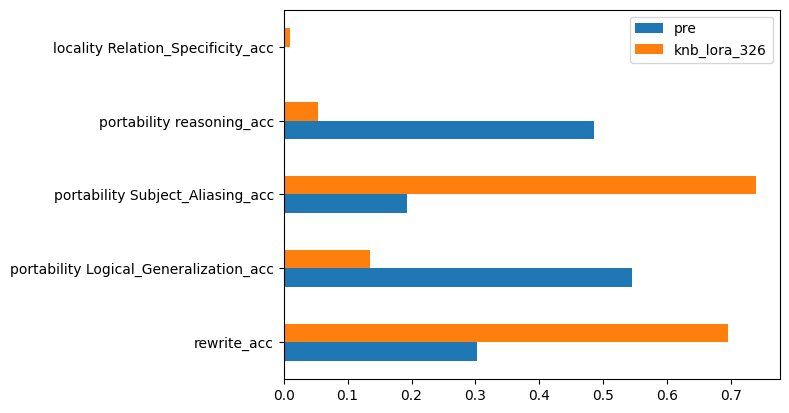

In [16]:
metric_pd.plot(kind='barh')